In [14]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Package Preparation

In [1]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [4]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [5]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [6]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [7]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [8]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [10]:
'''
app_store_scrapperNtransformer(app_name="Clash: Shoot Videos Send Drops",country="us",
                           how_many=5000,export_csv_name="clash_data_us.csv")
'''
# Status: Completed

2021-10-16 01:08:30,759 [INFO] Base - Searching for app id
2021-10-16 01:08:34,432 [INFO] Base - Initialised: AppStore('us', 'clash-shoot-videos-send-drops', 1441800002)
2021-10-16 01:08:34,433 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/clash-shoot-videos-send-drops/id1441800002
2021-10-16 01:08:39,836 [INFO] Base - [id:1441800002] Fetched 140 reviews (140 fetched in total)
2021-10-16 01:08:45,802 [INFO] Base - [id:1441800002] Fetched 300 reviews (300 fetched in total)
2021-10-16 01:08:52,597 [INFO] Base - [id:1441800002] Fetched 480 reviews (480 fetched in total)
2021-10-16 01:08:58,778 [INFO] Base - [id:1441800002] Fetched 660 reviews (660 fetched in total)
2021-10-16 01:09:04,533 [INFO] Base - [id:1441800002] Fetched 820 reviews (820 fetched in total)
2021-10-16 01:09:10,705 [INFO] Base - [id:1441800002] Fetched 1000 reviews (1000 fetched in total)
2021-10-16 01:09:16,509 [INFO] Base - [id:1441800002] Fetched 1160 reviews (1160 fetched in total)
2021-10

# Basic Data Preparation

In [11]:
# Import scrapped data
clash_ios_us_review = pd.read_csv("clash_data_us.csv")

In [12]:
# Inspect the data
clash_ios_us_review.head()

Unnamed: 0                   userName                 date  \
0           0                  ArtbyAlex  2020-07-30 01:03:24   
1           1                  wxirdnoel  2020-07-10 19:22:16   
2           2  vegan simp sufjan stevens  2020-07-16 13:03:06   
3           3                     DB3263  2020-10-22 16:08:39   
4           4                Ghost Women  2020-07-12 14:08:49   

                                title  rating  isEdited  \
0                      Loving byte!!!       4     False   
1  Just a few suggestions from GENZ❤️       5     False   
2      this app can be the new tiktok       5     False   
3                   SO MUCH POTENTIAL       5     False   
4          it’s my new safe place :,)       5     False   

                                                                                                                                                                                                    review  \
0  I love byte!!! However it could use a lot of improving, I would love seeing a lot of changes to the app and fixes for lots of glitches.\nThe most annoying glitch is when you go to make a video, sh...   
1  The app is AMAZING. But I have a few suggestions. Allow people to reply UNDER the comment they want to reply too so it’s not confusing. Allow us to dm eachother. Let us have duets. And make some o...   
2  there's so much potential here in this app. i think tiktok's meteoric rise kind of overshadowed this app's creation, but to be fair who could've predicted tiktok's popularity. this app is function...   
3  I only gave it 4 stars because it is SO close with tik tok it not exactly there yet. If you add more stuff to byte that is on other platforms especially tik tok, I have a feeling it can blow up. A...   
4  people are saying the app is not exactly like Tiktok, but it’s not supposed to be. it’s byte, things are going to be different. i think it’s amazing and the community is really friendly. i’ve made...   

  developerResponse  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN

In [18]:
# Sort by date, only keep data between 2018 and 2021, clean columns
clash_ios_us_review_YearMonth = (clash_ios_us_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2020-01-01 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
clash_ios_us_review_YearMonth['date'] = pd.to_datetime(clash_ios_us_review_YearMonth['date']).dt.floor('d')

# Create year column
clash_ios_us_review_YearMonth['year'] = pd.DatetimeIndex(clash_ios_us_review_YearMonth['date']).year

# Create month column
clash_ios_us_review_YearMonth['month'] = pd.DatetimeIndex(clash_ios_us_review_YearMonth['date']).month

In [19]:
# Inspect the dataframe again after cleaning
clash_ios_us_review_YearMonth.head()

userName       date             title  rating  isEdited  \
0         GiftedWithSkill 2020-01-24         great app       5     False   
1                 EC20202 2020-01-24        Great app!       5     False   
2                litJr225 2020-01-25     The Community       5     False   
3  Onthewavelengthyoutube 2020-01-25        Good vibes       5     False   
4            Wonderboy322 2020-01-25  Really Love This       5     False   

                                                                                                                                                                                                    review  \
0                                                                                                                                        been waiting on this forever now, so glad it finally came! -jalen   
1                                                                                                                                                                         Great app! And great creators !!   
2  Yes, its crazy and odd to see a re-creation of the old lovable app vine, but in all honesty you'll stay for the community. The creativity in every challenge, project, etc. The features are out of ...   
3                                                                                                                                                               really fun app, definitely would recommend   
4  I think everyone has missed the four letter app that starts with a v over the last few years. I genuinely hope this app succeeds in filling the gap it left behind. I have a feeling nostalgia is go...   

  developerResponse  year  month  
0               NaN  2020      1  
1               NaN  2020      1  
2               NaN  2020      1  
3               NaN  2020      1  
4               NaN  2020      1

In [24]:
clash_ios_us_review_YearMonth.shape

(2236, 9)

In [25]:
clash_ios_us_review_YearMonth[clash_ios_us_review_YearMonth['year']==2021]

userName       date  \
2177             huhuhrhg D hi g 2021-01-02   
2178                  Jaidabug08 2021-01-09   
2179              davidconsiglio 2021-01-19   
2180          Horatius Rothomagi 2021-01-21   
2181           nickthebeastwalsh 2021-01-26   
2182                     Hexpeck 2021-01-27   
2183   imjustreviewingdontgetmad 2021-01-27   
2184               ghost of duty 2021-01-31   
2185              Fidelity is #1 2021-02-12   
2186                idcWATUTHINK 2021-02-18   
2187                    821BlitZ 2021-03-03   
2188      vahdiebdis djd dns cjs 2021-03-05   
2189                   ggjcghjfg 2021-03-07   
2190              Deviously good 2021-03-15   
2191                  nichalis m 2021-04-02   
2192             Maximus rechter 2021-04-03   
2193                      miaprl 2021-04-04   
2194                      EvJurk 2021-04-06   
2195                  jejdjdndbe 2021-04-07   
2196               Likeadrug2017 2021-04-08   
2197                catloveshine 2021-04-19   
2198                       3srer 2021-04-30   
2199          10secattentionspan 2021-05-03   
2200                  Orion Hale 2021-05-10   
2201                   swag2mean 2021-05-10   
2202                       akceh 2021-05-19   
2203                frevangelion 2021-05-26   
2204             HuntersGirl2002 2021-06-10   
2205                   mzbeastle 2021-06-13   
2206                      Pedaco 2021-06-17   
2207                     ukats18 2021-06-20   
2208      mynicknameisjuicyfruit 2021-06-25   
2209                 ❤️Unknown❤️ 2021-06-28   
2210              FaceBookReview 2021-07-03   
2211               Televandalist 2021-07-12   
2212                    lizbuttt 2021-07-13   
2213                         🤡#1 2021-07-16   
2214               shart simpson 2021-07-23   
2215                blueberry154 2021-07-23   
2216                     NF-theR 2021-08-03   
2217                   blake101z 2021-08-18   
2218               MyMattingCall 2021-09-21   
2219                    Ekulizor 2021-10-03   
2220             cristinagarza93 2021-10-07   
2221                  Misterpeej 2021-10-12   
2222                 DougieDee13 2021-10-12   
2223                  tunawaters 2021-10-12   
2224              Sallyherring56 2021-10-12   
2225               luciano clash 2021-10-12   
2226             appleuser392588 2021-10-12   
2227              Austindriver13 2021-10-12   
2228                   just20706 2021-10-12   
2229                  MicaelaC15 2021-10-13   
2230                scratchflame 2021-10-13   
2231              hwurywjdhh7744 2021-10-13   
2232                    Anrana S 2021-10-13   
2233             markaylabrianne 2021-10-13   
2234         Skye Inferno Markus 2021-10-13   
2235  Mike10284756396836482hkkfj 2021-10-14   

                                                                                    title  \
2177                                                         Just some thought from Gen z   
2178                                                                          Suggestions   
2179                                                       App Has Potential To Be Great!   
2180                                                   This is the REAL successor to vine   
2181                                                                       Clash x Byte‼️   
2182                                                                                Trash   
2183                                               Kinda disappointed but I see potential   
2184                                         Great app,  I have a request and suggestions   
2185                                                                              Androif   
2186                                                                       Use to be good   
2187                                                                     Horrible runners   
2188                                                            This app is full of she

# EDA

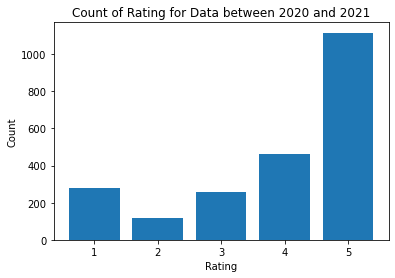

In [20]:
# Plot the count of different ratings for data between 2020 and 2021
clash_ios_us_review_score_count = clash_ios_us_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(clash_ios_us_review_score_count.index,clash_ios_us_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2020 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2020 and 2021')

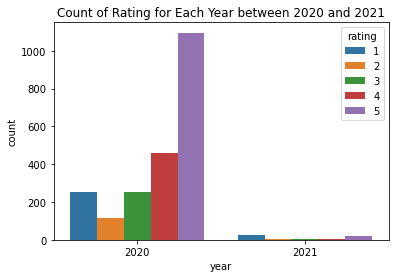

In [21]:
# Plot the count of different ratings for each year
clash_ios_us_review_score_count_ByYear = (clash_ios_us_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=clash_ios_us_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2020 and 2021")
)

# Comment: extreme review score on 1 or 5

In [26]:
# Understand average ratings over year
clash_ios_us_review_avg_score_ByYear = (clash_ios_us_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

clash_ios_us_review_avg_score_ByYear['count'] = clash_ios_us_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
clash_ios_us_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2020  3.932935   2175
2021  2.830508     59

# Dataframe Preparation for Topic Modelling

In [27]:
# Dataframe with data between 2020 and 2021 without score or year filtering
clash_ios_us_review_YearMonth.head()

userName       date             title  rating  isEdited  \
0         GiftedWithSkill 2020-01-24         great app       5     False   
1                 EC20202 2020-01-24        Great app!       5     False   
2                litJr225 2020-01-25     The Community       5     False   
3  Onthewavelengthyoutube 2020-01-25        Good vibes       5     False   
4            Wonderboy322 2020-01-25  Really Love This       5     False   

                                                                                                                                                                                                    review  \
0                                                                                                                                        been waiting on this forever now, so glad it finally came! -jalen   
1                                                                                                                                                                         Great app! And great creators !!   
2  Yes, its crazy and odd to see a re-creation of the old lovable app vine, but in all honesty you'll stay for the community. The creativity in every challenge, project, etc. The features are out of ...   
3                                                                                                                                                               really fun app, definitely would recommend   
4  I think everyone has missed the four letter app that starts with a v over the last few years. I genuinely hope this app succeeds in filling the gap it left behind. I have a feeling nostalgia is go...   

  developerResponse  year  month  
0               NaN  2020      1  
1               NaN  2020      1  
2               NaN  2020      1  
3               NaN  2020      1  
4               NaN  2020      1

In [28]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
clash_ios_us_review_YearMonth_score1 = clash_ios_us_review_YearMonth[clash_ios_us_review_YearMonth['rating']==1]
clash_ios_us_review_YearMonth_score2 = clash_ios_us_review_YearMonth[clash_ios_us_review_YearMonth['rating']==2]
clash_ios_us_review_YearMonth_score3 = clash_ios_us_review_YearMonth[clash_ios_us_review_YearMonth['rating']==3]
clash_ios_us_review_YearMonth_score4 = clash_ios_us_review_YearMonth[clash_ios_us_review_YearMonth['rating']==4]
clash_ios_us_review_YearMonth_score5 = clash_ios_us_review_YearMonth[clash_ios_us_review_YearMonth['rating']==5]


In [29]:
# Prepare dataframe for grouped score
clash_ios_us_review_YearMonth_score1N2N3 = clash_ios_us_review_YearMonth[clash_ios_us_review_YearMonth['rating'].isin([1,2,3])]
clash_ios_us_review_YearMonth_score4N5 = clash_ios_us_review_YearMonth[clash_ios_us_review_YearMonth['rating'].isin([4,5])]


In [30]:
# Prepare dataframe for topic modelling for 2020,2021 for score = 1,2,3
clash_ios_us_review_YearMonth_2020_score1N2N3 = clash_ios_us_review_YearMonth[(clash_ios_us_review_YearMonth['year']==2020)&(clash_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
clash_ios_us_review_YearMonth_2021_score1N2N3 = clash_ios_us_review_YearMonth[(clash_ios_us_review_YearMonth['year']==2021)&(clash_ios_us_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [31]:
# Overall Topic Modelling - data between 2020 and 2021 without score or year filtering
# Convert to list - move to each section
review_us = clash_ios_us_review_YearMonth.review.values.tolist()
review_words_us = list(sent_to_words(review_us))
print(review_words_us[:1])

[['been', 'waiting', 'on', 'this', 'forever', 'now', 'so', 'glad', 'it', 'finally', 'came', 'jalen']]


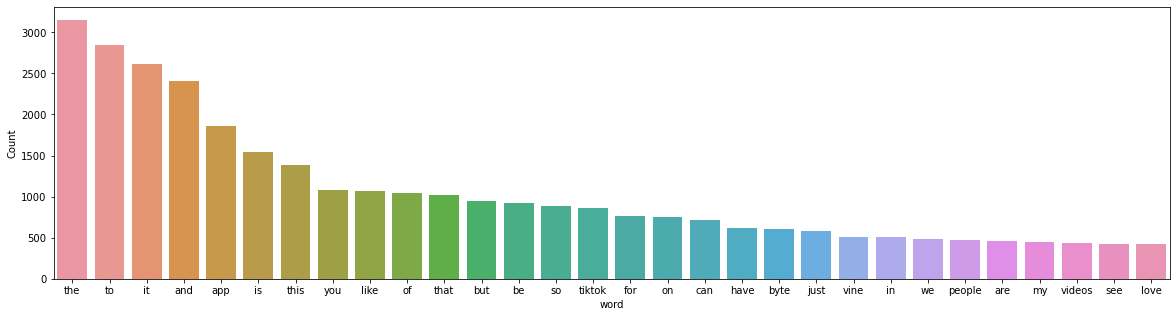

In [32]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us))

In [33]:
# Clean text
review_us_ready = process_words(review_words_us)  # processed Text Data! - move to each section

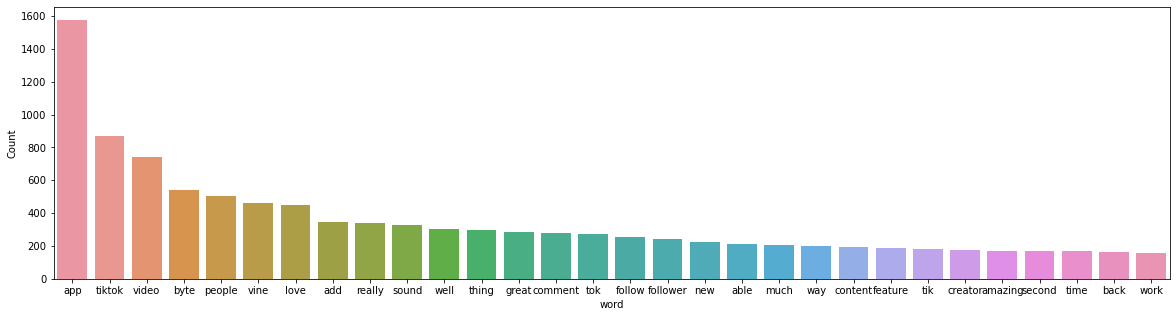

In [34]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready))

In [35]:
# Create Dictionary
id2word_us = corpora.Dictionary(review_us_ready)

2021-10-16 01:21:52,425 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 01:21:52,514 [INFO] gensim.corpora.dictionary - built Dictionary(2885 unique tokens: ['finally', 'forever', 'glad', 'wait', 'app']...) from 2236 documents (total 30126 corpus positions)
2021-10-16 01:21:52,561 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2885 unique tokens: ['finally', 'forever', 'glad', 'wait', 'app']...) from 2236 documents (total 30126 corpus positions)", 'datetime': '2021-10-16T01:21:52.516079', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [36]:
# Create Corpus: Term Document Frequency
corpus_us = [id2word_us.doc2bow(text) for text in review_us_ready]

In [37]:
# Training LDA model
model_list_us, coherence_values_us = compute_coherence_values(dictionary=id2word_us, corpus=corpus_us, 
                                                              texts=review_us_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-16 01:21:52,709 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 01:21:52,711 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 01:21:52,715 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:21:52,718 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 2236 documents, updating model once every 1000 documents, evaluating perplexity every 2236 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:21:52,720 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/2236
2021-10-16 01:21:55,458 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:21:55,463 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.044*"app" + 0.030*"video" + 0.029*"vine" + 0.017*"byte" + 0.016*"tiktok" + 0.015*"follow" + 0.014*"people" + 0.013*"love" + 0.011*"content"

2021-10-16 01:22:09,792 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"app" + 0.039*"tiktok" + 0.019*"add" + 0.017*"byte" + 0.015*"tok" + 0.015*"feature" + 0.013*"love" + 0.012*"people" + 0.011*"sound" + 0.011*"great"
2021-10-16 01:22:09,795 [INFO] gensim.models.ldamodel - topic diff=0.388426, rho=0.400449
2021-10-16 01:22:09,806 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #2000/2236
2021-10-16 01:22:11,413 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:22:11,416 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.054*"app" + 0.036*"video" + 0.017*"vine" + 0.017*"people" + 0.016*"byte" + 0.014*"tiktok" + 0.013*"really" + 0.013*"love" + 0.010*"new" + 0.010*"content"
2021-10-16 01:22:11,418 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"app" + 0.043*"tiktok" + 0.021*"add" + 0.020*"sound" + 0.016*"tok" + 0.016*"byte" + 0.014*"love" + 0.014*"people" + 0.012*"feature" + 0.011*"tik"
2021-1

2021-10-16 01:22:21,624 [INFO] gensim.models.ldamodel - topic diff=0.274256, rho=0.329047
2021-10-16 01:22:21,958 [INFO] gensim.models.ldamodel - -6.407 per-word bound, 84.9 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:22:21,959 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #2236/2236
2021-10-16 01:22:22,274 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:22:22,278 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"app" + 0.034*"video" + 0.020*"byte" + 0.015*"vine" + 0.015*"people" + 0.013*"love" + 0.012*"really" + 0.012*"new" + 0.011*"tiktok" + 0.010*"time"
2021-10-16 01:22:22,281 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.047*"app" + 0.044*"tiktok" + 0.021*"add" + 0.019*"sound" + 0.017*"tok" + 0.015*"feature" + 0.013*"people" + 0.013*"byte" + 0.012*"love" + 0.011*"tik"
2021-10-16 01:22:22,282 [INFO] gensim.models.ldamodel - topic diff=0.25634

2021-10-16 01:22:31,461 [INFO] gensim.models.ldamodel - topic diff=0.216489, rho=0.285878
2021-10-16 01:22:31,462 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1000/2236
2021-10-16 01:22:32,542 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:22:32,544 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.052*"app" + 0.031*"video" + 0.023*"vine" + 0.021*"byte" + 0.014*"people" + 0.012*"love" + 0.012*"new" + 0.011*"content" + 0.011*"really" + 0.010*"tiktok"
2021-10-16 01:22:32,546 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"app" + 0.043*"tiktok" + 0.021*"add" + 0.017*"tok" + 0.016*"sound" + 0.015*"feature" + 0.014*"people" + 0.013*"love" + 0.012*"byte" + 0.012*"video"
2021-10-16 01:22:32,547 [INFO] gensim.models.ldamodel - topic diff=0.236528, rho=0.274866
2021-10-16 01:22:32,549 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #2000/2236
2021-10-16 01:22:33,737 [INFO] gensim.model

2021-10-16 01:22:40,919 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #2000/2236
2021-10-16 01:22:41,967 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:22:41,970 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.054*"app" + 0.030*"video" + 0.022*"byte" + 0.020*"vine" + 0.014*"people" + 0.013*"love" + 0.012*"new" + 0.012*"really" + 0.011*"content" + 0.010*"tiktok"
2021-10-16 01:22:41,971 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"app" + 0.044*"tiktok" + 0.021*"add" + 0.021*"sound" + 0.017*"tok" + 0.016*"people" + 0.015*"video" + 0.014*"love" + 0.013*"comment" + 0.012*"feature"
2021-10-16 01:22:41,973 [INFO] gensim.models.ldamodel - topic diff=0.194636, rho=0.248176
2021-10-16 01:22:42,260 [INFO] gensim.models.ldamodel - -6.373 per-word bound, 82.9 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:22:42,267 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-16 01:22:50,839 [INFO] gensim.models.ldamodel - -6.362 per-word bound, 82.2 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:22:50,841 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #2236/2236
2021-10-16 01:22:51,146 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:22:51,151 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"app" + 0.028*"video" + 0.022*"byte" + 0.019*"vine" + 0.013*"new" + 0.013*"love" + 0.012*"people" + 0.012*"really" + 0.011*"time" + 0.011*"content"
2021-10-16 01:22:51,156 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.046*"app" + 0.043*"tiktok" + 0.021*"add" + 0.019*"sound" + 0.017*"video" + 0.017*"tok" + 0.016*"people" + 0.014*"feature" + 0.013*"comment" + 0.012*"love"
2021-10-16 01:22:51,158 [INFO] gensim.models.ldamodel - topic diff=0.167998, rho=0.228004
2021-10-16 01:22:51,159 [INFO] gensim.models.ldamodel - PROGRESS: p

2021-10-16 01:22:59,830 [INFO] gensim.models.ldamodel - topic diff=0.155305, rho=0.212066
2021-10-16 01:22:59,832 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/2236
2021-10-16 01:23:00,936 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:23:00,938 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.054*"app" + 0.026*"video" + 0.024*"vine" + 0.023*"byte" + 0.013*"love" + 0.013*"new" + 0.012*"content" + 0.012*"people" + 0.011*"time" + 0.011*"really"
2021-10-16 01:23:00,940 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"app" + 0.041*"tiktok" + 0.020*"add" + 0.019*"video" + 0.017*"people" + 0.016*"tok" + 0.016*"sound" + 0.014*"comment" + 0.013*"feature" + 0.012*"love"
2021-10-16 01:23:00,942 [INFO] gensim.models.ldamodel - topic diff=0.169481, rho=0.207453
2021-10-16 01:23:00,944 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #2000/2236
2021-10-16 01:23:02,356 [INFO] gensim.mode

2021-10-16 01:23:10,857 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #2000/2236
2021-10-16 01:23:12,177 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:23:12,180 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.055*"app" + 0.025*"video" + 0.023*"byte" + 0.022*"vine" + 0.014*"love" + 0.013*"new" + 0.011*"people" + 0.011*"really" + 0.011*"content" + 0.011*"tiktok"
2021-10-16 01:23:12,182 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"app" + 0.042*"tiktok" + 0.021*"video" + 0.020*"add" + 0.019*"sound" + 0.018*"people" + 0.016*"tok" + 0.015*"comment" + 0.013*"love" + 0.012*"able"
2021-10-16 01:23:12,183 [INFO] gensim.models.ldamodel - topic diff=0.147890, rho=0.195232
2021-10-16 01:23:12,563 [INFO] gensim.models.ldamodel - -6.340 per-word bound, 81.0 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:23:12,567 [INFO] gensim.models.ldamodel - PROGRESS: p

2021-10-16 01:23:21,174 [INFO] gensim.models.ldamodel - -6.332 per-word bound, 80.6 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:23:21,175 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #2236/2236
2021-10-16 01:23:21,412 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:23:21,414 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"app" + 0.024*"video" + 0.024*"byte" + 0.020*"vine" + 0.014*"love" + 0.013*"new" + 0.012*"tiktok" + 0.011*"content" + 0.011*"time" + 0.011*"really"
2021-10-16 01:23:21,415 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"app" + 0.041*"tiktok" + 0.022*"video" + 0.020*"add" + 0.018*"sound" + 0.018*"people" + 0.016*"tok" + 0.014*"comment" + 0.013*"feature" + 0.012*"love"
2021-10-16 01:23:21,416 [INFO] gensim.models.ldamodel - topic diff=0.133958, rho=0.184944
2021-10-16 01:23:21,418 [INFO] gensim.models.ldamodel - PROGRESS: p

2021-10-16 01:23:29,033 [INFO] gensim.models.ldamodel - topic diff=0.126764, rho=0.176128
2021-10-16 01:23:29,036 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1000/2236
2021-10-16 01:23:29,945 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:23:29,949 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.055*"app" + 0.024*"vine" + 0.024*"byte" + 0.022*"video" + 0.013*"love" + 0.013*"new" + 0.012*"content" + 0.011*"tiktok" + 0.011*"time" + 0.011*"people"
2021-10-16 01:23:29,951 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.040*"tiktok" + 0.023*"video" + 0.020*"add" + 0.018*"people" + 0.016*"tok" + 0.016*"sound" + 0.014*"comment" + 0.013*"follow" + 0.012*"follower"
2021-10-16 01:23:29,952 [INFO] gensim.models.ldamodel - topic diff=0.138123, rho=0.173459
2021-10-16 01:23:29,953 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #2000/2236
2021-10-16 01:23:31,007 [INFO] gensim.m

2021-10-16 01:23:37,711 [INFO] gensim.models.ldamodel - topic diff=0.131293, rho=0.166123
2021-10-16 01:23:37,714 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #2000/2236
2021-10-16 01:23:38,712 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:23:38,726 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.057*"app" + 0.024*"byte" + 0.022*"vine" + 0.021*"video" + 0.014*"love" + 0.014*"new" + 0.012*"tiktok" + 0.012*"content" + 0.011*"really" + 0.011*"people"
2021-10-16 01:23:38,735 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"app" + 0.040*"tiktok" + 0.024*"video" + 0.020*"add" + 0.019*"sound" + 0.019*"people" + 0.016*"tok" + 0.015*"comment" + 0.013*"thing" + 0.012*"follower"
2021-10-16 01:23:38,736 [INFO] gensim.models.ldamodel - topic diff=0.123133, rho=0.166123
2021-10-16 01:23:39,099 [INFO] gensim.models.ldamodel - -6.321 per-word bound, 79.9 perplexity estimate based on a held-out corpus of 23

2021-10-16 01:23:46,466 [INFO] gensim.models.ldamodel - topic diff=0.117682, rho=0.159646
2021-10-16 01:23:46,778 [INFO] gensim.models.ldamodel - -6.318 per-word bound, 79.8 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:23:46,780 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #2236/2236
2021-10-16 01:23:46,941 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:23:46,945 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"app" + 0.024*"byte" + 0.021*"video" + 0.021*"vine" + 0.014*"love" + 0.013*"new" + 0.013*"tiktok" + 0.011*"content" + 0.011*"time" + 0.011*"really"
2021-10-16 01:23:46,947 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"app" + 0.040*"tiktok" + 0.025*"video" + 0.020*"add" + 0.018*"people" + 0.018*"sound" + 0.016*"tok" + 0.014*"comment" + 0.012*"thing" + 0.012*"follower"
2021-10-16 01:23:46,949 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 01:23:54,933 [INFO] gensim.models.ldamodel - topic diff=0.108869, rho=0.153872
2021-10-16 01:23:54,934 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/2236
2021-10-16 01:23:55,873 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:23:55,876 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.056*"app" + 0.024*"byte" + 0.024*"vine" + 0.020*"video" + 0.013*"love" + 0.013*"new" + 0.013*"tiktok" + 0.012*"content" + 0.011*"time" + 0.010*"people"
2021-10-16 01:23:55,878 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.038*"tiktok" + 0.025*"video" + 0.019*"add" + 0.018*"people" + 0.016*"sound" + 0.016*"tok" + 0.014*"comment" + 0.014*"follow" + 0.013*"follower"
2021-10-16 01:23:55,880 [INFO] gensim.models.ldamodel - topic diff=0.118530, rho=0.152082
2021-10-16 01:23:55,884 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #2000/2236
2021-10-16 01:23:56,933 [INFO] gensim.m

2021-10-16 01:24:03,414 [INFO] gensim.models.ldamodel - topic diff=0.114007, rho=0.147065
2021-10-16 01:24:03,415 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #2000/2236
2021-10-16 01:24:04,439 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:24:04,445 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.057*"app" + 0.024*"byte" + 0.022*"vine" + 0.020*"video" + 0.014*"love" + 0.013*"tiktok" + 0.013*"new" + 0.012*"content" + 0.011*"really" + 0.011*"time"
2021-10-16 01:24:04,448 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"app" + 0.039*"tiktok" + 0.026*"video" + 0.020*"add" + 0.019*"people" + 0.019*"sound" + 0.016*"tok" + 0.015*"comment" + 0.013*"thing" + 0.013*"follower"
2021-10-16 01:24:04,453 [INFO] gensim.models.ldamodel - topic diff=0.107277, rho=0.147065
2021-10-16 01:24:04,799 [INFO] gensim.models.ldamodel - -6.313 per-word bound, 79.5 perplexity estimate based on a held-out corpus of 236 

2021-10-16 01:24:12,239 [INFO] gensim.models.ldamodel - topic diff=0.103615, rho=0.142514
2021-10-16 01:24:12,575 [INFO] gensim.models.ldamodel - -6.311 per-word bound, 79.4 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:24:12,576 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #2236/2236
2021-10-16 01:24:12,827 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:24:12,831 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.058*"app" + 0.024*"byte" + 0.021*"vine" + 0.020*"video" + 0.014*"tiktok" + 0.014*"love" + 0.013*"new" + 0.011*"content" + 0.011*"time" + 0.011*"really"
2021-10-16 01:24:12,834 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"app" + 0.039*"tiktok" + 0.026*"video" + 0.020*"add" + 0.019*"people" + 0.018*"sound" + 0.016*"tok" + 0.014*"comment" + 0.012*"thing" + 0.012*"follow"
2021-10-16 01:24:12,836 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 01:24:20,754 [INFO] gensim.models.ldamodel - topic diff=0.096661, rho=0.138361
2021-10-16 01:24:20,756 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2885, num_topics=2, decay=0.5, chunksize=1000) in 148.04s', 'datetime': '2021-10-16T01:24:20.756147', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 01:24:20,762 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 01:24:25,422 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 01:24:25,481 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 2090 virtual documents
2021-10-16 01:24:25,802 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-

2021-10-16 01:24:32,594 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"love" + 0.040*"app" + 0.024*"follow" + 0.021*"amazing" + 0.021*"follower" + 0.020*"thing" + 0.018*"comment" + 0.018*"people" + 0.017*"add" + 0.015*"really"
2021-10-16 01:24:32,595 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.067*"app" + 0.059*"tiktok" + 0.027*"byte" + 0.018*"love" + 0.017*"vine" + 0.016*"account" + 0.015*"new" + 0.015*"well" + 0.014*"tok" + 0.014*"really"
2021-10-16 01:24:32,597 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.015*"else" + 0.011*"rip" + 0.010*"pet" + 0.009*"ban" + 0.008*"school" + 0.008*"ugly" + 0.008*"tok" + 0.008*"idk" + 0.007*"color" + 0.007*"game"
2021-10-16 01:24:32,598 [INFO] gensim.models.ldamodel - topic diff=0.519527, rho=0.485872
2021-10-16 01:24:32,929 [INFO] gensim.models.ldamodel - -6.869 per-word bound, 116.9 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:24:32,931 [INFO] gensim.models.ldamodel - PROGRE

2021-10-16 01:24:37,683 [INFO] gensim.models.ldamodel - topic diff=0.292520, rho=0.400449
2021-10-16 01:24:37,685 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #2000/2236
2021-10-16 01:24:38,820 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:24:38,825 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.017*"else" + 0.014*"pet" + 0.012*"rip" + 0.009*"idk" + 0.009*"school" + 0.008*"ugly" + 0.008*"game" + 0.007*"away" + 0.007*"none" + 0.007*"mainly"
2021-10-16 01:24:38,828 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.063*"tiktok" + 0.063*"app" + 0.031*"byte" + 0.019*"vine" + 0.018*"account" + 0.018*"new" + 0.016*"love" + 0.016*"well" + 0.014*"tok" + 0.011*"really"
2021-10-16 01:24:38,832 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.042*"love" + 0.040*"app" + 0.027*"follow" + 0.025*"follower" + 0.024*"amazing" + 0.021*"thing" + 0.020*"people" + 0.017*"comment" + 0.017*"add" + 0.015*"really"
2021

2021-10-16 01:24:43,049 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"byte" + 0.037*"vine" + 0.034*"app" + 0.019*"back" + 0.019*"people" + 0.017*"content" + 0.017*"great" + 0.014*"community" + 0.014*"bring" + 0.012*"really"
2021-10-16 01:24:43,051 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"pet" + 0.015*"else" + 0.012*"rip" + 0.010*"game" + 0.009*"star" + 0.009*"none" + 0.008*"ruin" + 0.007*"idk" + 0.007*"doo" + 0.007*"dude"
2021-10-16 01:24:43,053 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.061*"app" + 0.020*"community" + 0.017*"work" + 0.016*"vine" + 0.016*"update" + 0.013*"creator" + 0.013*"actually" + 0.012*"great" + 0.011*"error" + 0.011*"camera"
2021-10-16 01:24:43,055 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.068*"video" + 0.050*"app" + 0.017*"second" + 0.017*"people" + 0.015*"time" + 0.014*"follow" + 0.012*"tiktok" + 0.012*"comment" + 0.012*"really" + 0.011*"way"
2021-10-16 01:24:43,057 [INFO] gensim.models.ldamodel - topic diff=0.21511

2021-10-16 01:24:47,019 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"pet" + 0.014*"else" + 0.013*"game" + 0.011*"rip" + 0.010*"doo" + 0.010*"dude" + 0.010*"keyboard" + 0.009*"none" + 0.008*"away" + 0.008*"ruin"
2021-10-16 01:24:47,021 [INFO] gensim.models.ldamodel - topic diff=0.166127, rho=0.329047
2021-10-16 01:24:47,023 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #1000/2236
2021-10-16 01:24:47,957 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:24:47,961 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.050*"app" + 0.044*"add" + 0.041*"sound" + 0.039*"tiktok" + 0.037*"feature" + 0.033*"tok" + 0.025*"tik" + 0.021*"ban" + 0.020*"filter" + 0.019*"video"
2021-10-16 01:24:47,963 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.068*"video" + 0.051*"app" + 0.017*"people" + 0.017*"second" + 0.015*"time" + 0.014*"follow" + 0.013*"comment" + 0.012*"really" + 0.012*"tiktok" + 0.012*"way"
2021-10

2021-10-16 01:24:52,077 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"love" + 0.040*"app" + 0.028*"amazing" + 0.025*"follow" + 0.025*"follower" + 0.023*"channel" + 0.021*"people" + 0.017*"thing" + 0.015*"profile" + 0.013*"add"
2021-10-16 01:24:52,079 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"pet" + 0.014*"else" + 0.013*"game" + 0.011*"rip" + 0.009*"doo" + 0.009*"dude" + 0.009*"keyboard" + 0.009*"none" + 0.009*"away" + 0.008*"mainly"
2021-10-16 01:24:52,082 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"app" + 0.035*"byte" + 0.030*"vine" + 0.019*"back" + 0.016*"content" + 0.016*"great" + 0.015*"community" + 0.015*"people" + 0.015*"bring" + 0.014*"really"
2021-10-16 01:24:52,084 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.070*"video" + 0.055*"app" + 0.017*"people" + 0.016*"time" + 0.015*"second" + 0.014*"comment" + 0.014*"really" + 0.013*"tiktok" + 0.013*"like" + 0.012*"follow"
2021-10-16 01:24:52,085 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 01:24:56,582 [INFO] gensim.models.ldamodel - topic diff=0.136100, rho=0.274866
2021-10-16 01:24:56,862 [INFO] gensim.models.ldamodel - -6.507 per-word bound, 91.0 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:24:56,864 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #2236/2236
2021-10-16 01:24:57,082 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:24:57,088 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.061*"tiktok" + 0.058*"app" + 0.036*"byte" + 0.022*"account" + 0.020*"new" + 0.019*"vine" + 0.015*"people" + 0.014*"love" + 0.013*"well" + 0.013*"tok"
2021-10-16 01:24:57,090 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"app" + 0.036*"byte" + 0.032*"vine" + 0.020*"back" + 0.016*"content" + 0.016*"great" + 0.016*"community" + 0.015*"bring" + 0.014*"people" + 0.014*"really"
2021-10-16 01:24:57,093 [INFO] gensim.models.ldamodel - topic #6 

2021-10-16 01:25:02,226 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.046*"love" + 0.041*"app" + 0.031*"follow" + 0.028*"follower" + 0.028*"amazing" + 0.024*"people" + 0.020*"thing" + 0.017*"profile" + 0.017*"channel" + 0.013*"add"
2021-10-16 01:25:02,228 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.066*"app" + 0.020*"actually" + 0.019*"work" + 0.018*"update" + 0.018*"community" + 0.016*"creator" + 0.014*"load" + 0.012*"care" + 0.012*"vine" + 0.010*"great"
2021-10-16 01:25:02,230 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.057*"sound" + 0.051*"app" + 0.046*"add" + 0.043*"tiktok" + 0.034*"tok" + 0.031*"feature" + 0.027*"tik" + 0.023*"filter" + 0.021*"ban" + 0.019*"able"
2021-10-16 01:25:02,232 [INFO] gensim.models.ldamodel - topic diff=0.123992, rho=0.256191
2021-10-16 01:25:02,551 [INFO] gensim.models.ldamodel - -6.497 per-word bound, 90.3 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:25:02,552 [INFO] gensim.models.ld

2021-10-16 01:25:06,574 [INFO] gensim.models.ldamodel - topic diff=0.123802, rho=0.240869
2021-10-16 01:25:06,576 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #2000/2236
2021-10-16 01:25:07,574 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:25:07,578 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.018*"pet" + 0.017*"else" + 0.012*"rip" + 0.010*"game" + 0.009*"away" + 0.009*"ugly" + 0.008*"none" + 0.008*"school" + 0.007*"star" + 0.007*"mainly"
2021-10-16 01:25:07,580 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.040*"vine" + 0.037*"byte" + 0.036*"app" + 0.022*"back" + 0.017*"great" + 0.017*"community" + 0.016*"content" + 0.014*"people" + 0.014*"bring" + 0.014*"really"
2021-10-16 01:25:07,581 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.056*"sound" + 0.051*"app" + 0.046*"add" + 0.043*"tiktok" + 0.034*"tok" + 0.031*"feature" + 0.027*"tik" + 0.023*"filter" + 0.020*"ban" + 0.019*"able"
2021-

2021-10-16 01:25:11,548 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.046*"vine" + 0.037*"byte" + 0.036*"app" + 0.025*"back" + 0.018*"great" + 0.017*"content" + 0.017*"community" + 0.015*"bring" + 0.013*"people" + 0.013*"really"
2021-10-16 01:25:11,550 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"pet" + 0.015*"else" + 0.012*"rip" + 0.011*"game" + 0.009*"star" + 0.009*"none" + 0.008*"away" + 0.007*"doo" + 0.007*"dude" + 0.007*"keyboard"
2021-10-16 01:25:11,552 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"tiktok" + 0.056*"app" + 0.036*"byte" + 0.023*"vine" + 0.020*"new" + 0.019*"account" + 0.015*"well" + 0.014*"people" + 0.013*"love" + 0.013*"tok"
2021-10-16 01:25:11,553 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.067*"app" + 0.019*"work" + 0.018*"community" + 0.018*"update" + 0.018*"actually" + 0.016*"creator" + 0.014*"vine" + 0.013*"load" + 0.012*"care" + 0.011*"great"
2021-10-16 01:25:11,554 [INFO] gensim.models.ldamodel - topic diff=0.115940, rho

2021-10-16 01:25:15,667 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.073*"app" + 0.021*"update" + 0.021*"work" + 0.018*"actually" + 0.017*"community" + 0.017*"creator" + 0.015*"load" + 0.012*"care" + 0.012*"vine" + 0.012*"great"
2021-10-16 01:25:15,668 [INFO] gensim.models.ldamodel - topic diff=0.099445, rho=0.222299
2021-10-16 01:25:15,670 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1000/2236
2021-10-16 01:25:16,602 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:25:16,606 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.067*"app" + 0.019*"work" + 0.018*"actually" + 0.018*"update" + 0.018*"community" + 0.016*"creator" + 0.014*"vine" + 0.013*"load" + 0.012*"care" + 0.011*"great"
2021-10-16 01:25:16,608 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.068*"video" + 0.051*"app" + 0.017*"people" + 0.016*"second" + 0.015*"comment" + 0.014*"time" + 0.013*"follow" + 0.013*"really" + 0.012*"like"

2021-10-16 01:25:20,556 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"vine" + 0.038*"app" + 0.033*"byte" + 0.024*"back" + 0.018*"community" + 0.017*"great" + 0.017*"content" + 0.015*"bring" + 0.015*"really" + 0.013*"people"
2021-10-16 01:25:20,559 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"love" + 0.041*"app" + 0.030*"follow" + 0.029*"amazing" + 0.025*"follower" + 0.023*"people" + 0.022*"channel" + 0.017*"thing" + 0.016*"profile" + 0.012*"account"
2021-10-16 01:25:20,560 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.052*"app" + 0.051*"sound" + 0.045*"add" + 0.043*"tiktok" + 0.037*"feature" + 0.033*"tok" + 0.026*"tik" + 0.023*"filter" + 0.020*"ban" + 0.020*"video"
2021-10-16 01:25:20,562 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.070*"video" + 0.054*"app" + 0.017*"people" + 0.016*"comment" + 0.015*"time" + 0.015*"second" + 0.014*"really" + 0.013*"like" + 0.012*"tiktok" + 0.012*"follow"
2021-10-16 01:25:20,564 [INFO] gensim.models.ldamodel - topic 

2021-10-16 01:25:25,181 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.065*"tiktok" + 0.057*"app" + 0.037*"byte" + 0.020*"vine" + 0.020*"new" + 0.018*"account" + 0.015*"well" + 0.015*"people" + 0.013*"love" + 0.013*"tok"
2021-10-16 01:25:25,183 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.068*"app" + 0.021*"actually" + 0.020*"work" + 0.019*"update" + 0.018*"community" + 0.016*"creator" + 0.014*"load" + 0.012*"care" + 0.012*"vine" + 0.010*"great"
2021-10-16 01:25:25,184 [INFO] gensim.models.ldamodel - topic diff=0.094494, rho=0.203128
2021-10-16 01:25:25,497 [INFO] gensim.models.ldamodel - -6.468 per-word bound, 88.5 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:25:25,498 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #2236/2236
2021-10-16 01:25:25,659 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:25:25,667 [INFO] gensim.models.ldamodel - topic #3

2021-10-16 01:25:28,992 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #2000/2236
2021-10-16 01:25:30,053 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:25:30,057 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.065*"tiktok" + 0.057*"app" + 0.037*"byte" + 0.020*"vine" + 0.020*"new" + 0.018*"account" + 0.015*"well" + 0.015*"people" + 0.013*"love" + 0.013*"tok"
2021-10-16 01:25:30,059 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"love" + 0.041*"app" + 0.033*"follow" + 0.029*"amazing" + 0.027*"follower" + 0.024*"people" + 0.019*"thing" + 0.018*"channel" + 0.017*"profile" + 0.013*"private"
2021-10-16 01:25:30,061 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.067*"video" + 0.052*"app" + 0.017*"people" + 0.017*"comment" + 0.015*"second" + 0.014*"really" + 0.013*"like" + 0.013*"time" + 0.012*"tiktok" + 0.012*"thing"
2021-10-16 01:25:30,064 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.0

2021-10-16 01:25:34,076 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"tiktok" + 0.056*"app" + 0.037*"byte" + 0.023*"vine" + 0.020*"new" + 0.019*"account" + 0.015*"well" + 0.014*"people" + 0.013*"love" + 0.013*"tok"
2021-10-16 01:25:34,079 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.050*"app" + 0.046*"sound" + 0.045*"add" + 0.043*"tiktok" + 0.037*"feature" + 0.033*"tok" + 0.026*"tik" + 0.022*"filter" + 0.020*"ban" + 0.018*"video"
2021-10-16 01:25:34,082 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.045*"love" + 0.039*"app" + 0.036*"follow" + 0.029*"amazing" + 0.027*"follower" + 0.023*"people" + 0.019*"channel" + 0.018*"thing" + 0.017*"profile" + 0.012*"private"
2021-10-16 01:25:34,084 [INFO] gensim.models.ldamodel - topic diff=0.093037, rho=0.188191
2021-10-16 01:25:34,086 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #2000/2236
2021-10-16 01:25:35,108 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 docum

2021-10-16 01:25:38,127 [INFO] gensim.models.ldamodel - topic diff=0.080393, rho=0.184944
2021-10-16 01:25:38,130 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/2236
2021-10-16 01:25:39,170 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:25:39,174 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.050*"app" + 0.046*"sound" + 0.045*"add" + 0.043*"tiktok" + 0.036*"feature" + 0.034*"tok" + 0.026*"tik" + 0.022*"filter" + 0.020*"ban" + 0.018*"video"
2021-10-16 01:25:39,175 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"vine" + 0.036*"app" + 0.034*"byte" + 0.026*"back" + 0.019*"great" + 0.018*"community" + 0.017*"content" + 0.015*"bring" + 0.013*"really" + 0.013*"people"
2021-10-16 01:25:39,177 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"pet" + 0.015*"else" + 0.012*"rip" + 0.011*"game" + 0.009*"happy" + 0.009*"none" + 0.008*"star" + 0.008*"away" + 0.007*"doo" + 0.007*"dude"
2021-10-

2021-10-16 01:25:43,466 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.027*"pet" + 0.015*"else" + 0.012*"game" + 0.012*"rip" + 0.009*"none" + 0.009*"away" + 0.009*"doo" + 0.009*"dude" + 0.009*"keyboard" + 0.008*"happy"
2021-10-16 01:25:43,470 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.051*"app" + 0.050*"sound" + 0.045*"add" + 0.043*"tiktok" + 0.036*"feature" + 0.033*"tok" + 0.026*"tik" + 0.023*"filter" + 0.020*"ban" + 0.019*"video"
2021-10-16 01:25:43,472 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.062*"tiktok" + 0.057*"app" + 0.038*"byte" + 0.020*"account" + 0.020*"new" + 0.019*"vine" + 0.015*"people" + 0.014*"well" + 0.013*"love" + 0.013*"tok"
2021-10-16 01:25:43,474 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.040*"vine" + 0.038*"app" + 0.032*"byte" + 0.024*"back" + 0.018*"community" + 0.018*"great" + 0.017*"content" + 0.015*"bring" + 0.015*"really" + 0.013*"people"
2021-10-16 01:25:43,478 [INFO] gensim.models.ldamodel - topic diff=0.077162, rho=0.178926

2021-10-16 01:25:47,993 [INFO] gensim.models.ldamodel - topic diff=0.078712, rho=0.173459
2021-10-16 01:25:48,266 [INFO] gensim.models.ldamodel - -6.456 per-word bound, 87.8 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:25:48,268 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #2236/2236
2021-10-16 01:25:48,396 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:25:48,400 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.068*"video" + 0.053*"app" + 0.018*"comment" + 0.017*"people" + 0.015*"second" + 0.015*"time" + 0.013*"really" + 0.013*"like" + 0.012*"tiktok" + 0.012*"thing"
2021-10-16 01:25:48,401 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"vine" + 0.039*"app" + 0.032*"byte" + 0.024*"back" + 0.019*"community" + 0.018*"great" + 0.017*"content" + 0.015*"bring" + 0.015*"really" + 0.013*"people"
2021-10-16 01:25:48,403 [INFO] gensim.models.ldamodel - t

2021-10-16 01:25:52,345 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.065*"tiktok" + 0.057*"app" + 0.038*"byte" + 0.021*"vine" + 0.020*"new" + 0.018*"account" + 0.015*"well" + 0.015*"people" + 0.013*"love" + 0.013*"tok"
2021-10-16 01:25:52,348 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"love" + 0.042*"app" + 0.033*"follow" + 0.030*"amazing" + 0.026*"follower" + 0.024*"people" + 0.018*"channel" + 0.018*"thing" + 0.017*"profile" + 0.014*"private"
2021-10-16 01:25:52,350 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"pet" + 0.016*"else" + 0.012*"rip" + 0.011*"game" + 0.009*"none" + 0.008*"away" + 0.008*"happy" + 0.008*"ugly" + 0.008*"school" + 0.007*"mainly"
2021-10-16 01:25:52,352 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.068*"app" + 0.020*"actually" + 0.020*"work" + 0.020*"update" + 0.016*"community" + 0.016*"creator" + 0.015*"load" + 0.012*"care" + 0.011*"vine" + 0.010*"great"
2021-10-16 01:25:52,354 [INFO] gensim.models.ldamodel - topic diff=0.07

2021-10-16 01:25:56,032 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"vine" + 0.037*"app" + 0.033*"byte" + 0.026*"back" + 0.019*"community" + 0.019*"great" + 0.018*"content" + 0.015*"bring" + 0.014*"really" + 0.013*"people"
2021-10-16 01:25:56,038 [INFO] gensim.models.ldamodel - topic diff=0.079519, rho=0.163877
2021-10-16 01:25:56,043 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #2000/2236
2021-10-16 01:25:56,875 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:25:56,882 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"pet" + 0.016*"else" + 0.012*"rip" + 0.011*"game" + 0.009*"none" + 0.008*"away" + 0.008*"happy" + 0.008*"ugly" + 0.008*"school" + 0.007*"star"
2021-10-16 01:25:56,884 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.066*"video" + 0.052*"app" + 0.019*"comment" + 0.017*"people" + 0.015*"second" + 0.013*"really" + 0.013*"like" + 0.013*"thing" + 0.013*"follower" + 0.013*"t

2021-10-16 01:26:00,497 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.067*"video" + 0.051*"app" + 0.018*"comment" + 0.017*"people" + 0.015*"second" + 0.014*"time" + 0.013*"follow" + 0.013*"really" + 0.012*"like" + 0.012*"thing"
2021-10-16 01:26:00,500 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.050*"app" + 0.046*"sound" + 0.045*"add" + 0.043*"tiktok" + 0.036*"feature" + 0.034*"tok" + 0.026*"tik" + 0.022*"filter" + 0.020*"ban" + 0.018*"video"
2021-10-16 01:26:00,503 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"vine" + 0.037*"app" + 0.033*"byte" + 0.026*"back" + 0.019*"community" + 0.019*"great" + 0.018*"content" + 0.015*"bring" + 0.014*"really" + 0.013*"people"
2021-10-16 01:26:00,506 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"tiktok" + 0.056*"app" + 0.038*"byte" + 0.022*"vine" + 0.020*"new" + 0.018*"account" + 0.015*"people" + 0.015*"well" + 0.013*"love" + 0.013*"tok"
2021-10-16 01:26:00,509 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.068

2021-10-16 01:26:04,353 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.062*"tiktok" + 0.057*"app" + 0.038*"byte" + 0.020*"account" + 0.020*"new" + 0.019*"vine" + 0.015*"people" + 0.014*"well" + 0.014*"love" + 0.013*"tok"
2021-10-16 01:26:04,355 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"vine" + 0.039*"app" + 0.031*"byte" + 0.024*"back" + 0.019*"community" + 0.018*"great" + 0.017*"content" + 0.015*"bring" + 0.015*"really" + 0.013*"people"
2021-10-16 01:26:04,357 [INFO] gensim.models.ldamodel - topic diff=0.066677, rho=0.157650
2021-10-16 01:26:04,359 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/2236
2021-10-16 01:26:05,169 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:26:05,173 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"pet" + 0.015*"else" + 0.012*"rip" + 0.012*"game" + 0.009*"happy" + 0.009*"none" + 0.008*"star" + 0.008*"away" + 0.007*"doo" + 0.007*"dude"
2021-10-

2021-10-16 01:26:08,406 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #2236/2236
2021-10-16 01:26:08,595 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:26:08,600 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.062*"tiktok" + 0.057*"app" + 0.038*"byte" + 0.020*"new" + 0.020*"account" + 0.019*"vine" + 0.015*"people" + 0.014*"well" + 0.014*"love" + 0.013*"tok"
2021-10-16 01:26:08,602 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.068*"video" + 0.053*"app" + 0.019*"comment" + 0.017*"people" + 0.015*"second" + 0.014*"time" + 0.013*"really" + 0.013*"like" + 0.013*"thing" + 0.012*"follower"
2021-10-16 01:26:08,605 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.042*"vine" + 0.040*"app" + 0.031*"byte" + 0.024*"back" + 0.019*"community" + 0.018*"great" + 0.017*"content" + 0.015*"really" + 0.015*"bring" + 0.013*"people"
2021-10-16 01:26:08,609 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.026*"pe

2021-10-16 01:26:13,066 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.053*"sound" + 0.050*"app" + 0.046*"add" + 0.044*"tiktok" + 0.034*"tok" + 0.033*"feature" + 0.027*"tik" + 0.023*"filter" + 0.021*"ban" + 0.019*"able"
2021-10-16 01:26:13,068 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"love" + 0.042*"app" + 0.033*"follow" + 0.031*"amazing" + 0.024*"people" + 0.024*"follower" + 0.019*"channel" + 0.017*"profile" + 0.016*"thing" + 0.014*"private"
2021-10-16 01:26:13,069 [INFO] gensim.models.ldamodel - topic diff=0.066983, rho=0.150353
2021-10-16 01:26:13,323 [INFO] gensim.models.ldamodel - -6.446 per-word bound, 87.2 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:26:13,324 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #2236/2236
2021-10-16 01:26:13,489 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:26:13,493 [INFO] gensim.models.ldamodel - top

2021-10-16 01:26:16,948 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #2000/2236
2021-10-16 01:26:18,052 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:26:18,056 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.053*"sound" + 0.051*"app" + 0.046*"add" + 0.044*"tiktok" + 0.034*"tok" + 0.033*"feature" + 0.027*"tik" + 0.023*"filter" + 0.021*"ban" + 0.019*"able"
2021-10-16 01:26:18,057 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.068*"app" + 0.020*"work" + 0.020*"update" + 0.020*"actually" + 0.016*"creator" + 0.016*"community" + 0.015*"load" + 0.012*"care" + 0.011*"vine" + 0.010*"great"
2021-10-16 01:26:18,058 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"tiktok" + 0.057*"app" + 0.038*"byte" + 0.020*"vine" + 0.020*"new" + 0.018*"account" + 0.015*"well" + 0.015*"people" + 0.014*"love" + 0.013*"tok"
2021-10-16 01:26:18,059 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.066*"video" + 0.

2021-10-16 01:26:22,329 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.068*"app" + 0.020*"work" + 0.019*"update" + 0.018*"actually" + 0.016*"creator" + 0.016*"community" + 0.014*"load" + 0.012*"vine" + 0.012*"care" + 0.011*"great"
2021-10-16 01:26:22,333 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.066*"video" + 0.050*"app" + 0.018*"comment" + 0.017*"people" + 0.015*"second" + 0.013*"time" + 0.013*"thing" + 0.013*"follow" + 0.013*"follower" + 0.012*"like"
2021-10-16 01:26:22,335 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.060*"tiktok" + 0.056*"app" + 0.038*"byte" + 0.022*"vine" + 0.020*"new" + 0.019*"account" + 0.015*"people" + 0.014*"well" + 0.013*"love" + 0.013*"tok"
2021-10-16 01:26:22,338 [INFO] gensim.models.ldamodel - topic diff=0.069012, rho=0.143984
2021-10-16 01:26:22,341 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #2000/2236
2021-10-16 01:26:23,216 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 d

2021-10-16 01:26:26,235 [INFO] gensim.models.ldamodel - topic diff=0.059476, rho=0.142514
2021-10-16 01:26:26,239 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1000/2236
2021-10-16 01:26:27,185 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:26:27,192 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.068*"app" + 0.020*"work" + 0.019*"update" + 0.018*"actually" + 0.016*"creator" + 0.016*"community" + 0.014*"load" + 0.012*"vine" + 0.012*"care" + 0.011*"great"
2021-10-16 01:26:27,194 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.048*"vine" + 0.038*"app" + 0.032*"byte" + 0.026*"back" + 0.019*"community" + 0.019*"great" + 0.018*"content" + 0.015*"bring" + 0.014*"really" + 0.013*"people"
2021-10-16 01:26:27,197 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.047*"love" + 0.040*"app" + 0.035*"follow" + 0.031*"amazing" + 0.023*"people" + 0.022*"follower" + 0.020*"channel" + 0.017*"profile" + 0.014*"t

2021-10-16 01:26:31,774 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.047*"love" + 0.041*"app" + 0.032*"amazing" + 0.031*"follow" + 0.023*"people" + 0.022*"channel" + 0.021*"follower" + 0.016*"profile" + 0.014*"private" + 0.014*"account"
2021-10-16 01:26:31,777 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.067*"video" + 0.052*"app" + 0.019*"comment" + 0.017*"people" + 0.015*"second" + 0.014*"time" + 0.013*"thing" + 0.013*"like" + 0.013*"follower" + 0.013*"really"
2021-10-16 01:26:31,789 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.071*"app" + 0.021*"update" + 0.021*"work" + 0.018*"actually" + 0.016*"creator" + 0.016*"community" + 0.015*"load" + 0.012*"care" + 0.011*"vine" + 0.011*"great"
2021-10-16 01:26:31,794 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.062*"tiktok" + 0.057*"app" + 0.039*"byte" + 0.020*"new" + 0.020*"account" + 0.019*"vine" + 0.015*"people" + 0.014*"well" + 0.014*"love" + 0.013*"tok"
2021-10-16 01:26:31,797 [INFO] gensim.models.ldamodel - to

2021-10-16 01:26:41,954 [INFO] gensim.models.ldamodel - topic diff=9.354315, rho=1.000000
2021-10-16 01:26:41,956 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #2000/2236
2021-10-16 01:26:43,453 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:26:43,464 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.056*"app" + 0.050*"tiktok" + 0.030*"byte" + 0.019*"love" + 0.016*"account" + 0.015*"really" + 0.013*"video" + 0.012*"new" + 0.011*"vine" + 0.011*"way"
2021-10-16 01:26:43,467 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.079*"video" + 0.037*"app" + 0.023*"able" + 0.021*"sound" + 0.019*"second" + 0.019*"people" + 0.018*"tiktok" + 0.016*"audio" + 0.013*"really" + 0.013*"comment"
2021-10-16 01:26:43,472 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.039*"tiktok" + 0.036*"app" + 0.034*"vine" + 0.025*"byte" + 0.019*"well" + 0.016*"people" + 0.016*"really" + 0.012*"tok" + 0.011*"back" + 0.010*"follow"

2021-10-16 01:26:48,504 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.068*"tiktok" + 0.058*"app" + 0.032*"video" + 0.023*"ban" + 0.022*"sound" + 0.019*"add" + 0.014*"love" + 0.014*"download" + 0.013*"save" + 0.012*"thing"
2021-10-16 01:26:48,505 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.106*"tok" + 0.079*"tik" + 0.019*"age" + 0.018*"app" + 0.017*"meme" + 0.015*"ban" + 0.015*"add" + 0.014*"byte" + 0.014*"trash" + 0.012*"flash"
2021-10-16 01:26:48,507 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.059*"back" + 0.045*"bring" + 0.035*"vine" + 0.032*"lol" + 0.032*"load" + 0.021*"wait" + 0.019*"download" + 0.019*"day" + 0.018*"old" + 0.017*"verify"
2021-10-16 01:26:48,509 [INFO] gensim.models.ldamodel - topic diff=0.313654, rho=0.437019
2021-10-16 01:26:48,510 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #2000/2236
2021-10-16 01:26:49,635 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:26:

2021-10-16 01:26:52,707 [INFO] gensim.models.ldamodel - topic diff=0.225009, rho=0.400449
2021-10-16 01:26:52,709 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/2236
2021-10-16 01:26:53,725 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:26:53,732 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.198*"tok" + 0.143*"tik" + 0.023*"ban" + 0.018*"age" + 0.016*"meme" + 0.013*"trash" + 0.012*"byte" + 0.011*"stupid" + 0.011*"complete" + 0.011*"flash"
2021-10-16 01:26:53,735 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.060*"channel" + 0.030*"star" + 0.022*"give" + 0.021*"fun" + 0.020*"bad" + 0.018*"ui" + 0.017*"check" + 0.016*"camera" + 0.014*"post" + 0.014*"straight"
2021-10-16 01:26:53,739 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.045*"byte" + 0.037*"app" + 0.034*"tiktok" + 0.029*"account" + 0.025*"new" + 0.024*"vine" + 0.014*"love" + 0.011*"delete" + 0.011*"log" + 0.011*"work"
2021-10-16

2021-10-16 01:26:57,720 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.105*"app" + 0.036*"tiktok" + 0.036*"people" + 0.017*"creator" + 0.015*"content" + 0.015*"follower" + 0.014*"well" + 0.013*"really" + 0.013*"love" + 0.012*"much"
2021-10-16 01:26:57,721 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.050*"love" + 0.047*"amazing" + 0.043*"follow" + 0.035*"app" + 0.031*"byte" + 0.031*"follower" + 0.029*"profile" + 0.028*"add" + 0.018*"dom" + 0.017*"thing"
2021-10-16 01:26:57,724 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.059*"clash" + 0.053*"email" + 0.036*"else" + 0.025*"wake" + 0.024*"unusable" + 0.023*"dude" + 0.023*"effectively" + 0.021*"sick" + 0.017*"partner" + 0.017*"watch"
2021-10-16 01:26:57,726 [INFO] gensim.models.ldamodel - topic diff=0.154523, rho=0.348451
2021-10-16 01:26:57,728 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1000/2236
2021-10-16 01:26:58,604 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model 

2021-10-16 01:27:01,859 [INFO] gensim.models.ldamodel - topic diff=0.131977, rho=0.312561
2021-10-16 01:27:02,097 [INFO] gensim.models.ldamodel - -6.558 per-word bound, 94.2 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:27:02,099 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #2236/2236
2021-10-16 01:27:02,260 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:27:02,270 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.096*"app" + 0.031*"love" + 0.031*"new" + 0.025*"great" + 0.021*"amazing" + 0.020*"update" + 0.014*"people" + 0.014*"feature" + 0.014*"really" + 0.014*"comment"
2021-10-16 01:27:02,275 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.107*"app" + 0.039*"tiktok" + 0.036*"people" + 0.018*"creator" + 0.016*"content" + 0.015*"follower" + 0.014*"well" + 0.013*"love" + 0.013*"much" + 0.013*"really"
2021-10-16 01:27:02,278 [INFO] gensim.models.ldamodel 

2021-10-16 01:27:06,995 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.040*"app" + 0.035*"byte" + 0.022*"really" + 0.021*"community" + 0.021*"listen" + 0.019*"vine" + 0.017*"work" + 0.016*"watch" + 0.015*"potential" + 0.015*"great"
2021-10-16 01:27:06,996 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.087*"video" + 0.033*"app" + 0.025*"second" + 0.024*"comment" + 0.018*"like" + 0.018*"able" + 0.016*"post" + 0.015*"people" + 0.014*"add" + 0.014*"well"
2021-10-16 01:27:06,997 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.090*"back" + 0.053*"load" + 0.048*"vine" + 0.044*"bring" + 0.030*"lol" + 0.029*"old" + 0.023*"trump" + 0.021*"download" + 0.019*"wait" + 0.019*"day"
2021-10-16 01:27:06,999 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"email" + 0.045*"else" + 0.030*"clash" + 0.020*"sick" + 0.019*"school" + 0.015*"partner" + 0.015*"wake" + 0.015*"deep" + 0.014*"unusable" + 0.013*"middle"
2021-10-16 01:27:07,001 [INFO] gensim.models.ldamodel - topic diff=0.114390

2021-10-16 01:27:11,481 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.058*"channel" + 0.041*"star" + 0.038*"camera" + 0.033*"give" + 0.023*"check" + 0.020*"bad" + 0.018*"post" + 0.017*"roll" + 0.017*"upload" + 0.016*"straight"
2021-10-16 01:27:11,483 [INFO] gensim.models.ldamodel - topic diff=0.108332, rho=0.265037
2021-10-16 01:27:11,486 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #2000/2236
2021-10-16 01:27:12,507 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:27:12,514 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.065*"love" + 0.053*"follow" + 0.045*"amazing" + 0.034*"follower" + 0.034*"profile" + 0.034*"app" + 0.032*"byte" + 0.027*"add" + 0.023*"thing" + 0.020*"dom"
2021-10-16 01:27:12,516 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.092*"app" + 0.039*"new" + 0.033*"love" + 0.023*"great" + 0.021*"update" + 0.020*"amazing" + 0.016*"really" + 0.015*"definitely" + 0.014*"people" + 0

2021-10-16 01:27:16,495 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.047*"byte" + 0.035*"account" + 0.030*"tiktok" + 0.030*"app" + 0.027*"new" + 0.021*"vine" + 0.014*"sign" + 0.013*"delete" + 0.012*"log" + 0.011*"work"
2021-10-16 01:27:16,505 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.257*"tok" + 0.166*"tik" + 0.029*"ban" + 0.017*"age" + 0.015*"meme" + 0.012*"trash" + 0.010*"complete" + 0.010*"stupid" + 0.009*"flash" + 0.009*"waste"
2021-10-16 01:27:16,513 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.088*"video" + 0.031*"app" + 0.028*"second" + 0.023*"comment" + 0.017*"post" + 0.017*"like" + 0.015*"able" + 0.014*"people" + 0.014*"page" + 0.013*"add"
2021-10-16 01:27:16,517 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.081*"tiktok" + 0.068*"app" + 0.047*"sound" + 0.038*"add" + 0.031*"video" + 0.023*"ban" + 0.022*"feature" + 0.018*"filter" + 0.017*"let" + 0.017*"able"
2021-10-16 01:27:16,519 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.058*"love" + 0.

2021-10-16 01:27:20,832 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.069*"channel" + 0.050*"star" + 0.043*"camera" + 0.039*"give" + 0.023*"check" + 0.023*"post" + 0.019*"bad" + 0.019*"straight" + 0.017*"upload" + 0.017*"roll"
2021-10-16 01:27:20,835 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.102*"back" + 0.057*"load" + 0.048*"vine" + 0.040*"bring" + 0.037*"lol" + 0.032*"old" + 0.023*"trump" + 0.023*"verify" + 0.021*"exactly" + 0.020*"download"
2021-10-16 01:27:20,836 [INFO] gensim.models.ldamodel - topic diff=0.082351, rho=0.240869
2021-10-16 01:27:20,838 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1000/2236
2021-10-16 01:27:21,732 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:27:21,737 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.081*"tiktok" + 0.069*"app" + 0.048*"sound" + 0.039*"add" + 0.031*"video" + 0.023*"ban" + 0.021*"feature" + 0.018*"filter" + 0.017*"let" + 0.017*"abl

2021-10-16 01:27:25,574 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #2236/2236
2021-10-16 01:27:25,817 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:27:25,822 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.092*"app" + 0.041*"new" + 0.032*"love" + 0.024*"update" + 0.022*"amazing" + 0.022*"great" + 0.016*"really" + 0.015*"well" + 0.015*"fun" + 0.014*"feature"
2021-10-16 01:27:25,823 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"love" + 0.047*"follow" + 0.044*"amazing" + 0.034*"byte" + 0.034*"app" + 0.031*"follower" + 0.031*"profile" + 0.030*"add" + 0.021*"thing" + 0.018*"dom"
2021-10-16 01:27:25,826 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.081*"vine" + 0.047*"tiktok" + 0.038*"feature" + 0.024*"byte" + 0.022*"well" + 0.018*"app" + 0.016*"pet" + 0.015*"really" + 0.015*"loop" + 0.012*"miss"
2021-10-16 01:27:25,828 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.048*"byte" + 0

2021-10-16 01:27:31,211 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.046*"app" + 0.035*"byte" + 0.021*"community" + 0.021*"really" + 0.020*"work" + 0.020*"listen" + 0.016*"vine" + 0.016*"great" + 0.016*"watch" + 0.015*"potential"
2021-10-16 01:27:31,219 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"email" + 0.042*"else" + 0.030*"clash" + 0.020*"sick" + 0.018*"school" + 0.016*"partner" + 0.015*"wake" + 0.015*"unusable" + 0.014*"deep" + 0.013*"dude"
2021-10-16 01:27:31,220 [INFO] gensim.models.ldamodel - topic diff=0.079499, rho=0.217002
2021-10-16 01:27:31,539 [INFO] gensim.models.ldamodel - -6.473 per-word bound, 88.8 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:27:31,540 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #2236/2236
2021-10-16 01:27:31,805 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:27:31,811 [INFO] gensim.models.ldamodel - 

2021-10-16 01:27:35,930 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #2000/2236
2021-10-16 01:27:36,870 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:27:36,882 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.049*"byte" + 0.039*"account" + 0.030*"app" + 0.029*"tiktok" + 0.027*"new" + 0.018*"vine" + 0.014*"delete" + 0.014*"sign" + 0.012*"log" + 0.011*"video"
2021-10-16 01:27:36,922 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.046*"email" + 0.042*"else" + 0.030*"clash" + 0.020*"sick" + 0.018*"school" + 0.016*"partner" + 0.016*"wake" + 0.015*"unusable" + 0.014*"deep" + 0.013*"dude"
2021-10-16 01:27:36,930 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.065*"love" + 0.053*"follow" + 0.044*"amazing" + 0.033*"app" + 0.033*"follower" + 0.032*"profile" + 0.031*"byte" + 0.029*"add" + 0.024*"thing" + 0.019*"people"
2021-10-16 01:27:36,931 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.090*"vi

2021-10-16 01:27:42,079 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.057*"channel" + 0.057*"star" + 0.049*"camera" + 0.038*"give" + 0.024*"roll" + 0.023*"post" + 0.022*"check" + 0.019*"bad" + 0.019*"upload" + 0.016*"straight"
2021-10-16 01:27:42,082 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.119*"back" + 0.060*"vine" + 0.047*"load" + 0.047*"bring" + 0.033*"old" + 0.032*"lol" + 0.023*"day" + 0.022*"download" + 0.019*"famous" + 0.018*"trump"
2021-10-16 01:27:42,083 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.100*"vine" + 0.046*"tiktok" + 0.038*"feature" + 0.026*"byte" + 0.024*"well" + 0.017*"app" + 0.017*"loop" + 0.016*"miss" + 0.014*"really" + 0.012*"pet"
2021-10-16 01:27:42,084 [INFO] gensim.models.ldamodel - topic diff=0.074703, rho=0.199063
2021-10-16 01:27:42,086 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #2000/2236
2021-10-16 01:27:43,278 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2

2021-10-16 01:27:47,019 [INFO] gensim.models.ldamodel - topic diff=0.063958, rho=0.195232
2021-10-16 01:27:47,021 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/2236
2021-10-16 01:27:48,189 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:27:48,194 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.106*"app" + 0.046*"tiktok" + 0.036*"people" + 0.023*"content" + 0.019*"creator" + 0.017*"much" + 0.017*"well" + 0.013*"great" + 0.013*"love" + 0.012*"time"
2021-10-16 01:27:48,196 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.083*"tiktok" + 0.070*"app" + 0.053*"sound" + 0.041*"add" + 0.030*"video" + 0.023*"ban" + 0.020*"filter" + 0.019*"feature" + 0.018*"able" + 0.018*"let"
2021-10-16 01:27:48,198 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.120*"back" + 0.060*"vine" + 0.047*"load" + 0.046*"bring" + 0.034*"old" + 0.032*"lol" + 0.024*"day" + 0.022*"download" + 0.020*"famous" + 0.018*"trump"
20

2021-10-16 01:27:52,586 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.063*"channel" + 0.059*"camera" + 0.057*"star" + 0.041*"give" + 0.027*"roll" + 0.025*"post" + 0.022*"check" + 0.018*"straight" + 0.017*"bad" + 0.017*"upload"
2021-10-16 01:27:52,592 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.091*"app" + 0.042*"new" + 0.031*"love" + 0.025*"update" + 0.022*"great" + 0.022*"amazing" + 0.017*"really" + 0.017*"well" + 0.016*"fun" + 0.015*"feature"
2021-10-16 01:27:52,594 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.090*"video" + 0.032*"app" + 0.026*"second" + 0.026*"comment" + 0.020*"like" + 0.016*"post" + 0.016*"able" + 0.015*"well" + 0.014*"people" + 0.014*"add"
2021-10-16 01:27:52,597 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.109*"app" + 0.046*"tiktok" + 0.037*"people" + 0.020*"content" + 0.020*"creator" + 0.017*"much" + 0.016*"well" + 0.013*"love" + 0.013*"great" + 0.013*"time"
2021-10-16 01:27:52,599 [INFO] gensim.models.ldamodel - topic diff=0.061267, 

2021-10-16 01:27:56,980 [INFO] gensim.models.ldamodel - topic diff=0.061943, rho=0.181860
2021-10-16 01:27:57,254 [INFO] gensim.models.ldamodel - -6.461 per-word bound, 88.1 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:27:57,257 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #2236/2236
2021-10-16 01:27:57,441 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:27:57,446 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.090*"video" + 0.032*"app" + 0.026*"second" + 0.026*"comment" + 0.020*"like" + 0.016*"post" + 0.016*"able" + 0.015*"well" + 0.015*"people" + 0.014*"add"
2021-10-16 01:27:57,447 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"email" + 0.044*"clash" + 0.037*"else" + 0.021*"wake" + 0.021*"unusable" + 0.020*"sick" + 0.019*"dude" + 0.019*"effectively" + 0.017*"partner" + 0.014*"school"
2021-10-16 01:27:57,448 [INFO] gensim.models.ldamodel - to

2021-10-16 01:28:01,479 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.112*"back" + 0.058*"vine" + 0.050*"load" + 0.043*"bring" + 0.031*"old" + 0.030*"lol" + 0.024*"day" + 0.021*"trump" + 0.021*"download" + 0.019*"exactly"
2021-10-16 01:28:01,482 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.088*"vine" + 0.050*"tiktok" + 0.037*"feature" + 0.027*"well" + 0.025*"byte" + 0.017*"app" + 0.016*"miss" + 0.014*"loop" + 0.014*"really" + 0.012*"shut"
2021-10-16 01:28:01,483 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.088*"video" + 0.031*"app" + 0.028*"comment" + 0.025*"second" + 0.021*"like" + 0.017*"able" + 0.016*"post" + 0.016*"well" + 0.015*"people" + 0.015*"thing"
2021-10-16 01:28:01,484 [INFO] gensim.models.ldamodel - topic diff=0.060346, rho=0.176128
2021-10-16 01:28:01,738 [INFO] gensim.models.ldamodel - -6.460 per-word bound, 88.0 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:28:01,739 [INFO] gensim.models.ldamodel - PRO

2021-10-16 01:28:05,594 [INFO] gensim.models.ldamodel - topic diff=0.062138, rho=0.170906
2021-10-16 01:28:05,596 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #2000/2236
2021-10-16 01:28:06,566 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:28:06,574 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.049*"byte" + 0.040*"account" + 0.030*"app" + 0.027*"tiktok" + 0.026*"new" + 0.017*"vine" + 0.015*"sign" + 0.014*"delete" + 0.013*"video" + 0.012*"log"
2021-10-16 01:28:06,579 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.045*"email" + 0.041*"else" + 0.031*"clash" + 0.020*"sick" + 0.017*"school" + 0.017*"partner" + 0.016*"wake" + 0.016*"unusable" + 0.014*"dude" + 0.014*"effectively"
2021-10-16 01:28:06,581 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.114*"back" + 0.059*"vine" + 0.050*"load" + 0.043*"bring" + 0.031*"old" + 0.030*"lol" + 0.024*"day" + 0.021*"download" + 0.021*"trump" + 0.019*"exa

2021-10-16 01:28:10,922 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"app" + 0.044*"new" + 0.031*"love" + 0.022*"update" + 0.022*"great" + 0.020*"amazing" + 0.017*"fun" + 0.017*"really" + 0.017*"well" + 0.014*"tiktok"
2021-10-16 01:28:10,925 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.062*"camera" + 0.056*"channel" + 0.056*"star" + 0.039*"give" + 0.028*"roll" + 0.024*"post" + 0.021*"check" + 0.018*"upload" + 0.018*"bad" + 0.016*"straight"
2021-10-16 01:28:10,928 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.088*"video" + 0.031*"app" + 0.027*"second" + 0.026*"comment" + 0.019*"like" + 0.017*"post" + 0.015*"able" + 0.015*"people" + 0.014*"well" + 0.014*"thing"
2021-10-16 01:28:10,930 [INFO] gensim.models.ldamodel - topic diff=0.059997, rho=0.166123
2021-10-16 01:28:10,932 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #2000/2236
2021-10-16 01:28:11,676 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documen

2021-10-16 01:28:14,666 [INFO] gensim.models.ldamodel - topic diff=0.051939, rho=0.163877
2021-10-16 01:28:14,668 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/2236
2021-10-16 01:28:15,833 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:28:15,838 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.084*"tiktok" + 0.070*"app" + 0.057*"sound" + 0.041*"add" + 0.029*"video" + 0.022*"ban" + 0.021*"filter" + 0.018*"feature" + 0.018*"able" + 0.018*"let"
2021-10-16 01:28:15,841 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.088*"video" + 0.031*"app" + 0.027*"second" + 0.027*"comment" + 0.019*"like" + 0.017*"post" + 0.016*"able" + 0.015*"people" + 0.015*"thing" + 0.014*"well"
2021-10-16 01:28:15,843 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.048*"byte" + 0.040*"account" + 0.030*"app" + 0.026*"new" + 0.025*"tiktok" + 0.018*"vine" + 0.016*"sign" + 0.014*"delete" + 0.014*"video" + 0.013*"log"
2021

2021-10-16 01:28:19,824 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.065*"camera" + 0.062*"channel" + 0.056*"star" + 0.041*"give" + 0.029*"roll" + 0.026*"post" + 0.021*"check" + 0.017*"straight" + 0.017*"bad" + 0.017*"upload"
2021-10-16 01:28:19,827 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.116*"back" + 0.055*"vine" + 0.054*"load" + 0.041*"bring" + 0.035*"lol" + 0.032*"old" + 0.026*"day" + 0.022*"trump" + 0.021*"verify" + 0.020*"download"
2021-10-16 01:28:19,829 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.048*"byte" + 0.042*"account" + 0.030*"app" + 0.026*"new" + 0.025*"tiktok" + 0.017*"sign" + 0.015*"vine" + 0.014*"log" + 0.014*"delete" + 0.014*"video"
2021-10-16 01:28:19,831 [INFO] gensim.models.ldamodel - topic diff=0.050421, rho=0.159646
2021-10-16 01:28:19,833 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1000/2236
2021-10-16 01:28:20,690 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
20

2021-10-16 01:28:24,174 [INFO] gensim.models.ldamodel - topic diff=0.051926, rho=0.155726
2021-10-16 01:28:24,450 [INFO] gensim.models.ldamodel - -6.452 per-word bound, 87.6 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:28:24,451 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #2236/2236
2021-10-16 01:28:24,653 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:28:24,668 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.083*"tiktok" + 0.071*"app" + 0.062*"sound" + 0.042*"add" + 0.030*"video" + 0.023*"filter" + 0.023*"ban" + 0.019*"able" + 0.019*"feature" + 0.018*"let"
2021-10-16 01:28:24,672 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.065*"camera" + 0.062*"channel" + 0.056*"star" + 0.041*"give" + 0.030*"roll" + 0.026*"post" + 0.021*"check" + 0.017*"straight" + 0.017*"bad" + 0.017*"upload"
2021-10-16 01:28:24,677 [INFO] gensim.models.ldamodel - topic #5 

2021-10-16 01:28:28,680 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.048*"app" + 0.035*"byte" + 0.022*"community" + 0.020*"really" + 0.020*"work" + 0.019*"vine" + 0.018*"listen" + 0.017*"great" + 0.016*"watch" + 0.015*"potential"
2021-10-16 01:28:28,682 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.061*"camera" + 0.056*"channel" + 0.055*"star" + 0.039*"give" + 0.029*"roll" + 0.024*"post" + 0.022*"check" + 0.018*"straight" + 0.018*"bad" + 0.017*"upload"
2021-10-16 01:28:28,686 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.119*"back" + 0.060*"vine" + 0.050*"load" + 0.044*"bring" + 0.031*"old" + 0.030*"lol" + 0.027*"day" + 0.021*"download" + 0.021*"trump" + 0.019*"exactly"
2021-10-16 01:28:28,688 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.105*"app" + 0.050*"tiktok" + 0.038*"people" + 0.021*"content" + 0.019*"creator" + 0.018*"much" + 0.017*"well" + 0.014*"love" + 0.013*"byte" + 0.013*"great"
2021-10-16 01:28:28,690 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 01:28:32,312 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.063*"camera" + 0.057*"channel" + 0.055*"star" + 0.039*"give" + 0.029*"roll" + 0.025*"post" + 0.021*"check" + 0.018*"upload" + 0.018*"bad" + 0.016*"straight"
2021-10-16 01:28:32,315 [INFO] gensim.models.ldamodel - topic diff=0.052748, rho=0.148682
2021-10-16 01:28:32,317 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #2000/2236
2021-10-16 01:28:33,318 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:28:33,323 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.065*"love" + 0.059*"follow" + 0.044*"amazing" + 0.035*"follower" + 0.035*"app" + 0.031*"profile" + 0.029*"byte" + 0.027*"add" + 0.022*"thing" + 0.021*"people"
2021-10-16 01:28:33,324 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.087*"video" + 0.031*"app" + 0.030*"comment" + 0.025*"second" + 0.020*"like" + 0.017*"able" + 0.016*"post" + 0.016*"thing" + 0.016*"well" + 0.015*

2021-10-16 01:28:36,609 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.127*"back" + 0.065*"vine" + 0.047*"load" + 0.046*"bring" + 0.032*"old" + 0.031*"lol" + 0.030*"day" + 0.021*"download" + 0.019*"famous" + 0.018*"trump"
2021-10-16 01:28:36,611 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.038*"else" + 0.037*"clash" + 0.036*"email" + 0.019*"partner" + 0.019*"sick" + 0.019*"unusable" + 0.018*"wake" + 0.016*"dude" + 0.016*"effectively" + 0.015*"school"
2021-10-16 01:28:36,613 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.105*"app" + 0.049*"tiktok" + 0.038*"people" + 0.023*"content" + 0.019*"creator" + 0.016*"much" + 0.016*"well" + 0.013*"great" + 0.013*"love" + 0.013*"byte"
2021-10-16 01:28:36,615 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.091*"vine" + 0.048*"tiktok" + 0.042*"feature" + 0.027*"byte" + 0.026*"well" + 0.017*"app" + 0.016*"miss" + 0.016*"loop" + 0.014*"really" + 0.012*"pet"
2021-10-16 01:28:36,616 [INFO] gensim.models.ldamodel - topic #11 (0.083)

2021-10-16 01:28:40,224 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.261*"tok" + 0.173*"tik" + 0.032*"ban" + 0.019*"age" + 0.014*"meme" + 0.012*"trash" + 0.009*"waste" + 0.009*"look" + 0.009*"flash" + 0.009*"complete"
2021-10-16 01:28:40,226 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.090*"app" + 0.044*"new" + 0.032*"love" + 0.026*"update" + 0.020*"amazing" + 0.020*"great" + 0.019*"tiktok" + 0.018*"fun" + 0.018*"well" + 0.018*"really"
2021-10-16 01:28:40,227 [INFO] gensim.models.ldamodel - topic diff=0.044819, rho=0.143984
2021-10-16 01:28:40,229 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/2236
2021-10-16 01:28:41,075 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:28:41,082 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.088*"video" + 0.031*"app" + 0.028*"comment" + 0.026*"second" + 0.019*"like" + 0.017*"post" + 0.016*"able" + 0.015*"thing" + 0.015*"people" + 0.015*"well"
2021-

2021-10-16 01:28:44,574 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #2236/2236
2021-10-16 01:28:44,731 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:28:44,739 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.107*"app" + 0.050*"tiktok" + 0.038*"people" + 0.021*"content" + 0.019*"creator" + 0.016*"much" + 0.015*"well" + 0.013*"love" + 0.013*"byte" + 0.013*"great"
2021-10-16 01:28:44,742 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.261*"tok" + 0.173*"tik" + 0.032*"ban" + 0.019*"age" + 0.014*"meme" + 0.012*"trash" + 0.009*"look" + 0.009*"waste" + 0.009*"flash" + 0.009*"complete"
2021-10-16 01:28:44,745 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.051*"app" + 0.033*"byte" + 0.022*"community" + 0.021*"really" + 0.020*"work" + 0.018*"watch" + 0.018*"vine" + 0.017*"great" + 0.017*"listen" + 0.016*"potential"
2021-10-16 01:28:44,748 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.081*"vine

2021-10-16 01:28:48,578 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.089*"app" + 0.046*"new" + 0.032*"love" + 0.025*"update" + 0.020*"great" + 0.020*"tiktok" + 0.019*"amazing" + 0.018*"really" + 0.018*"fun" + 0.018*"well"
2021-10-16 01:28:48,580 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.122*"back" + 0.061*"vine" + 0.050*"load" + 0.044*"bring" + 0.031*"old" + 0.031*"lol" + 0.028*"day" + 0.021*"download" + 0.021*"trump" + 0.019*"exactly"
2021-10-16 01:28:48,581 [INFO] gensim.models.ldamodel - topic diff=0.045331, rho=0.138361
2021-10-16 01:28:48,841 [INFO] gensim.models.ldamodel - -6.446 per-word bound, 87.2 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:28:48,843 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #2236/2236
2021-10-16 01:28:49,016 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:28:49,025 [INFO] gensim.models.ldamodel - topic #8 (0.0

2021-10-16 01:29:02,945 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:29:02,952 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.090*"app" + 0.056*"tiktok" + 0.037*"great" + 0.024*"really" + 0.024*"sound" + 0.019*"work" + 0.016*"new" + 0.014*"love" + 0.013*"wish" + 0.012*"vine"
2021-10-16 01:29:02,954 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.070*"feature" + 0.039*"app" + 0.030*"add" + 0.026*"byte" + 0.019*"video" + 0.016*"look" + 0.014*"hear" + 0.011*"talk" + 0.011*"download" + 0.011*"great"
2021-10-16 01:29:02,956 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.045*"app" + 0.043*"tiktok" + 0.036*"account" + 0.027*"byte" + 0.022*"vine" + 0.018*"new" + 0.017*"delete" + 0.017*"tok" + 0.015*"sign" + 0.012*"love"
2021-10-16 01:29:02,958 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.073*"app" + 0.025*"vine" + 0.022*"tiktok" + 0.022*"well" + 0.021*"people" + 0.020*"video" + 0.016*"content" + 0.012*"byt

2021-10-16 01:29:08,031 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.054*"stupid" + 0.041*"tho" + 0.039*"idk" + 0.023*"else" + 0.022*"ugly" + 0.020*"limit" + 0.015*"time" + 0.012*"reply" + 0.012*"deep" + 0.012*"editing"
2021-10-16 01:29:08,034 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.092*"app" + 0.024*"fix" + 0.023*"tiktok" + 0.022*"video" + 0.022*"well" + 0.019*"vine" + 0.019*"people" + 0.016*"content" + 0.015*"time" + 0.015*"reason"
2021-10-16 01:29:08,038 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.086*"sound" + 0.082*"video" + 0.041*"able" + 0.036*"filter" + 0.034*"watch" + 0.030*"time" + 0.028*"save" + 0.026*"app" + 0.019*"post" + 0.018*"add"
2021-10-16 01:29:08,039 [INFO] gensim.models.ldamodel - topic diff=0.212376, rho=0.437019
2021-10-16 01:29:08,043 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1000/2236
2021-10-16 01:29:09,138 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10

2021-10-16 01:29:13,570 [INFO] gensim.models.ldamodel - -8.405 per-word bound, 338.9 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:29:13,571 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #2236/2236
2021-10-16 01:29:13,762 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:29:13,771 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.091*"app" + 0.059*"love" + 0.025*"people" + 0.020*"way" + 0.020*"thing" + 0.019*"much" + 0.018*"really" + 0.017*"creator" + 0.016*"byte" + 0.016*"community"
2021-10-16 01:29:13,774 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.086*"record" + 0.072*"camera" + 0.043*"bad" + 0.037*"video" + 0.035*"tell" + 0.035*"app" + 0.033*"roll" + 0.029*"happen" + 0.027*"straight" + 0.024*"less"
2021-10-16 01:29:13,777 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.245*"tiktok" + 0.097*"app" + 0.073*"ban" + 0.026*"download" + 0.025*"well"

2021-10-16 01:29:18,560 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.066*"follow" + 0.064*"follower" + 0.059*"comment" + 0.045*"people" + 0.042*"thing" + 0.041*"add" + 0.038*"like" + 0.026*"profile" + 0.025*"able" + 0.021*"page"
2021-10-16 01:29:18,562 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.092*"app" + 0.026*"video" + 0.025*"well" + 0.025*"vine" + 0.022*"fix" + 0.020*"content" + 0.019*"time" + 0.018*"people" + 0.015*"enjoy" + 0.015*"issue"
2021-10-16 01:29:18,564 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.072*"byte" + 0.034*"content" + 0.031*"vine" + 0.028*"log" + 0.027*"phone" + 0.026*"community" + 0.025*"awesome" + 0.024*"pretty" + 0.022*"creativity" + 0.022*"interface"
2021-10-16 01:29:18,565 [INFO] gensim.models.ldamodel - topic diff=0.113637, rho=0.329047
2021-10-16 01:29:18,823 [INFO] gensim.models.ldamodel - -8.351 per-word bound, 326.6 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:29:18,825 [INFO] gen

2021-10-16 01:29:21,983 [INFO] gensim.models.ldamodel - topic diff=0.105660, rho=0.298328
2021-10-16 01:29:21,984 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #2000/2236
2021-10-16 01:29:22,949 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:29:22,955 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.069*"account" + 0.044*"app" + 0.041*"new" + 0.035*"byte" + 0.026*"delete" + 0.024*"sign" + 0.019*"tiktok" + 0.017*"kid" + 0.016*"year" + 0.015*"vine"
2021-10-16 01:29:22,957 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.073*"byte" + 0.035*"content" + 0.030*"log" + 0.029*"vine" + 0.028*"phone" + 0.026*"community" + 0.026*"awesome" + 0.024*"pretty" + 0.023*"creativity" + 0.022*"interface"
2021-10-16 01:29:22,958 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.059*"else" + 0.055*"stupid" + 0.043*"idk" + 0.040*"tho" + 0.033*"ugly" + 0.023*"editing" + 0.018*"deep" + 0.010*"limit" + 0.009*"away" + 0.009

2021-10-16 01:29:26,956 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.090*"video" + 0.048*"second" + 0.035*"app" + 0.022*"tiktok" + 0.018*"long" + 0.018*"people" + 0.018*"audio" + 0.016*"well" + 0.015*"wish" + 0.014*"byte"
2021-10-16 01:29:26,958 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.050*"byte" + 0.047*"vine" + 0.036*"app" + 0.030*"creator" + 0.027*"post" + 0.025*"update" + 0.024*"new" + 0.023*"really" + 0.018*"work" + 0.017*"still"
2021-10-16 01:29:26,961 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.054*"else" + 0.054*"stupid" + 0.037*"idk" + 0.029*"tho" + 0.025*"ugly" + 0.020*"editing" + 0.014*"limit" + 0.014*"deep" + 0.010*"time" + 0.009*"incase"
2021-10-16 01:29:26,962 [INFO] gensim.models.ldamodel - topic diff=0.091649, rho=0.274866
2021-10-16 01:29:26,965 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #2000/2236
2021-10-16 01:29:27,869 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
202

2021-10-16 01:29:30,754 [INFO] gensim.models.ldamodel - topic diff=0.071811, rho=0.265037
2021-10-16 01:29:30,757 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1000/2236
2021-10-16 01:29:31,577 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:29:31,585 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.298*"tiktok" + 0.089*"app" + 0.058*"ban" + 0.039*"well" + 0.024*"download" + 0.020*"gon" + 0.019*"star" + 0.017*"really" + 0.016*"give" + 0.014*"user"
2021-10-16 01:29:31,588 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.090*"app" + 0.061*"love" + 0.028*"people" + 0.022*"much" + 0.021*"really" + 0.019*"thing" + 0.019*"byte" + 0.018*"community" + 0.018*"way" + 0.017*"creator"
2021-10-16 01:29:31,590 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.100*"sound" + 0.093*"video" + 0.041*"able" + 0.040*"filter" + 0.033*"add" + 0.028*"watch" + 0.027*"save" + 0.020*"app" + 0.020*"really" + 0.018*"music

2021-10-16 01:29:35,348 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.061*"else" + 0.061*"stupid" + 0.042*"idk" + 0.039*"tho" + 0.025*"ugly" + 0.018*"editing" + 0.017*"limit" + 0.014*"deep" + 0.008*"incase" + 0.007*"benefit"
2021-10-16 01:29:35,350 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.114*"app" + 0.047*"great" + 0.038*"tiktok" + 0.030*"really" + 0.030*"work" + 0.028*"let" + 0.023*"update" + 0.021*"change" + 0.020*"error" + 0.018*"alt"
2021-10-16 01:29:35,355 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.092*"video" + 0.046*"second" + 0.039*"app" + 0.024*"tiktok" + 0.022*"audio" + 0.019*"long" + 0.018*"people" + 0.017*"comment" + 0.017*"well" + 0.016*"wish"
2021-10-16 01:29:35,356 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.068*"follow" + 0.063*"follower" + 0.057*"comment" + 0.042*"people" + 0.038*"thing" + 0.038*"add" + 0.038*"like" + 0.028*"able" + 0.025*"profile" + 0.023*"video"
2021-10-16 01:29:35,357 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 01:29:39,469 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.159*"feature" + 0.074*"add" + 0.035*"look" + 0.026*"app" + 0.024*"guy" + 0.024*"byte" + 0.024*"tap" + 0.021*"hear" + 0.018*"screen" + 0.016*"turn"
2021-10-16 01:29:39,470 [INFO] gensim.models.ldamodel - topic diff=0.067767, rho=0.234172
2021-10-16 01:29:39,753 [INFO] gensim.models.ldamodel - -8.291 per-word bound, 313.2 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:29:39,754 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #2236/2236
2021-10-16 01:29:39,891 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:29:39,897 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.319*"tiktok" + 0.092*"app" + 0.062*"ban" + 0.040*"well" + 0.022*"download" + 0.019*"star" + 0.019*"really" + 0.018*"gon" + 0.016*"give" + 0.014*"user"
2021-10-16 01:29:39,899 [INFO] gensim.models.ldamodel - topic #0 (0.059): 

2021-10-16 01:29:44,162 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.078*"byte" + 0.042*"log" + 0.035*"content" + 0.029*"phone" + 0.027*"vine" + 0.027*"awesome" + 0.026*"community" + 0.024*"pretty" + 0.023*"creativity" + 0.023*"interface"
2021-10-16 01:29:44,164 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.133*"sound" + 0.091*"video" + 0.045*"filter" + 0.044*"able" + 0.042*"add" + 0.030*"save" + 0.023*"watch" + 0.022*"app" + 0.021*"really" + 0.017*"music"
2021-10-16 01:29:44,166 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.111*"app" + 0.048*"great" + 0.037*"tiktok" + 0.033*"really" + 0.031*"work" + 0.027*"let" + 0.022*"change" + 0.021*"alt" + 0.021*"update" + 0.016*"love"
2021-10-16 01:29:44,167 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.090*"video" + 0.047*"second" + 0.038*"app" + 0.024*"audio" + 0.023*"tiktok" + 0.020*"long" + 0.019*"well" + 0.019*"people" + 0.017*"comment" + 0.015*"wish"
2021-10-16 01:29:44,169 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 01:29:48,252 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.139*"tok" + 0.090*"tik" + 0.055*"app" + 0.038*"channel" + 0.036*"byte" + 0.025*"actually" + 0.022*"people" + 0.018*"ban" + 0.014*"amazing" + 0.014*"honestly"
2021-10-16 01:29:48,254 [INFO] gensim.models.ldamodel - topic diff=0.063560, rho=0.212066
2021-10-16 01:29:48,257 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #2000/2236
2021-10-16 01:29:49,352 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:29:49,361 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.112*"app" + 0.048*"great" + 0.034*"tiktok" + 0.032*"really" + 0.031*"work" + 0.029*"let" + 0.023*"change" + 0.021*"alt" + 0.020*"update" + 0.016*"love"
2021-10-16 01:29:49,363 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.333*"tiktok" + 0.086*"app" + 0.063*"ban" + 0.042*"well" + 0.022*"download" + 0.018*"gon" + 0.017*"star" + 0.017*"really" + 0.015*"shut" + 0.014*"byte

2021-10-16 01:29:53,498 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.165*"feature" + 0.075*"add" + 0.038*"look" + 0.025*"byte" + 0.025*"app" + 0.025*"guy" + 0.024*"tap" + 0.019*"hear" + 0.017*"screen" + 0.016*"turn"
2021-10-16 01:29:53,499 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.048*"byte" + 0.047*"app" + 0.040*"vine" + 0.030*"update" + 0.027*"creator" + 0.027*"post" + 0.025*"new" + 0.023*"work" + 0.020*"really" + 0.019*"still"
2021-10-16 01:29:53,501 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.052*"app" + 0.032*"crash" + 0.030*"video" + 0.023*"people" + 0.021*"fun" + 0.019*"open" + 0.019*"platform" + 0.018*"time" + 0.017*"dumb" + 0.016*"child"
2021-10-16 01:29:53,504 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.108*"app" + 0.051*"great" + 0.031*"let" + 0.030*"tiktok" + 0.030*"really" + 0.029*"work" + 0.022*"change" + 0.019*"error" + 0.019*"update" + 0.017*"alt"
2021-10-16 01:29:53,507 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.140*"tok" + 

2021-10-16 01:29:57,950 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.052*"app" + 0.050*"byte" + 0.037*"update" + 0.031*"vine" + 0.029*"post" + 0.029*"creator" + 0.025*"work" + 0.024*"new" + 0.021*"still" + 0.021*"music"
2021-10-16 01:29:57,951 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.054*"app" + 0.037*"crash" + 0.030*"video" + 0.026*"people" + 0.022*"open" + 0.021*"fun" + 0.020*"child" + 0.019*"platform" + 0.018*"time" + 0.017*"dumb"
2021-10-16 01:29:57,952 [INFO] gensim.models.ldamodel - topic diff=0.049007, rho=0.199063
2021-10-16 01:29:57,954 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/2236
2021-10-16 01:29:58,912 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:29:58,926 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.063*"else" + 0.055*"stupid" + 0.038*"idk" + 0.031*"tho" + 0.026*"ugly" + 0.020*"editing" + 0.014*"limit" + 0.014*"deep" + 0.011*"incase" + 0.008*"inspire"


2021-10-16 01:30:02,803 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:30:02,817 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.100*"app" + 0.050*"video" + 0.041*"time" + 0.024*"fix" + 0.022*"post" + 0.022*"vine" + 0.020*"content" + 0.019*"great" + 0.017*"work" + 0.017*"issue"
2021-10-16 01:30:02,818 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.269*"vine" + 0.193*"back" + 0.055*"bring" + 0.049*"load" + 0.039*"old" + 0.020*"byte" + 0.017*"drama" + 0.012*"anyway" + 0.012*"miss" + 0.011*"voice"
2021-10-16 01:30:02,821 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.097*"app" + 0.062*"love" + 0.035*"people" + 0.025*"really" + 0.023*"much" + 0.019*"thing" + 0.019*"creator" + 0.018*"community" + 0.018*"way" + 0.018*"byte"
2021-10-16 01:30:02,822 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.081*"account" + 0.046*"new" + 0.040*"app" + 0.036*"byte" + 0.032*"sign" + 0.029*"delete" + 0.022*"kid" + 0.017*"year

2021-10-16 01:30:07,102 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.135*"sound" + 0.090*"video" + 0.045*"filter" + 0.045*"add" + 0.044*"able" + 0.029*"save" + 0.023*"watch" + 0.022*"app" + 0.021*"really" + 0.017*"music"
2021-10-16 01:30:07,104 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.050*"app" + 0.028*"crash" + 0.026*"video" + 0.022*"people" + 0.020*"fun" + 0.019*"open" + 0.019*"platform" + 0.016*"child" + 0.015*"dumb" + 0.015*"difficult"
2021-10-16 01:30:07,106 [INFO] gensim.models.ldamodel - topic diff=0.050123, rho=0.184944
2021-10-16 01:30:07,401 [INFO] gensim.models.ldamodel - -8.274 per-word bound, 309.5 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:30:07,404 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #2236/2236
2021-10-16 01:30:07,622 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:30:07,640 [INFO] gensim.models.ldamodel - topic

2021-10-16 01:30:10,879 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #2000/2236
2021-10-16 01:30:11,656 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:30:11,664 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.097*"app" + 0.051*"video" + 0.039*"time" + 0.023*"vine" + 0.022*"post" + 0.022*"fix" + 0.021*"content" + 0.018*"great" + 0.018*"work" + 0.017*"well"
2021-10-16 01:30:11,666 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.164*"feature" + 0.078*"add" + 0.038*"look" + 0.025*"byte" + 0.025*"guy" + 0.024*"app" + 0.024*"tap" + 0.020*"hear" + 0.018*"screen" + 0.017*"turn"
2021-10-16 01:30:11,667 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.087*"record" + 0.075*"camera" + 0.044*"bad" + 0.043*"roll" + 0.038*"tell" + 0.038*"happen" + 0.031*"video" + 0.027*"straight" + 0.023*"less" + 0.021*"millennial"
2021-10-16 01:30:11,671 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.109*"amazing" + 0

2021-10-16 01:30:15,154 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.166*"feature" + 0.076*"add" + 0.039*"look" + 0.026*"byte" + 0.025*"guy" + 0.024*"app" + 0.024*"tap" + 0.019*"hear" + 0.017*"screen" + 0.016*"turn"
2021-10-16 01:30:15,158 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.075*"follow" + 0.061*"follower" + 0.055*"comment" + 0.041*"people" + 0.038*"thing" + 0.036*"add" + 0.033*"like" + 0.027*"video" + 0.026*"profile" + 0.025*"able"
2021-10-16 01:30:15,167 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.094*"app" + 0.061*"love" + 0.034*"people" + 0.024*"really" + 0.023*"much" + 0.019*"community" + 0.019*"creator" + 0.019*"thing" + 0.018*"byte" + 0.018*"way"
2021-10-16 01:30:15,170 [INFO] gensim.models.ldamodel - topic diff=0.049333, rho=0.173459
2021-10-16 01:30:15,174 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #2000/2236
2021-10-16 01:30:15,953 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 docu

2021-10-16 01:30:18,758 [INFO] gensim.models.ldamodel - topic diff=0.041572, rho=0.170906
2021-10-16 01:30:18,759 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/2236
2021-10-16 01:30:19,632 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:30:19,663 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.336*"tiktok" + 0.080*"app" + 0.057*"ban" + 0.043*"well" + 0.023*"download" + 0.018*"gon" + 0.018*"star" + 0.018*"really" + 0.014*"byte" + 0.014*"give"
2021-10-16 01:30:19,666 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.091*"video" + 0.051*"second" + 0.038*"app" + 0.020*"audio" + 0.020*"tiktok" + 0.019*"long" + 0.018*"people" + 0.018*"well" + 0.016*"comment" + 0.015*"wish"
2021-10-16 01:30:19,674 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.073*"account" + 0.045*"new" + 0.038*"app" + 0.036*"byte" + 0.030*"sign" + 0.027*"delete" + 0.019*"kid" + 0.018*"year" + 0.016*"love" + 0.015*"become"
202

2021-10-16 01:30:22,965 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.086*"record" + 0.082*"camera" + 0.046*"roll" + 0.044*"bad" + 0.038*"tell" + 0.037*"happen" + 0.033*"video" + 0.027*"straight" + 0.025*"less" + 0.023*"app"
2021-10-16 01:30:22,966 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.130*"sound" + 0.091*"video" + 0.046*"filter" + 0.045*"able" + 0.043*"add" + 0.029*"save" + 0.028*"watch" + 0.023*"app" + 0.021*"really" + 0.017*"thing"
2021-10-16 01:30:22,968 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.172*"feature" + 0.082*"add" + 0.040*"look" + 0.025*"guy" + 0.024*"byte" + 0.024*"app" + 0.020*"tap" + 0.018*"put" + 0.018*"screen" + 0.017*"hear"
2021-10-16 01:30:22,969 [INFO] gensim.models.ldamodel - topic diff=0.040084, rho=0.166123
2021-10-16 01:30:22,971 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/2236
2021-10-16 01:30:23,845 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10

2021-10-16 01:30:27,587 [INFO] gensim.models.ldamodel - -8.267 per-word bound, 307.9 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:30:27,588 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #2236/2236
2021-10-16 01:30:27,775 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:30:27,794 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.106*"amazing" + 0.054*"social" + 0.046*"medium" + 0.037*"lol" + 0.031*"app" + 0.030*"team" + 0.026*"listen" + 0.025*"love" + 0.021*"keep" + 0.019*"user"
2021-10-16 01:30:27,796 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.287*"vine" + 0.188*"back" + 0.054*"bring" + 0.047*"load" + 0.039*"old" + 0.021*"byte" + 0.016*"drama" + 0.012*"anyway" + 0.012*"miss" + 0.010*"voice"
2021-10-16 01:30:27,801 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.064*"else" + 0.059*"stupid" + 0.042*"idk" + 0.038*"tho" + 0.026*"ugly" + 0.019*"edit

2021-10-16 01:30:31,871 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.069*"follow" + 0.063*"follower" + 0.059*"comment" + 0.042*"people" + 0.040*"thing" + 0.038*"add" + 0.035*"like" + 0.028*"able" + 0.028*"video" + 0.026*"profile"
2021-10-16 01:30:31,873 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.110*"app" + 0.048*"great" + 0.033*"let" + 0.032*"really" + 0.032*"work" + 0.025*"tiktok" + 0.024*"change" + 0.021*"alt" + 0.018*"update" + 0.017*"error"
2021-10-16 01:30:31,875 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.154*"tok" + 0.103*"tik" + 0.045*"app" + 0.039*"channel" + 0.035*"byte" + 0.024*"actually" + 0.022*"people" + 0.021*"ban" + 0.016*"honestly" + 0.015*"amazing"
2021-10-16 01:30:31,876 [INFO] gensim.models.ldamodel - topic diff=0.041706, rho=0.157650
2021-10-16 01:30:32,217 [INFO] gensim.models.ldamodel - -8.265 per-word bound, 307.6 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:30:32,219 [INFO] gensim.model

2021-10-16 01:30:35,945 [INFO] gensim.models.ldamodel - topic diff=0.043053, rho=0.153872
2021-10-16 01:30:35,952 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #2000/2236
2021-10-16 01:30:36,950 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:30:36,959 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.110*"app" + 0.048*"great" + 0.033*"let" + 0.032*"really" + 0.032*"work" + 0.024*"change" + 0.024*"tiktok" + 0.021*"alt" + 0.018*"update" + 0.017*"error"
2021-10-16 01:30:36,961 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.092*"video" + 0.049*"second" + 0.039*"app" + 0.024*"audio" + 0.020*"tiktok" + 0.020*"well" + 0.020*"long" + 0.019*"people" + 0.018*"comment" + 0.015*"wish"
2021-10-16 01:30:36,967 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.346*"tiktok" + 0.079*"app" + 0.060*"ban" + 0.043*"well" + 0.022*"download" + 0.018*"gon" + 0.017*"really" + 0.017*"star" + 0.015*"shut" + 0.014*"byte"


2021-10-16 01:30:40,965 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.095*"app" + 0.061*"love" + 0.034*"people" + 0.024*"really" + 0.023*"much" + 0.019*"creator" + 0.019*"community" + 0.019*"thing" + 0.018*"byte" + 0.018*"way"
2021-10-16 01:30:40,966 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.057*"app" + 0.048*"byte" + 0.040*"vine" + 0.036*"update" + 0.029*"new" + 0.027*"post" + 0.027*"creator" + 0.023*"work" + 0.019*"still" + 0.018*"music"
2021-10-16 01:30:40,967 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.049*"app" + 0.032*"crash" + 0.025*"video" + 0.023*"people" + 0.021*"fun" + 0.019*"open" + 0.019*"platform" + 0.017*"child" + 0.017*"dumb" + 0.016*"time"
2021-10-16 01:30:40,970 [INFO] gensim.models.ldamodel - topic diff=0.041866, rho=0.150353
2021-10-16 01:30:40,971 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #2000/2236
2021-10-16 01:30:41,798 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documen

2021-10-16 01:30:44,591 [INFO] gensim.models.ldamodel - topic diff=0.035558, rho=0.148682
2021-10-16 01:30:44,592 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/2236
2021-10-16 01:30:45,365 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:30:45,381 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.095*"app" + 0.061*"love" + 0.034*"people" + 0.024*"really" + 0.023*"much" + 0.019*"creator" + 0.019*"community" + 0.019*"thing" + 0.018*"byte" + 0.018*"way"
2021-10-16 01:30:45,392 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.148*"tok" + 0.097*"tik" + 0.043*"app" + 0.041*"channel" + 0.036*"byte" + 0.025*"actually" + 0.023*"people" + 0.020*"ban" + 0.015*"amazing" + 0.015*"honestly"
2021-10-16 01:30:45,397 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.104*"amazing" + 0.055*"social" + 0.048*"medium" + 0.034*"lol" + 0.030*"app" + 0.029*"team" + 0.024*"listen" + 0.023*"love" + 0.021*"keep" + 0.01

2021-10-16 01:30:49,221 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.064*"else" + 0.059*"stupid" + 0.042*"idk" + 0.038*"tho" + 0.027*"ugly" + 0.019*"editing" + 0.015*"limit" + 0.015*"deep" + 0.009*"incase" + 0.007*"benefit"
2021-10-16 01:30:49,223 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.079*"account" + 0.047*"new" + 0.039*"app" + 0.036*"byte" + 0.032*"sign" + 0.030*"delete" + 0.022*"kid" + 0.018*"year" + 0.016*"love" + 0.015*"download"
2021-10-16 01:30:49,224 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.343*"tiktok" + 0.081*"app" + 0.059*"ban" + 0.042*"well" + 0.022*"download" + 0.019*"really" + 0.018*"star" + 0.018*"gon" + 0.015*"give" + 0.014*"byte"
2021-10-16 01:30:49,225 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.069*"follow" + 0.064*"follower" + 0.057*"comment" + 0.042*"people" + 0.038*"thing" + 0.038*"add" + 0.036*"like" + 0.029*"video" + 0.028*"able" + 0.026*"profile"
2021-10-16 01:30:49,226 [INFO] gensim.models.ldamodel - topic diff=0.034741

2021-10-16 01:30:53,551 [INFO] gensim.models.ldamodel - topic diff=0.037501, rho=0.142514
2021-10-16 01:30:53,832 [INFO] gensim.models.ldamodel - -8.261 per-word bound, 306.9 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:30:53,834 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #2236/2236
2021-10-16 01:30:54,111 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:30:54,118 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.079*"account" + 0.047*"new" + 0.039*"app" + 0.036*"byte" + 0.032*"sign" + 0.029*"delete" + 0.022*"kid" + 0.018*"year" + 0.016*"love" + 0.015*"download"
2021-10-16 01:30:54,119 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.170*"feature" + 0.083*"add" + 0.041*"look" + 0.024*"byte" + 0.024*"guy" + 0.024*"app" + 0.020*"tap" + 0.020*"put" + 0.018*"great" + 0.018*"screen"
2021-10-16 01:30:54,121 [INFO] gensim.models.ldamodel - topic #9 (0.059): 

2021-10-16 01:30:58,553 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.068*"follow" + 0.063*"follower" + 0.058*"comment" + 0.042*"people" + 0.040*"thing" + 0.038*"add" + 0.035*"like" + 0.029*"video" + 0.028*"able" + 0.026*"profile"
2021-10-16 01:30:58,555 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.080*"byte" + 0.045*"log" + 0.036*"content" + 0.033*"phone" + 0.029*"awesome" + 0.028*"community" + 0.024*"pretty" + 0.024*"creativity" + 0.023*"interface" + 0.021*"basically"
2021-10-16 01:30:58,557 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.098*"app" + 0.056*"video" + 0.042*"time" + 0.024*"post" + 0.022*"fix" + 0.022*"content" + 0.021*"vine" + 0.019*"great" + 0.018*"work" + 0.016*"issue"
2021-10-16 01:30:58,558 [INFO] gensim.models.ldamodel - topic diff=0.036708, rho=0.139705
2021-10-16 01:30:58,910 [INFO] gensim.models.ldamodel - -8.261 per-word bound, 306.7 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:30:58,915 [INFO]

2021-10-16 01:31:10,599 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/2236
2021-10-16 01:31:12,483 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:31:12,490 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.032*"tiktok" + 0.032*"follow" + 0.025*"people" + 0.022*"vine" + 0.022*"thing" + 0.018*"profile" + 0.017*"video" + 0.017*"byte" + 0.014*"really" + 0.012*"time"
2021-10-16 01:31:12,492 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.032*"vine" + 0.024*"app" + 0.019*"byte" + 0.019*"bring" + 0.017*"love" + 0.015*"much" + 0.014*"thing" + 0.014*"feel" + 0.014*"content" + 0.012*"download"
2021-10-16 01:31:12,493 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.048*"app" + 0.033*"vine" + 0.020*"tiktok" + 0.016*"people" + 0.015*"video" + 0.015*"content" + 0.012*"tok" + 0.012*"comment" + 0.011*"well" + 0.010*"ban"
2021-10-16 01:31:12,495 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.027*"vi

2021-10-16 01:31:18,304 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.108*"video" + 0.049*"app" + 0.019*"sound" + 0.019*"second" + 0.017*"people" + 0.016*"really" + 0.016*"page" + 0.015*"camera" + 0.014*"like" + 0.013*"audio"
2021-10-16 01:31:18,307 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.057*"app" + 0.039*"ban" + 0.039*"soon" + 0.021*"tiktok" + 0.020*"loop" + 0.018*"anyways" + 0.016*"impossible" + 0.015*"dumb" + 0.015*"content" + 0.013*"sync"
2021-10-16 01:31:18,309 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.045*"error" + 0.045*"tiktok" + 0.025*"profile" + 0.024*"notification" + 0.022*"shut" + 0.021*"people" + 0.019*"account" + 0.019*"straight" + 0.018*"update" + 0.018*"thing"
2021-10-16 01:31:18,311 [INFO] gensim.models.ldamodel - topic diff=0.316900, rho=0.485872
2021-10-16 01:31:18,313 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1000/2236
2021-10-16 01:31:19,340 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a

2021-10-16 01:31:22,970 [INFO] gensim.models.ldamodel - topic diff=0.190383, rho=0.400449
2021-10-16 01:31:23,250 [INFO] gensim.models.ldamodel - -9.009 per-word bound, 515.2 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:31:23,252 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #2236/2236
2021-10-16 01:31:23,434 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:31:23,443 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.134*"tiktok" + 0.112*"ban" + 0.072*"app" + 0.043*"account" + 0.027*"apple" + 0.027*"bad" + 0.026*"email" + 0.025*"back" + 0.022*"fyp" + 0.021*"sign"
2021-10-16 01:31:23,446 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.081*"follow" + 0.071*"add" + 0.057*"channel" + 0.043*"follower" + 0.037*"maybe" + 0.035*"play" + 0.026*"app" + 0.022*"profile" + 0.019*"great" + 0.018*"ability"
2021-10-16 01:31:23,448 [INFO] gensim.models.ldamodel - topic #

2021-10-16 01:31:27,744 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.200*"tiktok" + 0.099*"app" + 0.033*"way" + 0.029*"alt" + 0.024*"new" + 0.019*"well" + 0.016*"great" + 0.016*"stuff" + 0.014*"toxic" + 0.014*"vine"
2021-10-16 01:31:27,748 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.144*"sound" + 0.072*"able" + 0.053*"add" + 0.036*"video" + 0.035*"app" + 0.033*"people" + 0.032*"save" + 0.030*"comment" + 0.026*"love" + 0.026*"feature"
2021-10-16 01:31:27,750 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.045*"tiktok" + 0.038*"shut" + 0.031*"profile" + 0.029*"account" + 0.026*"private" + 0.026*"error" + 0.024*"look" + 0.023*"straight" + 0.022*"thing" + 0.022*"show"
2021-10-16 01:31:27,756 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.110*"follow" + 0.067*"add" + 0.059*"follower" + 0.034*"maybe" + 0.032*"channel" + 0.025*"profile" + 0.025*"app" + 0.023*"ability" + 0.023*"play" + 0.022*"thing"
2021-10-16 01:31:27,758 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 01:31:31,398 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.076*"let" + 0.046*"app" + 0.030*"cause" + 0.027*"gon" + 0.022*"tell" + 0.021*"screen" + 0.021*"username" + 0.021*"fix" + 0.021*"change" + 0.021*"old"
2021-10-16 01:31:31,401 [INFO] gensim.models.ldamodel - topic diff=0.111006, rho=0.312561
2021-10-16 01:31:31,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #2000/2236
2021-10-16 01:31:32,276 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:31:32,288 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.110*"app" + 0.038*"great" + 0.035*"community" + 0.033*"people" + 0.031*"update" + 0.030*"really" + 0.029*"creator" + 0.025*"byte" + 0.022*"new" + 0.022*"work"
2021-10-16 01:31:32,290 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.053*"account" + 0.051*"byte" + 0.037*"app" + 0.026*"new" + 0.020*"kid" + 0.018*"year" + 0.018*"download" + 0.017*"sign" + 0.017*"hear" + 0.017*"delete"

2021-10-16 01:31:35,811 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.067*"tiktok" + 0.056*"app" + 0.052*"vine" + 0.047*"video" + 0.038*"people" + 0.035*"literally" + 0.021*"content" + 0.018*"version" + 0.015*"die" + 0.015*"minute"
2021-10-16 01:31:35,815 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.202*"tiktok" + 0.101*"app" + 0.035*"way" + 0.020*"new" + 0.020*"alt" + 0.019*"great" + 0.019*"well" + 0.018*"people" + 0.016*"less" + 0.015*"little"
2021-10-16 01:31:35,818 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.114*"video" + 0.039*"app" + 0.021*"second" + 0.021*"page" + 0.020*"wish" + 0.019*"really" + 0.017*"people" + 0.016*"comment" + 0.014*"audio" + 0.014*"post"
2021-10-16 01:31:35,822 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.130*"follow" + 0.066*"follower" + 0.059*"add" + 0.035*"channel" + 0.029*"maybe" + 0.027*"profile" + 0.025*"play" + 0.023*"app" + 0.022*"thing" + 0.019*"people"
2021-10-16 01:31:35,825 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 01:31:39,474 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.069*"time" + 0.068*"video" + 0.063*"second" + 0.051*"filter" + 0.029*"back" + 0.028*"watch" + 0.026*"feature" + 0.025*"vine" + 0.025*"app" + 0.022*"long"
2021-10-16 01:31:39,475 [INFO] gensim.models.ldamodel - topic diff=0.069864, rho=0.274866
2021-10-16 01:31:39,476 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/2236
2021-10-16 01:31:40,514 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:31:40,522 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.100*"let" + 0.044*"app" + 0.032*"cause" + 0.027*"gon" + 0.024*"fix" + 0.023*"change" + 0.022*"tell" + 0.021*"username" + 0.020*"screen" + 0.019*"old"
2021-10-16 01:31:40,525 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.208*"tiktok" + 0.100*"app" + 0.036*"way" + 0.021*"well" + 0.021*"new" + 0.021*"alt" + 0.020*"great" + 0.018*"people" + 0.017*"less" + 0.015*"weird"
2021-10

2021-10-16 01:31:44,823 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.080*"camera" + 0.046*"record" + 0.035*"copy" + 0.034*"feature" + 0.033*"roll" + 0.030*"team" + 0.029*"upload" + 0.028*"crash" + 0.027*"check" + 0.027*"app"
2021-10-16 01:31:44,825 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.047*"error" + 0.046*"account" + 0.034*"private" + 0.033*"shut" + 0.033*"look" + 0.032*"tiktok" + 0.029*"profile" + 0.028*"show" + 0.024*"notification" + 0.024*"straight"
2021-10-16 01:31:44,826 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.098*"star" + 0.097*"give" + 0.040*"point" + 0.038*"remove" + 0.035*"ask" + 0.031*"glad" + 0.030*"vine" + 0.029*"dom" + 0.027*"finally" + 0.025*"byte"
2021-10-16 01:31:44,828 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.096*"care" + 0.084*"pet" + 0.064*"fun" + 0.034*"awful" + 0.032*"terrible" + 0.028*"else" + 0.027*"free" + 0.026*"sick" + 0.026*"super" + 0.024*"away"
2021-10-16 01:31:44,829 [INFO] gensim.models.ldamodel - topic #9 (0.0

2021-10-16 01:31:49,228 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.113*"video" + 0.040*"app" + 0.022*"really" + 0.022*"wish" + 0.021*"page" + 0.020*"comment" + 0.019*"audio" + 0.018*"people" + 0.018*"second" + 0.018*"like"
2021-10-16 01:31:49,230 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.094*"star" + 0.090*"give" + 0.043*"glad" + 0.032*"ask" + 0.032*"finally" + 0.030*"remove" + 0.030*"vine" + 0.030*"point" + 0.026*"dom" + 0.024*"byte"
2021-10-16 01:31:49,230 [INFO] gensim.models.ldamodel - topic diff=0.067377, rho=0.240869
2021-10-16 01:31:49,489 [INFO] gensim.models.ldamodel - -8.847 per-word bound, 460.4 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:31:49,493 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #2236/2236
2021-10-16 01:31:49,707 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:31:49,716 [INFO] gensim.models.ldamodel - topic #19 (

2021-10-16 01:31:54,002 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #2000/2236
2021-10-16 01:31:54,923 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:31:54,932 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.114*"video" + 0.040*"app" + 0.022*"really" + 0.022*"wish" + 0.021*"page" + 0.020*"comment" + 0.019*"audio" + 0.019*"people" + 0.019*"like" + 0.018*"second"
2021-10-16 01:31:54,934 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.154*"ban" + 0.154*"tiktok" + 0.087*"app" + 0.037*"download" + 0.031*"bad" + 0.023*"hate" + 0.021*"apple" + 0.020*"hope" + 0.020*"account" + 0.014*"similar"
2021-10-16 01:31:54,936 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.143*"sound" + 0.066*"able" + 0.064*"add" + 0.043*"app" + 0.039*"video" + 0.038*"comment" + 0.036*"feature" + 0.034*"people" + 0.029*"save" + 0.024*"tiktok"
2021-10-16 01:31:54,938 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.124*"

2021-10-16 01:31:58,395 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.169*"vine" + 0.066*"back" + 0.033*"love" + 0.027*"bring" + 0.023*"byte" + 0.022*"content" + 0.021*"create" + 0.021*"creator" + 0.017*"new" + 0.016*"miss"
2021-10-16 01:31:58,400 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.045*"account" + 0.038*"error" + 0.036*"private" + 0.030*"shut" + 0.030*"look" + 0.030*"tiktok" + 0.029*"show" + 0.027*"profile" + 0.021*"video" + 0.021*"update"
2021-10-16 01:31:58,404 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.130*"follow" + 0.070*"follower" + 0.051*"add" + 0.035*"channel" + 0.035*"profile" + 0.029*"maybe" + 0.026*"play" + 0.024*"app" + 0.023*"people" + 0.023*"feature"
2021-10-16 01:31:58,407 [INFO] gensim.models.ldamodel - topic diff=0.063730, rho=0.217002
2021-10-16 01:31:58,410 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #2000/2236
2021-10-16 01:31:59,284 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model 

2021-10-16 01:32:02,371 [INFO] gensim.models.ldamodel - topic diff=0.048559, rho=0.212066
2021-10-16 01:32:02,374 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/2236
2021-10-16 01:32:03,234 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:32:03,242 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.119*"let" + 0.041*"app" + 0.033*"cause" + 0.027*"change" + 0.026*"fix" + 0.025*"gon" + 0.022*"tell" + 0.021*"put" + 0.020*"username" + 0.020*"old"
2021-10-16 01:32:03,244 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.082*"loop" + 0.047*"soon" + 0.025*"creativity" + 0.020*"dumb" + 0.019*"content" + 0.019*"interface" + 0.018*"hopefully" + 0.017*"impossible" + 0.016*"anyways" + 0.016*"simple"
2021-10-16 01:32:03,245 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.114*"app" + 0.044*"great" + 0.035*"community" + 0.034*"people" + 0.028*"update" + 0.028*"creator" + 0.028*"really" + 0.026*"byte" + 0.02

2021-10-16 01:32:07,151 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.055*"tiktok" + 0.049*"app" + 0.029*"search" + 0.025*"trump" + 0.025*"confusing" + 0.024*"well" + 0.022*"ago" + 0.022*"green" + 0.021*"help" + 0.020*"join"
2021-10-16 01:32:07,154 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.072*"video" + 0.067*"time" + 0.066*"second" + 0.050*"filter" + 0.031*"feature" + 0.028*"back" + 0.026*"watch" + 0.024*"vine" + 0.023*"app" + 0.023*"long"
2021-10-16 01:32:07,163 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.118*"video" + 0.041*"app" + 0.023*"like" + 0.022*"really" + 0.022*"wish" + 0.021*"page" + 0.020*"comment" + 0.020*"people" + 0.019*"audio" + 0.017*"second"
2021-10-16 01:32:07,167 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.108*"star" + 0.105*"give" + 0.038*"remove" + 0.036*"vine" + 0.034*"ask" + 0.034*"point" + 0.034*"glad" + 0.029*"finally" + 0.025*"meme" + 0.023*"exist"
2021-10-16 01:32:07,170 [INFO] gensim.models.ldamodel - topic diff=0.045772, 

2021-10-16 01:32:11,655 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.072*"loop" + 0.051*"soon" + 0.024*"anyways" + 0.023*"creativity" + 0.020*"hopefully" + 0.019*"dumb" + 0.018*"interface" + 0.017*"stupid" + 0.017*"content" + 0.017*"simple"
2021-10-16 01:32:11,657 [INFO] gensim.models.ldamodel - topic diff=0.051216, rho=0.195232
2021-10-16 01:32:11,937 [INFO] gensim.models.ldamodel - -8.824 per-word bound, 453.3 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:32:11,938 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #2236/2236
2021-10-16 01:32:12,136 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:32:12,144 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.122*"app" + 0.043*"great" + 0.035*"people" + 0.034*"update" + 0.034*"community" + 0.031*"really" + 0.029*"creator" + 0.026*"work" + 0.026*"byte" + 0.020*"fun"
2021-10-16 01:32:12,146 [INFO] gensim.mod

2021-10-16 01:32:16,459 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.121*"follow" + 0.076*"follower" + 0.050*"add" + 0.042*"profile" + 0.033*"channel" + 0.028*"maybe" + 0.028*"people" + 0.026*"app" + 0.025*"ability" + 0.024*"feature"
2021-10-16 01:32:16,461 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.114*"video" + 0.039*"app" + 0.023*"like" + 0.022*"really" + 0.022*"wish" + 0.021*"comment" + 0.021*"audio" + 0.021*"page" + 0.021*"people" + 0.017*"second"
2021-10-16 01:32:16,462 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.087*"care" + 0.070*"fun" + 0.054*"pet" + 0.040*"else" + 0.034*"away" + 0.034*"super" + 0.033*"terrible" + 0.026*"awful" + 0.026*"free" + 0.025*"sick"
2021-10-16 01:32:16,463 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.076*"app" + 0.039*"love" + 0.028*"byte" + 0.026*"user" + 0.020*"way" + 0.017*"add" + 0.017*"listen" + 0.015*"actually" + 0.015*"video" + 0.014*"people"
2021-10-16 01:32:16,464 [INFO] gensim.models.ldamodel - topic #13 (0.045

2021-10-16 01:32:19,934 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.074*"app" + 0.037*"love" + 0.030*"byte" + 0.025*"user" + 0.020*"way" + 0.017*"add" + 0.015*"edit" + 0.015*"video" + 0.014*"actually" + 0.013*"people"
2021-10-16 01:32:19,936 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.131*"sound" + 0.064*"add" + 0.064*"able" + 0.045*"feature" + 0.042*"app" + 0.039*"video" + 0.038*"comment" + 0.030*"people" + 0.029*"tiktok" + 0.026*"save"
2021-10-16 01:32:19,937 [INFO] gensim.models.ldamodel - topic diff=0.051605, rho=0.181860
2021-10-16 01:32:19,940 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #2000/2236
2021-10-16 01:32:20,697 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:32:20,710 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.083*"tiktok" + 0.054*"app" + 0.051*"vine" + 0.044*"people" + 0.044*"video" + 0.029*"literally" + 0.024*"minute" + 0.018*"content" + 0.018*"version" + 0.

2021-10-16 01:32:23,283 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/2236
2021-10-16 01:32:24,061 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:32:24,072 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.081*"camera" + 0.044*"record" + 0.034*"upload" + 0.033*"feature" + 0.033*"roll" + 0.031*"copy" + 0.028*"app" + 0.027*"check" + 0.026*"team" + 0.026*"crash"
2021-10-16 01:32:24,074 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.074*"app" + 0.037*"love" + 0.030*"byte" + 0.025*"user" + 0.020*"way" + 0.017*"add" + 0.015*"edit" + 0.015*"video" + 0.014*"actually" + 0.013*"amazing"
2021-10-16 01:32:24,077 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.104*"byte" + 0.079*"log" + 0.053*"account" + 0.050*"people" + 0.037*"phone" + 0.031*"option" + 0.025*"comment" + 0.024*"instead" + 0.023*"pause" + 0.022*"number"
2021-10-16 01:32:24,080 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.132*

2021-10-16 01:32:27,412 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.092*"care" + 0.077*"pet" + 0.069*"fun" + 0.033*"else" + 0.032*"away" + 0.032*"awful" + 0.032*"terrible" + 0.030*"super" + 0.027*"free" + 0.026*"sick"
2021-10-16 01:32:27,414 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.129*"let" + 0.037*"app" + 0.037*"cause" + 0.036*"change" + 0.035*"fix" + 0.026*"gon" + 0.025*"put" + 0.024*"tell" + 0.021*"username" + 0.021*"screen"
2021-10-16 01:32:27,417 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.078*"app" + 0.037*"love" + 0.029*"byte" + 0.025*"user" + 0.020*"way" + 0.017*"add" + 0.016*"video" + 0.015*"actually" + 0.015*"listen" + 0.013*"edit"
2021-10-16 01:32:27,420 [INFO] gensim.models.ldamodel - topic diff=0.037667, rho=0.173459
2021-10-16 01:32:27,422 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1000/2236
2021-10-16 01:32:28,237 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-1

2021-10-16 01:32:31,339 [INFO] gensim.models.ldamodel - topic diff=0.042509, rho=0.168464
2021-10-16 01:32:31,564 [INFO] gensim.models.ldamodel - -8.816 per-word bound, 450.6 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:32:31,565 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #2236/2236
2021-10-16 01:32:31,740 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:32:31,747 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.073*"video" + 0.070*"time" + 0.067*"second" + 0.050*"filter" + 0.032*"feature" + 0.027*"back" + 0.026*"watch" + 0.024*"app" + 0.023*"long" + 0.022*"vine"
2021-10-16 01:32:31,749 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.086*"camera" + 0.049*"record" + 0.035*"copy" + 0.034*"roll" + 0.034*"feature" + 0.031*"upload" + 0.029*"app" + 0.028*"check" + 0.028*"crash" + 0.028*"team"
2021-10-16 01:32:31,750 [INFO] gensim.models.ldamodel - topic 

2021-10-16 01:32:36,039 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.085*"tiktok" + 0.054*"app" + 0.051*"vine" + 0.044*"people" + 0.044*"video" + 0.029*"literally" + 0.024*"minute" + 0.018*"version" + 0.018*"content" + 0.018*"funny"
2021-10-16 01:32:36,040 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.116*"video" + 0.039*"app" + 0.023*"like" + 0.022*"comment" + 0.022*"page" + 0.022*"wish" + 0.021*"audio" + 0.021*"people" + 0.019*"really" + 0.017*"second"
2021-10-16 01:32:36,043 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.149*"ban" + 0.148*"tiktok" + 0.095*"app" + 0.042*"download" + 0.042*"load" + 0.031*"bad" + 0.023*"hate" + 0.021*"hope" + 0.019*"apple" + 0.018*"account"
2021-10-16 01:32:36,046 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.073*"video" + 0.066*"second" + 0.065*"time" + 0.049*"filter" + 0.029*"feature" + 0.024*"back" + 0.023*"long" + 0.023*"app" + 0.023*"watch" + 0.021*"vine"
2021-10-16 01:32:36,048 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 01:32:40,020 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.123*"follow" + 0.076*"follower" + 0.050*"add" + 0.043*"profile" + 0.035*"channel" + 0.029*"app" + 0.029*"people" + 0.026*"maybe" + 0.025*"feature" + 0.025*"play"
2021-10-16 01:32:40,022 [INFO] gensim.models.ldamodel - topic diff=0.044430, rho=0.159646
2021-10-16 01:32:40,024 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #2000/2236
2021-10-16 01:32:40,887 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:32:40,897 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.073*"video" + 0.066*"time" + 0.066*"second" + 0.050*"filter" + 0.030*"feature" + 0.024*"back" + 0.023*"long" + 0.023*"app" + 0.023*"watch" + 0.021*"really"
2021-10-16 01:32:40,900 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.149*"ban" + 0.148*"tiktok" + 0.095*"app" + 0.042*"download" + 0.042*"load" + 0.031*"bad" + 0.023*"hate" + 0.021*"hope" + 0.019*"apple" + 0.01

2021-10-16 01:32:44,630 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.050*"account" + 0.044*"error" + 0.040*"private" + 0.033*"shut" + 0.032*"show" + 0.028*"look" + 0.024*"tiktok" + 0.022*"straight" + 0.021*"notification" + 0.021*"video"
2021-10-16 01:32:44,632 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.114*"app" + 0.074*"love" + 0.037*"byte" + 0.034*"tiktok" + 0.030*"much" + 0.030*"thing" + 0.026*"amazing" + 0.022*"mean" + 0.022*"well" + 0.020*"first"
2021-10-16 01:32:44,633 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.178*"vine" + 0.074*"back" + 0.028*"bring" + 0.027*"love" + 0.025*"content" + 0.024*"byte" + 0.023*"create" + 0.021*"creator" + 0.019*"new" + 0.017*"original"
2021-10-16 01:32:44,636 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.086*"care" + 0.076*"fun" + 0.065*"pet" + 0.037*"else" + 0.035*"super" + 0.031*"away" + 0.031*"terrible" + 0.030*"awful" + 0.028*"free" + 0.024*"sick"
2021-10-16 01:32:44,639 [INFO] gensim.models.ldamodel - topic #18

2021-10-16 01:32:49,138 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.078*"app" + 0.036*"love" + 0.029*"byte" + 0.026*"user" + 0.020*"way" + 0.017*"add" + 0.015*"actually" + 0.015*"listen" + 0.015*"video" + 0.014*"potential"
2021-10-16 01:32:49,139 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.060*"account" + 0.047*"byte" + 0.037*"new" + 0.036*"app" + 0.027*"sign" + 0.027*"kid" + 0.022*"download" + 0.020*"year" + 0.020*"guy" + 0.018*"old"
2021-10-16 01:32:49,140 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.118*"app" + 0.077*"love" + 0.039*"byte" + 0.036*"tiktok" + 0.031*"thing" + 0.030*"much" + 0.027*"amazing" + 0.023*"mean" + 0.023*"well" + 0.018*"first"
2021-10-16 01:32:49,142 [INFO] gensim.models.ldamodel - topic diff=0.032484, rho=0.153872
2021-10-16 01:32:49,144 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/2236
2021-10-16 01:32:50,236 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021

2021-10-16 01:32:54,035 [INFO] gensim.models.ldamodel - topic diff=0.037619, rho=0.150353
2021-10-16 01:32:54,320 [INFO] gensim.models.ldamodel - -8.809 per-word bound, 448.5 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:32:54,321 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #2236/2236
2021-10-16 01:32:54,486 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:32:54,500 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.146*"tiktok" + 0.145*"ban" + 0.101*"app" + 0.045*"load" + 0.042*"download" + 0.032*"bad" + 0.024*"hate" + 0.021*"apple" + 0.020*"hope" + 0.020*"account"
2021-10-16 01:32:54,503 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.287*"tok" + 0.190*"tik" + 0.058*"live" + 0.042*"reply" + 0.018*"video" + 0.016*"cringe" + 0.016*"stream" + 0.014*"people" + 0.012*"exactly" + 0.012*"tho"
2021-10-16 01:32:54,504 [INFO] gensim.models.ldamodel - topic #2

2021-10-16 01:32:58,770 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.080*"camera" + 0.047*"record" + 0.033*"roll" + 0.032*"feature" + 0.032*"copy" + 0.031*"upload" + 0.028*"app" + 0.028*"check" + 0.027*"basically" + 0.026*"team"
2021-10-16 01:32:58,772 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.087*"tiktok" + 0.055*"app" + 0.051*"vine" + 0.044*"video" + 0.044*"people" + 0.029*"literally" + 0.024*"minute" + 0.018*"content" + 0.018*"version" + 0.018*"keep"
2021-10-16 01:32:58,772 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.086*"care" + 0.077*"fun" + 0.056*"pet" + 0.041*"super" + 0.041*"else" + 0.032*"away" + 0.032*"terrible" + 0.027*"awful" + 0.026*"free" + 0.024*"sick"
2021-10-16 01:32:58,774 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.101*"byte" + 0.069*"log" + 0.053*"account" + 0.046*"people" + 0.034*"phone" + 0.032*"pause" + 0.031*"option" + 0.028*"fix" + 0.026*"comment" + 0.025*"number"
2021-10-16 01:32:58,775 [INFO] gensim.models.ldamodel - topic di

2021-10-16 01:33:02,535 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.053*"tiktok" + 0.045*"app" + 0.040*"search" + 0.024*"screen" + 0.023*"help" + 0.022*"confusing" + 0.022*"trump" + 0.022*"ago" + 0.021*"well" + 0.020*"join"
2021-10-16 01:33:02,536 [INFO] gensim.models.ldamodel - topic diff=0.039315, rho=0.143984
2021-10-16 01:33:02,541 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #2000/2236
2021-10-16 01:33:03,588 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:33:03,615 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.102*"byte" + 0.070*"log" + 0.051*"account" + 0.045*"people" + 0.034*"phone" + 0.033*"pause" + 0.031*"option" + 0.028*"fix" + 0.026*"comment" + 0.025*"number"
2021-10-16 01:33:03,619 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.077*"app" + 0.037*"love" + 0.028*"byte" + 0.027*"user" + 0.019*"way" + 0.017*"add" + 0.017*"listen" + 0.015*"actually" + 0.014*"edit" + 0.014*"po

2021-10-16 01:33:07,289 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.121*"follow" + 0.075*"follower" + 0.049*"add" + 0.044*"profile" + 0.035*"channel" + 0.030*"app" + 0.029*"people" + 0.026*"feature" + 0.026*"maybe" + 0.025*"play"
2021-10-16 01:33:07,290 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.142*"tiktok" + 0.139*"ban" + 0.096*"app" + 0.045*"download" + 0.042*"load" + 0.031*"bad" + 0.024*"hate" + 0.023*"apple" + 0.021*"hope" + 0.020*"account"
2021-10-16 01:33:07,292 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.056*"account" + 0.047*"byte" + 0.036*"app" + 0.035*"new" + 0.026*"sign" + 0.023*"kid" + 0.021*"download" + 0.020*"year" + 0.019*"guy" + 0.018*"hear"
2021-10-16 01:33:07,295 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.081*"loop" + 0.049*"soon" + 0.026*"creativity" + 0.020*"dumb" + 0.019*"anyways" + 0.019*"interface" + 0.019*"hopefully" + 0.018*"impossible" + 0.018*"fix" + 0.017*"simple"
2021-10-16 01:33:07,296 [INFO] gensim.models.ldamodel - top

2021-10-16 01:33:11,197 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.054*"tiktok" + 0.046*"app" + 0.041*"search" + 0.027*"screen" + 0.026*"help" + 0.025*"trump" + 0.024*"confusing" + 0.022*"ago" + 0.021*"green" + 0.021*"join"
2021-10-16 01:33:11,201 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.103*"byte" + 0.088*"log" + 0.054*"account" + 0.045*"people" + 0.036*"phone" + 0.031*"option" + 0.028*"pause" + 0.027*"fix" + 0.024*"comment" + 0.023*"number"
2021-10-16 01:33:11,204 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.087*"tiktok" + 0.056*"app" + 0.050*"vine" + 0.047*"video" + 0.043*"people" + 0.032*"literally" + 0.027*"minute" + 0.019*"version" + 0.019*"content" + 0.018*"keep"
2021-10-16 01:33:11,205 [INFO] gensim.models.ldamodel - topic diff=0.028970, rho=0.139705
2021-10-16 01:33:11,208 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/2236
2021-10-16 01:33:12,114 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model

2021-10-16 01:33:26,385 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #2000/2236
2021-10-16 01:33:27,989 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:33:27,999 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.063*"app" + 0.024*"byte" + 0.021*"people" + 0.021*"video" + 0.020*"comment" + 0.018*"vine" + 0.018*"love" + 0.015*"tiktok" + 0.015*"follower" + 0.014*"able"
2021-10-16 01:33:28,001 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.103*"tiktok" + 0.074*"ban" + 0.044*"app" + 0.028*"account" + 0.024*"add" + 0.023*"sound" + 0.022*"download" + 0.020*"filter" + 0.019*"video" + 0.018*"well"
2021-10-16 01:33:28,003 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.044*"app" + 0.035*"byte" + 0.026*"video" + 0.019*"tiktok" + 0.017*"well" + 0.017*"honestly" + 0.016*"tok" + 0.016*"alternative" + 0.013*"vine" + 0.012*"post"
2021-10-16 01:33:28,004 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.033

2021-10-16 01:33:32,772 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.076*"app" + 0.064*"love" + 0.045*"add" + 0.035*"channel" + 0.029*"log" + 0.027*"look" + 0.025*"thing" + 0.025*"great" + 0.023*"feature" + 0.015*"far"
2021-10-16 01:33:32,773 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.089*"toxic" + 0.050*"join" + 0.039*"wonderful" + 0.034*"famous" + 0.031*"agree" + 0.026*"kill" + 0.023*"prefer" + 0.022*"intend" + 0.020*"people" + 0.019*"community"
2021-10-16 01:33:32,774 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.064*"app" + 0.044*"error" + 0.029*"kid" + 0.026*"next" + 0.023*"whenever" + 0.019*"great" + 0.017*"message" + 0.015*"wrong" + 0.014*"work" + 0.014*"die"
2021-10-16 01:33:32,776 [INFO] gensim.models.ldamodel - topic diff=0.294884, rho=0.437019
2021-10-16 01:33:32,777 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #2000/2236
2021-10-16 01:33:33,740 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 do

2021-10-16 01:33:36,845 [INFO] gensim.models.ldamodel - topic diff=0.181518, rho=0.400449
2021-10-16 01:33:36,849 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/2236
2021-10-16 01:33:37,737 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:33:37,749 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.059*"app" + 0.026*"people" + 0.024*"byte" + 0.017*"creator" + 0.017*"love" + 0.016*"vine" + 0.015*"video" + 0.014*"post" + 0.013*"social" + 0.013*"follower"
2021-10-16 01:33:37,751 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.054*"app" + 0.052*"error" + 0.035*"next" + 0.026*"whenever" + 0.024*"kid" + 0.019*"message" + 0.018*"extremely" + 0.018*"work" + 0.017*"wrong" + 0.016*"talk"
2021-10-16 01:33:37,752 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.097*"else" + 0.078*"ever" + 0.065*"straight" + 0.048*"rip" + 0.046*"photo" + 0.037*"ask" + 0.030*"hand" + 0.021*"cheap" + 0.021*"block" + 0.018*"d

2021-10-16 01:33:41,628 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.159*"ban" + 0.126*"tiktok" + 0.062*"kid" + 0.053*"app" + 0.050*"download" + 0.029*"ppl" + 0.026*"trump" + 0.023*"green" + 0.022*"press" + 0.019*"dm"
2021-10-16 01:33:41,629 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.092*"second" + 0.054*"video" + 0.043*"feature" + 0.039*"vine" + 0.031*"least" + 0.030*"allow" + 0.027*"time" + 0.027*"still" + 0.024*"byte" + 0.022*"watch"
2021-10-16 01:33:41,631 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.065*"app" + 0.030*"people" + 0.023*"byte" + 0.018*"creator" + 0.017*"love" + 0.017*"video" + 0.017*"really" + 0.016*"social" + 0.015*"post" + 0.014*"thing"
2021-10-16 01:33:41,632 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.170*"follow" + 0.079*"follower" + 0.074*"profile" + 0.054*"way" + 0.038*"less" + 0.026*"color" + 0.026*"page" + 0.020*"notification" + 0.019*"waste" + 0.018*"smile"
2021-10-16 01:33:41,633 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 01:33:45,901 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.070*"app" + 0.028*"video" + 0.027*"thing" + 0.026*"people" + 0.025*"really" + 0.019*"content" + 0.019*"page" + 0.019*"follow" + 0.016*"follower" + 0.016*"comment"
2021-10-16 01:33:45,903 [INFO] gensim.models.ldamodel - topic diff=0.101106, rho=0.312561
2021-10-16 01:33:46,214 [INFO] gensim.models.ldamodel - -9.425 per-word bound, 687.3 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:33:46,216 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #2236/2236
2021-10-16 01:33:46,410 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:33:46,420 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.115*"sound" + 0.063*"app" + 0.063*"video" + 0.060*"able" + 0.058*"filter" + 0.039*"people" + 0.038*"save" + 0.028*"tiktok" + 0.020*"suggestion" + 0.019*"love"
2021-10-16 01:33:46,421 [INFO] gensim.models.ldamod

2021-10-16 01:33:51,011 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.050*"error" + 0.043*"app" + 0.041*"next" + 0.028*"improvement" + 0.026*"message" + 0.025*"talk" + 0.023*"change" + 0.023*"work" + 0.022*"whenever" + 0.017*"direct"
2021-10-16 01:33:51,013 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.114*"amazing" + 0.087*"guy" + 0.078*"listen" + 0.072*"well" + 0.064*"ability" + 0.045*"add" + 0.039*"app" + 0.034*"user" + 0.030*"suggest" + 0.026*"live"
2021-10-16 01:33:51,014 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.132*"sound" + 0.061*"app" + 0.060*"video" + 0.059*"able" + 0.058*"filter" + 0.041*"save" + 0.040*"people" + 0.026*"tiktok" + 0.022*"really" + 0.022*"love"
2021-10-16 01:33:51,016 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.069*"app" + 0.068*"add" + 0.061*"love" + 0.048*"feature" + 0.046*"thing" + 0.036*"channel" + 0.031*"great" + 0.029*"look" + 0.029*"put" + 0.026*"log"
2021-10-16 01:33:51,019 [INFO] gensim.models.ldamodel - topic #13 (0.037

2021-10-16 01:33:54,670 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.131*"toxic" + 0.091*"join" + 0.047*"famous" + 0.040*"wonderful" + 0.035*"agree" + 0.028*"creativity" + 0.026*"prefer" + 0.026*"kill" + 0.026*"people" + 0.024*"intend"
2021-10-16 01:33:54,673 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.113*"byte" + 0.073*"play" + 0.053*"review" + 0.053*"stop" + 0.041*"ui" + 0.041*"help" + 0.033*"write" + 0.027*"appreciate" + 0.024*"forever" + 0.021*"call"
2021-10-16 01:33:54,676 [INFO] gensim.models.ldamodel - topic diff=0.081139, rho=0.265037
2021-10-16 01:33:54,678 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #2000/2236
2021-10-16 01:33:55,563 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:33:55,579 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.111*"byte" + 0.071*"play" + 0.053*"review" + 0.051*"stop" + 0.042*"help" + 0.039*"write" + 0.036*"ui" + 0.032*"appreciate" + 0.023*"fore

2021-10-16 01:33:58,269 [INFO] gensim.models.ldamodel - topic diff=0.069323, rho=0.256191
2021-10-16 01:33:58,270 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/2236
2021-10-16 01:33:58,967 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:33:58,988 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.372*"tok" + 0.241*"tik" + 0.040*"private" + 0.039*"copy" + 0.012*"privacy" + 0.011*"number" + 0.010*"totally" + 0.009*"difficult" + 0.009*"live" + 0.009*"messaging"
2021-10-16 01:33:58,993 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.136*"app" + 0.090*"love" + 0.058*"great" + 0.047*"community" + 0.039*"much" + 0.039*"creator" + 0.028*"fun" + 0.025*"new" + 0.019*"actually" + 0.019*"byte"
2021-10-16 01:33:58,996 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.102*"sound" + 0.066*"video" + 0.063*"app" + 0.057*"able" + 0.053*"filter" + 0.037*"save" + 0.036*"people" + 0.026*"tiktok" + 0.025*"love" 

2021-10-16 01:34:02,435 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.223*"account" + 0.086*"sign" + 0.059*"new" + 0.055*"load" + 0.046*"byte" + 0.034*"option" + 0.032*"apple" + 0.030*"email" + 0.030*"phone" + 0.022*"problem"
2021-10-16 01:34:02,440 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.085*"app" + 0.040*"really" + 0.039*"byte" + 0.032*"feel" + 0.032*"vine" + 0.021*"video" + 0.020*"time" + 0.019*"long" + 0.019*"new" + 0.018*"content"
2021-10-16 01:34:02,444 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.068*"add" + 0.065*"app" + 0.056*"feature" + 0.047*"love" + 0.043*"channel" + 0.042*"thing" + 0.042*"log" + 0.035*"great" + 0.033*"look" + 0.029*"put"
2021-10-16 01:34:02,448 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.118*"sound" + 0.068*"video" + 0.067*"app" + 0.060*"able" + 0.060*"filter" + 0.039*"save" + 0.037*"people" + 0.028*"tiktok" + 0.027*"love" + 0.022*"really"
2021-10-16 01:34:02,452 [INFO] gensim.models.ldamodel - topic diff=0.063757, rho=0

2021-10-16 01:34:06,467 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.379*"tok" + 0.254*"tik" + 0.043*"private" + 0.035*"copy" + 0.012*"difficult" + 0.011*"number" + 0.010*"privacy" + 0.009*"live" + 0.009*"totally" + 0.008*"people"
2021-10-16 01:34:06,491 [INFO] gensim.models.ldamodel - topic diff=0.061045, rho=0.228004
2021-10-16 01:34:06,703 [INFO] gensim.models.ldamodel - -9.368 per-word bound, 660.8 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:34:06,705 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #2236/2236
2021-10-16 01:34:06,907 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:34:06,926 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.118*"sound" + 0.068*"app" + 0.068*"video" + 0.060*"filter" + 0.060*"able" + 0.039*"save" + 0.037*"people" + 0.028*"tiktok" + 0.027*"love" + 0.023*"really"
2021-10-16 01:34:06,930 [INFO] gensim.models.ldamodel -

2021-10-16 01:34:11,461 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.181*"ban" + 0.139*"tiktok" + 0.066*"download" + 0.058*"kid" + 0.048*"app" + 0.028*"ppl" + 0.027*"trump" + 0.024*"press" + 0.021*"green" + 0.021*"dm"
2021-10-16 01:34:11,464 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.117*"video" + 0.065*"comment" + 0.041*"add" + 0.032*"sound" + 0.029*"like" + 0.028*"audio" + 0.025*"able" + 0.024*"people" + 0.019*"show" + 0.018*"app"
2021-10-16 01:34:11,468 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.076*"pretty" + 0.061*"kinda" + 0.050*"tap" + 0.044*"fun" + 0.042*"instead" + 0.034*"screen" + 0.025*"fix" + 0.024*"pause" + 0.023*"byte" + 0.019*"spam"
2021-10-16 01:34:11,470 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.285*"tiktok" + 0.107*"app" + 0.045*"well" + 0.033*"byte" + 0.032*"people" + 0.020*"alt" + 0.018*"shut" + 0.017*"move" + 0.017*"ban" + 0.016*"similar"
2021-10-16 01:34:11,472 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.101*"second" +

2021-10-16 01:34:15,760 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.136*"app" + 0.093*"love" + 0.058*"great" + 0.047*"much" + 0.045*"community" + 0.038*"creator" + 0.028*"fun" + 0.027*"new" + 0.023*"byte" + 0.019*"time"
2021-10-16 01:34:15,761 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.284*"tiktok" + 0.108*"app" + 0.045*"well" + 0.032*"byte" + 0.031*"people" + 0.016*"alt" + 0.016*"shut" + 0.016*"hard" + 0.015*"move" + 0.015*"become"
2021-10-16 01:34:15,762 [INFO] gensim.models.ldamodel - topic diff=0.057812, rho=0.207453
2021-10-16 01:34:15,763 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #2000/2236
2021-10-16 01:34:16,872 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:34:16,881 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.123*"camera" + 0.086*"fix" + 0.063*"roll" + 0.061*"bad" + 0.061*"open" + 0.054*"upload" + 0.047*"dms" + 0.035*"team" + 0.030*"notification" + 0.027*"work"
20

2021-10-16 01:34:20,642 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1000/2236
2021-10-16 01:34:21,766 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:34:21,783 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.379*"tok" + 0.247*"tik" + 0.041*"private" + 0.039*"copy" + 0.013*"privacy" + 0.010*"totally" + 0.010*"difficult" + 0.009*"people" + 0.009*"messaging" + 0.008*"streaming"
2021-10-16 01:34:21,787 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.101*"second" + 0.064*"video" + 0.062*"feature" + 0.039*"byte" + 0.030*"vine" + 0.030*"least" + 0.026*"allow" + 0.025*"sure" + 0.025*"wait" + 0.025*"time"
2021-10-16 01:34:21,790 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.096*"keep" + 0.070*"app" + 0.045*"far" + 0.045*"work" + 0.039*"download" + 0.037*"definitely" + 0.036*"internet" + 0.035*"interface" + 0.032*"awesome" + 0.031*"amazing"
2021-10-16 01:34:21,794 [INFO] gensim.models.ldamodel - 

2021-10-16 01:34:26,770 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.117*"update" + 0.060*"byte" + 0.050*"honestly" + 0.043*"music" + 0.039*"app" + 0.034*"already" + 0.031*"copyright" + 0.029*"developer" + 0.027*"content" + 0.026*"request"
2021-10-16 01:34:26,771 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.075*"error" + 0.049*"app" + 0.038*"next" + 0.032*"whenever" + 0.031*"improvement" + 0.026*"work" + 0.024*"message" + 0.022*"talk" + 0.021*"change" + 0.020*"today"
2021-10-16 01:34:26,773 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.295*"delete" + 0.095*"minute" + 0.043*"idea" + 0.039*"age" + 0.034*"rate" + 0.027*"active" + 0.021*"star" + 0.016*"accept" + 0.016*"datum" + 0.014*"everyday"
2021-10-16 01:34:26,774 [INFO] gensim.models.ldamodel - topic diff=0.048550, rho=0.195232
2021-10-16 01:34:26,775 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/2236
2021-10-16 01:34:27,610 [INFO] gensim.models.ldamodel - merging changes from 1000 document

2021-10-16 01:34:31,219 [INFO] gensim.models.ldamodel - topic diff=0.048018, rho=0.188191
2021-10-16 01:34:31,518 [INFO] gensim.models.ldamodel - -9.355 per-word bound, 655.0 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:34:31,520 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #2236/2236
2021-10-16 01:34:31,721 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:34:31,735 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.085*"vine" + 0.074*"old" + 0.069*"app" + 0.045*"people" + 0.045*"literally" + 0.040*"day" + 0.036*"basically" + 0.033*"funny" + 0.031*"first" + 0.029*"amazing"
2021-10-16 01:34:31,738 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.064*"app" + 0.051*"give" + 0.048*"star" + 0.046*"byte" + 0.032*"post" + 0.028*"start" + 0.026*"work" + 0.024*"exactly" + 0.023*"fyp" + 0.021*"soon"
2021-10-16 01:34:31,741 [INFO] gensim.models.ldamodel - topic #1

2021-10-16 01:34:36,339 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.288*"tiktok" + 0.108*"app" + 0.045*"well" + 0.032*"byte" + 0.031*"people" + 0.019*"alt" + 0.018*"move" + 0.018*"ban" + 0.018*"shut" + 0.016*"new"
2021-10-16 01:34:36,346 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.071*"add" + 0.063*"app" + 0.052*"thing" + 0.050*"love" + 0.047*"feature" + 0.035*"channel" + 0.034*"great" + 0.034*"look" + 0.032*"put" + 0.030*"log"
2021-10-16 01:34:36,350 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.087*"byte" + 0.076*"play" + 0.056*"review" + 0.054*"stop" + 0.044*"help" + 0.039*"write" + 0.038*"ui" + 0.034*"appreciate" + 0.024*"forever" + 0.024*"call"
2021-10-16 01:34:36,355 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.062*"app" + 0.028*"people" + 0.024*"byte" + 0.021*"love" + 0.020*"thing" + 0.020*"creator" + 0.017*"really" + 0.016*"social" + 0.016*"feel" + 0.016*"video"
2021-10-16 01:34:36,358 [INFO] gensim.models.ldamodel - topic diff=0.046089, rho=0.1

2021-10-16 01:34:40,204 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.094*"vine" + 0.070*"old" + 0.069*"app" + 0.046*"people" + 0.044*"literally" + 0.041*"day" + 0.039*"funny" + 0.033*"basically" + 0.032*"first" + 0.028*"download"
2021-10-16 01:34:40,206 [INFO] gensim.models.ldamodel - topic diff=0.047335, rho=0.176128
2021-10-16 01:34:40,210 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #2000/2236
2021-10-16 01:34:41,128 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:34:41,136 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.290*"delete" + 0.092*"minute" + 0.040*"idea" + 0.032*"rate" + 0.032*"age" + 0.022*"active" + 0.021*"star" + 0.015*"accept" + 0.015*"datum" + 0.012*"everyday"
2021-10-16 01:34:41,139 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.116*"video" + 0.069*"comment" + 0.042*"add" + 0.032*"sound" + 0.031*"like" + 0.028*"audio" + 0.025*"people" + 0.024*"able" + 0.019*"show" + 

2021-10-16 01:34:44,964 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.095*"keep" + 0.071*"app" + 0.045*"work" + 0.043*"far" + 0.041*"definitely" + 0.041*"download" + 0.035*"internet" + 0.035*"interface" + 0.034*"amazing" + 0.032*"awesome"
2021-10-16 01:34:44,966 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.144*"ever" + 0.114*"else" + 0.066*"straight" + 0.042*"rip" + 0.039*"photo" + 0.037*"ask" + 0.028*"hand" + 0.019*"cheap" + 0.018*"block" + 0.017*"deep"
2021-10-16 01:34:44,971 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.215*"vine" + 0.164*"back" + 0.066*"bring" + 0.048*"tiktok" + 0.037*"loop" + 0.027*"original" + 0.026*"miss" + 0.019*"byte" + 0.017*"excited" + 0.015*"cringe"
2021-10-16 01:34:44,973 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.382*"tok" + 0.249*"tik" + 0.041*"private" + 0.039*"copy" + 0.013*"privacy" + 0.011*"people" + 0.010*"totally" + 0.010*"difficult" + 0.009*"messaging" + 0.008*"streaming"
2021-10-16 01:34:44,978 [INFO] gensim.models.l

2021-10-16 01:34:49,544 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.072*"error" + 0.049*"app" + 0.036*"next" + 0.033*"improvement" + 0.031*"whenever" + 0.025*"work" + 0.024*"message" + 0.022*"talk" + 0.021*"change" + 0.020*"today"
2021-10-16 01:34:49,546 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.132*"ever" + 0.119*"else" + 0.077*"straight" + 0.043*"rip" + 0.040*"photo" + 0.039*"ask" + 0.024*"hand" + 0.021*"cheap" + 0.017*"deep" + 0.017*"block"
2021-10-16 01:34:49,548 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.385*"tok" + 0.256*"tik" + 0.044*"private" + 0.043*"copy" + 0.014*"privacy" + 0.011*"people" + 0.011*"totally" + 0.010*"difficult" + 0.009*"streaming" + 0.007*"messaging"
2021-10-16 01:34:49,551 [INFO] gensim.models.ldamodel - topic diff=0.040997, rho=0.168464
2021-10-16 01:34:49,553 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/2236
2021-10-16 01:34:50,635 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a 

2021-10-16 01:34:54,157 [INFO] gensim.models.ldamodel - topic diff=0.041297, rho=0.163877
2021-10-16 01:34:54,445 [INFO] gensim.models.ldamodel - -9.346 per-word bound, 650.7 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:34:54,447 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #2236/2236
2021-10-16 01:34:54,655 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:34:54,665 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.139*"app" + 0.102*"love" + 0.054*"great" + 0.050*"much" + 0.044*"community" + 0.039*"creator" + 0.028*"new" + 0.027*"fun" + 0.027*"byte" + 0.022*"time"
2021-10-16 01:34:54,666 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.196*"vine" + 0.164*"back" + 0.065*"bring" + 0.056*"tiktok" + 0.032*"loop" + 0.026*"original" + 0.022*"miss" + 0.019*"byte" + 0.017*"side" + 0.017*"game"
2021-10-16 01:34:54,668 [INFO] gensim.models.ldamodel - topic #21 

2021-10-16 01:34:59,522 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.293*"tiktok" + 0.107*"app" + 0.045*"well" + 0.033*"byte" + 0.030*"people" + 0.019*"alt" + 0.018*"move" + 0.018*"ban" + 0.018*"shut" + 0.016*"similar"
2021-10-16 01:34:59,524 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.079*"app" + 0.042*"really" + 0.040*"byte" + 0.039*"feel" + 0.035*"vine" + 0.020*"video" + 0.020*"content" + 0.020*"time" + 0.019*"long" + 0.019*"new"
2021-10-16 01:34:59,528 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.136*"app" + 0.104*"love" + 0.055*"great" + 0.053*"much" + 0.044*"community" + 0.038*"creator" + 0.028*"fun" + 0.027*"byte" + 0.027*"new" + 0.020*"actually"
2021-10-16 01:34:59,531 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.091*"keep" + 0.073*"app" + 0.048*"definitely" + 0.046*"work" + 0.043*"far" + 0.042*"download" + 0.033*"amazing" + 0.033*"interface" + 0.031*"awesome" + 0.031*"check"
2021-10-16 01:34:59,533 [INFO] gensim.models.ldamodel - topic diff=0.03

2021-10-16 01:35:03,822 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.119*"video" + 0.067*"comment" + 0.040*"add" + 0.030*"like" + 0.028*"sound" + 0.026*"audio" + 0.025*"people" + 0.024*"able" + 0.020*"show" + 0.017*"app"
2021-10-16 01:35:03,824 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.088*"byte" + 0.077*"play" + 0.056*"review" + 0.056*"stop" + 0.044*"help" + 0.041*"ui" + 0.036*"write" + 0.031*"appreciate" + 0.025*"forever" + 0.024*"call"
2021-10-16 01:35:03,825 [INFO] gensim.models.ldamodel - topic diff=0.040927, rho=0.155726
2021-10-16 01:35:03,828 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #2000/2236
2021-10-16 01:35:04,762 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:35:04,773 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.290*"delete" + 0.093*"minute" + 0.039*"idea" + 0.032*"age" + 0.032*"rate" + 0.022*"active" + 0.021*"star" + 0.015*"accept" + 0.015*"datum" + 0.012*"eve

2021-10-16 01:35:07,946 [INFO] gensim.models.ldamodel - topic diff=0.037099, rho=0.153872
2021-10-16 01:35:07,948 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/2236
2021-10-16 01:35:08,860 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:35:08,875 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.217*"account" + 0.083*"sign" + 0.056*"new" + 0.052*"load" + 0.046*"byte" + 0.037*"option" + 0.035*"apple" + 0.032*"email" + 0.031*"phone" + 0.027*"problem"
2021-10-16 01:35:08,885 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.097*"second" + 0.096*"feature" + 0.061*"video" + 0.040*"byte" + 0.034*"add" + 0.027*"least" + 0.024*"allow" + 0.024*"sure" + 0.023*"time" + 0.022*"wait"
2021-10-16 01:35:08,888 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.061*"app" + 0.028*"people" + 0.025*"byte" + 0.021*"creator" + 0.020*"love" + 0.018*"thing" + 0.017*"vine" + 0.017*"social" + 0.016*"really" + 0.016*"

2021-10-16 01:35:13,154 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.297*"delete" + 0.094*"minute" + 0.043*"idea" + 0.038*"age" + 0.034*"rate" + 0.026*"active" + 0.021*"star" + 0.016*"accept" + 0.016*"datum" + 0.014*"everyday"
2021-10-16 01:35:13,156 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.158*"toxic" + 0.090*"join" + 0.053*"famous" + 0.043*"creativity" + 0.042*"agree" + 0.038*"wonderful" + 0.027*"prefer" + 0.026*"intend" + 0.022*"kill" + 0.022*"suppose"
2021-10-16 01:35:13,159 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.097*"keep" + 0.077*"app" + 0.045*"work" + 0.043*"definitely" + 0.042*"download" + 0.039*"far" + 0.036*"internet" + 0.033*"amazing" + 0.033*"later" + 0.032*"check"
2021-10-16 01:35:13,161 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.196*"vine" + 0.165*"back" + 0.065*"bring" + 0.057*"tiktok" + 0.032*"loop" + 0.025*"original" + 0.024*"miss" + 0.019*"byte" + 0.017*"side" + 0.017*"cringe"
2021-10-16 01:35:13,163 [INFO] gensim.models.ldamo

2021-10-16 01:35:18,002 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.080*"app" + 0.040*"really" + 0.040*"byte" + 0.039*"feel" + 0.036*"vine" + 0.021*"content" + 0.021*"video" + 0.020*"time" + 0.020*"long" + 0.018*"new"
2021-10-16 01:35:18,003 [INFO] gensim.models.ldamodel - topic diff=0.036400, rho=0.147065
2021-10-16 01:35:18,292 [INFO] gensim.models.ldamodel - -9.338 per-word bound, 647.2 perplexity estimate based on a held-out corpus of 236 documents with 3147 words
2021-10-16 01:35:18,303 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #2236/2236
2021-10-16 01:35:18,651 [INFO] gensim.models.ldamodel - merging changes from 236 documents into a model of 2236 documents
2021-10-16 01:35:18,658 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.138*"app" + 0.103*"love" + 0.054*"great" + 0.050*"much" + 0.043*"community" + 0.039*"creator" + 0.029*"byte" + 0.028*"new" + 0.028*"fun" + 0.022*"time"
2021-10-16 01:35:18,660 [INFO] gensim.models.ldamodel - topic #13 (0.

2021-10-16 01:35:23,642 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.074*"pretty" + 0.058*"kinda" + 0.050*"tap" + 0.045*"instead" + 0.043*"fun" + 0.033*"screen" + 0.027*"hold" + 0.026*"fix" + 0.022*"spam" + 0.021*"pause"
2021-10-16 01:35:23,643 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.055*"error" + 0.045*"app" + 0.038*"improvement" + 0.036*"next" + 0.030*"friend" + 0.026*"message" + 0.024*"whenever" + 0.024*"work" + 0.023*"change" + 0.023*"talk"
2021-10-16 01:35:23,645 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.068*"add" + 0.065*"app" + 0.059*"thing" + 0.051*"love" + 0.036*"great" + 0.036*"look" + 0.036*"channel" + 0.033*"put" + 0.032*"log" + 0.025*"feature"
2021-10-16 01:35:23,646 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.293*"tiktok" + 0.107*"app" + 0.045*"well" + 0.033*"byte" + 0.030*"people" + 0.019*"alt" + 0.018*"move" + 0.018*"shut" + 0.018*"ban" + 0.016*"similar"
2021-10-16 01:35:23,648 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.1

2021-10-16 01:35:27,626 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.133*"app" + 0.100*"love" + 0.057*"great" + 0.050*"much" + 0.045*"community" + 0.037*"creator" + 0.030*"byte" + 0.029*"fun" + 0.028*"new" + 0.022*"time"
2021-10-16 01:35:27,630 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.139*"toxic" + 0.091*"join" + 0.054*"famous" + 0.051*"creativity" + 0.039*"wonderful" + 0.037*"agree" + 0.026*"prefer" + 0.024*"kill" + 0.024*"intend" + 0.021*"suppose"
2021-10-16 01:35:27,631 [INFO] gensim.models.ldamodel - topic diff=0.036166, rho=0.141089
2021-10-16 01:35:27,632 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #2000/2236
2021-10-16 01:35:28,631 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:35:28,640 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.386*"tok" + 0.258*"tik" + 0.043*"private" + 0.037*"copy" + 0.012*"difficult" + 0.011*"privacy" + 0.011*"people" + 0.010*"totally" + 0.008*"

2021-10-16 01:35:31,874 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/2236
2021-10-16 01:35:32,693 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2236 documents
2021-10-16 01:35:32,758 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.112*"amazing" + 0.085*"well" + 0.081*"guy" + 0.060*"listen" + 0.058*"ability" + 0.048*"user" + 0.041*"live" + 0.041*"app" + 0.028*"add" + 0.028*"suggest"
2021-10-16 01:35:32,759 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.216*"account" + 0.082*"sign" + 0.056*"new" + 0.052*"load" + 0.046*"byte" + 0.038*"option" + 0.035*"apple" + 0.032*"phone" + 0.031*"email" + 0.027*"problem"
2021-10-16 01:35:32,761 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.168*"ban" + 0.133*"tiktok" + 0.076*"download" + 0.067*"kid" + 0.051*"app" + 0.030*"ppl" + 0.025*"trump" + 0.022*"green" + 0.021*"dm" + 0.020*"press"
2021-10-16 01:35:32,765 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.125*"camera" +

In [38]:
%store model_list_us
%store coherence_values_us

Stored 'model_list_us' (list)
Stored 'coherence_values_us' (list)


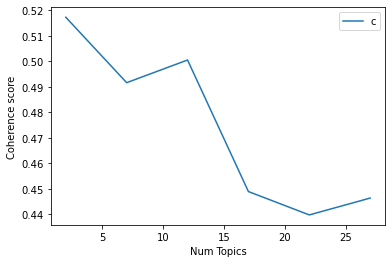

In [39]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [40]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.5172
index: 1 | Num Topics = 7  has Coherence Value of 0.4916
index: 2 | Num Topics = 12  has Coherence Value of 0.5005
index: 3 | Num Topics = 17  has Coherence Value of 0.449
index: 4 | Num Topics = 22  has Coherence Value of 0.4398
index: 5 | Num Topics = 27  has Coherence Value of 0.4464


In [123]:
# Select optimal number of topics
optimal_model_us = model_list_us[0]

In [124]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us = pyLDAvis.gensim_models.prepare(optimal_model_us, corpus_us, id2word_us)

In [125]:
print("pyLDAVis for overall us topics:")
vis_us

pyLDAVis for overall us topics:


PreparedData(topic_coordinates=             x    y  topics  cluster       Freq
topic                                          
1      0.12768  0.0       1        1  53.166764
0     -0.12768  0.0       2        1  46.833236, topic_info=         Term        Freq       Total Category  logprob  loglift
230       add  315.000000  315.000000  Default  30.0000  30.0000
374     sound  287.000000  287.000000  Default  29.0000  29.0000
216       tok  257.000000  257.000000  Default  28.0000  28.0000
251   comment  226.000000  226.000000  Default  27.0000  27.0000
30       vine  342.000000  342.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
91     tiktok  197.140929  810.765752   Topic2  -4.2706  -0.6555
135    people  141.174188  439.011421   Topic2  -4.6046  -0.3760
339      post   83.174726  150.119098   Topic2  -5.1336   0.1681
54   download   66.953224  136.311757   Topic2  -5.3506   0.0476
313     still   61.876435   92.010110   Topic2  -5.4294   0.3618

[141 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
475       1  0.994531  ability
248       1  0.934474     able
248       2  0.066383     able
299       1  0.326788  account
299       2  0.674001  account
...     ...       ...      ...
211       2  0.083533     wish
92        1  0.013882     work
92        2  0.992593     work
53        1  0.024268     year
53        2  0.995008     year

[193 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [44]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_us_score1 = clash_ios_us_review_YearMonth_score1.review.values.tolist()
review_words_us_score1 = list(sent_to_words(review_us_score1))
print(review_words_us_score1[:1])

[['way', 'better', 'then', 'tiktok', 'and', 'love', 'that', 'this', 'is', 'from', 'the', 'creators', 'of', 'vine', 'love', 'they', 'took', 'some', 'of', 'the', 'old', 'features', 'from', 'vine', 'and', 'put', 'it', 'into', 'this', 'app', 'keep', 'up', 'the', 'good', 'work']]


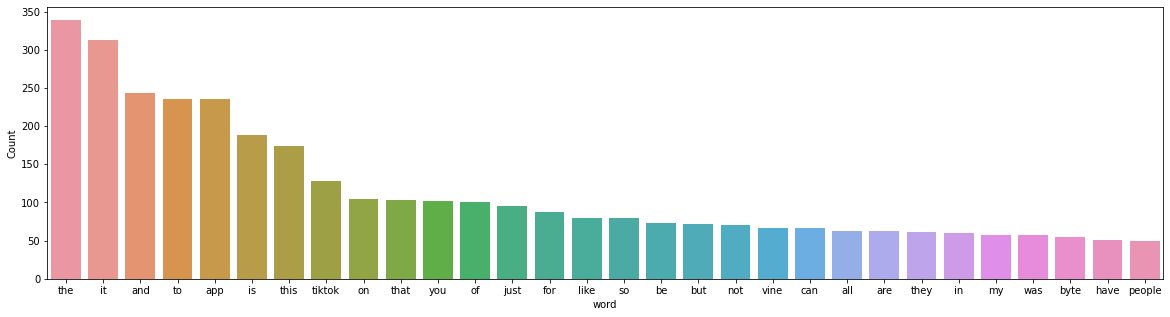

In [45]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score1))

In [46]:
# Clean text
review_us_ready_score1 = process_words(review_words_us_score1)  # processed Text Data! - move to each section


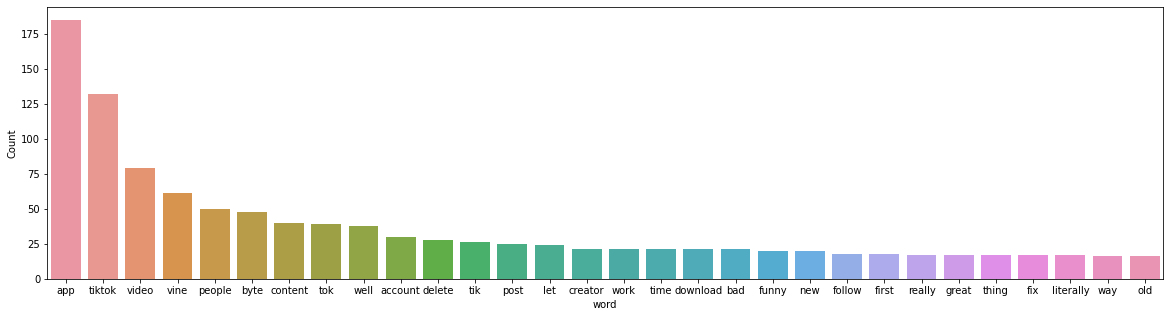

In [47]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score1))


In [48]:
# Create Dictionary
id2word_us_score1 = corpora.Dictionary(review_us_ready_score1)

2021-10-16 01:36:08,275 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 01:36:08,287 [INFO] gensim.corpora.dictionary - built Dictionary(905 unique tokens: ['creator', 'feature', 'keep', 'love', 'old']...) from 279 documents (total 3196 corpus positions)
2021-10-16 01:36:08,289 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(905 unique tokens: ['creator', 'feature', 'keep', 'love', 'old']...) from 279 documents (total 3196 corpus positions)", 'datetime': '2021-10-16T01:36:08.289067', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [49]:
# Create Corpus: Term Document Frequency
corpus_us_score1 = [id2word_us_score1.doc2bow(text) for text in review_us_ready_score1]

In [50]:
# Training LDA model
model_list_us_score1, coherence_values_us_score1 = compute_coherence_values(dictionary=id2word_us_score1, corpus=corpus_us_score1, 
                                                              texts=review_us_ready_score1, limit=30, start=2, step=5)


2021-10-16 01:36:08,313 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 01:36:08,315 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 01:36:08,319 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:36:08,321 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 279 documents, updating model once every 279 documents, evaluating perplexity every 279 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:36:09,404 [INFO] gensim.models.ldamodel - -7.436 per-word bound, 173.2 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:36:09,406 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #279/279
2021-10-16 01:36:10,229 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"app" + 0.021*"tiktok" + 0.021*"video" + 0.018*"vine" + 0.013*"people" + 0.012*"byte" + 0.011*"wel

2021-10-16 01:36:18,163 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.054*"tiktok" + 0.033*"app" + 0.020*"tok" + 0.015*"people" + 0.014*"tik" + 0.014*"video" + 0.014*"vine" + 0.012*"content" + 0.011*"well" + 0.009*"follow"
2021-10-16 01:36:18,165 [INFO] gensim.models.ldamodel - topic diff=0.013005, rho=0.301511
2021-10-16 01:36:18,550 [INFO] gensim.models.ldamodel - -6.316 per-word bound, 79.7 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:36:18,551 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #279/279
2021-10-16 01:36:18,915 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.055*"app" + 0.024*"video" + 0.016*"vine" + 0.016*"byte" + 0.015*"tiktok" + 0.011*"delete" + 0.010*"people" + 0.009*"account" + 0.008*"work" + 0.008*"time"
2021-10-16 01:36:18,917 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.055*"tiktok" + 0.034*"app" + 0.020*"tok" + 0.015*"people" + 0.014*"tik" + 0.014*"video" + 0.014*"vine" + 0.012*"co

2021-10-16 01:36:26,660 [INFO] gensim.models.ldamodel - topic diff=0.005198, rho=0.218218
2021-10-16 01:36:27,067 [INFO] gensim.models.ldamodel - -6.310 per-word bound, 79.3 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:36:27,069 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #279/279
2021-10-16 01:36:27,404 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.054*"app" + 0.025*"video" + 0.016*"vine" + 0.015*"byte" + 0.014*"tiktok" + 0.012*"delete" + 0.010*"account" + 0.010*"people" + 0.009*"time" + 0.008*"work"
2021-10-16 01:36:27,406 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.056*"tiktok" + 0.034*"app" + 0.021*"tok" + 0.016*"people" + 0.015*"tik" + 0.014*"vine" + 0.013*"video" + 0.013*"content" + 0.012*"well" + 0.009*"follow"
2021-10-16 01:36:27,407 [INFO] gensim.models.ldamodel - topic diff=0.004949, rho=0.213201
2021-10-16 01:36:27,897 [INFO] gensim.models.ldamodel - -6.310 per-word bound, 79.3 perplexity estim

2021-10-16 01:36:34,909 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #279/279
2021-10-16 01:36:35,167 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.054*"app" + 0.025*"video" + 0.016*"vine" + 0.015*"byte" + 0.013*"tiktok" + 0.012*"delete" + 0.010*"account" + 0.009*"people" + 0.009*"time" + 0.009*"work"
2021-10-16 01:36:35,169 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.057*"tiktok" + 0.034*"app" + 0.021*"tok" + 0.017*"people" + 0.015*"tik" + 0.014*"vine" + 0.013*"content" + 0.012*"video" + 0.012*"well" + 0.009*"follow"
2021-10-16 01:36:35,170 [INFO] gensim.models.ldamodel - topic diff=0.003421, rho=0.176777
2021-10-16 01:36:35,760 [INFO] gensim.models.ldamodel - -6.307 per-word bound, 79.2 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:36:35,762 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #279/279
2021-10-16 01:36:36,073 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.054*"app" + 0.025*

2021-10-16 01:36:43,386 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.054*"app" + 0.025*"video" + 0.016*"vine" + 0.015*"byte" + 0.013*"tiktok" + 0.012*"delete" + 0.010*"account" + 0.009*"people" + 0.009*"time" + 0.009*"work"
2021-10-16 01:36:43,388 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.058*"tiktok" + 0.035*"app" + 0.022*"tok" + 0.017*"people" + 0.015*"tik" + 0.014*"vine" + 0.013*"content" + 0.012*"well" + 0.012*"video" + 0.010*"follow"
2021-10-16 01:36:43,390 [INFO] gensim.models.ldamodel - topic diff=0.002876, rho=0.154303
2021-10-16 01:36:43,923 [INFO] gensim.models.ldamodel - -6.304 per-word bound, 79.0 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:36:43,924 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #279/279
2021-10-16 01:36:44,234 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.053*"app" + 0.025*"video" + 0.016*"vine" + 0.015*"byte" + 0.013*"tiktok" + 0.012*"delete" + 0.010*"account" + 0.00

2021-10-16 01:36:50,122 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 01:36:54,414 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 01:36:54,469 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 237 virtual documents
2021-10-16 01:36:54,864 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 01:36:54,868 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 01:36:54,886 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:36:54,895 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 279 documents, updating model once every 279 documents, evaluating perplexity every 279 documents, iterating 50x with a con

2021-10-16 01:36:59,327 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"app" + 0.030*"tiktok" + 0.020*"vine" + 0.020*"video" + 0.015*"content" + 0.015*"bad" + 0.013*"back" + 0.012*"time" + 0.011*"error" + 0.010*"creator"
2021-10-16 01:36:59,328 [INFO] gensim.models.ldamodel - topic diff=0.060885, rho=0.408248
2021-10-16 01:36:59,899 [INFO] gensim.models.ldamodel - -6.619 per-word bound, 98.3 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:36:59,906 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #279/279
2021-10-16 01:37:00,301 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.069*"app" + 0.051*"tiktok" + 0.027*"people" + 0.027*"tok" + 0.020*"tik" + 0.017*"byte" + 0.014*"content" + 0.014*"video" + 0.013*"follow" + 0.012*"well"
2021-10-16 01:37:00,302 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.048*"app" + 0.030*"tiktok" + 0.020*"vine" + 0.020*"video" + 0.015*"content" + 0.014*"bad" + 0.013*"back" + 0.012*"ti

2021-10-16 01:37:04,476 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.059*"tiktok" + 0.028*"app" + 0.021*"video" + 0.019*"vine" + 0.013*"sign" + 0.012*"account" + 0.012*"content" + 0.012*"literally" + 0.011*"byte" + 0.011*"ban"
2021-10-16 01:37:04,483 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.060*"app" + 0.025*"video" + 0.024*"tiktok" + 0.020*"byte" + 0.017*"well" + 0.016*"load" + 0.015*"account" + 0.012*"kid" + 0.012*"first" + 0.011*"delete"
2021-10-16 01:37:04,485 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"app" + 0.027*"video" + 0.022*"vine" + 0.016*"old" + 0.013*"work" + 0.012*"download" + 0.012*"byte" + 0.012*"account" + 0.011*"keep" + 0.011*"year"
2021-10-16 01:37:04,486 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"let" + 0.023*"people" + 0.022*"video" + 0.022*"tiktok" + 0.018*"vine" + 0.018*"sound" + 0.013*"second" + 0.011*"start" + 0.011*"record" + 0.011*"account"
2021-10-16 01:37:04,488 [INFO] gensim.models.ldamodel - topic diff=0.01216

2021-10-16 01:37:08,078 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.068*"app" + 0.046*"tiktok" + 0.029*"tok" + 0.028*"people" + 0.022*"tik" + 0.018*"byte" + 0.014*"content" + 0.013*"video" + 0.013*"follow" + 0.013*"well"
2021-10-16 01:37:08,081 [INFO] gensim.models.ldamodel - topic diff=0.004571, rho=0.242536
2021-10-16 01:37:08,397 [INFO] gensim.models.ldamodel - -6.594 per-word bound, 96.6 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:37:08,399 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #279/279
2021-10-16 01:37:08,667 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.015*"vine" + 0.015*"app" + 0.010*"sound" + 0.010*"way" + 0.010*"account" + 0.010*"tok" + 0.010*"complete" + 0.010*"garbage" + 0.010*"meme" + 0.006*"copy"
2021-10-16 01:37:08,670 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"app" + 0.029*"tiktok" + 0.021*"video" + 0.021*"vine" + 0.016*"content" + 0.015*"back" + 0.014*"bad" + 0.012*"t

2021-10-16 01:37:11,918 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.066*"tiktok" + 0.028*"app" + 0.022*"video" + 0.019*"vine" + 0.013*"sign" + 0.012*"literally" + 0.012*"content" + 0.012*"account" + 0.011*"ban" + 0.010*"byte"
2021-10-16 01:37:11,919 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"app" + 0.028*"tiktok" + 0.021*"video" + 0.021*"vine" + 0.016*"content" + 0.015*"back" + 0.014*"bad" + 0.012*"time" + 0.012*"well" + 0.011*"error"
2021-10-16 01:37:11,920 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.068*"app" + 0.046*"tiktok" + 0.029*"tok" + 0.028*"people" + 0.022*"tik" + 0.018*"byte" + 0.014*"content" + 0.013*"video" + 0.013*"follow" + 0.013*"well"
2021-10-16 01:37:11,922 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"app" + 0.027*"video" + 0.022*"vine" + 0.016*"old" + 0.013*"work" + 0.013*"byte" + 0.013*"download" + 0.013*"account" + 0.011*"keep" + 0.011*"year"
2021-10-16 01:37:11,925 [INFO] gensim.models.ldamodel - topic diff=0.001924, rho=0

2021-10-16 01:37:15,069 [INFO] gensim.models.ldamodel - topic diff=0.001054, rho=0.188982
2021-10-16 01:37:15,463 [INFO] gensim.models.ldamodel - -6.591 per-word bound, 96.4 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:37:15,464 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #279/279
2021-10-16 01:37:15,696 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"app" + 0.028*"tiktok" + 0.021*"video" + 0.021*"vine" + 0.016*"content" + 0.016*"back" + 0.014*"bad" + 0.012*"time" + 0.012*"well" + 0.011*"error"
2021-10-16 01:37:15,701 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"app" + 0.027*"video" + 0.022*"vine" + 0.016*"old" + 0.013*"byte" + 0.013*"account" + 0.013*"download" + 0.013*"work" + 0.011*"new" + 0.011*"keep"
2021-10-16 01:37:15,704 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.068*"app" + 0.045*"tiktok" + 0.029*"tok" + 0.028*"people" + 0.022*"tik" + 0.018*"byte" + 0.014*"content" + 0.013*"video"

2021-10-16 01:37:18,505 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"let" + 0.023*"people" + 0.022*"video" + 0.021*"tiktok" + 0.019*"sound" + 0.018*"vine" + 0.013*"second" + 0.011*"bad" + 0.011*"die" + 0.011*"start"
2021-10-16 01:37:18,507 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"app" + 0.028*"tiktok" + 0.021*"video" + 0.021*"vine" + 0.016*"content" + 0.016*"back" + 0.014*"bad" + 0.012*"time" + 0.012*"well" + 0.011*"error"
2021-10-16 01:37:18,510 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.015*"vine" + 0.015*"app" + 0.010*"way" + 0.010*"account" + 0.010*"tok" + 0.010*"sound" + 0.010*"complete" + 0.010*"garbage" + 0.010*"meme" + 0.006*"copy"
2021-10-16 01:37:18,512 [INFO] gensim.models.ldamodel - topic diff=0.000605, rho=0.171499
2021-10-16 01:37:18,790 [INFO] gensim.models.ldamodel - -6.591 per-word bound, 96.4 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:37:18,791 [INFO] gensim.models.ldamodel - PROGR

2021-10-16 01:37:21,648 [INFO] gensim.models.ldamodel - -6.591 per-word bound, 96.4 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:37:21,650 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #279/279
2021-10-16 01:37:21,842 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"app" + 0.028*"video" + 0.022*"vine" + 0.016*"old" + 0.013*"byte" + 0.013*"account" + 0.013*"download" + 0.012*"work" + 0.011*"new" + 0.011*"keep"
2021-10-16 01:37:21,843 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"app" + 0.028*"tiktok" + 0.021*"video" + 0.021*"vine" + 0.016*"content" + 0.016*"back" + 0.014*"bad" + 0.012*"time" + 0.012*"well" + 0.011*"error"
2021-10-16 01:37:21,845 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.068*"tiktok" + 0.028*"app" + 0.022*"video" + 0.019*"vine" + 0.013*"sign" + 0.013*"literally" + 0.012*"account" + 0.011*"content" + 0.011*"ban" + 0.009*"byte"
2021-10-16 01:37:21,847 [INFO] gensim.models.ldamode

2021-10-16 01:37:24,761 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"let" + 0.023*"people" + 0.022*"video" + 0.021*"tiktok" + 0.019*"sound" + 0.018*"vine" + 0.013*"second" + 0.011*"bad" + 0.011*"die" + 0.011*"start"
2021-10-16 01:37:24,764 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.049*"app" + 0.028*"tiktok" + 0.021*"video" + 0.021*"vine" + 0.016*"content" + 0.016*"back" + 0.014*"bad" + 0.012*"time" + 0.012*"well" + 0.011*"error"
2021-10-16 01:37:24,767 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"app" + 0.028*"video" + 0.022*"vine" + 0.016*"old" + 0.013*"byte" + 0.013*"account" + 0.013*"download" + 0.012*"work" + 0.011*"new" + 0.011*"keep"
2021-10-16 01:37:24,769 [INFO] gensim.models.ldamodel - topic diff=0.000272, rho=0.149071
2021-10-16 01:37:25,125 [INFO] gensim.models.ldamodel - -6.591 per-word bound, 96.4 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:37:25,150 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-16 01:37:28,124 [INFO] gensim.models.ldamodel - -6.590 per-word bound, 96.4 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:37:28,126 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #279/279
2021-10-16 01:37:28,414 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"let" + 0.023*"people" + 0.022*"video" + 0.021*"tiktok" + 0.019*"sound" + 0.018*"vine" + 0.013*"second" + 0.011*"bad" + 0.011*"die" + 0.011*"start"
2021-10-16 01:37:28,416 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.015*"vine" + 0.015*"app" + 0.010*"way" + 0.010*"account" + 0.010*"tok" + 0.010*"complete" + 0.010*"sound" + 0.010*"garbage" + 0.010*"meme" + 0.006*"copy"
2021-10-16 01:37:28,421 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.059*"app" + 0.025*"video" + 0.024*"tiktok" + 0.021*"byte" + 0.018*"well" + 0.017*"load" + 0.015*"account" + 0.012*"kid" + 0.012*"first" + 0.011*"delete"
2021-10-16 01:37:28,424 [INFO] gensim.models.ldamodel

2021-10-16 01:37:37,667 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"app" + 0.025*"video" + 0.019*"work" + 0.018*"byte" + 0.017*"tiktok" + 0.015*"first" + 0.015*"look" + 0.014*"people" + 0.013*"vine" + 0.012*"error"
2021-10-16 01:37:37,669 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.022*"vine" + 0.021*"delete" + 0.015*"sell" + 0.013*"grow" + 0.011*"follower" + 0.009*"app" + 0.008*"byte" + 0.008*"beta" + 0.008*"new" + 0.008*"follow"
2021-10-16 01:37:37,670 [INFO] gensim.models.ldamodel - topic diff=0.118166, rho=0.447214
2021-10-16 01:37:38,205 [INFO] gensim.models.ldamodel - -6.798 per-word bound, 111.2 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:37:38,206 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #279/279
2021-10-16 01:37:38,439 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.078*"tiktok" + 0.029*"vine" + 0.024*"app" + 0.019*"content" + 0.018*"video" + 0.015*"ban" + 0.013*"apple" + 0.012*"sig

2021-10-16 01:37:40,942 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #279/279
2021-10-16 01:37:41,156 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.064*"app" + 0.032*"video" + 0.023*"well" + 0.019*"load" + 0.019*"thing" + 0.019*"tiktok" + 0.015*"people" + 0.013*"fix" + 0.013*"way" + 0.012*"user"
2021-10-16 01:37:41,157 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.068*"account" + 0.023*"spam" + 0.016*"fix" + 0.016*"video" + 0.008*"delete" + 0.008*"sign" + 0.008*"work" + 0.008*"absolutely" + 0.008*"weird" + 0.008*"check"
2021-10-16 01:37:41,158 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.043*"tiktok" + 0.028*"vine" + 0.028*"boring" + 0.028*"byte" + 0.024*"well" + 0.021*"funny" + 0.017*"joke" + 0.017*"hard" + 0.012*"app" + 0.012*"vid"
2021-10-16 01:37:41,159 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.022*"vine" + 0.021*"delete" + 0.015*"sell" + 0.015*"grow" + 0.015*"follower" + 0.008*"byte" + 0.008*"beta" + 0.008*"new" + 0.008*"follow" + 0.0

2021-10-16 01:37:43,655 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"tiktok" + 0.034*"byte" + 0.028*"vine" + 0.028*"boring" + 0.022*"funny" + 0.020*"well" + 0.017*"joke" + 0.017*"hard" + 0.012*"app" + 0.012*"vid"
2021-10-16 01:37:43,656 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"app" + 0.026*"video" + 0.022*"work" + 0.018*"byte" + 0.016*"first" + 0.016*"look" + 0.014*"people" + 0.013*"error" + 0.012*"vine" + 0.012*"tiktok"
2021-10-16 01:37:43,657 [INFO] gensim.models.ldamodel - topic diff=0.006769, rho=0.250000
2021-10-16 01:37:44,037 [INFO] gensim.models.ldamodel - -6.745 per-word bound, 107.3 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:37:44,038 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #279/279
2021-10-16 01:37:44,261 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.035*"app" + 0.031*"tiktok" + 0.027*"video" + 0.025*"byte" + 0.021*"vine" + 0.019*"back" + 0.017*"delete" + 0.015*"accou

2021-10-16 01:37:47,211 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #279/279
2021-10-16 01:37:47,423 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.068*"account" + 0.023*"spam" + 0.016*"fix" + 0.016*"video" + 0.015*"absolutely" + 0.008*"delete" + 0.008*"sign" + 0.008*"work" + 0.008*"weird" + 0.008*"minute"
2021-10-16 01:37:47,427 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.086*"tiktok" + 0.030*"vine" + 0.025*"app" + 0.020*"content" + 0.017*"video" + 0.016*"apple" + 0.016*"ban" + 0.015*"sign" + 0.011*"create" + 0.011*"literally"
2021-10-16 01:37:47,429 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.044*"tiktok" + 0.030*"video" + 0.024*"vine" + 0.019*"let" + 0.016*"little" + 0.016*"die" + 0.015*"people" + 0.012*"second" + 0.012*"ugly" + 0.012*"feature"
2021-10-16 01:37:47,433 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"tiktok" + 0.037*"byte" + 0.028*"vine" + 0.028*"boring" + 0.022*"funny" + 0.019*"well" + 0.017*"joke" + 0.017*"hard" + 0.

2021-10-16 01:37:50,378 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.086*"tiktok" + 0.030*"vine" + 0.025*"app" + 0.020*"content" + 0.017*"video" + 0.016*"apple" + 0.016*"ban" + 0.015*"sign" + 0.011*"create" + 0.011*"literally"
2021-10-16 01:37:50,382 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"app" + 0.026*"video" + 0.023*"work" + 0.018*"byte" + 0.016*"first" + 0.016*"look" + 0.014*"people" + 0.013*"error" + 0.012*"vine" + 0.012*"tiktok"
2021-10-16 01:37:50,386 [INFO] gensim.models.ldamodel - topic diff=0.001399, rho=0.192450
2021-10-16 01:37:50,682 [INFO] gensim.models.ldamodel - -6.740 per-word bound, 106.9 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:37:50,685 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #279/279
2021-10-16 01:37:50,924 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"tiktok" + 0.037*"byte" + 0.028*"vine" + 0.028*"boring" + 0.022*"funny" + 0.019*"well" + 0.017*"joke" + 0.

2021-10-16 01:37:53,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #279/279
2021-10-16 01:37:53,913 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"tiktok" + 0.038*"byte" + 0.028*"vine" + 0.028*"boring" + 0.022*"funny" + 0.019*"well" + 0.017*"joke" + 0.017*"hard" + 0.012*"app" + 0.011*"play"
2021-10-16 01:37:53,915 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"people" + 0.042*"app" + 0.042*"let" + 0.027*"account" + 0.023*"follow" + 0.019*"tiktok" + 0.019*"content" + 0.019*"email" + 0.019*"bad" + 0.012*"boring"
2021-10-16 01:37:53,917 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.086*"tiktok" + 0.030*"vine" + 0.025*"app" + 0.020*"content" + 0.017*"video" + 0.016*"apple" + 0.016*"ban" + 0.015*"sign" + 0.011*"create" + 0.011*"literally"
2021-10-16 01:37:53,918 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.035*"app" + 0.031*"tiktok" + 0.026*"video" + 0.025*"byte" + 0.021*"vine" + 0.019*"back" + 0.018*"delete" + 0.015*"account" + 0.012*"

2021-10-16 01:37:56,868 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.074*"app" + 0.044*"tiktok" + 0.029*"tok" + 0.024*"tik" + 0.022*"people" + 0.016*"video" + 0.015*"byte" + 0.013*"post" + 0.013*"well" + 0.012*"content"
2021-10-16 01:37:56,874 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.023*"vine" + 0.016*"sell" + 0.016*"grow" + 0.016*"follower" + 0.013*"delete" + 0.008*"old" + 0.008*"version" + 0.008*"back" + 0.008*"beta" + 0.008*"star"
2021-10-16 01:37:56,875 [INFO] gensim.models.ldamodel - topic diff=0.000579, rho=0.162221
2021-10-16 01:37:57,188 [INFO] gensim.models.ldamodel - -6.738 per-word bound, 106.7 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:37:57,189 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #279/279
2021-10-16 01:37:57,370 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.067*"account" + 0.023*"spam" + 0.016*"video" + 0.016*"fix" + 0.016*"absolutely" + 0.008*"full" + 0.008*"delete" + 0.

2021-10-16 01:38:00,198 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #279/279
2021-10-16 01:38:00,420 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.074*"app" + 0.044*"tiktok" + 0.029*"tok" + 0.024*"tik" + 0.022*"people" + 0.016*"video" + 0.015*"byte" + 0.013*"post" + 0.013*"well" + 0.012*"content"
2021-10-16 01:38:00,422 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.027*"complete" + 0.018*"way" + 0.018*"garbage" + 0.018*"app" + 0.018*"sound" + 0.009*"literally" + 0.009*"tok" + 0.009*"slow" + 0.009*"layout" + 0.009*"place"
2021-10-16 01:38:00,426 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.056*"app" + 0.026*"video" + 0.022*"time" + 0.017*"content" + 0.015*"well" + 0.015*"vine" + 0.014*"tiktok" + 0.012*"error" + 0.012*"ever" + 0.012*"second"
2021-10-16 01:38:00,428 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.064*"app" + 0.032*"video" + 0.031*"well" + 0.023*"load" + 0.020*"tiktok" + 0.020*"thing" + 0.013*"fix" + 0.013*"way" + 0.013*"user" + 0.

2021-10-16 01:38:03,739 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.023*"vine" + 0.016*"sell" + 0.016*"grow" + 0.016*"follower" + 0.011*"delete" + 0.008*"old" + 0.008*"version" + 0.008*"back" + 0.008*"star" + 0.008*"rate"
2021-10-16 01:38:03,741 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"tiktok" + 0.038*"byte" + 0.028*"vine" + 0.028*"boring" + 0.022*"funny" + 0.019*"well" + 0.017*"joke" + 0.017*"hard" + 0.012*"app" + 0.011*"play"
2021-10-16 01:38:03,742 [INFO] gensim.models.ldamodel - topic diff=0.000237, rho=0.142857
2021-10-16 01:38:04,065 [INFO] gensim.models.ldamodel - -6.737 per-word bound, 106.7 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:04,066 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #279/279
2021-10-16 01:38:04,409 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.035*"app" + 0.031*"tiktok" + 0.026*"video" + 0.025*"byte" + 0.021*"vine" + 0.019*"back" + 0.019*"delete" + 0.015*"ac

2021-10-16 01:38:13,841 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.072*"app" + 0.034*"people" + 0.029*"video" + 0.025*"tiktok" + 0.020*"first" + 0.016*"well" + 0.013*"keep" + 0.013*"terrible" + 0.011*"cringe" + 0.011*"thing"
2021-10-16 01:38:13,843 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.026*"keep" + 0.026*"video" + 0.026*"vine" + 0.013*"touch" + 0.013*"problem" + 0.013*"server" + 0.013*"forever" + 0.013*"sign" + 0.013*"lag" + 0.013*"former"
2021-10-16 01:38:13,846 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.049*"tiktok" + 0.044*"app" + 0.021*"content" + 0.019*"time" + 0.018*"vine" + 0.015*"really" + 0.015*"fun" + 0.015*"work" + 0.015*"error" + 0.012*"great"
2021-10-16 01:38:13,848 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.044*"app" + 0.042*"video" + 0.029*"byte" + 0.022*"vine" + 0.015*"option" + 0.015*"look" + 0.014*"tiktok" + 0.011*"new" + 0.011*"feature" + 0.011*"creator"
2021-10-16 01:38:13,850 [INFO] gensim.models.ldamodel - topic #4 (0.059):

2021-10-16 01:38:16,567 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.048*"tiktok" + 0.034*"vine" + 0.028*"well" + 0.023*"funny" + 0.019*"app" + 0.017*"boring" + 0.017*"guy" + 0.017*"joke" + 0.017*"content" + 0.017*"day"
2021-10-16 01:38:16,568 [INFO] gensim.models.ldamodel - topic diff=0.032553, rho=0.333333
2021-10-16 01:38:16,913 [INFO] gensim.models.ldamodel - -6.876 per-word bound, 117.5 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:16,915 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #279/279
2021-10-16 01:38:17,081 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.059*"app" + 0.025*"bad" + 0.020*"video" + 0.019*"tiktok" + 0.018*"well" + 0.015*"vine" + 0.015*"sign" + 0.012*"account" + 0.012*"new" + 0.012*"delete"
2021-10-16 01:38:17,083 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.066*"tiktok" + 0.041*"app" + 0.035*"video" + 0.026*"literally" + 0.026*"account" + 0.018*"post" + 0.017*"spam" + 0.013

2021-10-16 01:38:19,798 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.062*"tiktok" + 0.050*"back" + 0.036*"sound" + 0.029*"bring" + 0.027*"bad" + 0.025*"vine" + 0.021*"account" + 0.018*"trash" + 0.015*"byte" + 0.015*"funny"
2021-10-16 01:38:19,799 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.065*"tiktok" + 0.046*"app" + 0.022*"content" + 0.018*"time" + 0.018*"vine" + 0.015*"really" + 0.015*"fun" + 0.015*"work" + 0.015*"error" + 0.014*"ban"
2021-10-16 01:38:19,800 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.059*"app" + 0.024*"bad" + 0.021*"video" + 0.019*"tiktok" + 0.018*"well" + 0.015*"sign" + 0.014*"vine" + 0.012*"account" + 0.012*"new" + 0.012*"delete"
2021-10-16 01:38:19,802 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.054*"app" + 0.041*"follow" + 0.036*"tiktok" + 0.032*"people" + 0.024*"account" + 0.018*"tok" + 0.014*"content" + 0.014*"video" + 0.014*"bad" + 0.014*"tik"
2021-10-16 01:38:19,802 [INFO] gensim.models.ldamodel - topic diff=0.007009, rho=0

2021-10-16 01:38:22,536 [INFO] gensim.models.ldamodel - topic diff=0.002748, rho=0.223607
2021-10-16 01:38:22,910 [INFO] gensim.models.ldamodel - -6.864 per-word bound, 116.5 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:22,911 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #279/279
2021-10-16 01:38:23,135 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.053*"let" + 0.036*"tiktok" + 0.036*"people" + 0.027*"video" + 0.019*"app" + 0.018*"die" + 0.018*"reason" + 0.016*"vine" + 0.014*"hard" + 0.014*"second"
2021-10-16 01:38:23,140 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.023*"vine" + 0.023*"delete" + 0.023*"always" + 0.023*"screen" + 0.015*"old" + 0.015*"require" + 0.015*"option" + 0.008*"app" + 0.008*"never" + 0.008*"compare"
2021-10-16 01:38:23,145 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.031*"app" + 0.022*"tiktok" + 0.022*"byte" + 0.022*"work" + 0.022*"literally" + 0.022*"tok" + 0.021*"tik" + 0.

2021-10-16 01:38:25,996 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.070*"app" + 0.041*"people" + 0.031*"video" + 0.026*"tiktok" + 0.025*"first" + 0.016*"well" + 0.015*"keep" + 0.015*"terrible" + 0.011*"cringe" + 0.011*"lame"
2021-10-16 01:38:25,999 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.043*"app" + 0.022*"content" + 0.022*"vine" + 0.016*"create" + 0.016*"creator" + 0.016*"tok" + 0.016*"video" + 0.016*"way" + 0.016*"fix" + 0.011*"let"
2021-10-16 01:38:26,000 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.037*"video" + 0.033*"app" + 0.023*"tiktok" + 0.023*"vine" + 0.020*"byte" + 0.013*"old" + 0.013*"kid" + 0.010*"issue" + 0.010*"post" + 0.010*"new"
2021-10-16 01:38:26,001 [INFO] gensim.models.ldamodel - topic diff=0.001669, rho=0.196116
2021-10-16 01:38:26,298 [INFO] gensim.models.ldamodel - -6.864 per-word bound, 116.4 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:26,308 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-16 01:38:29,155 [INFO] gensim.models.ldamodel - -6.862 per-word bound, 116.4 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:29,158 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #279/279
2021-10-16 01:38:29,335 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.075*"app" + 0.043*"tiktok" + 0.024*"tok" + 0.022*"people" + 0.019*"video" + 0.018*"well" + 0.017*"post" + 0.017*"content" + 0.017*"tik" + 0.015*"byte"
2021-10-16 01:38:29,338 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.046*"camera" + 0.033*"roll" + 0.026*"fix" + 0.026*"time" + 0.026*"upload" + 0.020*"app" + 0.020*"dumb" + 0.017*"video" + 0.013*"user" + 0.013*"zebra"
2021-10-16 01:38:29,341 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.027*"vine" + 0.027*"keep" + 0.019*"video" + 0.014*"error" + 0.014*"sign" + 0.014*"waste" + 0.014*"server" + 0.014*"storage" + 0.014*"problem" + 0.014*"sayibg"
2021-10-16 01:38:29,343 [INFO] gensim.models.ldamo

2021-10-16 01:38:32,293 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.031*"app" + 0.023*"tok" + 0.022*"tiktok" + 0.022*"byte" + 0.022*"work" + 0.022*"literally" + 0.021*"tik" + 0.017*"delete" + 0.017*"apple" + 0.017*"log"
2021-10-16 01:38:32,296 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.077*"tiktok" + 0.048*"back" + 0.037*"bad" + 0.036*"vine" + 0.035*"sound" + 0.028*"bring" + 0.021*"trash" + 0.019*"account" + 0.015*"byte" + 0.015*"funny"
2021-10-16 01:38:32,298 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"tiktok" + 0.029*"vine" + 0.028*"well" + 0.022*"funny" + 0.021*"app" + 0.017*"boring" + 0.017*"joke" + 0.017*"guy" + 0.017*"content" + 0.017*"day"
2021-10-16 01:38:32,299 [INFO] gensim.models.ldamodel - topic diff=0.000380, rho=0.164399
2021-10-16 01:38:32,676 [INFO] gensim.models.ldamodel - -6.862 per-word bound, 116.3 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:32,677 [INFO] gensim.models.ldamodel - P

2021-10-16 01:38:35,461 [INFO] gensim.models.ldamodel - -6.862 per-word bound, 116.3 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:35,462 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #279/279
2021-10-16 01:38:35,698 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.056*"tiktok" + 0.042*"app" + 0.035*"video" + 0.030*"account" + 0.026*"literally" + 0.018*"post" + 0.018*"spam" + 0.013*"hard" + 0.013*"create" + 0.013*"first"
2021-10-16 01:38:35,708 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.043*"app" + 0.022*"content" + 0.022*"vine" + 0.016*"create" + 0.016*"creator" + 0.016*"tok" + 0.016*"video" + 0.016*"way" + 0.016*"fix" + 0.011*"let"
2021-10-16 01:38:35,713 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.045*"tiktok" + 0.035*"app" + 0.034*"copy" + 0.017*"meme" + 0.017*"stupid" + 0.017*"second" + 0.017*"year" + 0.017*"profile" + 0.016*"old" + 0.013*"byte"
2021-10-16 01:38:35,715 [INFO] gensim.models.lda

2021-10-16 01:38:38,800 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.054*"app" + 0.041*"follow" + 0.036*"tiktok" + 0.032*"people" + 0.023*"account" + 0.018*"tok" + 0.014*"content" + 0.014*"video" + 0.014*"bad" + 0.014*"tik"
2021-10-16 01:38:38,802 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.046*"camera" + 0.033*"roll" + 0.026*"time" + 0.026*"fix" + 0.026*"upload" + 0.020*"app" + 0.020*"dumb" + 0.018*"video" + 0.013*"user" + 0.013*"service"
2021-10-16 01:38:38,803 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.045*"tiktok" + 0.035*"app" + 0.034*"copy" + 0.017*"meme" + 0.017*"stupid" + 0.017*"second" + 0.017*"year" + 0.017*"profile" + 0.016*"old" + 0.013*"byte"
2021-10-16 01:38:38,804 [INFO] gensim.models.ldamodel - topic diff=0.000248, rho=0.144338
2021-10-16 01:38:39,178 [INFO] gensim.models.ldamodel - -6.861 per-word bound, 116.3 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:39,180 [INFO] gensim.models.ldamodel 

2021-10-16 01:38:49,044 [INFO] gensim.models.ldamodel - -7.318 per-word bound, 159.6 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:49,045 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #279/279
2021-10-16 01:38:49,269 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.043*"screen" + 0.035*"app" + 0.031*"load" + 0.026*"byte" + 0.017*"forever" + 0.017*"doo" + 0.017*"show" + 0.017*"way" + 0.017*"option" + 0.017*"always"
2021-10-16 01:38:49,272 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.070*"tiktok" + 0.065*"app" + 0.026*"tok" + 0.022*"people" + 0.022*"content" + 0.020*"well" + 0.019*"tik" + 0.016*"byte" + 0.015*"video" + 0.014*"post"
2021-10-16 01:38:49,284 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.029*"app" + 0.023*"content" + 0.017*"profile" + 0.016*"year" + 0.016*"creator" + 0.015*"delete" + 0.012*"tiktok" + 0.010*"byteisoverparty" + 0.009*"number" + 0.009*"joke"
2021-10-16 01:38:49,287 [INFO] gensi

2021-10-16 01:38:52,395 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.033*"app" + 0.025*"content" + 0.017*"profile" + 0.017*"year" + 0.017*"creator" + 0.017*"delete" + 0.016*"tiktok" + 0.009*"byteisoverparty" + 0.009*"number" + 0.009*"joke"
2021-10-16 01:38:52,399 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.043*"video" + 0.027*"byte" + 0.027*"app" + 0.020*"vine" + 0.019*"fix" + 0.017*"tiktok" + 0.016*"time" + 0.016*"new" + 0.016*"old" + 0.015*"reason"
2021-10-16 01:38:52,408 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.078*"app" + 0.031*"look" + 0.027*"video" + 0.018*"create" + 0.017*"new" + 0.014*"tiktok" + 0.014*"vine" + 0.014*"work" + 0.014*"already" + 0.014*"account"
2021-10-16 01:38:52,411 [INFO] gensim.models.ldamodel - topic diff=0.067231, rho=0.353553
2021-10-16 01:38:52,917 [INFO] gensim.models.ldamodel - -6.966 per-word bound, 125.0 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:52,918 [INFO] gensim.model

2021-10-16 01:38:55,816 [INFO] gensim.models.ldamodel - topic diff=0.019549, rho=0.277350
2021-10-16 01:38:56,205 [INFO] gensim.models.ldamodel - -6.935 per-word bound, 122.4 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:38:56,209 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #279/279
2021-10-16 01:38:56,450 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.078*"app" + 0.032*"look" + 0.028*"video" + 0.019*"create" + 0.016*"new" + 0.014*"tiktok" + 0.014*"work" + 0.014*"already" + 0.014*"account" + 0.011*"vine"
2021-10-16 01:38:56,452 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.049*"app" + 0.039*"people" + 0.030*"follow" + 0.030*"vine" + 0.030*"record" + 0.020*"second" + 0.020*"let" + 0.020*"tok" + 0.010*"well" + 0.010*"video"
2021-10-16 01:38:56,455 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.043*"video" + 0.028*"byte" + 0.026*"app" + 0.020*"vine" + 0.019*"fix" + 0.016*"tiktok" + 0.016*"time" + 0.016*"ne

2021-10-16 01:38:59,629 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.075*"sign" + 0.045*"app" + 0.043*"apple" + 0.036*"account" + 0.034*"email" + 0.027*"option" + 0.022*"gmail" + 0.015*"byte" + 0.015*"let" + 0.014*"tiktok"
2021-10-16 01:38:59,632 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.071*"tik" + 0.071*"tok" + 0.060*"sound" + 0.032*"shut" + 0.024*"comment" + 0.016*"app" + 0.016*"tiktok" + 0.012*"audio" + 0.012*"confusing" + 0.012*"mixed"
2021-10-16 01:38:59,634 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.067*"app" + 0.057*"tiktok" + 0.028*"tok" + 0.025*"people" + 0.024*"well" + 0.022*"content" + 0.021*"byte" + 0.019*"tik" + 0.016*"post" + 0.015*"video"
2021-10-16 01:38:59,635 [INFO] gensim.models.ldamodel - topic diff=0.006676, rho=0.229416
2021-10-16 01:39:00,222 [INFO] gensim.models.ldamodel - -6.925 per-word bound, 121.5 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:00,249 [INFO] gensim.models.ldamodel -

2021-10-16 01:39:03,313 [INFO] gensim.models.ldamodel - topic diff=0.003069, rho=0.204124
2021-10-16 01:39:03,680 [INFO] gensim.models.ldamodel - -6.922 per-word bound, 121.3 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:03,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #279/279
2021-10-16 01:39:03,933 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.052*"video" + 0.047*"tiktok" + 0.031*"app" + 0.028*"vine" + 0.019*"account" + 0.019*"spam" + 0.019*"post" + 0.014*"literally" + 0.014*"follow" + 0.014*"second"
2021-10-16 01:39:03,936 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.058*"tiktok" + 0.048*"ban" + 0.039*"kid" + 0.039*"app" + 0.030*"watch" + 0.020*"video" + 0.020*"parent" + 0.020*"social" + 0.020*"call" + 0.010*"vine"
2021-10-16 01:39:03,938 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.037*"app" + 0.024*"content" + 0.024*"delete" + 0.021*"tiktok" + 0.016*"profile" + 0.016*"year" + 0.016*"crea

2021-10-16 01:39:07,507 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.078*"app" + 0.033*"look" + 0.028*"video" + 0.019*"create" + 0.016*"new" + 0.014*"tiktok" + 0.014*"already" + 0.014*"work" + 0.014*"account" + 0.010*"download"
2021-10-16 01:39:07,511 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.036*"app" + 0.032*"tiktok" + 0.025*"account" + 0.018*"well" + 0.018*"people" + 0.018*"video" + 0.018*"byte" + 0.014*"sound" + 0.014*"toxic" + 0.014*"kid"
2021-10-16 01:39:07,514 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.066*"app" + 0.056*"tiktok" + 0.028*"tok" + 0.025*"people" + 0.024*"well" + 0.022*"content" + 0.021*"byte" + 0.019*"tik" + 0.016*"post" + 0.015*"video"
2021-10-16 01:39:07,517 [INFO] gensim.models.ldamodel - topic diff=0.001636, rho=0.182574
2021-10-16 01:39:07,978 [INFO] gensim.models.ldamodel - -6.919 per-word bound, 121.1 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:07,979 [INFO] gensim.models.ldamode

2021-10-16 01:39:10,784 [INFO] gensim.models.ldamodel - topic diff=0.001121, rho=0.169031
2021-10-16 01:39:11,171 [INFO] gensim.models.ldamodel - -6.919 per-word bound, 121.0 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:11,173 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #279/279
2021-10-16 01:39:11,431 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.049*"app" + 0.039*"people" + 0.030*"follow" + 0.030*"vine" + 0.030*"record" + 0.020*"second" + 0.020*"let" + 0.020*"tok" + 0.010*"well" + 0.010*"die"
2021-10-16 01:39:11,433 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.070*"tik" + 0.070*"tok" + 0.058*"sound" + 0.035*"shut" + 0.025*"app" + 0.025*"tiktok" + 0.024*"comment" + 0.012*"audio" + 0.012*"mixed" + 0.012*"audios"
2021-10-16 01:39:11,436 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.043*"video" + 0.027*"byte" + 0.025*"app" + 0.020*"vine" + 0.019*"fix" + 0.016*"new" + 0.016*"time" + 0.016*"old" + 0.

2021-10-16 01:39:14,224 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.048*"people" + 0.030*"app" + 0.027*"video" + 0.024*"tok" + 0.024*"instead" + 0.023*"cool" + 0.016*"watch" + 0.016*"byte" + 0.016*"delete" + 0.016*"feature"
2021-10-16 01:39:14,226 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.037*"app" + 0.024*"content" + 0.024*"delete" + 0.021*"tiktok" + 0.016*"profile" + 0.016*"year" + 0.016*"creator" + 0.016*"let" + 0.016*"stop" + 0.008*"number"
2021-10-16 01:39:14,228 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.067*"tiktok" + 0.054*"ban" + 0.039*"app" + 0.039*"kid" + 0.029*"watch" + 0.020*"video" + 0.020*"parent" + 0.020*"social" + 0.020*"call" + 0.010*"vine"
2021-10-16 01:39:14,229 [INFO] gensim.models.ldamodel - topic diff=0.000783, rho=0.156174
2021-10-16 01:39:14,576 [INFO] gensim.models.ldamodel - -6.918 per-word bound, 120.9 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:14,578 [INFO] gensim.models.ldam

2021-10-16 01:39:16,976 [INFO] gensim.models.ldamodel - topic diff=0.000698, rho=0.147442
2021-10-16 01:39:17,376 [INFO] gensim.models.ldamodel - -6.916 per-word bound, 120.8 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:17,378 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #279/279
2021-10-16 01:39:17,651 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.071*"tiktok" + 0.062*"ban" + 0.039*"app" + 0.038*"kid" + 0.029*"watch" + 0.019*"video" + 0.019*"social" + 0.019*"parent" + 0.019*"call" + 0.010*"vine"
2021-10-16 01:39:17,654 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.082*"app" + 0.020*"thing" + 0.018*"really" + 0.015*"people" + 0.015*"fix" + 0.015*"first" + 0.015*"video" + 0.015*"load" + 0.014*"bore" + 0.013*"delete"
2021-10-16 01:39:17,655 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.037*"app" + 0.024*"content" + 0.024*"delete" + 0.021*"tiktok" + 0.016*"profile" + 0.016*"creator" + 0.016*"year" + 

2021-10-16 01:39:25,190 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 262 virtual documents
2021-10-16 01:39:29,003 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-16 01:39:29,004 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-16 01:39:29,006 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:39:29,012 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 279 documents, updating model once every 279 documents, evaluating perplexity every 279 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:39:29,700 [INFO] gensim.models.ldamodel - -22.355 per-word bound, 5364552.6 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:29,706 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #279/279
2021-10-

2021-10-16 01:39:33,425 [INFO] gensim.models.ldamodel - topic diff=0.143323, rho=0.408248
2021-10-16 01:39:33,803 [INFO] gensim.models.ldamodel - -7.113 per-word bound, 138.4 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:33,804 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #279/279
2021-10-16 01:39:33,969 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.044*"app" + 0.027*"byte" + 0.027*"work" + 0.018*"tiktok" + 0.018*"vine" + 0.018*"account" + 0.018*"literally" + 0.018*"load" + 0.018*"delete" + 0.018*"video"
2021-10-16 01:39:33,971 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.082*"time" + 0.035*"error" + 0.035*"signup" + 0.030*"fix" + 0.028*"dumb" + 0.025*"app" + 0.024*"complete" + 0.024*"great" + 0.024*"experience" + 0.024*"crash"
2021-10-16 01:39:33,974 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.038*"app" + 0.035*"video" + 0.033*"tiktok" + 0.032*"work" + 0.027*"vine" + 0.016*"well" + 0.016*"old" 

2021-10-16 01:39:36,686 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.086*"app" + 0.033*"tiktok" + 0.022*"vine" + 0.021*"tok" + 0.018*"byte" + 0.017*"post" + 0.017*"well" + 0.017*"update" + 0.015*"tik" + 0.015*"people"
2021-10-16 01:39:36,687 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.057*"tok" + 0.054*"song" + 0.053*"byte" + 0.036*"app" + 0.036*"look" + 0.018*"follower" + 0.018*"improvement" + 0.018*"ban" + 0.018*"copy" + 0.018*"call"
2021-10-16 01:39:36,691 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.021*"well" + 0.021*"account" + 0.021*"toxic" + 0.021*"ever" + 0.021*"platform" + 0.021*"beware" + 0.021*"potential" + 0.021*"view" + 0.021*"week" + 0.021*"understand"
2021-10-16 01:39:36,693 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.056*"tiktok" + 0.038*"kid" + 0.031*"app" + 0.026*"video" + 0.025*"vine" + 0.019*"back" + 0.019*"bring" + 0.019*"watch" + 0.019*"unique" + 0.019*"rip"
2021-10-16 01:39:36,694 [INFO] gensim.models.ldamodel - topic diff=0.0266

2021-10-16 01:39:39,594 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.085*"app" + 0.032*"tiktok" + 0.022*"vine" + 0.021*"tok" + 0.018*"byte" + 0.017*"post" + 0.017*"well" + 0.017*"update" + 0.015*"tik" + 0.015*"people"
2021-10-16 01:39:39,596 [INFO] gensim.models.ldamodel - topic diff=0.007627, rho=0.242536
2021-10-16 01:39:39,931 [INFO] gensim.models.ldamodel - -7.051 per-word bound, 132.6 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:39,933 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #279/279
2021-10-16 01:39:40,106 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.081*"time" + 0.046*"dumb" + 0.035*"error" + 0.035*"signup" + 0.030*"fix" + 0.025*"app" + 0.024*"complete" + 0.024*"great" + 0.024*"experience" + 0.024*"crash"
2021-10-16 01:39:40,108 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.056*"app" + 0.030*"video" + 0.026*"account" + 0.022*"apple" + 0.017*"clash" + 0.017*"option" + 0.017*"gmail" + 0

2021-10-16 01:39:43,004 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.021*"well" + 0.021*"account" + 0.021*"platform" + 0.021*"toxic" + 0.021*"potential" + 0.021*"ever" + 0.021*"beware" + 0.021*"understand" + 0.021*"week" + 0.021*"video"
2021-10-16 01:39:43,018 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.055*"video" + 0.051*"tiktok" + 0.029*"vine" + 0.029*"die" + 0.029*"let" + 0.022*"people" + 0.022*"music" + 0.022*"reason" + 0.022*"follow" + 0.020*"post"
2021-10-16 01:39:43,034 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.043*"app" + 0.032*"way" + 0.022*"video" + 0.022*"people" + 0.022*"sound" + 0.022*"age" + 0.022*"second" + 0.022*"download" + 0.014*"literally" + 0.011*"content"
2021-10-16 01:39:43,046 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.083*"tiktok" + 0.042*"app" + 0.035*"vine" + 0.031*"byte" + 0.021*"load" + 0.021*"back" + 0.016*"funny" + 0.016*"content" + 0.016*"already" + 0.016*"copy"
2021-10-16 01:39:43,048 [INFO] gensim.models.ldamodel - 

2021-10-16 01:39:45,953 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.052*"app" + 0.039*"tiktok" + 0.029*"bad" + 0.028*"well" + 0.026*"content" + 0.019*"creator" + 0.019*"page" + 0.016*"vine" + 0.016*"funny" + 0.013*"expect"
2021-10-16 01:39:45,958 [INFO] gensim.models.ldamodel - topic diff=0.001269, rho=0.188982
2021-10-16 01:39:46,327 [INFO] gensim.models.ldamodel - -7.048 per-word bound, 132.3 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:46,340 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #279/279
2021-10-16 01:39:46,537 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.021*"well" + 0.021*"account" + 0.021*"platform" + 0.021*"toxic" + 0.021*"potential" + 0.021*"ever" + 0.021*"beware" + 0.021*"understand" + 0.021*"week" + 0.021*"video"
2021-10-16 01:39:46,540 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.063*"app" + 0.037*"tiktok" + 0.032*"video" + 0.027*"well" + 0.027*"people" + 0.020*"content" + 0

2021-10-16 01:39:49,995 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.021*"well" + 0.021*"platform" + 0.021*"toxic" + 0.021*"potential" + 0.021*"ever" + 0.021*"beware" + 0.021*"video" + 0.021*"view" + 0.021*"understand" + 0.021*"week"
2021-10-16 01:39:50,004 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.076*"app" + 0.023*"people" + 0.023*"delete" + 0.015*"vine" + 0.015*"create" + 0.015*"let" + 0.015*"download" + 0.015*"find" + 0.015*"fun" + 0.015*"weird"
2021-10-16 01:39:50,008 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.048*"account" + 0.037*"option" + 0.037*"always" + 0.025*"forever" + 0.025*"screen" + 0.025*"sign" + 0.025*"delete" + 0.016*"first" + 0.013*"app" + 0.013*"really"
2021-10-16 01:39:50,012 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.117*"tiktok" + 0.056*"app" + 0.030*"ban" + 0.020*"vine" + 0.019*"literally" + 0.019*"video" + 0.019*"shut" + 0.013*"hard" + 0.013*"user" + 0.013*"service"
2021-10-16 01:39:50,018 [INFO] gensim.models.ldamodel - to

2021-10-16 01:39:53,426 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.076*"app" + 0.023*"people" + 0.023*"delete" + 0.015*"vine" + 0.015*"create" + 0.015*"let" + 0.015*"download" + 0.015*"new" + 0.015*"find" + 0.015*"fun"
2021-10-16 01:39:53,426 [INFO] gensim.models.ldamodel - topic diff=0.000381, rho=0.160128
2021-10-16 01:39:53,771 [INFO] gensim.models.ldamodel - -7.046 per-word bound, 132.2 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:39:53,773 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #279/279
2021-10-16 01:39:54,054 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.043*"app" + 0.032*"way" + 0.022*"video" + 0.022*"people" + 0.022*"sound" + 0.022*"age" + 0.022*"second" + 0.022*"download" + 0.014*"literally" + 0.011*"vine"
2021-10-16 01:39:54,057 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.045*"app" + 0.027*"byte" + 0.027*"work" + 0.018*"tiktok" + 0.018*"vine" + 0.018*"account" + 0.018*"delete" + 0

2021-10-16 01:39:57,243 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.044*"app" + 0.044*"tiktok" + 0.022*"first" + 0.022*"profile" + 0.022*"delete" + 0.022*"much" + 0.022*"people" + 0.022*"great" + 0.022*"byte" + 0.015*"thing"
2021-10-16 01:39:57,245 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.063*"app" + 0.037*"tiktok" + 0.032*"video" + 0.027*"people" + 0.026*"well" + 0.020*"content" + 0.017*"thing" + 0.017*"camera" + 0.017*"fix" + 0.015*"issue"
2021-10-16 01:39:57,249 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.147*"tok" + 0.130*"tik" + 0.034*"people" + 0.030*"video" + 0.025*"app" + 0.015*"tiktok" + 0.015*"bad" + 0.015*"lol" + 0.015*"happen" + 0.015*"copy"
2021-10-16 01:39:57,251 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.072*"tiktok" + 0.053*"app" + 0.027*"download" + 0.027*"let" + 0.018*"video" + 0.018*"audio" + 0.018*"comment" + 0.018*"people" + 0.018*"content" + 0.014*"byte"
2021-10-16 01:39:57,253 [INFO] gensim.models.ldamodel - topic #8 (0.037)

2021-10-16 01:40:00,203 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.080*"tiktok" + 0.042*"app" + 0.033*"vine" + 0.032*"byte" + 0.021*"back" + 0.021*"load" + 0.016*"funny" + 0.016*"content" + 0.016*"already" + 0.016*"copy"
2021-10-16 01:40:00,208 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.042*"app" + 0.037*"let" + 0.025*"email" + 0.022*"delete" + 0.022*"account" + 0.022*"require" + 0.019*"sign" + 0.015*"allow" + 0.015*"minute" + 0.015*"volume"
2021-10-16 01:40:00,211 [INFO] gensim.models.ldamodel - topic diff=0.000268, rho=0.141421
2021-10-16 01:40:00,591 [INFO] gensim.models.ldamodel - -7.046 per-word bound, 132.1 perplexity estimate based on a held-out corpus of 279 documents with 3196 words
2021-10-16 01:40:00,594 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #279/279
2021-10-16 01:40:00,787 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.021*"well" + 0.021*"platform" + 0.021*"toxic" + 0.021*"potential" + 0.021*"ever" + 0.021*"beware" + 0.021*

In [51]:
%store model_list_us_score1
%store coherence_values_us_score1

Stored 'model_list_us_score1' (list)
Stored 'coherence_values_us_score1' (list)


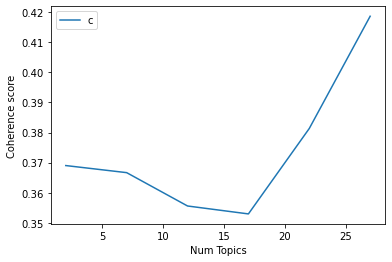

In [52]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.369
index: 1 | Num Topics = 7  has Coherence Value of 0.3667
index: 2 | Num Topics = 12  has Coherence Value of 0.3556
index: 3 | Num Topics = 17  has Coherence Value of 0.353
index: 4 | Num Topics = 22  has Coherence Value of 0.3813
index: 5 | Num Topics = 27  has Coherence Value of 0.4186


In [126]:
# Select optimal number of topics
optimal_model_us_score1 = model_list_us_score1[5]

In [127]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score1 = pyLDAvis.gensim_models.prepare(optimal_model_us_score1, corpus_us_score1, id2word_us_score1)

In [128]:
print("pyLDAVis for us topics for score=1:")
vis_us_score1

pyLDAVis for us topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.074735  0.033254       1        1  11.726473
3     -0.133568  0.051546       2        1   9.691947
24    -0.094821  0.073051       3        1   8.438744
0     -0.019616  0.155483       4        1   6.130712
22    -0.098529 -0.000605       5        1   5.735232
8     -0.048731  0.049466       6        1   5.025906
17    -0.121799 -0.012818       7        1   4.697904
13    -0.076274 -0.002114       8        1   4.498169
1     -0.078988 -0.087531       9        1   3.894605
23    -0.085027 -0.099511      10        1   3.759733
26    -0.068896  0.048576      11        1   3.411812
21    -0.074257 -0.141006      12        1   3.373633
20     0.087932  0.103123      13        1   3.292374
10     0.067572 -0.076216      14        1   3.169645
7      0.015961  0.044896      15        1   3.096600
5     -0.015640 -0.027466      16        1   2.754703
15     0.000922  0.066072      17        1   2.569766
9      0.052676 -0.045758      18        1   2.169237
2      0.107058 -0.076068      19        1   1.973117
6      0.032233 -0.077975      20        1   1.904971
16     0.091696  0.056207      21        1   1.785690
12     0.097875  0.035947      22        1   1.735122
25     0.098646  0.075337      23        1   1.614565
11     0.038138 -0.052842      24        1   1.026283
19     0.112732 -0.017528      25        1   0.912212
18     0.087489 -0.068577      26        1   0.908080
14     0.099952 -0.006945      27        1   0.702763, topic_info=           Term        Freq       Total Category  logprob  loglift
26          tok   30.000000   30.000000  Default  30.0000  30.0000
25          tik   21.000000   21.000000  Default  29.0000  29.0000
6        tiktok  107.000000  107.000000  Default  28.0000  28.0000
27        video   64.000000   64.000000  Default  27.0000  27.0000
48         time   16.000000   16.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
286       least    0.016467    2.121758  Topic27  -7.2182   0.0992
66      content    0.016467   33.310510  Topic27  -7.2182  -2.6544
265  navigation    0.016467    2.493178  Topic27  -7.2182  -0.0621
163      comedy    0.016467    4.539069  Topic27  -7.2182  -0.6612
441   intuitive    0.016467    1.608262  Topic27  -7.2182   0.3763

[1370 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
588      15  0.677549       ab
57        2  0.154547     able
57        3  0.154547     able
57        4  0.154547     able
57        5  0.463641     able
...     ...       ...      ...
184      26  0.228666      yet
405      10  0.445037    young
405      13  0.445037    young
457       7  0.662266  youtube
776       9  0.883820    zebra

[1783 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 25, 1, 23, 9, 18, 14, 2, 24, 27, 22, 21, 11, 8, 6, 16, 10, 3, 7, 17, 13, 26, 12, 20, 19, 15])

## LDA Topic Modelling (Rating = 2)

In [57]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_us_score2 = clash_ios_us_review_YearMonth_score2.review.values.tolist()
review_words_us_score2 = list(sent_to_words(review_us_score2))
print(review_words_us_score2[:1])

[['vine', 'was', 'such', 'game', 'changing', 'app', 'this', 'made', 'me', 'think', 'that', 'the', 'second', 'version', 'would', 'really', 'take', 'some', 'of', 'those', 'key', 'elements', 'for', 'the', 'original', 'and', 'really', 'showcase', 'that', 'raw', 'aura', 'of', 'second', 'videos', 'that', 'did', 'not', 'come', 'through', 'here', 'in', 'byte', 'not', 'to', 'hate', 'but', 'its', 'like', 'tiktok', 'but', 'lot', 'less', 'polished', 'you', 'can', 'pause', 'videos', 'on', 'byte', 'and', 'you', 'have', 'whatever', 'the', 'app', 'reposts', 'thrown', 'into', 'your', 'feed', 'maybe', 'll', 'consider', 'coming', 'back', 'after', 'few', 'much', 'needed', 'updates']]


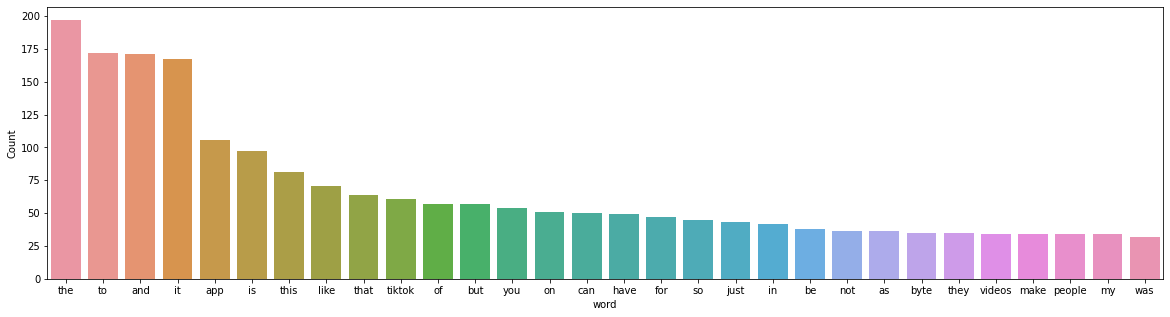

In [58]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score2))

In [59]:
# Clean text
review_us_ready_score2 = process_words(review_words_us_score2)  # processed Text Data! - move to each section


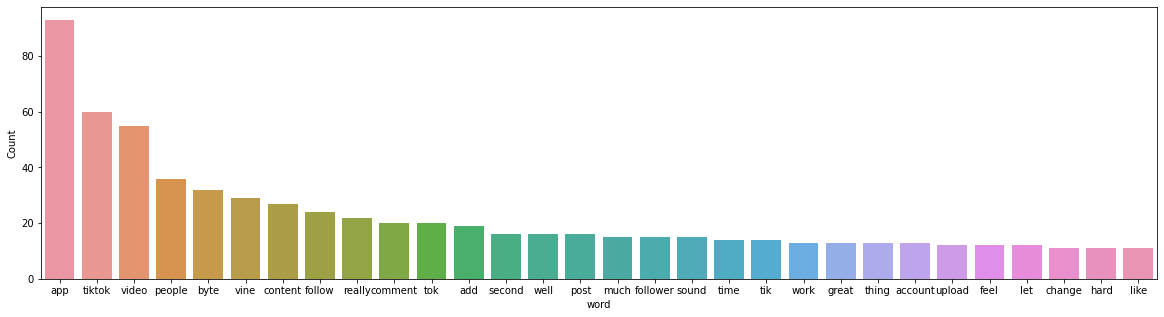

In [60]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score2))


In [61]:
# Create Dictionary
id2word_us_score2 = corpora.Dictionary(review_us_ready_score2)

2021-10-16 01:40:22,285 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 01:40:22,298 [INFO] gensim.corpora.dictionary - built Dictionary(685 unique tokens: ['app', 'aura', 'back', 'byte', 'change']...) from 120 documents (total 1993 corpus positions)
2021-10-16 01:40:22,299 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(685 unique tokens: ['app', 'aura', 'back', 'byte', 'change']...) from 120 documents (total 1993 corpus positions)", 'datetime': '2021-10-16T01:40:22.299926', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [62]:
# Create Corpus: Term Document Frequency
corpus_us_score2 = [id2word_us_score2.doc2bow(text) for text in review_us_ready_score2]

In [63]:
# Training LDA model
model_list_us_score2, coherence_values_us_score2 = compute_coherence_values(dictionary=id2word_us_score2, corpus=corpus_us_score2, 
                                                              texts=review_us_ready_score2, limit=30, start=2, step=5)


2021-10-16 01:40:22,325 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 01:40:22,327 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 01:40:22,329 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:40:22,331 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 120 documents, updating model once every 120 documents, evaluating perplexity every 120 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:40:22,778 [INFO] gensim.models.ldamodel - -7.175 per-word bound, 144.5 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:22,780 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #120/120
2021-10-16 01:40:23,208 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.038*"app" + 0.016*"vine" + 0.016*"people" + 0.015*"byte" + 0.013*"video" + 0.013*"tok" + 0.011*"commen

2021-10-16 01:40:27,641 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.040*"tiktok" + 0.034*"app" + 0.024*"video" + 0.012*"people" + 0.009*"account" + 0.009*"content" + 0.008*"byte" + 0.008*"post" + 0.008*"ban" + 0.008*"work"
2021-10-16 01:40:27,643 [INFO] gensim.models.ldamodel - topic diff=0.007475, rho=0.301511
2021-10-16 01:40:27,835 [INFO] gensim.models.ldamodel - -6.231 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:27,836 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #120/120
2021-10-16 01:40:28,007 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"app" + 0.019*"vine" + 0.018*"video" + 0.016*"byte" + 0.016*"people" + 0.015*"tok" + 0.012*"follow" + 0.012*"content" + 0.011*"really" + 0.011*"tik"
2021-10-16 01:40:28,011 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.040*"tiktok" + 0.034*"app" + 0.024*"video" + 0.012*"people" + 0.009*"account" + 0.009*"content" + 0.008*"byte" + 0

2021-10-16 01:40:31,758 [INFO] gensim.models.ldamodel - topic diff=0.002116, rho=0.218218
2021-10-16 01:40:32,059 [INFO] gensim.models.ldamodel - -6.228 per-word bound, 75.0 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:32,062 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #120/120
2021-10-16 01:40:32,209 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"app" + 0.019*"vine" + 0.019*"video" + 0.016*"people" + 0.016*"byte" + 0.015*"tok" + 0.013*"follow" + 0.011*"content" + 0.011*"really" + 0.011*"tik"
2021-10-16 01:40:32,211 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"tiktok" + 0.033*"app" + 0.023*"video" + 0.011*"people" + 0.010*"account" + 0.009*"content" + 0.009*"byte" + 0.009*"log" + 0.008*"post" + 0.008*"ban"
2021-10-16 01:40:32,213 [INFO] gensim.models.ldamodel - topic diff=0.002031, rho=0.213201
2021-10-16 01:40:32,434 [INFO] gensim.models.ldamodel - -6.228 per-word bound, 75.0 perplexity estima

2021-10-16 01:40:36,070 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #120/120
2021-10-16 01:40:36,258 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"app" + 0.019*"vine" + 0.019*"video" + 0.016*"people" + 0.015*"byte" + 0.015*"tok" + 0.013*"follow" + 0.011*"content" + 0.011*"really" + 0.011*"tik"
2021-10-16 01:40:36,262 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"tiktok" + 0.033*"app" + 0.023*"video" + 0.011*"people" + 0.010*"account" + 0.009*"content" + 0.009*"byte" + 0.009*"log" + 0.008*"post" + 0.008*"ban"
2021-10-16 01:40:36,265 [INFO] gensim.models.ldamodel - topic diff=0.000932, rho=0.176777
2021-10-16 01:40:36,505 [INFO] gensim.models.ldamodel - -6.226 per-word bound, 74.9 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:36,508 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #120/120
2021-10-16 01:40:36,692 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"app" + 0.019*"

2021-10-16 01:40:40,215 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"tiktok" + 0.033*"app" + 0.023*"video" + 0.011*"people" + 0.010*"account" + 0.009*"content" + 0.009*"byte" + 0.009*"log" + 0.008*"post" + 0.008*"ban"
2021-10-16 01:40:40,220 [INFO] gensim.models.ldamodel - topic diff=0.001756, rho=0.154303
2021-10-16 01:40:40,468 [INFO] gensim.models.ldamodel - -6.225 per-word bound, 74.8 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:40,470 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #120/120
2021-10-16 01:40:40,655 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"app" + 0.019*"vine" + 0.019*"video" + 0.016*"people" + 0.015*"byte" + 0.015*"tok" + 0.013*"follow" + 0.012*"content" + 0.011*"really" + 0.011*"tik"
2021-10-16 01:40:40,659 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"tiktok" + 0.033*"app" + 0.023*"video" + 0.011*"people" + 0.010*"account" + 0.009*"content" + 0.009*"byte" + 0.

2021-10-16 01:40:48,465 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 111 virtual documents
2021-10-16 01:40:48,835 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 01:40:48,837 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 01:40:48,841 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:40:48,843 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 120 documents, updating model once every 120 documents, evaluating perplexity every 120 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:40:49,238 [INFO] gensim.models.ldamodel - -9.375 per-word bound, 663.8 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:49,240 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #120/120
2021-10-16 01:40

2021-10-16 01:40:50,940 [INFO] gensim.models.ldamodel - -6.541 per-word bound, 93.1 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:50,941 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #120/120
2021-10-16 01:40:51,068 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.045*"app" + 0.037*"video" + 0.019*"tiktok" + 0.018*"vine" + 0.016*"byte" + 0.015*"really" + 0.014*"time" + 0.014*"change" + 0.013*"comment" + 0.012*"slow"
2021-10-16 01:40:51,071 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.071*"tiktok" + 0.022*"video" + 0.015*"post" + 0.015*"ban" + 0.013*"app" + 0.012*"new" + 0.012*"like" + 0.012*"let" + 0.011*"follow" + 0.010*"well"
2021-10-16 01:40:51,075 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"tok" + 0.037*"tik" + 0.025*"vine" + 0.022*"really" + 0.019*"byte" + 0.018*"camera" + 0.015*"name" + 0.012*"people" + 0.012*"back" + 0.012*"post"
2021-10-16 01:40:51,077 [INFO] gensim.models.ldamodel - topic

2021-10-16 01:40:52,455 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"app" + 0.031*"video" + 0.024*"people" + 0.016*"tiktok" + 0.014*"content" + 0.014*"able" + 0.013*"byte" + 0.013*"find" + 0.012*"follower" + 0.010*"let"
2021-10-16 01:40:52,458 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"tiktok" + 0.024*"app" + 0.020*"account" + 0.020*"add" + 0.016*"log" + 0.016*"sound" + 0.016*"much" + 0.015*"content" + 0.014*"really" + 0.013*"people"
2021-10-16 01:40:52,459 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"app" + 0.017*"feel" + 0.016*"follow" + 0.016*"byte" + 0.015*"tiktok" + 0.015*"vine" + 0.014*"video" + 0.014*"thing" + 0.010*"people" + 0.010*"content"
2021-10-16 01:40:52,460 [INFO] gensim.models.ldamodel - topic diff=0.012311, rho=0.288675
2021-10-16 01:40:52,633 [INFO] gensim.models.ldamodel - -6.517 per-word bound, 91.6 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:52,637 [INFO] gensim.models.ldamo

2021-10-16 01:40:54,099 [INFO] gensim.models.ldamodel - -6.513 per-word bound, 91.3 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:54,100 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #120/120
2021-10-16 01:40:54,190 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"app" + 0.018*"feel" + 0.016*"follow" + 0.016*"byte" + 0.016*"vine" + 0.015*"tiktok" + 0.015*"video" + 0.014*"thing" + 0.011*"people" + 0.010*"content"
2021-10-16 01:40:54,193 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.046*"app" + 0.038*"video" + 0.019*"tiktok" + 0.017*"vine" + 0.016*"really" + 0.015*"byte" + 0.014*"time" + 0.014*"change" + 0.014*"comment" + 0.012*"slow"
2021-10-16 01:40:54,196 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.053*"tok" + 0.049*"tik" + 0.025*"vine" + 0.022*"really" + 0.019*"byte" + 0.017*"camera" + 0.017*"name" + 0.012*"people" + 0.012*"back" + 0.012*"post"
2021-10-16 01:40:54,198 [INFO] gensim.models.ldamod

2021-10-16 01:40:55,600 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"tiktok" + 0.022*"video" + 0.015*"post" + 0.015*"ban" + 0.013*"app" + 0.012*"let" + 0.012*"new" + 0.012*"like" + 0.011*"follow" + 0.011*"well"
2021-10-16 01:40:55,602 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.046*"app" + 0.038*"video" + 0.019*"tiktok" + 0.017*"vine" + 0.017*"really" + 0.015*"byte" + 0.014*"time" + 0.014*"change" + 0.014*"comment" + 0.012*"slow"
2021-10-16 01:40:55,604 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"app" + 0.031*"video" + 0.024*"people" + 0.016*"tiktok" + 0.014*"content" + 0.014*"able" + 0.013*"find" + 0.013*"byte" + 0.012*"follower" + 0.010*"let"
2021-10-16 01:40:55,606 [INFO] gensim.models.ldamodel - topic diff=0.001370, rho=0.208514
2021-10-16 01:40:55,741 [INFO] gensim.models.ldamodel - -6.511 per-word bound, 91.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:55,743 [INFO] gensim.models.ldamodel - PROG

2021-10-16 01:40:57,307 [INFO] gensim.models.ldamodel - -6.511 per-word bound, 91.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:57,309 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #120/120
2021-10-16 01:40:57,415 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"tiktok" + 0.024*"app" + 0.020*"add" + 0.020*"account" + 0.016*"log" + 0.016*"sound" + 0.016*"much" + 0.015*"content" + 0.014*"really" + 0.012*"people"
2021-10-16 01:40:57,417 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.054*"app" + 0.032*"tok" + 0.021*"follow" + 0.021*"vine" + 0.021*"hard" + 0.018*"tik" + 0.016*"tiktok" + 0.014*"great" + 0.013*"sound" + 0.013*"well"
2021-10-16 01:40:57,422 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.046*"app" + 0.038*"video" + 0.019*"tiktok" + 0.017*"vine" + 0.017*"really" + 0.015*"byte" + 0.014*"time" + 0.014*"comment" + 0.014*"change" + 0.012*"slow"
2021-10-16 01:40:57,427 [INFO] gensim.models.ldamode

2021-10-16 01:40:58,941 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"app" + 0.031*"video" + 0.024*"people" + 0.016*"tiktok" + 0.014*"content" + 0.014*"able" + 0.013*"find" + 0.013*"byte" + 0.012*"follower" + 0.010*"let"
2021-10-16 01:40:58,943 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"app" + 0.018*"feel" + 0.016*"follow" + 0.016*"byte" + 0.016*"vine" + 0.015*"tiktok" + 0.015*"video" + 0.014*"thing" + 0.011*"people" + 0.010*"content"
2021-10-16 01:40:58,944 [INFO] gensim.models.ldamodel - topic diff=0.000254, rho=0.171499
2021-10-16 01:40:59,079 [INFO] gensim.models.ldamodel - -6.511 per-word bound, 91.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:40:59,083 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #120/120
2021-10-16 01:40:59,213 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"tok" + 0.049*"tik" + 0.025*"vine" + 0.022*"really" + 0.019*"byte" + 0.017*"camera" + 0.017*"name" + 0.012

2021-10-16 01:41:00,723 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"tiktok" + 0.022*"video" + 0.015*"post" + 0.015*"ban" + 0.013*"app" + 0.012*"let" + 0.012*"new" + 0.012*"like" + 0.011*"follow" + 0.011*"well"
2021-10-16 01:41:00,725 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"app" + 0.018*"feel" + 0.016*"follow" + 0.016*"byte" + 0.016*"vine" + 0.016*"tiktok" + 0.015*"video" + 0.014*"thing" + 0.011*"people" + 0.010*"content"
2021-10-16 01:41:00,726 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.046*"app" + 0.038*"video" + 0.019*"tiktok" + 0.017*"vine" + 0.017*"really" + 0.015*"byte" + 0.014*"comment" + 0.014*"time" + 0.014*"change" + 0.012*"slow"
2021-10-16 01:41:00,731 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"tok" + 0.049*"tik" + 0.025*"vine" + 0.022*"really" + 0.019*"byte" + 0.017*"camera" + 0.017*"name" + 0.012*"people" + 0.012*"post" + 0.012*"back"
2021-10-16 01:41:00,733 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"tiktok"

2021-10-16 01:41:02,227 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"tiktok" + 0.024*"app" + 0.020*"add" + 0.020*"account" + 0.016*"log" + 0.016*"sound" + 0.016*"much" + 0.015*"content" + 0.014*"really" + 0.012*"people"
2021-10-16 01:41:02,233 [INFO] gensim.models.ldamodel - topic diff=0.000074, rho=0.149071
2021-10-16 01:41:02,419 [INFO] gensim.models.ldamodel - -6.511 per-word bound, 91.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:02,422 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #120/120
2021-10-16 01:41:02,573 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.053*"app" + 0.032*"tok" + 0.021*"follow" + 0.021*"vine" + 0.021*"hard" + 0.018*"tik" + 0.016*"tiktok" + 0.014*"great" + 0.013*"sound" + 0.013*"well"
2021-10-16 01:41:02,574 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"tiktok" + 0.022*"video" + 0.015*"post" + 0.015*"ban" + 0.013*"app" + 0.012*"let" + 0.012*"new" + 0.012*"like" + 

2021-10-16 01:41:03,963 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"tiktok" + 0.022*"video" + 0.015*"post" + 0.015*"ban" + 0.013*"app" + 0.012*"let" + 0.012*"new" + 0.012*"like" + 0.011*"follow" + 0.011*"well"
2021-10-16 01:41:03,965 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.053*"app" + 0.032*"tok" + 0.021*"follow" + 0.021*"vine" + 0.021*"hard" + 0.018*"tik" + 0.016*"tiktok" + 0.014*"great" + 0.013*"sound" + 0.013*"well"
2021-10-16 01:41:03,966 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.054*"tok" + 0.049*"tik" + 0.025*"vine" + 0.022*"really" + 0.019*"byte" + 0.017*"camera" + 0.017*"name" + 0.012*"people" + 0.012*"post" + 0.012*"back"
2021-10-16 01:41:03,969 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.046*"app" + 0.038*"video" + 0.019*"tiktok" + 0.017*"vine" + 0.017*"really" + 0.015*"byte" + 0.014*"comment" + 0.014*"time" + 0.014*"change" + 0.012*"slow"
2021-10-16 01:41:03,971 [INFO] gensim.models.ldamodel - topic diff=0.000042, rho=0.140028
2021-

2021-10-16 01:41:11,513 [INFO] gensim.models.ldamodel - topic diff=0.182008, rho=0.447214
2021-10-16 01:41:11,679 [INFO] gensim.models.ldamodel - -6.706 per-word bound, 104.4 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:11,691 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #120/120
2021-10-16 01:41:11,789 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.024*"vine" + 0.017*"app" + 0.017*"people" + 0.017*"log" + 0.017*"phone" + 0.017*"guess" + 0.016*"tok" + 0.009*"content" + 0.009*"new" + 0.009*"fail"
2021-10-16 01:41:11,791 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.038*"app" + 0.029*"vine" + 0.026*"tiktok" + 0.024*"video" + 0.023*"really" + 0.021*"add" + 0.017*"feel" + 0.017*"second" + 0.015*"slow" + 0.015*"people"
2021-10-16 01:41:11,793 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"follow" + 0.031*"app" + 0.021*"comment" + 0.020*"fun" + 0.020*"platform" + 0.011*"people" + 0.011*"second" + 0.011*

2021-10-16 01:41:12,935 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.021*"video" + 0.021*"fix" + 0.021*"let" + 0.021*"logo" + 0.021*"weird" + 0.021*"change" + 0.021*"confuse" + 0.020*"download" + 0.017*"name" + 0.011*"app"
2021-10-16 01:41:12,939 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"app" + 0.031*"vine" + 0.026*"video" + 0.025*"tiktok" + 0.023*"really" + 0.021*"add" + 0.019*"feel" + 0.018*"second" + 0.017*"slow" + 0.016*"people"
2021-10-16 01:41:12,941 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.042*"byte" + 0.019*"vine" + 0.018*"video" + 0.018*"hope" + 0.018*"talk" + 0.013*"really" + 0.012*"camera" + 0.012*"front" + 0.012*"face" + 0.012*"much"
2021-10-16 01:41:12,942 [INFO] gensim.models.ldamodel - topic diff=0.029116, rho=0.301511
2021-10-16 01:41:13,097 [INFO] gensim.models.ldamodel - -6.625 per-word bound, 98.7 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:13,098 [INFO] gensim.models.ldamodel - PR

2021-10-16 01:41:14,208 [INFO] gensim.models.ldamodel - topic diff=0.008433, rho=0.250000
2021-10-16 01:41:14,327 [INFO] gensim.models.ldamodel - -6.615 per-word bound, 98.0 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:14,331 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #120/120
2021-10-16 01:41:14,409 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.021*"video" + 0.021*"fix" + 0.021*"let" + 0.021*"logo" + 0.021*"weird" + 0.021*"change" + 0.021*"confuse" + 0.020*"download" + 0.018*"name" + 0.011*"app"
2021-10-16 01:41:14,413 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.039*"video" + 0.039*"app" + 0.022*"follow" + 0.022*"content" + 0.017*"follower" + 0.017*"comment" + 0.013*"vine" + 0.013*"byte" + 0.013*"people" + 0.013*"keep"
2021-10-16 01:41:14,421 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.034*"app" + 0.022*"content" + 0.022*"add" + 0.022*"sound" + 0.022*"much" + 0.019*"people" + 0.018*"tiktok" 

2021-10-16 01:41:15,838 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.124*"tok" + 0.090*"tik" + 0.030*"hard" + 0.018*"funny" + 0.018*"app" + 0.016*"great" + 0.014*"follow" + 0.014*"fun" + 0.014*"creator" + 0.014*"day"
2021-10-16 01:41:15,839 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.021*"video" + 0.021*"fix" + 0.021*"let" + 0.021*"logo" + 0.021*"weird" + 0.021*"change" + 0.021*"confuse" + 0.020*"download" + 0.018*"name" + 0.011*"app"
2021-10-16 01:41:15,841 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.100*"tiktok" + 0.027*"ban" + 0.027*"follow" + 0.022*"well" + 0.021*"app" + 0.016*"view" + 0.011*"content" + 0.011*"post" + 0.011*"people" + 0.011*"like"
2021-10-16 01:41:15,842 [INFO] gensim.models.ldamodel - topic diff=0.002397, rho=0.213201
2021-10-16 01:41:15,990 [INFO] gensim.models.ldamodel - -6.613 per-word bound, 97.9 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:15,991 [INFO] gensim.models.ldamodel - PROGRE

2021-10-16 01:41:17,148 [INFO] gensim.models.ldamodel - topic diff=0.000920, rho=0.192450
2021-10-16 01:41:17,258 [INFO] gensim.models.ldamodel - -6.612 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:17,263 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #120/120
2021-10-16 01:41:17,352 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.021*"video" + 0.021*"fix" + 0.021*"let" + 0.021*"weird" + 0.021*"logo" + 0.021*"change" + 0.021*"confuse" + 0.020*"download" + 0.018*"name" + 0.011*"app"
2021-10-16 01:41:17,356 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.067*"app" + 0.029*"video" + 0.025*"tiktok" + 0.024*"work" + 0.016*"upload" + 0.013*"content" + 0.013*"look" + 0.012*"problem" + 0.012*"similar" + 0.011*"time"
2021-10-16 01:41:17,357 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.039*"video" + 0.039*"app" + 0.022*"follow" + 0.022*"content" + 0.017*"follower" + 0.017*"comment" + 0.013*"v

2021-10-16 01:41:18,646 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.025*"vine" + 0.017*"app" + 0.017*"people" + 0.017*"log" + 0.017*"phone" + 0.017*"tok" + 0.017*"guess" + 0.009*"new" + 0.009*"fail" + 0.009*"content"
2021-10-16 01:41:18,653 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.067*"app" + 0.029*"video" + 0.025*"tiktok" + 0.024*"work" + 0.016*"upload" + 0.013*"content" + 0.013*"look" + 0.012*"problem" + 0.012*"similar" + 0.011*"time"
2021-10-16 01:41:18,659 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.034*"app" + 0.022*"content" + 0.022*"add" + 0.022*"sound" + 0.022*"much" + 0.019*"people" + 0.018*"tiktok" + 0.018*"really" + 0.013*"comment" + 0.013*"account"
2021-10-16 01:41:18,661 [INFO] gensim.models.ldamodel - topic diff=0.000360, rho=0.174078
2021-10-16 01:41:18,823 [INFO] gensim.models.ldamodel - -6.612 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:18,824 [INFO] gensim.models.ldamo

2021-10-16 01:41:20,104 [INFO] gensim.models.ldamodel - -6.612 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:20,141 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #120/120
2021-10-16 01:41:20,209 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.062*"app" + 0.018*"video" + 0.017*"tiktok" + 0.011*"upload" + 0.011*"issue" + 0.011*"work" + 0.011*"people" + 0.011*"byte" + 0.011*"post" + 0.011*"delete"
2021-10-16 01:41:20,212 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.033*"app" + 0.031*"vine" + 0.027*"video" + 0.025*"tiktok" + 0.023*"really" + 0.021*"add" + 0.019*"feel" + 0.019*"second" + 0.017*"people" + 0.017*"slow"
2021-10-16 01:41:20,217 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.039*"video" + 0.039*"app" + 0.022*"content" + 0.022*"follow" + 0.017*"follower" + 0.017*"comment" + 0.013*"vine" + 0.013*"byte" + 0.013*"people" + 0.013*"keep"
2021-10-16 01:41:20,234 [INFO] gensim.models

2021-10-16 01:41:21,604 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.100*"tiktok" + 0.027*"ban" + 0.027*"follow" + 0.022*"well" + 0.021*"app" + 0.017*"view" + 0.011*"post" + 0.011*"people" + 0.011*"like" + 0.011*"content"
2021-10-16 01:41:21,606 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.067*"app" + 0.029*"video" + 0.025*"tiktok" + 0.024*"work" + 0.016*"upload" + 0.013*"content" + 0.013*"look" + 0.012*"problem" + 0.012*"similar" + 0.011*"first"
2021-10-16 01:41:21,608 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"follow" + 0.031*"app" + 0.021*"comment" + 0.021*"fun" + 0.021*"platform" + 0.011*"second" + 0.011*"people" + 0.011*"time" + 0.011*"fake" + 0.011*"byte"
2021-10-16 01:41:21,609 [INFO] gensim.models.ldamodel - topic diff=0.000105, rho=0.150756
2021-10-16 01:41:21,832 [INFO] gensim.models.ldamodel - -6.612 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:21,833 [INFO] gensim.models.lda

2021-10-16 01:41:22,906 [INFO] gensim.models.ldamodel - topic diff=0.000072, rho=0.142857
2021-10-16 01:41:23,070 [INFO] gensim.models.ldamodel - -6.612 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:23,071 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #120/120
2021-10-16 01:41:23,194 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.034*"app" + 0.022*"add" + 0.022*"content" + 0.022*"sound" + 0.022*"much" + 0.019*"people" + 0.018*"tiktok" + 0.018*"really" + 0.013*"account" + 0.013*"comment"
2021-10-16 01:41:23,196 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"byte" + 0.019*"hope" + 0.019*"vine" + 0.019*"video" + 0.019*"talk" + 0.013*"really" + 0.013*"comment" + 0.013*"camera" + 0.013*"way" + 0.013*"front"
2021-10-16 01:41:23,197 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.062*"app" + 0.018*"video" + 0.017*"tiktok" + 0.011*"post" + 0.011*"work" + 0.011*"issue" + 0.011*"upload" + 

2021-10-16 01:41:30,753 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.049*"app" + 0.019*"video" + 0.016*"content" + 0.014*"first" + 0.013*"way" + 0.013*"find" + 0.012*"original" + 0.012*"feed" + 0.011*"byte" + 0.011*"work"
2021-10-16 01:41:30,761 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.037*"app" + 0.035*"slow" + 0.035*"really" + 0.033*"video" + 0.017*"post" + 0.017*"section" + 0.017*"tiktok" + 0.017*"upload" + 0.017*"show" + 0.016*"day"
2021-10-16 01:41:30,766 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.040*"tiktok" + 0.037*"app" + 0.034*"audio" + 0.029*"video" + 0.025*"change" + 0.021*"find" + 0.021*"let" + 0.021*"vine" + 0.018*"interesting" + 0.016*"add"
2021-10-16 01:41:30,772 [INFO] gensim.models.ldamodel - topic diff=0.188411, rho=0.500000
2021-10-16 01:41:30,953 [INFO] gensim.models.ldamodel - -6.922 per-word bound, 121.3 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:30,954 [INFO] gensim.models.ldamode

2021-10-16 01:41:32,123 [INFO] gensim.models.ldamodel - topic diff=0.055623, rho=0.333333
2021-10-16 01:41:32,326 [INFO] gensim.models.ldamodel - -6.770 per-word bound, 109.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:32,327 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #120/120
2021-10-16 01:41:32,370 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"slow" + 0.039*"app" + 0.036*"really" + 0.035*"video" + 0.018*"post" + 0.018*"section" + 0.018*"tiktok" + 0.018*"upload" + 0.018*"show" + 0.018*"day"
2021-10-16 01:41:32,371 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.061*"tiktok" + 0.052*"people" + 0.025*"follow" + 0.025*"let" + 0.025*"sound" + 0.023*"app" + 0.019*"byte" + 0.019*"view" + 0.019*"like" + 0.019*"well"
2021-10-16 01:41:32,372 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.037*"log" + 0.019*"app" + 0.019*"number" + 0.019*"phone" + 0.019*"email" + 0.019*"month" + 0.019*"look" + 0.019*"f

2021-10-16 01:41:33,609 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.090*"tiktok" + 0.028*"ban" + 0.022*"user" + 0.021*"follower" + 0.015*"guess" + 0.015*"way" + 0.015*"follow" + 0.015*"possibly" + 0.015*"able" + 0.015*"view"
2021-10-16 01:41:33,611 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.025*"tok" + 0.025*"much" + 0.025*"content" + 0.025*"account" + 0.025*"app" + 0.020*"add" + 0.019*"tik" + 0.019*"tiktok" + 0.013*"let" + 0.013*"help"
2021-10-16 01:41:33,613 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.062*"tiktok" + 0.052*"people" + 0.025*"follow" + 0.025*"let" + 0.025*"sound" + 0.022*"app" + 0.019*"byte" + 0.019*"view" + 0.019*"like" + 0.019*"well"
2021-10-16 01:41:33,614 [INFO] gensim.models.ldamodel - topic diff=0.013849, rho=0.258199
2021-10-16 01:41:33,823 [INFO] gensim.models.ldamodel - -6.743 per-word bound, 107.1 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:33,824 [INFO] gensim.models.ldamodel - PRO

2021-10-16 01:41:34,858 [INFO] gensim.models.ldamodel - topic diff=0.005039, rho=0.223607
2021-10-16 01:41:34,936 [INFO] gensim.models.ldamodel - -6.738 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:34,937 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #120/120
2021-10-16 01:41:34,998 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.058*"app" + 0.043*"video" + 0.027*"people" + 0.017*"able" + 0.015*"tiktok" + 0.014*"fix" + 0.014*"long" + 0.014*"download" + 0.013*"follower" + 0.012*"well"
2021-10-16 01:41:35,008 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.031*"follow" + 0.031*"tiktok" + 0.016*"byte" + 0.016*"people" + 0.016*"time" + 0.016*"half" + 0.016*"account" + 0.016*"tok" + 0.016*"tik" + 0.016*"kinda"
2021-10-16 01:41:35,060 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.025*"tok" + 0.025*"much" + 0.025*"content" + 0.025*"account" + 0.025*"app" + 0.019*"add" + 0.019*"tik" + 0.019

2021-10-16 01:41:36,457 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.037*"log" + 0.019*"app" + 0.019*"appreciate" + 0.019*"apple" + 0.019*"look" + 0.019*"phone" + 0.019*"problem" + 0.019*"excite" + 0.019*"release" + 0.019*"month"
2021-10-16 01:41:36,466 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.031*"follow" + 0.031*"tiktok" + 0.016*"byte" + 0.016*"people" + 0.016*"time" + 0.016*"half" + 0.016*"account" + 0.016*"tok" + 0.016*"tik" + 0.016*"kinda"
2021-10-16 01:41:36,469 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.048*"app" + 0.026*"video" + 0.026*"vine" + 0.022*"follow" + 0.022*"tiktok" + 0.017*"people" + 0.016*"fun" + 0.016*"second" + 0.016*"community" + 0.016*"byte"
2021-10-16 01:41:36,470 [INFO] gensim.models.ldamodel - topic diff=0.002038, rho=0.196116
2021-10-16 01:41:36,547 [INFO] gensim.models.ldamodel - -6.735 per-word bound, 106.5 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:36,548 [INFO] gensim.model

2021-10-16 01:41:37,710 [INFO] gensim.models.ldamodel - topic diff=0.001061, rho=0.179605
2021-10-16 01:41:37,836 [INFO] gensim.models.ldamodel - -6.734 per-word bound, 106.4 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:37,838 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #120/120
2021-10-16 01:41:37,910 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.055*"app" + 0.033*"video" + 0.030*"vine" + 0.030*"feel" + 0.027*"add" + 0.024*"tiktok" + 0.023*"thing" + 0.018*"content" + 0.017*"follow" + 0.017*"star"
2021-10-16 01:41:37,913 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.048*"app" + 0.026*"vine" + 0.026*"video" + 0.022*"follow" + 0.022*"tiktok" + 0.017*"people" + 0.016*"byte" + 0.016*"fun" + 0.016*"second" + 0.016*"community"
2021-10-16 01:41:37,916 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.046*"second" + 0.040*"byte" + 0.029*"people" + 0.028*"big" + 0.023*"really" + 0.020*"much" + 0.019*"log" + 0.

2021-10-16 01:41:39,143 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.038*"account" + 0.038*"log" + 0.027*"tiktok" + 0.025*"sign" + 0.025*"delete" + 0.025*"email" + 0.025*"new" + 0.025*"pretty" + 0.025*"similar" + 0.014*"app"
2021-10-16 01:41:39,144 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.061*"tiktok" + 0.052*"people" + 0.028*"app" + 0.025*"follow" + 0.025*"let" + 0.025*"sound" + 0.019*"view" + 0.019*"byte" + 0.019*"like" + 0.015*"comment"
2021-10-16 01:41:39,145 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.059*"app" + 0.044*"video" + 0.026*"people" + 0.017*"able" + 0.014*"tiktok" + 0.014*"fix" + 0.014*"long" + 0.014*"download" + 0.012*"follower" + 0.011*"well"
2021-10-16 01:41:39,146 [INFO] gensim.models.ldamodel - topic diff=0.000679, rho=0.164399
2021-10-16 01:41:39,311 [INFO] gensim.models.ldamodel - -6.731 per-word bound, 106.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:39,312 [INFO] gensim.models.ldam

2021-10-16 01:41:40,468 [INFO] gensim.models.ldamodel - topic diff=0.000439, rho=0.154303
2021-10-16 01:41:40,596 [INFO] gensim.models.ldamodel - -6.731 per-word bound, 106.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:40,598 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #120/120
2021-10-16 01:41:40,683 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"app" + 0.033*"video" + 0.030*"vine" + 0.030*"feel" + 0.027*"add" + 0.024*"tiktok" + 0.023*"thing" + 0.018*"content" + 0.017*"follow" + 0.017*"star"
2021-10-16 01:41:40,686 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.048*"app" + 0.026*"video" + 0.026*"vine" + 0.022*"follow" + 0.022*"tiktok" + 0.017*"people" + 0.016*"byte" + 0.016*"fun" + 0.016*"second" + 0.016*"community"
2021-10-16 01:41:40,687 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.025*"tok" + 0.025*"content" + 0.025*"account" + 0.025*"much" + 0.025*"app" + 0.019*"add" + 0.019*"tik" + 0.019

2021-10-16 01:41:41,957 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.037*"log" + 0.019*"excite" + 0.019*"appreciate" + 0.019*"apple" + 0.019*"look" + 0.019*"phone" + 0.019*"problem" + 0.019*"release" + 0.019*"forward" + 0.019*"number"
2021-10-16 01:41:41,959 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.037*"tiktok" + 0.025*"app" + 0.025*"audio" + 0.025*"follow" + 0.025*"tok" + 0.025*"sound" + 0.013*"video" + 0.013*"navigate" + 0.013*"practically" + 0.013*"hard"
2021-10-16 01:41:41,960 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.034*"app" + 0.021*"work" + 0.021*"however" + 0.021*"content" + 0.021*"logo" + 0.021*"name" + 0.021*"tik" + 0.021*"tok" + 0.021*"weird" + 0.021*"change"
2021-10-16 01:41:41,961 [INFO] gensim.models.ldamodel - topic diff=0.000363, rho=0.144338
2021-10-16 01:41:42,080 [INFO] gensim.models.ldamodel - -6.730 per-word bound, 106.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:42,081 [INFO] gens

2021-10-16 01:41:51,468 [INFO] gensim.models.ldamodel - -7.250 per-word bound, 152.3 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:51,470 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #120/120
2021-10-16 01:41:51,606 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.028*"time" + 0.026*"server" + 0.026*"update" + 0.026*"profile" + 0.026*"error" + 0.008*"app" + 0.007*"vine" + 0.005*"change" + 0.004*"people" + 0.004*"great"
2021-10-16 01:41:51,610 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.047*"video" + 0.031*"slow" + 0.030*"app" + 0.026*"really" + 0.021*"upload" + 0.020*"byte" + 0.018*"fix" + 0.016*"talk" + 0.016*"issue" + 0.015*"work"
2021-10-16 01:41:51,611 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.059*"much" + 0.038*"tok" + 0.038*"tik" + 0.022*"content" + 0.020*"miss" + 0.020*"overall" + 0.020*"offer" + 0.020*"cry" + 0.020*"tool" + 0.020*"hate"
2021-10-16 01:41:51,613 [INFO] gensim.models.ldamode

2021-10-16 01:41:53,021 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.044*"video" + 0.033*"slow" + 0.032*"app" + 0.024*"really" + 0.019*"upload" + 0.019*"byte" + 0.019*"fix" + 0.015*"talk" + 0.015*"issue" + 0.015*"work"
2021-10-16 01:41:53,023 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.038*"app" + 0.020*"early" + 0.020*"download" + 0.020*"tok" + 0.020*"probably" + 0.020*"tik" + 0.020*"damelio" + 0.020*"delete" + 0.020*"connect" + 0.020*"dixie"
2021-10-16 01:41:53,031 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.037*"vine" + 0.037*"people" + 0.025*"audio" + 0.025*"sound" + 0.013*"really" + 0.013*"figure" + 0.013*"byte" + 0.013*"hard" + 0.013*"spam" + 0.013*"comment"
2021-10-16 01:41:53,035 [INFO] gensim.models.ldamodel - topic diff=0.073191, rho=0.353553
2021-10-16 01:41:53,214 [INFO] gensim.models.ldamodel - -6.776 per-word bound, 109.6 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:53,216 [INFO] gensim.models.l

2021-10-16 01:41:54,331 [INFO] gensim.models.ldamodel - topic diff=0.015804, rho=0.277350
2021-10-16 01:41:54,500 [INFO] gensim.models.ldamodel - -6.762 per-word bound, 108.6 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:54,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #120/120
2021-10-16 01:41:54,597 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.041*"comment" + 0.033*"follow" + 0.033*"section" + 0.033*"app" + 0.027*"add" + 0.025*"sound" + 0.025*"fun" + 0.025*"audio" + 0.020*"tiktok" + 0.017*"post"
2021-10-16 01:41:54,600 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.035*"tok" + 0.026*"content" + 0.018*"app" + 0.018*"work" + 0.018*"tik" + 0.018*"design" + 0.018*"add" + 0.018*"look" + 0.018*"break" + 0.018*"much"
2021-10-16 01:41:54,602 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.054*"tiktok" + 0.030*"follow" + 0.030*"well" + 0.029*"complicate" + 0.018*"app" + 0.015*"asap" + 0.015*"ago" + 0.015

2021-10-16 01:41:55,880 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.037*"vine" + 0.037*"people" + 0.025*"sound" + 0.025*"audio" + 0.013*"really" + 0.013*"figure" + 0.013*"byte" + 0.013*"hard" + 0.013*"spam" + 0.013*"comment"
2021-10-16 01:41:55,881 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.042*"log" + 0.042*"guess" + 0.022*"lose" + 0.022*"plan" + 0.022*"redownload" + 0.022*"big" + 0.022*"buttun" + 0.022*"fix" + 0.022*"byte" + 0.022*"account"
2021-10-16 01:41:55,884 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.030*"tok" + 0.020*"mix" + 0.020*"question" + 0.020*"guy" + 0.020*"tik" + 0.020*"tiktok" + 0.010*"add" + 0.010*"app" + 0.010*"follower" + 0.010*"prevent"
2021-10-16 01:41:55,887 [INFO] gensim.models.ldamodel - topic diff=0.003142, rho=0.229416
2021-10-16 01:41:56,034 [INFO] gensim.models.ldamodel - -6.759 per-word bound, 108.3 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:56,037 [INFO] gensim.models.ldamo

2021-10-16 01:41:56,965 [INFO] gensim.models.ldamodel - topic diff=0.001152, rho=0.204124
2021-10-16 01:41:57,205 [INFO] gensim.models.ldamodel - -6.759 per-word bound, 108.3 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:57,208 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #120/120
2021-10-16 01:41:57,267 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.068*"tiktok" + 0.048*"app" + 0.021*"vine" + 0.021*"content" + 0.016*"like" + 0.016*"video" + 0.016*"people" + 0.016*"interesting" + 0.016*"time" + 0.016*"add"
2021-10-16 01:41:57,270 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.054*"let" + 0.027*"video" + 0.027*"like" + 0.027*"creator" + 0.027*"audio" + 0.027*"record" + 0.001*"second" + 0.001*"byte" + 0.001*"feel" + 0.001*"vine"
2021-10-16 01:41:57,271 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.063*"much" + 0.042*"tik" + 0.042*"tok" + 0.022*"content" + 0.022*"offer" + 0.022*"app" + 0.022*"tool" + 0.

2021-10-16 01:41:58,643 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.066*"app" + 0.062*"video" + 0.025*"follow" + 0.019*"byte" + 0.019*"download" + 0.019*"comment" + 0.019*"time" + 0.019*"keep" + 0.019*"bot" + 0.019*"long"
2021-10-16 01:41:58,645 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.029*"time" + 0.029*"update" + 0.029*"error" + 0.029*"server" + 0.029*"profile" + 0.001*"app" + 0.001*"vine" + 0.001*"change" + 0.001*"people" + 0.001*"great"
2021-10-16 01:41:58,646 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.035*"tok" + 0.026*"content" + 0.018*"app" + 0.018*"work" + 0.018*"tik" + 0.018*"design" + 0.018*"look" + 0.018*"add" + 0.018*"break" + 0.018*"much"
2021-10-16 01:41:58,647 [INFO] gensim.models.ldamodel - topic diff=0.000378, rho=0.182574
2021-10-16 01:41:58,804 [INFO] gensim.models.ldamodel - -6.758 per-word bound, 108.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:41:58,805 [INFO] gensim.models.ldamodel - 

2021-10-16 01:41:59,962 [INFO] gensim.models.ldamodel - topic diff=0.000254, rho=0.169031
2021-10-16 01:42:00,101 [INFO] gensim.models.ldamodel - -6.758 per-word bound, 108.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:42:00,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #120/120
2021-10-16 01:42:00,216 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.030*"follower" + 0.030*"add" + 0.030*"well" + 0.030*"camera" + 0.030*"face" + 0.030*"byte" + 0.030*"front" + 0.030*"really" + 0.015*"star" + 0.015*"hashtag"
2021-10-16 01:42:00,218 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.054*"let" + 0.027*"video" + 0.027*"like" + 0.027*"creator" + 0.027*"audio" + 0.027*"record" + 0.001*"second" + 0.001*"byte" + 0.001*"feel" + 0.001*"vine"
2021-10-16 01:42:00,219 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.035*"tok" + 0.026*"content" + 0.018*"app" + 0.018*"work" + 0.018*"tik" + 0.018*"design" + 0.018*"look" + 0.01

2021-10-16 01:42:01,400 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.037*"vine" + 0.037*"people" + 0.025*"sound" + 0.025*"audio" + 0.013*"really" + 0.013*"figure" + 0.013*"byte" + 0.013*"hard" + 0.013*"camera" + 0.013*"spam"
2021-10-16 01:42:01,403 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.054*"let" + 0.027*"video" + 0.027*"like" + 0.027*"creator" + 0.027*"audio" + 0.027*"record" + 0.001*"second" + 0.001*"byte" + 0.001*"feel" + 0.001*"vine"
2021-10-16 01:42:01,404 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.039*"app" + 0.020*"download" + 0.020*"early" + 0.020*"damelio" + 0.020*"delete" + 0.020*"dixie" + 0.020*"tik" + 0.020*"tok" + 0.020*"probably" + 0.020*"issue"
2021-10-16 01:42:01,405 [INFO] gensim.models.ldamodel - topic diff=0.000126, rho=0.156174
2021-10-16 01:42:01,594 [INFO] gensim.models.ldamodel - -6.758 per-word bound, 108.2 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:42:01,596 [INFO] gensim.models.l

2021-10-16 01:42:02,804 [INFO] gensim.models.ldamodel - topic diff=0.000150, rho=0.147442
2021-10-16 01:42:02,970 [INFO] gensim.models.ldamodel - -6.759 per-word bound, 108.3 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:42:02,971 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #120/120
2021-10-16 01:42:03,065 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.030*"follower" + 0.030*"add" + 0.030*"well" + 0.030*"camera" + 0.030*"face" + 0.030*"front" + 0.030*"byte" + 0.030*"really" + 0.015*"hashtag" + 0.015*"star"
2021-10-16 01:42:03,077 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.063*"much" + 0.042*"tik" + 0.042*"tok" + 0.022*"content" + 0.022*"offer" + 0.022*"app" + 0.022*"tool" + 0.022*"overall" + 0.022*"cry" + 0.022*"hate"
2021-10-16 01:42:03,079 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.048*"app" + 0.027*"tiktok" + 0.026*"people" + 0.024*"vine" + 0.024*"follow" + 0.019*"add" + 0.017*"video" + 0.017*

2021-10-16 01:42:08,708 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 01:42:08,786 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 115 virtual documents
2021-10-16 01:42:12,335 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-16 01:42:12,336 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-16 01:42:12,338 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:42:12,342 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 120 documents, updating model once every 120 documents, evaluating perplexity every 120 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:42:12,719 [INFO] gensim.models.ldamodel - -25.026 per-word bound, 34164450.2 perplexity estimate based on a held-out corpus of 120 documents with 

2021-10-16 01:42:14,141 [INFO] gensim.models.ldamodel - topic diff=0.129399, rho=0.408248
2021-10-16 01:42:14,339 [INFO] gensim.models.ldamodel - -6.903 per-word bound, 119.7 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:42:14,340 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #120/120
2021-10-16 01:42:14,436 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.045*"second" + 0.038*"video" + 0.038*"byte" + 0.032*"vine" + 0.026*"add" + 0.026*"people" + 0.026*"feel" + 0.019*"really" + 0.019*"follow" + 0.019*"much"
2021-10-16 01:42:14,441 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.063*"tok" + 0.046*"app" + 0.042*"tik" + 0.034*"vine" + 0.026*"hard" + 0.022*"people" + 0.021*"add" + 0.021*"well" + 0.021*"great" + 0.016*"follower"
2021-10-16 01:42:14,445 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.101*"tiktok" + 0.036*"well" + 0.030*"view" + 0.028*"follow" + 0.020*"user" + 0.020*"follower" + 0.019*"people" + 0.01

2021-10-16 01:42:15,836 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.051*"app" + 0.045*"comment" + 0.043*"follow" + 0.034*"people" + 0.033*"video" + 0.032*"vine" + 0.028*"second" + 0.019*"download" + 0.017*"byte" + 0.017*"time"
2021-10-16 01:42:15,838 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.083*"app" + 0.043*"video" + 0.032*"tiktok" + 0.018*"people" + 0.014*"long" + 0.014*"content" + 0.014*"play" + 0.014*"search" + 0.014*"find" + 0.014*"actually"
2021-10-16 01:42:15,839 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.064*"tok" + 0.045*"app" + 0.042*"tik" + 0.035*"vine" + 0.027*"hard" + 0.022*"people" + 0.021*"add" + 0.021*"well" + 0.021*"great" + 0.016*"follower"
2021-10-16 01:42:15,841 [INFO] gensim.models.ldamodel - topic diff=0.023046, rho=0.288675
2021-10-16 01:42:15,995 [INFO] gensim.models.ldamodel - -6.850 per-word bound, 115.3 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:42:15,996 [INFO] gensim.models.lda

2021-10-16 01:42:17,220 [INFO] gensim.models.ldamodel - topic diff=0.006234, rho=0.242536
2021-10-16 01:42:17,389 [INFO] gensim.models.ldamodel - -6.843 per-word bound, 114.8 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:42:17,393 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #120/120
2021-10-16 01:42:17,511 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.026*"currently" + 0.026*"narrow" + 0.026*"optomize" + 0.026*"new" + 0.026*"selection" + 0.026*"phone" + 0.026*"video" + 0.026*"tok" + 0.026*"miss" + 0.026*"literally"
2021-10-16 01:42:17,514 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.046*"follow" + 0.046*"tiktok" + 0.023*"byte" + 0.023*"people" + 0.023*"time" + 0.023*"account" + 0.023*"half" + 0.023*"different" + 0.023*"spend" + 0.023*"platform"
2021-10-16 01:42:17,518 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.022*"vine" + 0.022*"way" + 0.022*"comment" + 0.022*"much" + 0.015*"login" + 0.015*"spam

2021-10-16 01:42:18,779 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.049*"tik" + 0.049*"tok" + 0.049*"similar" + 0.033*"name" + 0.033*"weird" + 0.033*"logo" + 0.033*"change" + 0.033*"download" + 0.018*"tiktok" + 0.017*"pretty"
2021-10-16 01:42:18,780 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.058*"app" + 0.048*"video" + 0.030*"able" + 0.023*"great" + 0.015*"tiktok" + 0.015*"edit" + 0.015*"camera" + 0.015*"drug" + 0.015*"fix" + 0.015*"log"
2021-10-16 01:42:18,782 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.053*"add" + 0.040*"audio" + 0.027*"tiktok" + 0.027*"video" + 0.027*"fun" + 0.027*"comment" + 0.024*"sound" + 0.014*"second" + 0.014*"luckily" + 0.014*"option"
2021-10-16 01:42:18,784 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.064*"tok" + 0.045*"app" + 0.043*"tik" + 0.035*"vine" + 0.027*"hard" + 0.022*"people" + 0.021*"add" + 0.021*"well" + 0.021*"great" + 0.016*"follower"
2021-10-16 01:42:18,785 [INFO] gensim.models.ldamodel - topic diff=0.001742, r

2021-10-16 01:42:20,093 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.065*"app" + 0.033*"tiktok" + 0.033*"interesting" + 0.033*"change" + 0.022*"people" + 0.022*"time" + 0.022*"vine" + 0.011*"first" + 0.011*"like" + 0.011*"home"
2021-10-16 01:42:20,095 [INFO] gensim.models.ldamodel - topic diff=0.000656, rho=0.188982
2021-10-16 01:42:20,247 [INFO] gensim.models.ldamodel - -6.841 per-word bound, 114.6 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:42:20,249 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #120/120
2021-10-16 01:42:20,387 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.029*"timeline" + 0.029*"help" + 0.029*"work" + 0.029*"load" + 0.029*"let" + 0.029*"shut" + 0.029*"tiktok" + 0.029*"honest" + 0.029*"title" + 0.029*"read"
2021-10-16 01:42:20,390 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.102*"tiktok" + 0.037*"well" + 0.028*"view" + 0.028*"follow" + 0.019*"user" + 0.019*"follower" + 0.019*"peo

2021-10-16 01:42:21,866 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.073*"app" + 0.029*"content" + 0.022*"tiktok" + 0.022*"people" + 0.022*"follow" + 0.022*"well" + 0.015*"really" + 0.015*"copy" + 0.015*"dumb" + 0.015*"page"
2021-10-16 01:42:21,868 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.037*"section" + 0.025*"camera" + 0.025*"post" + 0.025*"front" + 0.025*"follow" + 0.025*"really" + 0.025*"face" + 0.025*"byte" + 0.025*"thread" + 0.025*"guess"
2021-10-16 01:42:21,872 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.045*"second" + 0.039*"video" + 0.039*"byte" + 0.032*"vine" + 0.026*"feel" + 0.022*"add" + 0.022*"people" + 0.020*"really" + 0.020*"follow" + 0.020*"much"
2021-10-16 01:42:21,875 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.055*"let" + 0.028*"like" + 0.028*"tiktok" + 0.028*"video" + 0.028*"ban" + 0.028*"audio" + 0.028*"record" + 0.028*"creator" + 0.028*"bore" + 0.028*"vid"
2021-10-16 01:42:21,877 [INFO] gensim.models.ldamodel - topic diff=0.000

2021-10-16 01:42:23,389 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.055*"let" + 0.028*"like" + 0.028*"video" + 0.028*"tiktok" + 0.028*"ban" + 0.028*"audio" + 0.028*"record" + 0.028*"creator" + 0.028*"bore" + 0.028*"vid"
2021-10-16 01:42:23,391 [INFO] gensim.models.ldamodel - topic diff=0.000178, rho=0.160128
2021-10-16 01:42:23,541 [INFO] gensim.models.ldamodel - -6.841 per-word bound, 114.6 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:42:23,545 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #120/120
2021-10-16 01:42:23,620 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.050*"app" + 0.045*"comment" + 0.045*"follow" + 0.034*"people" + 0.034*"vine" + 0.032*"video" + 0.028*"second" + 0.019*"download" + 0.017*"byte" + 0.017*"time"
2021-10-16 01:42:23,623 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.065*"app" + 0.033*"tiktok" + 0.033*"interesting" + 0.033*"change" + 0.022*"people" + 0.022*"time" + 0.022*"v

2021-10-16 01:42:25,048 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.042*"app" + 0.028*"log" + 0.028*"problem" + 0.021*"curious" + 0.014*"byte" + 0.014*"month" + 0.014*"look" + 0.014*"cool" + 0.014*"upload" + 0.014*"content"
2021-10-16 01:42:25,052 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.063*"tok" + 0.045*"app" + 0.042*"tik" + 0.034*"vine" + 0.027*"people" + 0.026*"add" + 0.026*"hard" + 0.021*"great" + 0.021*"well" + 0.019*"star"
2021-10-16 01:42:25,055 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.049*"tik" + 0.049*"tok" + 0.049*"similar" + 0.033*"name" + 0.033*"weird" + 0.033*"logo" + 0.033*"change" + 0.033*"download" + 0.018*"tiktok" + 0.017*"look"
2021-10-16 01:42:25,056 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.051*"video" + 0.044*"slow" + 0.029*"upload" + 0.029*"app" + 0.022*"really" + 0.022*"issue" + 0.022*"work" + 0.015*"song" + 0.015*"hashtag" + 0.015*"vary"
2021-10-16 01:42:25,060 [INFO] gensim.models.ldamodel - topic diff=0.000096, rho=

2021-10-16 01:42:26,434 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.069*"tiktok" + 0.034*"let" + 0.026*"follow" + 0.026*"people" + 0.026*"byte" + 0.026*"short" + 0.025*"video" + 0.017*"ban" + 0.017*"update" + 0.017*"really"
2021-10-16 01:42:26,437 [INFO] gensim.models.ldamodel - topic diff=0.000067, rho=0.141421
2021-10-16 01:42:26,628 [INFO] gensim.models.ldamodel - -6.840 per-word bound, 114.6 perplexity estimate based on a held-out corpus of 120 documents with 1993 words
2021-10-16 01:42:26,632 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #120/120
2021-10-16 01:42:26,725 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.001*"fun" + 0.001*"app" + 0.001*"cheat" + 0.001*"bring" + 0.001*"genuinely" + 0.001*"cry" + 0.001*"content" + 0.001*"toxic" + 0.001*"community" + 0.001*"pretty"
2021-10-16 01:42:26,728 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.026*"new" + 0.026*"narrow" + 0.026*"literally" + 0.026*"optomize" + 0.026*"selection" + 0.026*"current

In [64]:
%store model_list_us_score2
%store coherence_values_us_score2

Stored 'model_list_us_score2' (list)
Stored 'coherence_values_us_score2' (list)


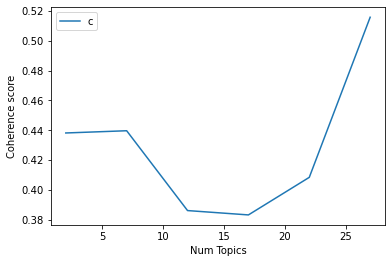

In [65]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [66]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.4382
index: 1 | Num Topics = 7  has Coherence Value of 0.4397
index: 2 | Num Topics = 12  has Coherence Value of 0.3862
index: 3 | Num Topics = 17  has Coherence Value of 0.3833
index: 4 | Num Topics = 22  has Coherence Value of 0.4085
index: 5 | Num Topics = 27  has Coherence Value of 0.5158


In [67]:
# Select optimal number of topics
optimal_model_us_score2 = model_list_us_score2[5]

In [68]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score2 = pyLDAvis.gensim_models.prepare(optimal_model_us_score2, corpus_us_score2, id2word_us_score2)

In [69]:
print("pyLDAVis for us topics for score=2:")
vis_us_score2

pyLDAVis for us topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
24     0.117742  0.080879       1        1  9.027921
23     0.097659 -0.168065       2        1  8.243665
2      0.142824 -0.029834       3        1  7.543396
13     0.118854 -0.066493       4        1  6.526689
17     0.026257  0.092325       5        1  5.934910
15    -0.076738 -0.084605       6        1  5.671675
21     0.086798  0.046202       7        1  5.538859
9      0.102516 -0.080880       8        1  5.492845
6      0.028371  0.152193       9        1  5.278974
25    -0.017345  0.104002      10        1  4.781580
20     0.055016 -0.022627      11        1  4.670654
8      0.072239  0.078508      12        1  4.635660
10     0.066062 -0.006850      13        1  4.552670
1      0.064622  0.008714      14        1  4.066268
16     0.076234 -0.005763      15        1  3.360787
12     0.020046  0.013086      16        1  2.869590
18    -0.044519 -0.022308      17        1  2.566140
3     -0.072619 -0.051936      18        1  2.107033
22    -0.087850 -0.128962      19        1  1.858611
4     -0.065116  0.008900      20        1  1.058873
7     -0.117556  0.029237      21        1  0.862867
19    -0.118960 -0.013635      22        1  0.858310
26    -0.076471  0.025191      23        1  0.810884
11    -0.084349  0.016568      24        1  0.710571
14    -0.110232  0.020007      25        1  0.582205
5     -0.101743  0.003073      26        1  0.194181
0     -0.101743  0.003073      27        1  0.194181, topic_info=         Term      Freq      Total Category  logprob  loglift
23     tiktok  45.00000  45.000000  Default  30.0000  30.0000
159       tok  15.00000  15.000000  Default  29.0000  29.0000
87     follow  19.00000  19.000000  Default  28.0000  28.0000
209       tik  11.00000  11.000000  Default  27.0000  27.0000
26      video  44.00000  44.000000  Default  26.0000  26.0000
..        ...       ...        ...      ...      ...      ...
251       age   0.00565   1.460050  Topic27  -6.5294   0.6895
256     byter   0.00565   1.460050  Topic27  -6.5294   0.6895
126    pretty   0.00565   6.739647  Topic27  -6.5294  -0.8400
255      bury   0.00565   1.460050  Topic27  -6.5294   0.6895
105  category   0.00565   3.110171  Topic27  -6.5294  -0.0667

[1366 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
31        5  0.686435    aaaaa
101       1  0.105259     able
101       2  0.105259     able
101       3  0.105259     able
101       7  0.105259     able
...     ...       ...      ...
99        3  0.260561  youtube
99        4  0.260561  youtube
99       13  0.260561  youtube
99       14  0.260561  youtube
638       9  0.693803     zynn

[1271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[25, 24, 3, 14, 18, 16, 22, 10, 7, 26, 21, 9, 11, 2, 17, 13, 19, 4, 23, 5, 8, 20, 27, 12, 15, 6, 1])

## LDA Topic Modelling (Rating = 3)

In [70]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_us_score3 = clash_ios_us_review_YearMonth_score3.review.values.tolist()
review_words_us_score3 = list(sent_to_words(review_us_score3))
print(review_words_us_score3[:1])

[['why', 'cant', 'you', 'see', 'how', 'many', 'followers', 'they', 'have', 'every', 'time', 'you', 'go', 'to', 'the', 'profiles', 'you', 'dont', 'see', 'how', 'many', 'followers', 'they', 'have', 'or', 'loops']]


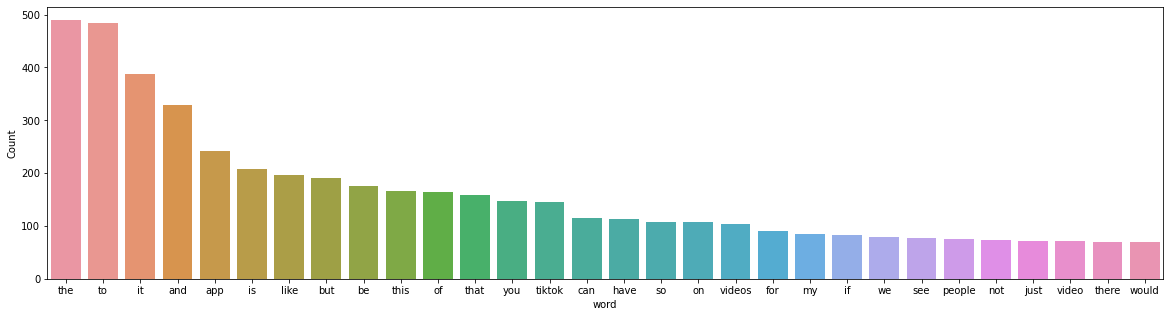

In [71]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score3))

In [72]:
# Clean text
review_us_ready_score3 = process_words(review_words_us_score3)  # processed Text Data! - move to each section


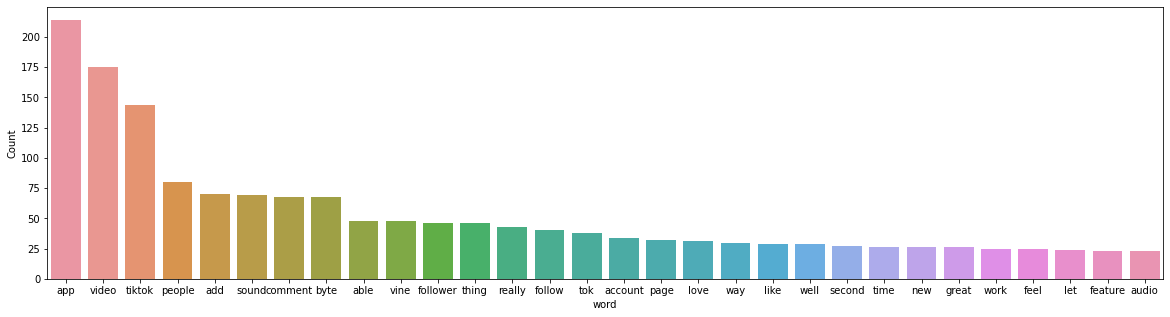

In [73]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score3))


In [74]:
# Create Dictionary
id2word_us_score3 = corpora.Dictionary(review_us_ready_score3)

2021-10-16 01:42:46,959 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 01:42:46,973 [INFO] gensim.corpora.dictionary - built Dictionary(987 unique tokens: ['follower', 'loop', 'nt', 'profile', 'time']...) from 256 documents (total 4311 corpus positions)
2021-10-16 01:42:46,975 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(987 unique tokens: ['follower', 'loop', 'nt', 'profile', 'time']...) from 256 documents (total 4311 corpus positions)", 'datetime': '2021-10-16T01:42:46.974950', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [75]:
# Create Corpus: Term Document Frequency
corpus_us_score3 = [id2word_us_score3.doc2bow(text) for text in review_us_ready_score3]

In [76]:
# Training LDA model
model_list_us_score3, coherence_values_us_score3 = compute_coherence_values(dictionary=id2word_us_score3, corpus=corpus_us_score3, 
                                                              texts=review_us_ready_score3, limit=30, start=2, step=5)


2021-10-16 01:42:47,001 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 01:42:47,002 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 01:42:47,005 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:42:47,008 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 256 documents, updating model once every 256 documents, evaluating perplexity every 256 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:42:47,747 [INFO] gensim.models.ldamodel - -7.480 per-word bound, 178.6 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:42:47,750 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #256/256
2021-10-16 01:42:48,619 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.044*"app" + 0.033*"video" + 0.024*"tiktok" + 0.018*"add" + 0.016*"sound" + 0.015*"comment" + 0.014*"by

2021-10-16 01:42:58,816 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"app" + 0.031*"tiktok" + 0.026*"video" + 0.016*"people" + 0.015*"tok" + 0.011*"account" + 0.010*"byte" + 0.010*"follower" + 0.009*"tik" + 0.009*"ban"
2021-10-16 01:42:58,818 [INFO] gensim.models.ldamodel - topic diff=0.012890, rho=0.301511
2021-10-16 01:42:59,343 [INFO] gensim.models.ldamodel - -6.212 per-word bound, 74.1 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:42:59,346 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #256/256
2021-10-16 01:42:59,779 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.038*"video" + 0.025*"tiktok" + 0.020*"sound" + 0.019*"comment" + 0.019*"add" + 0.015*"byte" + 0.015*"people" + 0.013*"able" + 0.011*"follow"
2021-10-16 01:42:59,781 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"app" + 0.031*"tiktok" + 0.026*"video" + 0.016*"people" + 0.015*"tok" + 0.011*"account" + 0.010*"byte" + 0.01

2021-10-16 01:43:07,630 [INFO] gensim.models.ldamodel - topic diff=0.006733, rho=0.218218
2021-10-16 01:43:08,067 [INFO] gensim.models.ldamodel - -6.204 per-word bound, 73.7 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:43:08,071 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #256/256
2021-10-16 01:43:08,423 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"video" + 0.039*"app" + 0.025*"tiktok" + 0.021*"sound" + 0.020*"comment" + 0.019*"add" + 0.015*"byte" + 0.015*"people" + 0.014*"able" + 0.012*"follow"
2021-10-16 01:43:08,426 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.030*"tiktok" + 0.023*"video" + 0.017*"tok" + 0.016*"people" + 0.012*"account" + 0.011*"tik" + 0.010*"ban" + 0.010*"byte" + 0.009*"follower"
2021-10-16 01:43:08,427 [INFO] gensim.models.ldamodel - topic diff=0.006560, rho=0.213201
2021-10-16 01:43:08,885 [INFO] gensim.models.ldamodel - -6.204 per-word bound, 73.7 perplexity esti

2021-10-16 01:43:16,946 [INFO] gensim.models.ldamodel - -6.200 per-word bound, 73.5 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:43:16,948 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #256/256
2021-10-16 01:43:17,353 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"video" + 0.040*"app" + 0.025*"tiktok" + 0.021*"sound" + 0.020*"comment" + 0.018*"add" + 0.015*"people" + 0.015*"byte" + 0.014*"able" + 0.012*"follow"
2021-10-16 01:43:17,355 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.031*"tiktok" + 0.022*"video" + 0.018*"tok" + 0.015*"people" + 0.012*"account" + 0.011*"tik" + 0.011*"ban" + 0.009*"byte" + 0.009*"really"
2021-10-16 01:43:17,357 [INFO] gensim.models.ldamodel - topic diff=0.005475, rho=0.176777
2021-10-16 01:43:17,918 [INFO] gensim.models.ldamodel - -6.199 per-word bound, 73.5 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:43:17,919 [IN

2021-10-16 01:43:25,957 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #256/256
2021-10-16 01:43:26,452 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"video" + 0.040*"app" + 0.025*"tiktok" + 0.021*"sound" + 0.020*"comment" + 0.019*"add" + 0.016*"people" + 0.015*"byte" + 0.014*"able" + 0.012*"follow"
2021-10-16 01:43:26,468 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.031*"tiktok" + 0.022*"video" + 0.018*"tok" + 0.014*"people" + 0.012*"account" + 0.012*"tik" + 0.011*"ban" + 0.009*"byte" + 0.009*"really"
2021-10-16 01:43:26,470 [INFO] gensim.models.ldamodel - topic diff=0.003217, rho=0.154303
2021-10-16 01:43:26,972 [INFO] gensim.models.ldamodel - -6.196 per-word bound, 73.3 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:43:26,974 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #256/256
2021-10-16 01:43:27,257 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"video" + 0.040

2021-10-16 01:43:34,194 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 01:43:38,616 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 01:43:38,676 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 267 virtual documents
2021-10-16 01:43:38,978 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 01:43:38,979 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 01:43:38,981 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:43:38,985 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 256 documents, updating model once every 256 documents, evaluating perplexity every 256 documents, iterating 50x with a con

2021-10-16 01:43:42,943 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.043*"video" + 0.042*"app" + 0.025*"people" + 0.019*"comment" + 0.015*"really" + 0.014*"follow" + 0.013*"thing" + 0.012*"follower" + 0.012*"tok" + 0.012*"great"
2021-10-16 01:43:42,944 [INFO] gensim.models.ldamodel - topic diff=0.081534, rho=0.408248
2021-10-16 01:43:43,286 [INFO] gensim.models.ldamodel - -6.467 per-word bound, 88.5 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:43:43,288 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #256/256
2021-10-16 01:43:43,698 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.023*"give" + 0.018*"video" + 0.014*"follower" + 0.014*"save" + 0.014*"really" + 0.014*"star" + 0.014*"guy" + 0.014*"potential" + 0.014*"draft" + 0.013*"sound"
2021-10-16 01:43:43,724 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.075*"tiktok" + 0.046*"app" + 0.021*"people" + 0.019*"vine" + 0.018*"video" + 0.012*"thing" + 0.011*"page

2021-10-16 01:43:47,387 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.041*"video" + 0.034*"app" + 0.033*"add" + 0.022*"sound" + 0.021*"byte" + 0.019*"comment" + 0.019*"able" + 0.015*"tok" + 0.014*"people" + 0.013*"thing"
2021-10-16 01:43:47,391 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"tiktok" + 0.048*"app" + 0.020*"people" + 0.019*"vine" + 0.017*"video" + 0.012*"thing" + 0.012*"ban" + 0.012*"page" + 0.012*"sound" + 0.010*"byte"
2021-10-16 01:43:47,393 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.063*"app" + 0.038*"video" + 0.031*"tiktok" + 0.021*"byte" + 0.018*"comment" + 0.016*"sound" + 0.012*"vine" + 0.011*"people" + 0.010*"love" + 0.010*"add"
2021-10-16 01:43:47,394 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.021*"sound" + 0.018*"tok" + 0.015*"tik" + 0.014*"app" + 0.013*"delete" + 0.013*"video" + 0.011*"filter" + 0.010*"still" + 0.010*"feel" + 0.010*"kinda"
2021-10-16 01:43:47,395 [INFO] gensim.models.ldamodel - topic diff=0.013894, rho=0.288675


2021-10-16 01:43:50,990 [INFO] gensim.models.ldamodel - topic diff=0.006501, rho=0.242536
2021-10-16 01:43:51,404 [INFO] gensim.models.ldamodel - -6.443 per-word bound, 87.0 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:43:51,406 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #256/256
2021-10-16 01:43:51,617 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.021*"give" + 0.016*"video" + 0.015*"follower" + 0.015*"star" + 0.015*"guy" + 0.015*"really" + 0.015*"potential" + 0.015*"save" + 0.015*"draft" + 0.010*"tiktok"
2021-10-16 01:43:51,621 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"account" + 0.046*"video" + 0.024*"app" + 0.018*"new" + 0.013*"work" + 0.012*"follow" + 0.012*"view" + 0.011*"let" + 0.011*"private" + 0.011*"people"
2021-10-16 01:43:51,623 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.043*"app" + 0.042*"video" + 0.026*"people" + 0.019*"comment" + 0.015*"follow" + 0.015*"really" + 0.013*"thin

2021-10-16 01:43:55,239 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.043*"app" + 0.042*"video" + 0.026*"people" + 0.019*"comment" + 0.015*"follow" + 0.015*"really" + 0.013*"thing" + 0.013*"follower" + 0.013*"great" + 0.012*"tok"
2021-10-16 01:43:55,242 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.042*"video" + 0.033*"app" + 0.033*"add" + 0.023*"sound" + 0.021*"byte" + 0.020*"comment" + 0.019*"able" + 0.014*"people" + 0.014*"tok" + 0.013*"thing"
2021-10-16 01:43:55,244 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.019*"tok" + 0.017*"sound" + 0.016*"tik" + 0.013*"delete" + 0.012*"video" + 0.011*"still" + 0.011*"feel" + 0.011*"filter" + 0.010*"app" + 0.010*"kinda"
2021-10-16 01:43:55,245 [INFO] gensim.models.ldamodel - topic diff=0.003483, rho=0.208514
2021-10-16 01:43:55,653 [INFO] gensim.models.ldamodel - -6.440 per-word bound, 86.8 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:43:55,681 [INFO] gensim.models.ldamodel - 

2021-10-16 01:43:58,627 [INFO] gensim.models.ldamodel - topic diff=0.002221, rho=0.188982
2021-10-16 01:43:59,025 [INFO] gensim.models.ldamodel - -6.438 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:43:59,030 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #256/256
2021-10-16 01:43:59,375 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.019*"tok" + 0.016*"tik" + 0.014*"delete" + 0.013*"sound" + 0.012*"video" + 0.011*"still" + 0.011*"feel" + 0.010*"kinda" + 0.010*"app" + 0.010*"filter"
2021-10-16 01:43:59,380 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"tiktok" + 0.049*"app" + 0.021*"people" + 0.018*"vine" + 0.017*"video" + 0.013*"sound" + 0.012*"thing" + 0.012*"ban" + 0.012*"page" + 0.010*"byte"
2021-10-16 01:43:59,386 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"account" + 0.046*"video" + 0.024*"app" + 0.018*"new" + 0.013*"work" + 0.012*"follow" + 0.012*"view" + 0.012*"privat

2021-10-16 01:44:02,865 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.062*"app" + 0.039*"video" + 0.031*"tiktok" + 0.021*"byte" + 0.018*"comment" + 0.016*"sound" + 0.012*"vine" + 0.011*"people" + 0.010*"love" + 0.010*"add"
2021-10-16 01:44:02,867 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"give" + 0.015*"video" + 0.015*"star" + 0.015*"guy" + 0.015*"follower" + 0.015*"really" + 0.015*"save" + 0.015*"potential" + 0.015*"draft" + 0.010*"tiktok"
2021-10-16 01:44:02,869 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"tok" + 0.017*"tik" + 0.014*"delete" + 0.012*"video" + 0.011*"sound" + 0.011*"still" + 0.011*"feel" + 0.010*"kinda" + 0.010*"byte" + 0.010*"app"
2021-10-16 01:44:02,871 [INFO] gensim.models.ldamodel - topic diff=0.001192, rho=0.171499
2021-10-16 01:44:03,277 [INFO] gensim.models.ldamodel - -6.437 per-word bound, 86.7 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:44:03,279 [INFO] gensim.models.ldamodel - 

2021-10-16 01:44:06,848 [INFO] gensim.models.ldamodel - -6.437 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:44:06,849 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #256/256
2021-10-16 01:44:07,121 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"tok" + 0.017*"tik" + 0.014*"delete" + 0.012*"video" + 0.011*"still" + 0.011*"feel" + 0.010*"kinda" + 0.010*"sound" + 0.010*"byte" + 0.010*"vine"
2021-10-16 01:44:07,122 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"account" + 0.046*"video" + 0.024*"app" + 0.018*"new" + 0.013*"work" + 0.012*"follow" + 0.012*"view" + 0.012*"private" + 0.011*"let" + 0.011*"people"
2021-10-16 01:44:07,124 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"tiktok" + 0.049*"app" + 0.021*"people" + 0.018*"vine" + 0.017*"video" + 0.014*"sound" + 0.012*"thing" + 0.012*"ban" + 0.012*"page" + 0.010*"byte"
2021-10-16 01:44:07,126 [INFO] gensim.models.ldamodel - t

2021-10-16 01:44:10,486 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.042*"video" + 0.034*"add" + 0.033*"app" + 0.025*"sound" + 0.021*"comment" + 0.020*"byte" + 0.019*"able" + 0.014*"people" + 0.014*"tok" + 0.013*"thing"
2021-10-16 01:44:10,488 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"tiktok" + 0.049*"app" + 0.021*"people" + 0.018*"vine" + 0.017*"video" + 0.014*"sound" + 0.012*"ban" + 0.012*"thing" + 0.012*"page" + 0.010*"byte"
2021-10-16 01:44:10,490 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.062*"app" + 0.039*"video" + 0.031*"tiktok" + 0.021*"byte" + 0.018*"comment" + 0.016*"sound" + 0.012*"vine" + 0.011*"people" + 0.010*"love" + 0.010*"add"
2021-10-16 01:44:10,492 [INFO] gensim.models.ldamodel - topic diff=0.000443, rho=0.149071
2021-10-16 01:44:10,869 [INFO] gensim.models.ldamodel - -6.437 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:44:10,870 [INFO] gensim.models.ldamodel - PROGRES

2021-10-16 01:44:14,209 [INFO] gensim.models.ldamodel - -6.437 per-word bound, 86.6 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:44:14,226 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #256/256
2021-10-16 01:44:14,502 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"tiktok" + 0.049*"app" + 0.021*"people" + 0.018*"vine" + 0.017*"video" + 0.014*"sound" + 0.012*"ban" + 0.012*"thing" + 0.012*"page" + 0.010*"byte"
2021-10-16 01:44:14,504 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.062*"app" + 0.039*"video" + 0.031*"tiktok" + 0.021*"byte" + 0.018*"comment" + 0.016*"sound" + 0.012*"vine" + 0.011*"people" + 0.010*"add" + 0.010*"love"
2021-10-16 01:44:14,505 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.047*"account" + 0.046*"video" + 0.024*"app" + 0.018*"new" + 0.013*"work" + 0.012*"follow" + 0.012*"view" + 0.012*"private" + 0.011*"let" + 0.011*"people"
2021-10-16 01:44:14,507 [INFO] gensim.models.ldamodel 

2021-10-16 01:44:24,084 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.059*"tiktok" + 0.038*"app" + 0.027*"video" + 0.020*"people" + 0.018*"vine" + 0.013*"feel" + 0.012*"post" + 0.012*"audio" + 0.012*"sound" + 0.011*"thing"
2021-10-16 01:44:24,086 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.071*"video" + 0.043*"account" + 0.026*"new" + 0.015*"able" + 0.015*"wish" + 0.014*"log" + 0.014*"app" + 0.012*"long" + 0.012*"limit" + 0.011*"show"
2021-10-16 01:44:24,087 [INFO] gensim.models.ldamodel - topic diff=0.160814, rho=0.447214
2021-10-16 01:44:24,515 [INFO] gensim.models.ldamodel - -6.642 per-word bound, 99.9 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:44:24,517 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #256/256
2021-10-16 01:44:24,792 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.059*"tiktok" + 0.038*"app" + 0.028*"video" + 0.021*"people" + 0.018*"vine" + 0.013*"feel" + 0.012*"post" + 0.012*"audio" +

2021-10-16 01:44:27,867 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #256/256
2021-10-16 01:44:28,158 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.028*"sound" + 0.019*"really" + 0.019*"tik" + 0.019*"tok" + 0.016*"video" + 0.016*"app" + 0.016*"tiktok" + 0.015*"still" + 0.013*"well" + 0.011*"delete"
2021-10-16 01:44:28,178 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.055*"video" + 0.039*"app" + 0.025*"people" + 0.020*"follow" + 0.015*"really" + 0.015*"thing" + 0.013*"comment" + 0.012*"tiktok" + 0.011*"time" + 0.011*"screen"
2021-10-16 01:44:28,191 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.072*"video" + 0.048*"account" + 0.027*"new" + 0.016*"able" + 0.015*"wish" + 0.015*"log" + 0.013*"app" + 0.012*"long" + 0.012*"limit" + 0.012*"sign"
2021-10-16 01:44:28,196 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.042*"tok" + 0.029*"app" + 0.023*"tik" + 0.022*"byte" + 0.016*"tiktok" + 0.013*"content" + 0.013*"love" + 0.013*"great" + 0.013*"record" + 0.0

2021-10-16 01:44:31,586 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"tiktok" + 0.037*"app" + 0.027*"video" + 0.021*"people" + 0.020*"vine" + 0.013*"feel" + 0.013*"post" + 0.012*"page" + 0.012*"audio" + 0.011*"thing"
2021-10-16 01:44:31,588 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.043*"tok" + 0.029*"app" + 0.023*"tik" + 0.022*"byte" + 0.015*"tiktok" + 0.014*"content" + 0.014*"love" + 0.013*"great" + 0.012*"record" + 0.011*"ban"
2021-10-16 01:44:31,594 [INFO] gensim.models.ldamodel - topic diff=0.009729, rho=0.250000
2021-10-16 01:44:31,975 [INFO] gensim.models.ldamodel - -6.584 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:44:31,987 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #256/256
2021-10-16 01:44:32,239 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.076*"app" + 0.073*"tiktok" + 0.031*"people" + 0.020*"video" + 0.018*"byte" + 0.015*"able" + 0.013*"move" + 0.013*"ban" 

2021-10-16 01:44:35,332 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #256/256
2021-10-16 01:44:35,601 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.072*"video" + 0.049*"account" + 0.027*"new" + 0.016*"able" + 0.016*"log" + 0.015*"wish" + 0.012*"app" + 0.012*"long" + 0.012*"limit" + 0.012*"sign"
2021-10-16 01:44:35,605 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.077*"app" + 0.074*"tiktok" + 0.032*"people" + 0.020*"video" + 0.018*"byte" + 0.015*"able" + 0.013*"move" + 0.013*"ban" + 0.012*"add" + 0.012*"really"
2021-10-16 01:44:35,608 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.038*"app" + 0.037*"video" + 0.024*"way" + 0.023*"add" + 0.018*"like" + 0.017*"comment" + 0.013*"issue" + 0.013*"thing" + 0.011*"follow" + 0.011*"really"
2021-10-16 01:44:35,610 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.041*"add" + 0.041*"sound" + 0.031*"profile" + 0.022*"follower" + 0.019*"app" + 0.016*"people" + 0.016*"difficult" + 0.016*"customizer" + 0.016*"col

2021-10-16 01:44:39,612 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.040*"video" + 0.030*"add" + 0.027*"byte" + 0.024*"app" + 0.022*"sound" + 0.020*"account" + 0.017*"thing" + 0.013*"follow" + 0.013*"people" + 0.012*"tiktok"
2021-10-16 01:44:39,614 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.038*"app" + 0.037*"video" + 0.024*"way" + 0.023*"add" + 0.018*"like" + 0.017*"comment" + 0.013*"issue" + 0.013*"thing" + 0.011*"follow" + 0.011*"really"
2021-10-16 01:44:39,618 [INFO] gensim.models.ldamodel - topic diff=0.002681, rho=0.192450
2021-10-16 01:44:40,022 [INFO] gensim.models.ldamodel - -6.574 per-word bound, 95.3 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:44:40,026 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #256/256
2021-10-16 01:44:40,359 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.055*"video" + 0.039*"app" + 0.024*"people" + 0.021*"follow" + 0.017*"thing" + 0.016*"really" + 0.013*"comment" +

2021-10-16 01:44:43,508 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #256/256
2021-10-16 01:44:43,695 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.077*"app" + 0.074*"tiktok" + 0.032*"people" + 0.020*"video" + 0.018*"byte" + 0.014*"able" + 0.013*"move" + 0.013*"ban" + 0.012*"add" + 0.012*"really"
2021-10-16 01:44:43,696 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.041*"add" + 0.041*"sound" + 0.031*"profile" + 0.022*"follower" + 0.019*"app" + 0.016*"difficult" + 0.016*"people" + 0.016*"color" + 0.016*"customizer" + 0.015*"roll"
2021-10-16 01:44:43,698 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.064*"app" + 0.038*"video" + 0.028*"byte" + 0.026*"sound" + 0.024*"comment" + 0.024*"well" + 0.022*"tiktok" + 0.021*"vine" + 0.014*"work" + 0.013*"page"
2021-10-16 01:44:43,701 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.038*"app" + 0.037*"video" + 0.024*"way" + 0.023*"add" + 0.018*"like" + 0.017*"comment" + 0.013*"issue" + 0.013*"thing" + 0.011*"fo

2021-10-16 01:44:47,157 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.063*"tiktok" + 0.038*"app" + 0.027*"video" + 0.021*"people" + 0.020*"vine" + 0.013*"feel" + 0.013*"post" + 0.012*"page" + 0.011*"thing" + 0.011*"second"
2021-10-16 01:44:47,164 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.041*"add" + 0.041*"sound" + 0.031*"profile" + 0.022*"follower" + 0.019*"app" + 0.016*"difficult" + 0.016*"people" + 0.016*"color" + 0.016*"customizer" + 0.015*"roll"
2021-10-16 01:44:47,177 [INFO] gensim.models.ldamodel - topic diff=0.000914, rho=0.162221
2021-10-16 01:44:47,526 [INFO] gensim.models.ldamodel - -6.572 per-word bound, 95.1 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:44:47,527 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #256/256
2021-10-16 01:44:47,754 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.063*"tiktok" + 0.038*"app" + 0.027*"video" + 0.021*"people" + 0.020*"vine" + 0.013*"feel" + 0.013*"post

2021-10-16 01:44:51,241 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #256/256
2021-10-16 01:44:51,620 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.064*"app" + 0.038*"video" + 0.029*"byte" + 0.026*"sound" + 0.024*"comment" + 0.024*"well" + 0.022*"tiktok" + 0.021*"vine" + 0.014*"work" + 0.013*"page"
2021-10-16 01:44:51,622 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.072*"video" + 0.049*"account" + 0.027*"new" + 0.016*"able" + 0.016*"log" + 0.015*"wish" + 0.012*"app" + 0.012*"long" + 0.012*"limit" + 0.012*"sign"
2021-10-16 01:44:51,625 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.063*"tiktok" + 0.038*"app" + 0.027*"video" + 0.021*"people" + 0.020*"vine" + 0.013*"feel" + 0.013*"post" + 0.012*"page" + 0.011*"thing" + 0.011*"second"
2021-10-16 01:44:51,627 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.077*"app" + 0.074*"tiktok" + 0.032*"people" + 0.020*"video" + 0.018*"byte" + 0.014*"able" + 0.013*"move" + 0.013*"ban" + 0.012*"add" + 0.012*"real

2021-10-16 01:44:55,202 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.064*"app" + 0.038*"video" + 0.029*"byte" + 0.026*"sound" + 0.024*"comment" + 0.024*"well" + 0.022*"tiktok" + 0.021*"vine" + 0.014*"work" + 0.013*"page"
2021-10-16 01:44:55,204 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.041*"video" + 0.030*"add" + 0.027*"byte" + 0.023*"app" + 0.022*"sound" + 0.021*"account" + 0.017*"thing" + 0.013*"follow" + 0.013*"people" + 0.012*"tiktok"
2021-10-16 01:44:55,207 [INFO] gensim.models.ldamodel - topic diff=0.000352, rho=0.142857
2021-10-16 01:44:55,542 [INFO] gensim.models.ldamodel - -6.571 per-word bound, 95.1 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:44:55,545 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #256/256
2021-10-16 01:44:55,795 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.044*"tok" + 0.029*"app" + 0.024*"tik" + 0.020*"byte" + 0.015*"tiktok" + 0.014*"content" + 0.014*"love" + 0.013*"gr

2021-10-16 01:45:07,627 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.060*"app" + 0.037*"tiktok" + 0.024*"account" + 0.023*"love" + 0.022*"video" + 0.020*"add" + 0.016*"people" + 0.015*"vine" + 0.013*"feature" + 0.011*"follower"
2021-10-16 01:45:07,631 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.065*"app" + 0.047*"video" + 0.028*"comment" + 0.026*"sound" + 0.026*"tiktok" + 0.015*"vine" + 0.012*"byte" + 0.012*"add" + 0.011*"love" + 0.010*"work"
2021-10-16 01:45:07,634 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.041*"account" + 0.035*"new" + 0.025*"video" + 0.024*"byte" + 0.023*"save" + 0.018*"profile" + 0.017*"sign" + 0.012*"vine" + 0.012*"follower" + 0.012*"issue"
2021-10-16 01:45:07,638 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.061*"video" + 0.036*"sound" + 0.030*"add" + 0.024*"byte" + 0.020*"app" + 0.014*"pause" + 0.014*"save" + 0.013*"filter" + 0.013*"account" + 0.011*"screen"
2021-10-16 01:45:07,641 [INFO] gensim.models.ldamodel - topic #14 (0.059)

2021-10-16 01:45:11,635 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.058*"app" + 0.037*"tiktok" + 0.025*"account" + 0.023*"love" + 0.022*"video" + 0.018*"add" + 0.016*"people" + 0.016*"vine" + 0.014*"feature" + 0.013*"reply"
2021-10-16 01:45:11,637 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.064*"app" + 0.048*"tiktok" + 0.031*"video" + 0.028*"people" + 0.020*"able" + 0.020*"comment" + 0.016*"byte" + 0.016*"add" + 0.014*"audio" + 0.013*"sound"
2021-10-16 01:45:11,639 [INFO] gensim.models.ldamodel - topic diff=0.055339, rho=0.333333
2021-10-16 01:45:11,994 [INFO] gensim.models.ldamodel - -6.710 per-word bound, 104.7 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:45:11,998 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #256/256
2021-10-16 01:45:12,269 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.054*"sound" + 0.030*"profile" + 0.029*"follower" + 0.023*"app" + 0.020*"improvement" + 0.015*"press" + 0.015*"

2021-10-16 01:45:15,638 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #256/256
2021-10-16 01:45:15,907 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.061*"app" + 0.050*"video" + 0.030*"comment" + 0.025*"sound" + 0.020*"tiktok" + 0.015*"vine" + 0.014*"add" + 0.013*"byte" + 0.012*"love" + 0.011*"work"
2021-10-16 01:45:15,912 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.040*"account" + 0.027*"app" + 0.027*"byte" + 0.020*"put" + 0.020*"log" + 0.014*"video" + 0.014*"let" + 0.014*"content" + 0.014*"people" + 0.014*"record"
2021-10-16 01:45:15,917 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.065*"app" + 0.048*"tiktok" + 0.031*"video" + 0.028*"people" + 0.020*"able" + 0.019*"comment" + 0.016*"byte" + 0.016*"add" + 0.014*"audio" + 0.013*"sound"
2021-10-16 01:45:15,920 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.066*"video" + 0.037*"app" + 0.022*"tiktok" + 0.018*"time" + 0.016*"post" + 0.014*"people" + 0.014*"short" + 0.012*"really" + 0.012*"follow" +

2021-10-16 01:45:19,275 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.034*"feature" + 0.030*"comment" + 0.021*"tiktok" + 0.014*"add" + 0.014*"filter" + 0.014*"sound" + 0.014*"able" + 0.014*"new" + 0.014*"upload" + 0.014*"clip"
2021-10-16 01:45:19,277 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.116*"tok" + 0.074*"tik" + 0.024*"feature" + 0.022*"guy" + 0.022*"app" + 0.019*"comment" + 0.019*"people" + 0.018*"thing" + 0.016*"able" + 0.013*"filter"
2021-10-16 01:45:19,279 [INFO] gensim.models.ldamodel - topic diff=0.004683, rho=0.223607
2021-10-16 01:45:19,620 [INFO] gensim.models.ldamodel - -6.694 per-word bound, 103.5 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:45:19,622 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #256/256
2021-10-16 01:45:19,895 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"account" + 0.036*"new" + 0.024*"video" + 0.024*"byte" + 0.024*"save" + 0.018*"profile" + 0.018*"sign" +

2021-10-16 01:45:23,010 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #256/256
2021-10-16 01:45:23,266 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.034*"feature" + 0.030*"comment" + 0.021*"tiktok" + 0.014*"add" + 0.014*"filter" + 0.014*"sound" + 0.014*"able" + 0.014*"new" + 0.014*"clip" + 0.014*"upload"
2021-10-16 01:45:23,268 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.068*"sound" + 0.044*"app" + 0.028*"cool" + 0.027*"option" + 0.022*"add" + 0.014*"ticktock" + 0.014*"kind" + 0.014*"sync" + 0.014*"music" + 0.014*"confusing"
2021-10-16 01:45:23,271 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.094*"tiktok" + 0.045*"app" + 0.021*"people" + 0.019*"ban" + 0.017*"video" + 0.017*"vine" + 0.017*"byte" + 0.014*"page" + 0.013*"well" + 0.012*"feel"
2021-10-16 01:45:23,274 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.064*"app" + 0.048*"tiktok" + 0.031*"video" + 0.028*"people" + 0.019*"comment" + 0.019*"able" + 0.016*"byte" + 0.016*"add" + 0.014*"audi

2021-10-16 01:45:26,539 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.042*"follow" + 0.033*"account" + 0.021*"view" + 0.021*"thing" + 0.021*"people" + 0.019*"private" + 0.018*"option" + 0.014*"profile" + 0.014*"notification" + 0.014*"page"
2021-10-16 01:45:26,541 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"account" + 0.036*"new" + 0.024*"video" + 0.024*"byte" + 0.024*"save" + 0.018*"profile" + 0.018*"sign" + 0.012*"vine" + 0.012*"follower" + 0.012*"love"
2021-10-16 01:45:26,543 [INFO] gensim.models.ldamodel - topic diff=0.002307, rho=0.179605
2021-10-16 01:45:26,994 [INFO] gensim.models.ldamodel - -6.687 per-word bound, 103.0 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:45:26,995 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #256/256
2021-10-16 01:45:27,308 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.066*"video" + 0.048*"sound" + 0.033*"add" + 0.025*"byte" + 0.021*"app" + 0.020*"save" + 0.016

2021-10-16 01:45:30,275 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #256/256
2021-10-16 01:45:30,524 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.066*"video" + 0.040*"app" + 0.026*"follow" + 0.023*"add" + 0.014*"page" + 0.013*"comment" + 0.013*"view" + 0.013*"profile" + 0.013*"audio" + 0.013*"new"
2021-10-16 01:45:30,527 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.064*"video" + 0.045*"app" + 0.029*"vine" + 0.022*"long" + 0.015*"tiktok" + 0.015*"back" + 0.015*"freeze" + 0.015*"upload" + 0.015*"feel" + 0.015*"complete"
2021-10-16 01:45:30,537 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.042*"follow" + 0.033*"account" + 0.021*"view" + 0.021*"thing" + 0.021*"people" + 0.019*"private" + 0.018*"option" + 0.014*"profile" + 0.014*"notification" + 0.014*"page"
2021-10-16 01:45:30,540 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.064*"app" + 0.048*"tiktok" + 0.031*"video" + 0.028*"people" + 0.019*"comment" + 0.017*"able" + 0.016*"byte" + 0.016*"a

2021-10-16 01:45:33,882 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.119*"tok" + 0.076*"tik" + 0.025*"feature" + 0.024*"app" + 0.022*"guy" + 0.019*"comment" + 0.019*"people" + 0.019*"thing" + 0.014*"able" + 0.013*"exactly"
2021-10-16 01:45:33,883 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.064*"app" + 0.048*"tiktok" + 0.031*"video" + 0.028*"people" + 0.019*"comment" + 0.017*"able" + 0.016*"byte" + 0.016*"add" + 0.014*"audio" + 0.012*"move"
2021-10-16 01:45:33,886 [INFO] gensim.models.ldamodel - topic diff=0.001653, rho=0.154303
2021-10-16 01:45:34,199 [INFO] gensim.models.ldamodel - -6.681 per-word bound, 102.6 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:45:34,201 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #256/256
2021-10-16 01:45:34,504 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.068*"video" + 0.036*"app" + 0.023*"tiktok" + 0.018*"time" + 0.016*"post" + 0.014*"people" + 0.014*"short" + 0.01

2021-10-16 01:45:37,593 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #256/256
2021-10-16 01:45:37,882 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.119*"tok" + 0.076*"tik" + 0.025*"feature" + 0.024*"app" + 0.022*"guy" + 0.019*"thing" + 0.019*"comment" + 0.019*"people" + 0.014*"exactly" + 0.013*"ban"
2021-10-16 01:45:37,884 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.064*"sound" + 0.044*"app" + 0.028*"cool" + 0.028*"option" + 0.022*"add" + 0.014*"ticktock" + 0.014*"kind" + 0.014*"sync" + 0.014*"music" + 0.014*"confusing"
2021-10-16 01:45:37,887 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.040*"account" + 0.027*"app" + 0.027*"byte" + 0.020*"put" + 0.020*"log" + 0.014*"content" + 0.014*"video" + 0.014*"let" + 0.014*"people" + 0.014*"record"
2021-10-16 01:45:37,889 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.066*"video" + 0.040*"app" + 0.026*"follow" + 0.023*"add" + 0.014*"page" + 0.014*"comment" + 0.014*"view" + 0.013*"audio" + 0.013*"new" 

2021-10-16 01:45:48,746 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.060*"video" + 0.043*"app" + 0.016*"byte" + 0.016*"able" + 0.015*"follower" + 0.014*"follow" + 0.014*"time" + 0.012*"new" + 0.011*"page" + 0.011*"post"
2021-10-16 01:45:48,747 [INFO] gensim.models.ldamodel - topic diff=16.997837, rho=1.000000
2021-10-16 01:45:49,036 [INFO] gensim.models.ldamodel - -7.117 per-word bound, 138.8 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:45:49,042 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #256/256
2021-10-16 01:45:49,262 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.070*"app" + 0.042*"video" + 0.029*"tiktok" + 0.024*"sound" + 0.020*"vine" + 0.016*"work" + 0.013*"love" + 0.012*"byte" + 0.011*"great" + 0.010*"way"
2021-10-16 01:45:49,264 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.049*"app" + 0.041*"video" + 0.018*"people" + 0.016*"way" + 0.016*"camera" + 0.016*"short" + 0.016*"time" + 0.014*"thing"

2021-10-16 01:45:52,733 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.040*"follow" + 0.030*"page" + 0.020*"thing" + 0.020*"crash" + 0.020*"notification" + 0.020*"profile" + 0.020*"time" + 0.010*"love" + 0.010*"stat" + 0.010*"flair"
2021-10-16 01:45:52,737 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.037*"byte" + 0.029*"comment" + 0.028*"like" + 0.019*"add" + 0.019*"thing" + 0.019*"look" + 0.017*"interface" + 0.017*"well" + 0.015*"thread" + 0.010*"let"
2021-10-16 01:45:52,740 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.071*"sound" + 0.026*"app" + 0.026*"follow" + 0.020*"cool" + 0.020*"tiktok" + 0.020*"follower" + 0.015*"else" + 0.014*"able" + 0.013*"understand" + 0.013*"view"
2021-10-16 01:45:52,742 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.055*"account" + 0.053*"byte" + 0.030*"app" + 0.025*"love" + 0.023*"thing" + 0.021*"new" + 0.018*"able" + 0.017*"kinda" + 0.014*"post" + 0.013*"people"
2021-10-16 01:45:52,743 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 01:45:56,141 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.031*"app" + 0.021*"improvement" + 0.021*"feel" + 0.021*"login" + 0.021*"video" + 0.021*"still" + 0.021*"download" + 0.021*"draft" + 0.021*"bit" + 0.011*"button"
2021-10-16 01:45:56,147 [INFO] gensim.models.ldamodel - topic diff=0.021328, rho=0.277350
2021-10-16 01:45:56,533 [INFO] gensim.models.ldamodel - -6.757 per-word bound, 108.2 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:45:56,536 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #256/256
2021-10-16 01:45:56,829 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.059*"account" + 0.055*"byte" + 0.030*"app" + 0.025*"love" + 0.022*"thing" + 0.021*"new" + 0.017*"kinda" + 0.016*"able" + 0.013*"people" + 0.013*"post"
2021-10-16 01:45:56,832 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.037*"byte" + 0.030*"comment" + 0.028*"like" + 0.019*"add" + 0.019*"thing" + 0.019*"look" + 0.019*"interface

2021-10-16 01:45:59,996 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.065*"app" + 0.047*"video" + 0.032*"tiktok" + 0.024*"vine" + 0.022*"sound" + 0.019*"work" + 0.012*"love" + 0.012*"byte" + 0.010*"well" + 0.010*"great"
2021-10-16 01:45:59,998 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.032*"app" + 0.028*"able" + 0.024*"perfect" + 0.016*"people" + 0.016*"kinda" + 0.016*"help" + 0.016*"confusing" + 0.009*"video" + 0.009*"tiktok" + 0.008*"option"
2021-10-16 01:46:00,001 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.079*"sound" + 0.074*"video" + 0.061*"comment" + 0.047*"app" + 0.044*"add" + 0.034*"save" + 0.033*"able" + 0.033*"filter" + 0.023*"let" + 0.020*"reply"
2021-10-16 01:46:00,002 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.039*"follow" + 0.029*"page" + 0.028*"crash" + 0.028*"time" + 0.020*"thing" + 0.020*"notification" + 0.020*"profile" + 0.010*"love" + 0.010*"flair" + 0.010*"ability"
2021-10-16 01:46:00,004 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 01:46:03,396 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.032*"guy" + 0.024*"potential" + 0.024*"feature" + 0.017*"tiktok" + 0.016*"sound" + 0.016*"add" + 0.016*"filter" + 0.016*"page" + 0.016*"mix" + 0.016*"new"
2021-10-16 01:46:03,397 [INFO] gensim.models.ldamodel - topic diff=0.004401, rho=0.204124
2021-10-16 01:46:03,764 [INFO] gensim.models.ldamodel - -6.740 per-word bound, 106.9 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:46:03,765 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #256/256
2021-10-16 01:46:04,031 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.059*"sound" + 0.027*"app" + 0.027*"follow" + 0.020*"cool" + 0.020*"tiktok" + 0.020*"follower" + 0.020*"else" + 0.020*"button" + 0.014*"able" + 0.014*"understand"
2021-10-16 01:46:04,035 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.051*"video" + 0.044*"app" + 0.028*"like" + 0.028*"comment" + 0.027*"people" + 0.024*"tiktok" + 0.020*"f

2021-10-16 01:46:07,767 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.062*"video" + 0.042*"app" + 0.021*"able" + 0.020*"follow" + 0.016*"follower" + 0.015*"page" + 0.015*"byte" + 0.014*"time" + 0.013*"comment" + 0.013*"new"
2021-10-16 01:46:07,770 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.026*"app" + 0.026*"tiktok" + 0.026*"byte" + 0.026*"find" + 0.013*"video" + 0.013*"way" + 0.013*"audio" + 0.013*"people" + 0.013*"view" + 0.013*"confusing"
2021-10-16 01:46:07,771 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.032*"guy" + 0.024*"potential" + 0.024*"feature" + 0.017*"tiktok" + 0.016*"sound" + 0.016*"add" + 0.016*"filter" + 0.016*"page" + 0.016*"mix" + 0.016*"new"
2021-10-16 01:46:07,778 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.066*"app" + 0.047*"video" + 0.032*"tiktok" + 0.025*"vine" + 0.020*"sound" + 0.020*"work" + 0.013*"love" + 0.012*"byte" + 0.010*"way" + 0.010*"well"
2021-10-16 01:46:07,781 [INFO] gensim.models.ldamodel - topic diff=0.002813, rho=0

2021-10-16 01:46:11,633 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.041*"add" + 0.031*"audio" + 0.029*"video" + 0.026*"account" + 0.026*"create" + 0.025*"thing" + 0.022*"way" + 0.020*"people" + 0.019*"like" + 0.019*"follower"
2021-10-16 01:46:11,634 [INFO] gensim.models.ldamodel - topic diff=0.002630, rho=0.169031
2021-10-16 01:46:12,028 [INFO] gensim.models.ldamodel - -6.734 per-word bound, 106.4 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:46:12,029 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #256/256
2021-10-16 01:46:12,299 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.066*"app" + 0.047*"video" + 0.032*"tiktok" + 0.025*"vine" + 0.020*"work" + 0.020*"sound" + 0.013*"love" + 0.012*"byte" + 0.010*"way" + 0.010*"well"
2021-10-16 01:46:12,314 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.051*"video" + 0.044*"app" + 0.028*"like" + 0.028*"comment" + 0.027*"people" + 0.024*"tiktok" + 0.020*"follower" + 

2021-10-16 01:46:15,871 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.088*"app" + 0.064*"tiktok" + 0.043*"people" + 0.040*"video" + 0.019*"move" + 0.017*"really" + 0.017*"sound" + 0.016*"add" + 0.015*"content" + 0.015*"long"
2021-10-16 01:46:15,874 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.107*"tiktok" + 0.087*"app" + 0.067*"ban" + 0.020*"download" + 0.017*"well" + 0.015*"comment" + 0.015*"still" + 0.015*"anyways" + 0.015*"care" + 0.015*"lol"
2021-10-16 01:46:15,875 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.090*"tok" + 0.061*"tik" + 0.030*"app" + 0.021*"video" + 0.017*"profile" + 0.016*"sound" + 0.016*"guy" + 0.013*"follower" + 0.012*"able" + 0.012*"thing"
2021-10-16 01:46:15,877 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.064*"account" + 0.056*"byte" + 0.030*"app" + 0.025*"love" + 0.023*"thing" + 0.022*"new" + 0.017*"kinda" + 0.013*"able" + 0.013*"content" + 0.013*"delete"
2021-10-16 01:46:15,877 [INFO] gensim.models.ldamodel - topic diff=0.001687

2021-10-16 01:46:18,930 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.051*"video" + 0.044*"app" + 0.028*"like" + 0.028*"comment" + 0.027*"people" + 0.024*"tiktok" + 0.020*"follower" + 0.019*"wish" + 0.019*"add" + 0.017*"show"
2021-10-16 01:46:18,932 [INFO] gensim.models.ldamodel - topic diff=0.001252, rho=0.147442
2021-10-16 01:46:19,300 [INFO] gensim.models.ldamodel - -6.729 per-word bound, 106.1 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:46:19,301 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #256/256
2021-10-16 01:46:19,515 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.063*"video" + 0.042*"app" + 0.021*"able" + 0.020*"follow" + 0.016*"follower" + 0.015*"page" + 0.015*"byte" + 0.014*"time" + 0.013*"comment" + 0.013*"new"
2021-10-16 01:46:19,517 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.031*"app" + 0.027*"able" + 0.024*"perfect" + 0.016*"kinda" + 0.016*"help" + 0.016*"confusing" + 0.016*"people"

2021-10-16 01:46:21,956 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 01:46:27,081 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 01:46:27,151 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 276 virtual documents
2021-10-16 01:46:30,856 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-16 01:46:30,858 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-16 01:46:30,870 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:46:30,878 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 256 documents, updating model once every 256 documents, evaluating perplexity every 256 documents, iterating 50x with a 

2021-10-16 01:46:35,374 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.036*"app" + 0.023*"byte" + 0.022*"people" + 0.022*"page" + 0.016*"video" + 0.016*"work" + 0.016*"vine" + 0.016*"understand" + 0.015*"find" + 0.015*"stuff"
2021-10-16 01:46:35,375 [INFO] gensim.models.ldamodel - topic diff=0.187192, rho=0.408248
2021-10-16 01:46:35,683 [INFO] gensim.models.ldamodel - -6.903 per-word bound, 119.7 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:46:35,685 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #256/256
2021-10-16 01:46:35,972 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.040*"app" + 0.038*"loading" + 0.021*"understand" + 0.021*"symbol" + 0.021*"download" + 0.021*"work" + 0.021*"homepage" + 0.021*"basically" + 0.021*"thing" + 0.021*"perfect"
2021-10-16 01:46:35,974 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.033*"add" + 0.032*"app" + 0.026*"way" + 0.021*"people" + 0.021*"profile" + 0.021*"share" + 0

2021-10-16 01:46:39,243 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.066*"tiktok" + 0.042*"app" + 0.026*"people" + 0.024*"feel" + 0.021*"video" + 0.016*"page" + 0.014*"mean" + 0.014*"time" + 0.014*"byte" + 0.012*"vine"
2021-10-16 01:46:39,323 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.039*"app" + 0.039*"add" + 0.032*"video" + 0.026*"vine" + 0.026*"tiktok" + 0.026*"like" + 0.020*"thing" + 0.019*"audio" + 0.019*"guy" + 0.019*"way"
2021-10-16 01:46:39,329 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.047*"app" + 0.030*"feature" + 0.030*"crash" + 0.030*"time" + 0.017*"video" + 0.015*"tok" + 0.015*"ban" + 0.015*"improve" + 0.015*"wish" + 0.015*"add"
2021-10-16 01:46:39,337 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.138*"tok" + 0.090*"tik" + 0.034*"guy" + 0.026*"app" + 0.025*"ban" + 0.022*"follower" + 0.017*"cause" + 0.016*"video" + 0.014*"profile" + 0.014*"comment"
2021-10-16 01:46:39,339 [INFO] gensim.models.ldamodel - topic diff=0.035706, rho=0.288675
202

2021-10-16 01:46:42,539 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.046*"video" + 0.043*"app" + 0.022*"great" + 0.022*"comment" + 0.020*"people" + 0.019*"tiktok" + 0.016*"way" + 0.016*"short" + 0.016*"sound" + 0.015*"follow"
2021-10-16 01:46:42,543 [INFO] gensim.models.ldamodel - topic diff=0.011411, rho=0.242536
2021-10-16 01:46:42,938 [INFO] gensim.models.ldamodel - -6.826 per-word bound, 113.5 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:46:42,940 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #256/256
2021-10-16 01:46:43,257 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.039*"comment" + 0.035*"tiktok" + 0.031*"video" + 0.023*"account" + 0.022*"page" + 0.018*"byte" + 0.017*"app" + 0.017*"add" + 0.014*"follow" + 0.013*"vine"
2021-10-16 01:46:43,258 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.032*"add" + 0.032*"app" + 0.026*"way" + 0.021*"people" + 0.021*"profile" + 0.021*"share" + 0.018*"really" +

2021-10-16 01:46:46,701 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.070*"tiktok" + 0.050*"app" + 0.031*"ban" + 0.027*"byte" + 0.026*"really" + 0.025*"thing" + 0.025*"user" + 0.018*"people" + 0.015*"content" + 0.015*"video"
2021-10-16 01:46:46,711 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.115*"video" + 0.040*"wish" + 0.027*"volume" + 0.027*"show" + 0.027*"able" + 0.027*"crop" + 0.014*"exactly" + 0.014*"hate" + 0.014*"refresh" + 0.014*"feed"
2021-10-16 01:46:46,714 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.037*"sound" + 0.028*"hear" + 0.019*"comment" + 0.019*"wish" + 0.019*"loop" + 0.019*"tiktok" + 0.019*"feature" + 0.019*"filter" + 0.019*"new" + 0.019*"let"
2021-10-16 01:46:46,716 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.046*"app" + 0.030*"feature" + 0.030*"crash" + 0.030*"time" + 0.017*"video" + 0.015*"tok" + 0.015*"ban" + 0.015*"improve" + 0.015*"wish" + 0.015*"add"
2021-10-16 01:46:46,718 [INFO] gensim.models.ldamodel - topic diff=0.003998, r

2021-10-16 01:46:50,398 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.052*"tok" + 0.037*"tik" + 0.026*"love" + 0.026*"wish" + 0.024*"add" + 0.019*"app" + 0.017*"sound" + 0.017*"comment" + 0.016*"video" + 0.016*"feature"
2021-10-16 01:46:50,399 [INFO] gensim.models.ldamodel - topic diff=0.002219, rho=0.188982
2021-10-16 01:46:50,974 [INFO] gensim.models.ldamodel - -6.818 per-word bound, 112.8 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:46:50,997 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #256/256
2021-10-16 01:46:51,295 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.076*"app" + 0.071*"tiktok" + 0.043*"people" + 0.030*"video" + 0.028*"comment" + 0.024*"able" + 0.023*"sound" + 0.018*"byte" + 0.017*"add" + 0.017*"move"
2021-10-16 01:46:51,299 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.039*"app" + 0.039*"add" + 0.032*"video" + 0.026*"vine" + 0.026*"tiktok" + 0.026*"like" + 0.020*"thing" + 0.020*"aud

2021-10-16 01:46:55,690 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.058*"video" + 0.044*"add" + 0.040*"app" + 0.033*"comment" + 0.028*"like" + 0.018*"sound" + 0.017*"people" + 0.016*"byte" + 0.016*"let" + 0.016*"save"
2021-10-16 01:46:55,692 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.044*"able" + 0.042*"filter" + 0.039*"sound" + 0.035*"video" + 0.032*"people" + 0.031*"post" + 0.023*"pause" + 0.022*"byte" + 0.016*"allow" + 0.016*"record"
2021-10-16 01:46:55,693 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.053*"tok" + 0.037*"tik" + 0.026*"love" + 0.026*"wish" + 0.024*"add" + 0.019*"app" + 0.017*"sound" + 0.017*"comment" + 0.016*"video" + 0.016*"feature"
2021-10-16 01:46:55,696 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.046*"app" + 0.030*"feature" + 0.030*"crash" + 0.030*"time" + 0.017*"video" + 0.015*"tok" + 0.015*"ban" + 0.015*"improve" + 0.015*"wish" + 0.015*"add"
2021-10-16 01:46:55,699 [INFO] gensim.models.ldamodel - topic diff=0.001191, rho=0.17149

2021-10-16 01:46:59,136 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.032*"add" + 0.032*"app" + 0.026*"way" + 0.021*"profile" + 0.021*"people" + 0.021*"share" + 0.018*"really" + 0.018*"byte" + 0.014*"video" + 0.014*"account"
2021-10-16 01:46:59,138 [INFO] gensim.models.ldamodel - topic diff=0.000649, rho=0.160128
2021-10-16 01:46:59,510 [INFO] gensim.models.ldamodel - -6.816 per-word bound, 112.7 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:46:59,513 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #256/256
2021-10-16 01:46:59,779 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.039*"old" + 0.031*"feature" + 0.024*"byte" + 0.024*"tiktok" + 0.024*"account" + 0.023*"download" + 0.016*"thing" + 0.016*"back" + 0.016*"login" + 0.016*"second"
2021-10-16 01:46:59,781 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.026*"viewer" + 0.026*"follower" + 0.026*"people" + 0.026*"show" + 0.001*"guy" + 0.001*"izz" + 0.001*"g

2021-10-16 01:47:02,900 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.070*"tiktok" + 0.050*"app" + 0.031*"ban" + 0.027*"byte" + 0.026*"really" + 0.025*"thing" + 0.025*"user" + 0.019*"people" + 0.016*"content" + 0.015*"video"
2021-10-16 01:47:02,901 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.042*"confusing" + 0.040*"app" + 0.039*"loading" + 0.020*"thing" + 0.020*"work" + 0.020*"homepage" + 0.020*"symbol" + 0.020*"download" + 0.020*"understand" + 0.020*"perfect"
2021-10-16 01:47:02,902 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.039*"comment" + 0.035*"tiktok" + 0.031*"video" + 0.023*"account" + 0.022*"page" + 0.018*"byte" + 0.018*"app" + 0.017*"add" + 0.014*"follow" + 0.013*"vine"
2021-10-16 01:47:02,904 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.037*"sound" + 0.028*"hear" + 0.019*"comment" + 0.019*"wish" + 0.019*"feature" + 0.019*"tiktok" + 0.019*"new" + 0.019*"let" + 0.019*"loop" + 0.019*"filter"
2021-10-16 01:47:02,905 [INFO] gensim.models.ldamodel -

2021-10-16 01:47:06,000 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.037*"sound" + 0.028*"hear" + 0.019*"comment" + 0.019*"wish" + 0.019*"tiktok" + 0.019*"feature" + 0.019*"new" + 0.019*"let" + 0.019*"excited" + 0.019*"filter"
2021-10-16 01:47:06,002 [INFO] gensim.models.ldamodel - topic diff=0.000458, rho=0.141421
2021-10-16 01:47:06,337 [INFO] gensim.models.ldamodel - -6.816 per-word bound, 112.7 perplexity estimate based on a held-out corpus of 256 documents with 4311 words
2021-10-16 01:47:06,341 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #256/256
2021-10-16 01:47:06,532 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.067*"app" + 0.051*"video" + 0.032*"tiktok" + 0.020*"sound" + 0.016*"vine" + 0.012*"able" + 0.012*"comment" + 0.012*"different" + 0.012*"love" + 0.012*"work"
2021-10-16 01:47:06,534 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.052*"video" + 0.051*"sound" + 0.035*"app" + 0.026*"follower" + 0.018*"understand" + 0.018*"give" + 0.009*

In [77]:
%store model_list_us_score3
%store coherence_values_us_score3

Stored 'model_list_us_score3' (list)
Stored 'coherence_values_us_score3' (list)


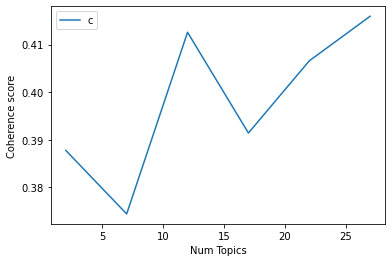

In [78]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [79]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.3878
index: 1 | Num Topics = 7  has Coherence Value of 0.3744
index: 2 | Num Topics = 12  has Coherence Value of 0.4126
index: 3 | Num Topics = 17  has Coherence Value of 0.3914
index: 4 | Num Topics = 22  has Coherence Value of 0.4066
index: 5 | Num Topics = 27  has Coherence Value of 0.416


In [129]:
# Select optimal number of topics
optimal_model_us_score3 = model_list_us_score3[2]

In [130]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score3 = pyLDAvis.gensim_models.prepare(optimal_model_us_score3, corpus_us_score3, id2word_us_score3)

In [131]:
print("pyLDAVis for us topics for score=3:")
vis_us_score3

pyLDAVis for us topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.076237  0.065987       1        1  15.229548
10    -0.122274  0.023156       2        1  15.159776
3     -0.099237 -0.035810       3        1  12.305869
4     -0.036933 -0.041735       4        1  11.828961
5     -0.018794 -0.071323       5        1  10.884355
9     -0.045410  0.028254       6        1  10.311844
11     0.021918 -0.047435       7        1   7.017755
8      0.051222  0.091181       8        1   4.897633
0      0.055335  0.077492       9        1   4.496517
6      0.073814 -0.152680      10        1   4.326412
1      0.104254  0.021078      11        1   2.028173
7      0.092342  0.041835      12        1   1.513156, topic_info=        Term        Freq       Total Category  logprob  loglift
258    sound   55.000000   55.000000  Default  30.0000  30.0000
5        add   57.000000   57.000000  Default  29.0000  29.0000
39     video  145.000000  145.000000  Default  28.0000  28.0000
392  account   27.000000   27.000000  Default  27.0000  27.0000
87    tiktok  124.000000  124.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
206     love    0.533716   25.934317  Topic12  -4.8058   0.3075
43    people    1.026389   68.350960  Topic12  -4.1519  -0.0076
12      able    0.567957   40.274286  Topic12  -4.7437  -0.0704
46       app    1.231005  180.395541  Topic12  -3.9701  -0.7963
42    follow    0.041063   33.188468  Topic12  -7.3706  -2.5039

[775 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
887       4  0.812139     abel
60        2  0.148885  ability
60        3  0.297770  ability
60        5  0.446655  ability
12        2  0.223468     able
...     ...       ...      ...
957       6  0.627122    worth
822       6  0.627123      yaw
533       7  0.637787    young
634       2  0.303010  youtube
634       6  0.606021  youtube

[1283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 11, 4, 5, 6, 10, 12, 9, 1, 7, 2, 8])

## LDA Topic Modelling (Rating = 4)

In [83]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_us_score4 = clash_ios_us_review_YearMonth_score4.review.values.tolist()
review_words_us_score4 = list(sent_to_words(review_us_score4))
print(review_words_us_score4[2:3])

[['just', 'needs', 'pause', 'feature']]


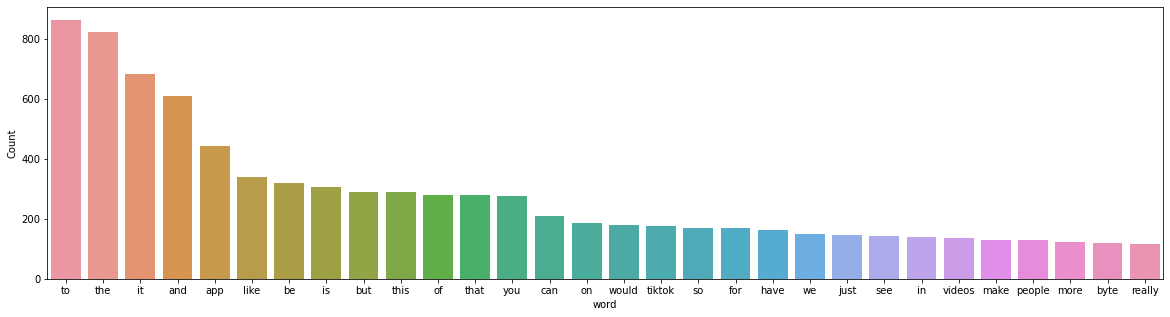

In [84]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score4))

In [85]:
# Clean text
review_us_ready_score4 = process_words(review_words_us_score4)  # processed Text Data! - move to each section

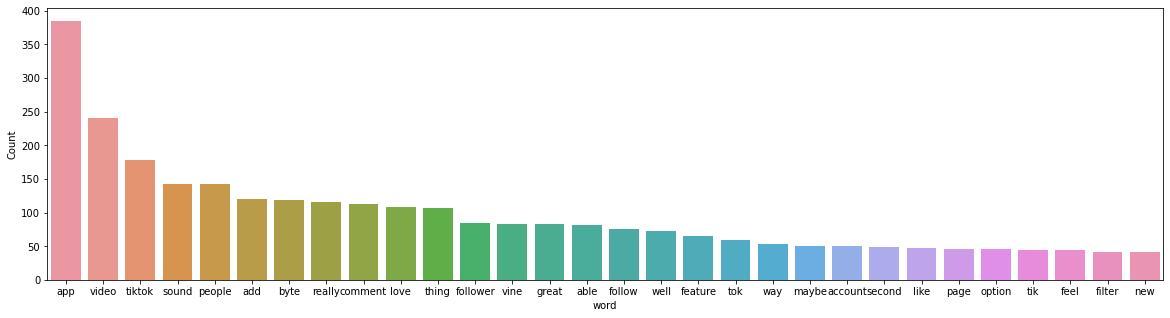

In [86]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score4))


In [87]:
# Create Dictionary
id2word_us_score4 = corpora.Dictionary(review_us_ready_score4)

2021-10-16 01:47:33,699 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 01:47:33,770 [INFO] gensim.corpora.dictionary - built Dictionary(1267 unique tokens: ['back', 'mean', 'vine', 'follow', 'ppl']...) from 463 documents (total 7747 corpus positions)
2021-10-16 01:47:33,775 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1267 unique tokens: ['back', 'mean', 'vine', 'follow', 'ppl']...) from 463 documents (total 7747 corpus positions)", 'datetime': '2021-10-16T01:47:33.775165', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [88]:
# Create Corpus: Term Document Frequency
corpus_us_score4 = [id2word_us_score4.doc2bow(text) for text in review_us_ready_score4]

In [89]:
# Training LDA model
model_list_us_score4, coherence_values_us_score4 = compute_coherence_values(dictionary=id2word_us_score4, corpus=corpus_us_score4, 
                                                              texts=review_us_ready_score4, limit=30, start=2, step=5)


2021-10-16 01:47:33,813 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 01:47:33,814 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 01:47:33,817 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:47:33,820 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 463 documents, updating model once every 463 documents, evaluating perplexity every 463 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:47:35,750 [INFO] gensim.models.ldamodel - -7.684 per-word bound, 205.6 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:47:35,758 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #463/463
2021-10-16 01:47:37,543 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"app" + 0.028*"video" + 0.025*"tiktok" + 0.019*"really" + 0.018*"people" + 0.016*"byte" + 0.016*"s

2021-10-16 01:48:01,275 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"app" + 0.024*"video" + 0.020*"add" + 0.019*"comment" + 0.014*"thing" + 0.014*"follow" + 0.013*"people" + 0.012*"sound" + 0.012*"account" + 0.010*"follower"
2021-10-16 01:48:01,278 [INFO] gensim.models.ldamodel - topic diff=0.013795, rho=0.301511
2021-10-16 01:48:02,505 [INFO] gensim.models.ldamodel - -6.232 per-word bound, 75.2 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:48:02,506 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #463/463
2021-10-16 01:48:03,535 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.050*"app" + 0.028*"video" + 0.028*"tiktok" + 0.021*"really" + 0.018*"sound" + 0.018*"people" + 0.017*"byte" + 0.015*"love" + 0.012*"vine" + 0.012*"able"
2021-10-16 01:48:03,540 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"app" + 0.024*"video" + 0.020*"add" + 0.019*"comment" + 0.014*"thing" + 0.014*"follow" + 0.014*"people" 

2021-10-16 01:48:24,450 [INFO] gensim.models.ldamodel - topic diff=0.007317, rho=0.218218
2021-10-16 01:48:25,655 [INFO] gensim.models.ldamodel - -6.227 per-word bound, 74.9 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:48:25,656 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #463/463
2021-10-16 01:48:26,493 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"app" + 0.029*"tiktok" + 0.028*"video" + 0.021*"really" + 0.019*"sound" + 0.017*"people" + 0.017*"byte" + 0.015*"love" + 0.013*"vine" + 0.012*"great"
2021-10-16 01:48:26,513 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"app" + 0.025*"video" + 0.021*"comment" + 0.020*"add" + 0.015*"thing" + 0.015*"people" + 0.014*"follow" + 0.013*"account" + 0.012*"sound" + 0.010*"follower"
2021-10-16 01:48:26,515 [INFO] gensim.models.ldamodel - topic diff=0.007129, rho=0.213201
2021-10-16 01:48:27,539 [INFO] gensim.models.ldamodel - -6.226 per-word bound, 74.9 perplexit

2021-10-16 01:48:46,590 [INFO] gensim.models.ldamodel - -6.223 per-word bound, 74.7 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:48:46,607 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #463/463
2021-10-16 01:48:47,466 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"app" + 0.029*"tiktok" + 0.027*"video" + 0.022*"really" + 0.019*"sound" + 0.017*"byte" + 0.016*"people" + 0.015*"love" + 0.013*"vine" + 0.012*"great"
2021-10-16 01:48:47,486 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"app" + 0.026*"video" + 0.022*"comment" + 0.020*"add" + 0.015*"people" + 0.015*"thing" + 0.014*"follow" + 0.013*"account" + 0.012*"sound" + 0.011*"follower"
2021-10-16 01:48:47,519 [INFO] gensim.models.ldamodel - topic diff=0.005466, rho=0.176777
2021-10-16 01:48:48,491 [INFO] gensim.models.ldamodel - -6.223 per-word bound, 74.7 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:48:48

2021-10-16 01:49:04,800 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #463/463
2021-10-16 01:49:05,565 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"app" + 0.030*"tiktok" + 0.026*"video" + 0.022*"really" + 0.019*"sound" + 0.017*"byte" + 0.016*"people" + 0.014*"love" + 0.014*"vine" + 0.012*"great"
2021-10-16 01:49:05,569 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.032*"app" + 0.028*"video" + 0.022*"comment" + 0.021*"add" + 0.016*"people" + 0.015*"thing" + 0.014*"follow" + 0.013*"account" + 0.012*"sound" + 0.011*"follower"
2021-10-16 01:49:05,573 [INFO] gensim.models.ldamodel - topic diff=0.004545, rho=0.154303
2021-10-16 01:49:06,661 [INFO] gensim.models.ldamodel - -6.220 per-word bound, 74.5 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:49:06,667 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #463/463
2021-10-16 01:49:07,684 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.051*"app" +

2021-10-16 01:49:25,073 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 01:49:30,327 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 01:49:30,365 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 490 virtual documents
2021-10-16 01:49:30,750 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 01:49:30,752 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 01:49:30,755 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:49:30,758 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 463 documents, updating model once every 463 documents, evaluating perplexity every 463 documents, iterating 50x with a con

2021-10-16 01:49:40,162 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.059*"app" + 0.032*"tiktok" + 0.027*"video" + 0.021*"byte" + 0.020*"really" + 0.018*"love" + 0.017*"people" + 0.015*"vine" + 0.013*"sound" + 0.012*"great"
2021-10-16 01:49:40,164 [INFO] gensim.models.ldamodel - topic diff=0.101192, rho=0.408248
2021-10-16 01:49:41,055 [INFO] gensim.models.ldamodel - -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:49:41,057 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #463/463
2021-10-16 01:49:41,804 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.028*"video" + 0.027*"comment" + 0.019*"love" + 0.019*"able" + 0.018*"sound" + 0.017*"thing" + 0.015*"byte" + 0.013*"tiktok" + 0.011*"let"
2021-10-16 01:49:41,805 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"app" + 0.021*"really" + 0.018*"tiktok" + 0.017*"video" + 0.012*"ability" + 0.011*"able" + 0.011*"feature" + 0.00

2021-10-16 01:49:52,089 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.039*"app" + 0.024*"tok" + 0.021*"tik" + 0.020*"video" + 0.019*"byte" + 0.015*"account" + 0.015*"really" + 0.015*"thing" + 0.015*"great" + 0.014*"add"
2021-10-16 01:49:52,096 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.038*"video" + 0.035*"people" + 0.033*"app" + 0.030*"add" + 0.029*"tiktok" + 0.024*"sound" + 0.021*"follow" + 0.018*"comment" + 0.016*"follower" + 0.015*"thing"
2021-10-16 01:49:52,100 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.059*"app" + 0.033*"tiktok" + 0.027*"video" + 0.021*"byte" + 0.020*"really" + 0.018*"love" + 0.018*"people" + 0.015*"vine" + 0.014*"sound" + 0.013*"great"
2021-10-16 01:49:52,105 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"app" + 0.021*"really" + 0.017*"tiktok" + 0.017*"video" + 0.013*"ability" + 0.011*"feature" + 0.011*"able" + 0.010*"search" + 0.009*"let" + 0.009*"love"
2021-10-16 01:49:52,112 [INFO] gensim.models.ldamodel - topic diff=0.019705

2021-10-16 01:50:01,999 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.028*"video" + 0.027*"comment" + 0.020*"love" + 0.019*"able" + 0.017*"sound" + 0.017*"thing" + 0.015*"byte" + 0.013*"tiktok" + 0.012*"let"
2021-10-16 01:50:02,007 [INFO] gensim.models.ldamodel - topic diff=0.008002, rho=0.242536
2021-10-16 01:50:03,207 [INFO] gensim.models.ldamodel - -6.484 per-word bound, 89.5 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:50:03,213 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #463/463
2021-10-16 01:50:04,422 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.040*"app" + 0.027*"tok" + 0.023*"tik" + 0.020*"video" + 0.019*"byte" + 0.015*"really" + 0.015*"account" + 0.015*"thing" + 0.015*"great" + 0.013*"add"
2021-10-16 01:50:04,424 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.038*"video" + 0.034*"people" + 0.032*"app" + 0.030*"add" + 0.029*"tiktok" + 0.024*"sound" + 0.021*"follow" + 0.018*"comm

2021-10-16 01:50:14,534 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"app" + 0.021*"really" + 0.017*"tiktok" + 0.016*"video" + 0.013*"ability" + 0.011*"feature" + 0.010*"able" + 0.010*"search" + 0.009*"let" + 0.009*"love"
2021-10-16 01:50:14,536 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.054*"sound" + 0.032*"video" + 0.032*"app" + 0.019*"second" + 0.018*"follower" + 0.017*"able" + 0.017*"people" + 0.016*"comment" + 0.015*"tok" + 0.013*"really"
2021-10-16 01:50:14,538 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.028*"video" + 0.027*"comment" + 0.020*"love" + 0.018*"able" + 0.017*"thing" + 0.017*"sound" + 0.015*"byte" + 0.013*"tiktok" + 0.012*"let"
2021-10-16 01:50:14,541 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.040*"app" + 0.029*"tok" + 0.025*"tik" + 0.020*"video" + 0.019*"byte" + 0.015*"really" + 0.015*"account" + 0.015*"thing" + 0.015*"great" + 0.013*"add"
2021-10-16 01:50:14,542 [INFO] gensim.models.ldamodel - topic diff=0.004171, r

2021-10-16 01:50:22,173 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.028*"video" + 0.027*"comment" + 0.020*"love" + 0.018*"able" + 0.017*"thing" + 0.017*"sound" + 0.015*"byte" + 0.013*"tiktok" + 0.012*"let"
2021-10-16 01:50:22,174 [INFO] gensim.models.ldamodel - topic diff=0.003056, rho=0.188982
2021-10-16 01:50:23,253 [INFO] gensim.models.ldamodel - -6.478 per-word bound, 89.2 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:50:23,254 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #463/463
2021-10-16 01:50:23,927 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"app" + 0.022*"video" + 0.015*"comment" + 0.014*"page" + 0.014*"follow" + 0.014*"pretty" + 0.013*"back" + 0.012*"thing" + 0.011*"add" + 0.011*"feature"
2021-10-16 01:50:23,931 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.056*"sound" + 0.032*"video" + 0.032*"app" + 0.019*"second" + 0.018*"follower" + 0.017*"able" + 0.017*"people" + 0.

2021-10-16 01:50:32,596 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"app" + 0.022*"video" + 0.015*"comment" + 0.014*"page" + 0.014*"follow" + 0.014*"pretty" + 0.013*"back" + 0.013*"thing" + 0.011*"add" + 0.011*"feature"
2021-10-16 01:50:32,603 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.028*"video" + 0.027*"comment" + 0.021*"love" + 0.018*"able" + 0.017*"thing" + 0.017*"sound" + 0.015*"byte" + 0.013*"tiktok" + 0.011*"let"
2021-10-16 01:50:32,606 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.057*"sound" + 0.032*"video" + 0.031*"app" + 0.019*"second" + 0.018*"able" + 0.017*"follower" + 0.017*"comment" + 0.017*"people" + 0.015*"tok" + 0.014*"really"
2021-10-16 01:50:32,612 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.035*"app" + 0.021*"really" + 0.018*"tiktok" + 0.016*"video" + 0.014*"ability" + 0.011*"feature" + 0.010*"able" + 0.010*"search" + 0.009*"let" + 0.009*"update"
2021-10-16 01:50:32,619 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 01:50:41,377 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.058*"sound" + 0.033*"video" + 0.031*"app" + 0.019*"second" + 0.018*"able" + 0.017*"follower" + 0.017*"comment" + 0.017*"people" + 0.015*"tok" + 0.014*"really"
2021-10-16 01:50:41,381 [INFO] gensim.models.ldamodel - topic diff=0.001760, rho=0.160128
2021-10-16 01:50:42,779 [INFO] gensim.models.ldamodel - -6.476 per-word bound, 89.0 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:50:42,784 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #463/463
2021-10-16 01:50:43,872 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.035*"app" + 0.021*"really" + 0.018*"tiktok" + 0.016*"video" + 0.014*"ability" + 0.011*"feature" + 0.010*"able" + 0.010*"search" + 0.009*"let" + 0.009*"update"
2021-10-16 01:50:43,877 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.061*"app" + 0.034*"tiktok" + 0.027*"video" + 0.021*"byte" + 0.020*"really" + 0.019*"love" + 0.018*"peopl

2021-10-16 01:50:51,927 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.028*"video" + 0.027*"comment" + 0.021*"love" + 0.018*"able" + 0.017*"thing" + 0.017*"sound" + 0.015*"byte" + 0.013*"tiktok" + 0.011*"little"
2021-10-16 01:50:51,929 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.039*"app" + 0.033*"tok" + 0.028*"tik" + 0.020*"byte" + 0.020*"video" + 0.016*"great" + 0.015*"account" + 0.015*"really" + 0.014*"thing" + 0.013*"add"
2021-10-16 01:50:51,934 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.058*"sound" + 0.033*"video" + 0.031*"app" + 0.019*"second" + 0.018*"able" + 0.017*"follower" + 0.017*"comment" + 0.017*"people" + 0.015*"tok" + 0.014*"really"
2021-10-16 01:50:51,936 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.038*"video" + 0.033*"people" + 0.032*"app" + 0.032*"add" + 0.029*"tiktok" + 0.026*"sound" + 0.020*"follow" + 0.019*"comment" + 0.016*"thing" + 0.016*"follower"
2021-10-16 01:50:51,939 [INFO] gensim.models.ldamodel - topic diff=0.001

2021-10-16 01:50:59,936 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"app" + 0.021*"video" + 0.015*"comment" + 0.014*"follow" + 0.014*"page" + 0.014*"pretty" + 0.013*"back" + 0.013*"thing" + 0.011*"feature" + 0.011*"option"
2021-10-16 01:50:59,938 [INFO] gensim.models.ldamodel - topic diff=0.001222, rho=0.141421
2021-10-16 01:51:00,934 [INFO] gensim.models.ldamodel - -6.474 per-word bound, 88.9 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:51:00,950 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #463/463
2021-10-16 01:51:01,707 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.028*"video" + 0.027*"comment" + 0.021*"love" + 0.018*"able" + 0.017*"thing" + 0.017*"sound" + 0.015*"byte" + 0.013*"tiktok" + 0.011*"little"
2021-10-16 01:51:01,774 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.039*"video" + 0.033*"people" + 0.032*"app" + 0.032*"add" + 0.029*"tiktok" + 0.026*"sound" + 0.020*"follow" +

2021-10-16 01:51:14,832 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.038*"sound" + 0.030*"video" + 0.026*"people" + 0.023*"app" + 0.017*"follower" + 0.016*"tok" + 0.015*"add" + 0.012*"great" + 0.012*"record" + 0.012*"tik"
2021-10-16 01:51:14,835 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.076*"app" + 0.042*"tiktok" + 0.024*"video" + 0.020*"comment" + 0.014*"love" + 0.012*"well" + 0.012*"thing" + 0.012*"able" + 0.012*"add" + 0.012*"byte"
2021-10-16 01:51:14,838 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.051*"people" + 0.035*"tiktok" + 0.035*"app" + 0.031*"add" + 0.028*"follow" + 0.026*"able" + 0.025*"video" + 0.025*"sound" + 0.025*"thing" + 0.017*"comment"
2021-10-16 01:51:14,841 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.052*"app" + 0.033*"video" + 0.022*"great" + 0.020*"vine" + 0.020*"love" + 0.017*"bot" + 0.017*"people" + 0.016*"thing" + 0.016*"follow" + 0.015*"byte"
2021-10-16 01:51:14,846 [INFO] gensim.models.ldamodel - topic diff=0.170025, rho=0.4

2021-10-16 01:51:22,961 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.046*"app" + 0.034*"tiktok" + 0.021*"really" + 0.016*"thing" + 0.012*"able" + 0.012*"people" + 0.011*"update" + 0.010*"page" + 0.010*"let" + 0.010*"video"
2021-10-16 01:51:22,963 [INFO] gensim.models.ldamodel - topic diff=0.044598, rho=0.316228
2021-10-16 01:51:23,818 [INFO] gensim.models.ldamodel - -6.605 per-word bound, 97.4 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:51:23,822 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #463/463
2021-10-16 01:51:24,582 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.050*"tok" + 0.046*"tik" + 0.039*"app" + 0.028*"really" + 0.021*"ban" + 0.020*"well" + 0.018*"tiktok" + 0.017*"video" + 0.017*"add" + 0.016*"byte"
2021-10-16 01:51:24,584 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.023*"comment" + 0.023*"video" + 0.020*"app" + 0.020*"byte" + 0.016*"love" + 0.015*"let" + 0.013*"record" + 0.012*"sound" + 

2021-10-16 01:51:33,085 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.047*"sound" + 0.037*"app" + 0.031*"ban" + 0.025*"tiktok" + 0.015*"really" + 0.014*"video" + 0.013*"comment" + 0.011*"improvement" + 0.011*"hope" + 0.010*"way"
2021-10-16 01:51:33,087 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.042*"app" + 0.034*"tiktok" + 0.020*"really" + 0.015*"thing" + 0.012*"able" + 0.012*"update" + 0.010*"people" + 0.010*"tag" + 0.010*"page" + 0.010*"let"
2021-10-16 01:51:33,092 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.050*"app" + 0.034*"video" + 0.021*"vine" + 0.019*"bot" + 0.019*"great" + 0.018*"love" + 0.018*"people" + 0.016*"thing" + 0.015*"follow" + 0.015*"byte"
2021-10-16 01:51:33,096 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.076*"app" + 0.046*"tiktok" + 0.024*"video" + 0.019*"comment" + 0.015*"love" + 0.012*"byte" + 0.012*"well" + 0.011*"thing" + 0.011*"add" + 0.011*"pretty"
2021-10-16 01:51:33,100 [INFO] gensim.models.ldamodel - topic diff=0.013749, rho

2021-10-16 01:51:41,547 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.076*"app" + 0.046*"tiktok" + 0.024*"video" + 0.018*"comment" + 0.015*"love" + 0.012*"byte" + 0.012*"well" + 0.011*"song" + 0.011*"pretty" + 0.011*"thing"
2021-10-16 01:51:41,549 [INFO] gensim.models.ldamodel - topic diff=0.007731, rho=0.218218
2021-10-16 01:51:42,435 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:51:42,437 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #463/463
2021-10-16 01:51:42,991 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.049*"video" + 0.035*"app" + 0.023*"sound" + 0.019*"great" + 0.016*"able" + 0.016*"add" + 0.015*"maybe" + 0.015*"comment" + 0.013*"byte" + 0.013*"save"
2021-10-16 01:51:43,017 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.076*"app" + 0.046*"tiktok" + 0.024*"video" + 0.018*"comment" + 0.015*"love" + 0.012*"byte" + 0.012*"well" + 0.011*"

2021-10-16 01:51:51,012 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.049*"video" + 0.035*"app" + 0.025*"sound" + 0.019*"great" + 0.016*"able" + 0.015*"add" + 0.015*"maybe" + 0.015*"comment" + 0.013*"byte" + 0.013*"save"
2021-10-16 01:51:51,014 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.041*"sound" + 0.030*"video" + 0.026*"people" + 0.023*"app" + 0.015*"record" + 0.014*"tok" + 0.014*"follower" + 0.013*"add" + 0.012*"cool" + 0.012*"second"
2021-10-16 01:51:51,018 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.040*"app" + 0.034*"tiktok" + 0.020*"really" + 0.015*"thing" + 0.012*"update" + 0.012*"able" + 0.012*"tag" + 0.010*"let" + 0.010*"find" + 0.010*"page"
2021-10-16 01:51:51,020 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"vine" + 0.030*"second" + 0.026*"app" + 0.022*"love" + 0.021*"add" + 0.020*"follow" + 0.015*"account" + 0.014*"follower" + 0.013*"section" + 0.013*"user"
2021-10-16 01:51:51,022 [INFO] gensim.models.ldamodel - topic diff=0.004779, rho=

2021-10-16 01:52:00,199 [INFO] gensim.models.ldamodel - topic diff=0.003576, rho=0.176777
2021-10-16 01:52:01,352 [INFO] gensim.models.ldamodel - -6.578 per-word bound, 95.5 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:52:01,354 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #463/463
2021-10-16 01:52:02,085 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.021*"app" + 0.019*"comment" + 0.019*"back" + 0.018*"post" + 0.017*"add" + 0.016*"account" + 0.016*"follow" + 0.015*"option" + 0.014*"sign" + 0.014*"pretty"
2021-10-16 01:52:02,119 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.032*"second" + 0.030*"vine" + 0.026*"app" + 0.021*"love" + 0.021*"add" + 0.020*"follow" + 0.014*"account" + 0.014*"follower" + 0.013*"section" + 0.013*"user"
2021-10-16 01:52:02,155 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.050*"app" + 0.033*"video" + 0.021*"vine" + 0.019*"bot" + 0.019*"great" + 0.018*"love" + 0.018*"people" + 0.

2021-10-16 01:52:10,319 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.047*"sound" + 0.037*"app" + 0.032*"ban" + 0.027*"tiktok" + 0.014*"really" + 0.014*"video" + 0.013*"comment" + 0.012*"hope" + 0.012*"improvement" + 0.009*"way"
2021-10-16 01:52:10,321 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.033*"second" + 0.031*"vine" + 0.026*"app" + 0.021*"love" + 0.020*"add" + 0.020*"follow" + 0.014*"follower" + 0.014*"account" + 0.013*"section" + 0.013*"user"
2021-10-16 01:52:10,323 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.050*"video" + 0.034*"app" + 0.027*"sound" + 0.019*"great" + 0.016*"able" + 0.015*"comment" + 0.015*"maybe" + 0.014*"add" + 0.013*"byte" + 0.013*"save"
2021-10-16 01:52:10,325 [INFO] gensim.models.ldamodel - topic diff=0.002846, rho=0.162221
2021-10-16 01:52:11,105 [INFO] gensim.models.ldamodel - -6.576 per-word bound, 95.4 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:52:11,106 [INFO] gensim.models.ldam

2021-10-16 01:52:17,630 [INFO] gensim.models.ldamodel - -6.575 per-word bound, 95.3 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:52:17,631 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #463/463
2021-10-16 01:52:18,157 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"app" + 0.030*"tiktok" + 0.021*"really" + 0.015*"thing" + 0.013*"tag" + 0.012*"update" + 0.011*"able" + 0.010*"let" + 0.010*"find" + 0.010*"content"
2021-10-16 01:52:18,160 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.076*"app" + 0.046*"tiktok" + 0.024*"video" + 0.015*"comment" + 0.014*"love" + 0.012*"byte" + 0.011*"feel" + 0.011*"pretty" + 0.011*"well" + 0.011*"song"
2021-10-16 01:52:18,163 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.051*"video" + 0.034*"app" + 0.028*"sound" + 0.018*"great" + 0.016*"able" + 0.015*"comment" + 0.015*"maybe" + 0.014*"add" + 0.013*"save" + 0.013*"byte"
2021-10-16 01:52:18,166 [INFO] gensim.models.ldamodel 

2021-10-16 01:52:26,493 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.042*"sound" + 0.028*"video" + 0.026*"people" + 0.020*"app" + 0.016*"record" + 0.015*"tok" + 0.014*"follower" + 0.013*"second" + 0.012*"cool" + 0.012*"show"
2021-10-16 01:52:26,502 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.054*"people" + 0.050*"app" + 0.047*"add" + 0.036*"tiktok" + 0.033*"sound" + 0.033*"able" + 0.030*"thing" + 0.029*"video" + 0.026*"comment" + 0.025*"follow"
2021-10-16 01:52:26,504 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.051*"video" + 0.034*"app" + 0.028*"sound" + 0.018*"great" + 0.017*"able" + 0.016*"comment" + 0.015*"maybe" + 0.013*"add" + 0.013*"save" + 0.013*"byte"
2021-10-16 01:52:26,507 [INFO] gensim.models.ldamodel - topic diff=0.001479, rho=0.142857
2021-10-16 01:52:27,366 [INFO] gensim.models.ldamodel - -6.574 per-word bound, 95.2 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:52:27,373 [INFO] gensim.models.ldamodel -

2021-10-16 01:52:44,397 [INFO] gensim.models.ldamodel - -6.942 per-word bound, 122.9 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:52:44,400 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #463/463
2021-10-16 01:52:44,836 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.063*"app" + 0.049*"video" + 0.025*"love" + 0.019*"feature" + 0.015*"able" + 0.014*"great" + 0.013*"filter" + 0.013*"people" + 0.011*"time" + 0.011*"well"
2021-10-16 01:52:44,844 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.086*"app" + 0.040*"tiktok" + 0.037*"video" + 0.016*"follow" + 0.015*"great" + 0.014*"download" + 0.013*"comment" + 0.013*"able" + 0.012*"people" + 0.011*"user"
2021-10-16 01:52:44,901 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.048*"app" + 0.020*"sound" + 0.019*"improvement" + 0.019*"feature" + 0.019*"tiktok" + 0.015*"ban" + 0.012*"video" + 0.010*"reuse" + 0.010*"filter" + 0.009*"instead"
2021-10-16 01:52:44,909 [INFO] g

2021-10-16 01:52:51,450 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.037*"love" + 0.035*"vine" + 0.030*"app" + 0.030*"video" + 0.027*"second" + 0.020*"long" + 0.019*"feel" + 0.018*"really" + 0.017*"back" + 0.017*"byte"
2021-10-16 01:52:51,453 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.063*"app" + 0.046*"video" + 0.025*"love" + 0.022*"feature" + 0.016*"great" + 0.012*"tiktok" + 0.012*"filter" + 0.012*"time" + 0.011*"able" + 0.011*"search"
2021-10-16 01:52:51,455 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.050*"video" + 0.048*"app" + 0.031*"sound" + 0.025*"great" + 0.024*"people" + 0.018*"able" + 0.015*"maybe" + 0.015*"save" + 0.015*"page" + 0.015*"love"
2021-10-16 01:52:51,459 [INFO] gensim.models.ldamodel - topic diff=0.079145, rho=0.333333
2021-10-16 01:52:52,134 [INFO] gensim.models.ldamodel - -6.761 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:52:52,136 [INFO] gensim.models.ldamodel - PR

2021-10-16 01:52:57,647 [INFO] gensim.models.ldamodel - topic diff=0.028312, rho=0.267261
2021-10-16 01:52:58,328 [INFO] gensim.models.ldamodel - -6.736 per-word bound, 106.6 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:52:58,329 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #463/463
2021-10-16 01:52:58,868 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.048*"sound" + 0.044*"comment" + 0.031*"tok" + 0.030*"app" + 0.023*"video" + 0.021*"add" + 0.021*"byte" + 0.018*"tik" + 0.017*"able" + 0.017*"thing"
2021-10-16 01:52:58,912 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.028*"sound" + 0.027*"really" + 0.018*"second" + 0.018*"vine" + 0.016*"follower" + 0.016*"video" + 0.015*"great" + 0.015*"app" + 0.014*"button" + 0.014*"well"
2021-10-16 01:52:58,937 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.045*"app" + 0.026*"byte" + 0.019*"feature" + 0.018*"comment" + 0.017*"video" + 0.017*"vine" + 0.014*"like" + 0.01

2021-10-16 01:53:04,965 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.034*"app" + 0.022*"option" + 0.019*"video" + 0.017*"thing" + 0.016*"comment" + 0.016*"add" + 0.015*"tiktok" + 0.015*"feature" + 0.014*"byte" + 0.013*"pretty"
2021-10-16 01:53:04,966 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.042*"app" + 0.027*"really" + 0.023*"great" + 0.019*"tiktok" + 0.019*"add" + 0.015*"tok" + 0.014*"byte" + 0.014*"video" + 0.013*"delete" + 0.012*"feature"
2021-10-16 01:53:04,968 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.045*"app" + 0.037*"tiktok" + 0.031*"byte" + 0.020*"video" + 0.019*"vine" + 0.018*"follower" + 0.017*"time" + 0.016*"really" + 0.014*"people" + 0.014*"love"
2021-10-16 01:53:04,969 [INFO] gensim.models.ldamodel - topic diff=0.012527, rho=0.223607
2021-10-16 01:53:05,692 [INFO] gensim.models.ldamodel - -6.721 per-word bound, 105.5 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:53:05,693 [INFO] gensim.models.ldam

2021-10-16 01:53:11,266 [INFO] gensim.models.ldamodel - topic diff=0.007676, rho=0.200000
2021-10-16 01:53:11,976 [INFO] gensim.models.ldamodel - -6.715 per-word bound, 105.0 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:53:11,977 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #463/463
2021-10-16 01:53:12,480 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.039*"love" + 0.036*"vine" + 0.031*"app" + 0.031*"second" + 0.030*"video" + 0.021*"post" + 0.020*"feel" + 0.019*"long" + 0.018*"back" + 0.018*"really"
2021-10-16 01:53:12,497 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"app" + 0.022*"option" + 0.019*"video" + 0.017*"thing" + 0.016*"tiktok" + 0.016*"comment" + 0.015*"feature" + 0.015*"add" + 0.014*"byte" + 0.014*"pretty"
2021-10-16 01:53:12,537 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"video" + 0.049*"app" + 0.037*"sound" + 0.025*"people" + 0.024*"great" + 0.020*"able" + 0.018*"save" + 0.016

2021-10-16 01:53:18,724 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.050*"app" + 0.020*"improvement" + 0.020*"feature" + 0.020*"tiktok" + 0.015*"sound" + 0.015*"ban" + 0.010*"video" + 0.010*"reuse" + 0.010*"instead" + 0.010*"pretty"
2021-10-16 01:53:18,726 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.029*"sound" + 0.028*"really" + 0.020*"second" + 0.017*"vine" + 0.017*"button" + 0.015*"video" + 0.015*"follower" + 0.015*"well" + 0.014*"great" + 0.014*"work"
2021-10-16 01:53:18,729 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.039*"love" + 0.036*"vine" + 0.032*"second" + 0.031*"app" + 0.030*"video" + 0.021*"post" + 0.020*"feel" + 0.019*"long" + 0.018*"back" + 0.018*"really"
2021-10-16 01:53:18,732 [INFO] gensim.models.ldamodel - topic diff=0.005153, rho=0.179605
2021-10-16 01:53:19,385 [INFO] gensim.models.ldamodel - -6.709 per-word bound, 104.6 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:53:19,387 [INFO] gensim.model

2021-10-16 01:53:24,948 [INFO] gensim.models.ldamodel - topic diff=0.004376, rho=0.166667
2021-10-16 01:53:25,605 [INFO] gensim.models.ldamodel - -6.704 per-word bound, 104.3 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:53:25,607 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #463/463
2021-10-16 01:53:26,122 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.037*"app" + 0.036*"add" + 0.035*"video" + 0.030*"really" + 0.028*"filter" + 0.023*"people" + 0.022*"byte" + 0.018*"sound" + 0.017*"love" + 0.014*"maybe"
2021-10-16 01:53:26,125 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.053*"app" + 0.043*"really" + 0.028*"tiktok" + 0.018*"update" + 0.016*"able" + 0.013*"record" + 0.013*"love" + 0.012*"ability" + 0.011*"let" + 0.011*"people"
2021-10-16 01:53:26,182 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.034*"video" + 0.034*"audio" + 0.030*"long" + 0.022*"option" + 0.022*"app" + 0.018*"well" + 0.017*"feel" + 0.0

2021-10-16 01:53:32,215 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.036*"app" + 0.036*"add" + 0.035*"video" + 0.030*"really" + 0.028*"filter" + 0.023*"people" + 0.022*"byte" + 0.018*"sound" + 0.017*"love" + 0.014*"maybe"
2021-10-16 01:53:32,223 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.050*"app" + 0.024*"bot" + 0.022*"follow" + 0.021*"vine" + 0.020*"tiktok" + 0.018*"video" + 0.018*"stuff" + 0.018*"great" + 0.015*"thing" + 0.014*"problem"
2021-10-16 01:53:32,225 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.045*"app" + 0.042*"tiktok" + 0.032*"byte" + 0.020*"vine" + 0.018*"follower" + 0.017*"time" + 0.016*"video" + 0.016*"really" + 0.014*"love" + 0.014*"people"
2021-10-16 01:53:32,227 [INFO] gensim.models.ldamodel - topic diff=0.003420, rho=0.154303
2021-10-16 01:53:33,010 [INFO] gensim.models.ldamodel - -6.700 per-word bound, 103.9 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:53:33,012 [INFO] gensim.models.ldamode

2021-10-16 01:53:38,710 [INFO] gensim.models.ldamodel - topic diff=0.002916, rho=0.145865
2021-10-16 01:53:39,382 [INFO] gensim.models.ldamodel - -6.696 per-word bound, 103.7 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:53:39,383 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #463/463
2021-10-16 01:53:39,855 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.041*"app" + 0.027*"really" + 0.025*"great" + 0.018*"tiktok" + 0.017*"add" + 0.016*"tok" + 0.014*"feature" + 0.013*"delete" + 0.013*"byte" + 0.013*"video"
2021-10-16 01:53:39,858 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.052*"app" + 0.043*"really" + 0.028*"tiktok" + 0.019*"update" + 0.016*"able" + 0.013*"record" + 0.013*"love" + 0.012*"ability" + 0.011*"let" + 0.011*"check"
2021-10-16 01:53:39,860 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.050*"app" + 0.020*"feature" + 0.020*"improvement" + 0.020*"tiktok" + 0.015*"sound" + 0.015*"ban" + 0.010*"video

2021-10-16 01:53:53,805 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.028*"video" + 0.025*"feature" + 0.020*"app" + 0.018*"people" + 0.018*"tiktok" + 0.017*"bit" + 0.017*"guy" + 0.017*"reuse" + 0.017*"way" + 0.017*"add"
2021-10-16 01:53:53,812 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.046*"sound" + 0.031*"app" + 0.025*"video" + 0.025*"people" + 0.021*"follower" + 0.020*"really" + 0.016*"tiktok" + 0.016*"second" + 0.014*"tap" + 0.014*"great"
2021-10-16 01:53:53,817 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.056*"app" + 0.039*"video" + 0.035*"tiktok" + 0.025*"byte" + 0.022*"add" + 0.021*"people" + 0.017*"vine" + 0.015*"tik" + 0.015*"sound" + 0.013*"follower"
2021-10-16 01:53:53,822 [INFO] gensim.models.ldamodel - topic diff=16.617844, rho=1.000000
2021-10-16 01:53:54,734 [INFO] gensim.models.ldamodel - -7.196 per-word bound, 146.6 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:53:54,736 [INFO] gensim.models.ldamodel

2021-10-16 01:54:00,783 [INFO] gensim.models.ldamodel - topic diff=0.142889, rho=0.377964
2021-10-16 01:54:01,529 [INFO] gensim.models.ldamodel - -6.860 per-word bound, 116.2 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:54:01,530 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #463/463
2021-10-16 01:54:02,051 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.046*"app" + 0.032*"bot" + 0.029*"vine" + 0.026*"thing" + 0.024*"video" + 0.022*"follower" + 0.021*"fix" + 0.019*"problem" + 0.016*"content" + 0.015*"great"
2021-10-16 01:54:02,053 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.052*"tiktok" + 0.032*"app" + 0.027*"post" + 0.022*"well" + 0.019*"love" + 0.018*"great" + 0.017*"ban" + 0.017*"comment" + 0.016*"work" + 0.014*"really"
2021-10-16 01:54:02,056 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.035*"app" + 0.024*"great" + 0.022*"really" + 0.021*"byte" + 0.019*"thing" + 0.018*"tiktok" + 0.016*"video" + 0.01

2021-10-16 01:54:08,360 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.042*"app" + 0.031*"back" + 0.027*"video" + 0.023*"follow" + 0.021*"great" + 0.020*"sign" + 0.018*"comment" + 0.018*"thing" + 0.015*"vine" + 0.015*"much"
2021-10-16 01:54:08,362 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.050*"video" + 0.043*"love" + 0.042*"app" + 0.021*"feature" + 0.014*"follower" + 0.013*"amazing" + 0.012*"way" + 0.010*"thing" + 0.010*"people" + 0.010*"channel"
2021-10-16 01:54:08,365 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.052*"app" + 0.031*"really" + 0.027*"byte" + 0.027*"video" + 0.024*"tiktok" + 0.023*"love" + 0.019*"vine" + 0.018*"people" + 0.012*"well" + 0.012*"time"
2021-10-16 01:54:08,367 [INFO] gensim.models.ldamodel - topic diff=0.033928, rho=0.277350
2021-10-16 01:54:09,105 [INFO] gensim.models.ldamodel - -6.823 per-word bound, 113.2 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:54:09,119 [INFO] gensim.models.ldamo

2021-10-16 01:54:14,533 [INFO] gensim.models.ldamodel - topic diff=0.013628, rho=0.235702
2021-10-16 01:54:15,166 [INFO] gensim.models.ldamodel - -6.811 per-word bound, 112.3 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:54:15,168 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #463/463
2021-10-16 01:54:15,620 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.050*"love" + 0.036*"vine" + 0.027*"post" + 0.027*"comment" + 0.024*"really" + 0.024*"app" + 0.022*"second" + 0.020*"video" + 0.019*"back" + 0.017*"wish"
2021-10-16 01:54:15,622 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.058*"app" + 0.044*"tiktok" + 0.036*"video" + 0.026*"byte" + 0.021*"people" + 0.020*"add" + 0.018*"vine" + 0.018*"long" + 0.012*"second" + 0.012*"follower"
2021-10-16 01:54:15,624 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.058*"app" + 0.035*"comment" + 0.032*"add" + 0.031*"tok" + 0.028*"great" + 0.028*"tik" + 0.027*"way" + 0.027*"b

2021-10-16 01:54:22,527 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.062*"sound" + 0.031*"people" + 0.028*"follower" + 0.023*"video" + 0.021*"app" + 0.020*"really" + 0.018*"show" + 0.016*"tap" + 0.016*"well" + 0.015*"second"
2021-10-16 01:54:22,529 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.066*"people" + 0.043*"app" + 0.038*"private" + 0.036*"able" + 0.035*"tiktok" + 0.035*"account" + 0.030*"sound" + 0.030*"video" + 0.025*"thing" + 0.024*"follow"
2021-10-16 01:54:22,532 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.050*"love" + 0.036*"vine" + 0.027*"comment" + 0.026*"post" + 0.024*"really" + 0.024*"app" + 0.023*"second" + 0.020*"video" + 0.020*"back" + 0.017*"wish"
2021-10-16 01:54:22,534 [INFO] gensim.models.ldamodel - topic diff=0.007458, rho=0.204124
2021-10-16 01:54:23,362 [INFO] gensim.models.ldamodel - -6.801 per-word bound, 111.5 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:54:23,364 [INFO] gensim.models.ld

2021-10-16 01:54:28,773 [INFO] gensim.models.ldamodel - topic diff=0.006009, rho=0.185695
2021-10-16 01:54:29,508 [INFO] gensim.models.ldamodel - -6.794 per-word bound, 111.0 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:54:29,510 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #463/463
2021-10-16 01:54:30,094 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.049*"video" + 0.043*"love" + 0.042*"app" + 0.020*"feature" + 0.014*"follower" + 0.013*"amazing" + 0.011*"way" + 0.010*"thing" + 0.010*"people" + 0.010*"channel"
2021-10-16 01:54:30,096 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.045*"app" + 0.034*"bot" + 0.031*"vine" + 0.028*"thing" + 0.025*"fix" + 0.023*"video" + 0.023*"follower" + 0.020*"problem" + 0.017*"stuff" + 0.015*"byte"
2021-10-16 01:54:30,098 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.054*"follow" + 0.050*"app" + 0.020*"follower" + 0.020*"add" + 0.015*"able" + 0.015*"mix" + 0.014*"already

2021-10-16 01:54:36,096 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.062*"sound" + 0.032*"people" + 0.029*"follower" + 0.024*"video" + 0.021*"show" + 0.021*"app" + 0.019*"really" + 0.017*"second" + 0.016*"tap" + 0.016*"well"
2021-10-16 01:54:36,099 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.052*"follow" + 0.050*"app" + 0.022*"follower" + 0.020*"add" + 0.015*"able" + 0.015*"mix" + 0.014*"love" + 0.014*"video" + 0.012*"already" + 0.012*"tiktok"
2021-10-16 01:54:36,101 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.044*"video" + 0.041*"app" + 0.017*"great" + 0.015*"maybe" + 0.015*"people" + 0.014*"able" + 0.014*"comment" + 0.013*"add" + 0.012*"like" + 0.012*"byte"
2021-10-16 01:54:36,103 [INFO] gensim.models.ldamodel - topic diff=0.004806, rho=0.169031
2021-10-16 01:54:36,752 [INFO] gensim.models.ldamodel - -6.787 per-word bound, 110.4 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:54:36,760 [INFO] gensim.models.ldamodel

2021-10-16 01:54:42,129 [INFO] gensim.models.ldamodel - topic diff=0.003889, rho=0.158114
2021-10-16 01:54:42,794 [INFO] gensim.models.ldamodel - -6.783 per-word bound, 110.1 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:54:42,800 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #463/463
2021-10-16 01:54:43,322 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.038*"app" + 0.028*"back" + 0.027*"video" + 0.025*"sign" + 0.019*"follow" + 0.019*"thing" + 0.017*"comment" + 0.016*"account" + 0.016*"much" + 0.015*"great"
2021-10-16 01:54:43,324 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.074*"app" + 0.032*"video" + 0.018*"second" + 0.013*"vine" + 0.013*"improvement" + 0.013*"really" + 0.011*"thing" + 0.011*"time" + 0.010*"first" + 0.010*"least"
2021-10-16 01:54:43,326 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.059*"app" + 0.045*"tiktok" + 0.034*"video" + 0.027*"byte" + 0.022*"people" + 0.019*"vine" + 0.018*"long

2021-10-16 01:54:49,529 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.068*"tiktok" + 0.038*"app" + 0.027*"thing" + 0.021*"user" + 0.017*"feature" + 0.014*"kinda" + 0.014*"ability" + 0.013*"help" + 0.011*"comment" + 0.010*"let"
2021-10-16 01:54:49,533 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.049*"video" + 0.043*"love" + 0.042*"app" + 0.020*"feature" + 0.014*"follower" + 0.013*"amazing" + 0.011*"way" + 0.010*"people" + 0.010*"thing" + 0.010*"channel"
2021-10-16 01:54:49,536 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.068*"app" + 0.046*"add" + 0.046*"tok" + 0.037*"tik" + 0.036*"great" + 0.033*"comment" + 0.030*"well" + 0.026*"ban" + 0.026*"video" + 0.024*"way"
2021-10-16 01:54:49,542 [INFO] gensim.models.ldamodel - topic diff=0.003330, rho=0.147442
2021-10-16 01:54:50,246 [INFO] gensim.models.ldamodel - -6.779 per-word bound, 109.9 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:54:50,248 [INFO] gensim.models.ldamode

2021-10-16 01:54:55,673 [INFO] gensim.models.ldamodel - topic diff=0.002830, rho=0.140028
2021-10-16 01:54:55,674 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1267, num_topics=22, decay=0.5, chunksize=1000) in 64.59s', 'datetime': '2021-10-16T01:54:55.674380', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 01:54:55,686 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 01:55:00,284 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 01:55:00,339 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 512 virtual documents
2021-10-16 01:55:03,513 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-

2021-10-16 01:55:11,065 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.045*"app" + 0.043*"add" + 0.029*"video" + 0.028*"follow" + 0.025*"option" + 0.024*"follower" + 0.024*"comment" + 0.023*"thing" + 0.019*"post" + 0.018*"love"
2021-10-16 01:55:11,068 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.031*"app" + 0.024*"video" + 0.021*"music" + 0.017*"comment" + 0.016*"follow" + 0.016*"people" + 0.015*"pause" + 0.014*"potential" + 0.012*"little" + 0.012*"bit"
2021-10-16 01:55:11,075 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.036*"work" + 0.032*"great" + 0.024*"record" + 0.019*"upload" + 0.018*"let" + 0.014*"app" + 0.013*"tiktok" + 0.013*"tok" + 0.013*"fix" + 0.013*"click"
2021-10-16 01:55:11,076 [INFO] gensim.models.ldamodel - topic diff=0.178869, rho=0.408248
2021-10-16 01:55:11,744 [INFO] gensim.models.ldamodel - -6.963 per-word bound, 124.8 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:55:11,746 [INFO] gensim.models.ldam

2021-10-16 01:55:17,617 [INFO] gensim.models.ldamodel - topic diff=0.060938, rho=0.301511
2021-10-16 01:55:18,689 [INFO] gensim.models.ldamodel - -6.891 per-word bound, 118.7 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:55:18,695 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #463/463
2021-10-16 01:55:19,270 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.055*"app" + 0.040*"sound" + 0.035*"tiktok" + 0.029*"love" + 0.025*"really" + 0.024*"video" + 0.023*"way" + 0.014*"record" + 0.014*"guy" + 0.014*"tap"
2021-10-16 01:55:19,285 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.064*"video" + 0.043*"app" + 0.029*"able" + 0.023*"really" + 0.020*"sound" + 0.020*"great" + 0.016*"comment" + 0.016*"place" + 0.016*"save" + 0.015*"add"
2021-10-16 01:55:19,308 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.068*"app" + 0.053*"feature" + 0.030*"download" + 0.024*"video" + 0.024*"ban" + 0.023*"love" + 0.021*"pretty" + 0.017*

2021-10-16 01:55:25,288 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.033*"account" + 0.026*"love" + 0.026*"back" + 0.024*"video" + 0.023*"look" + 0.019*"feel" + 0.018*"vine" + 0.018*"comment" + 0.016*"thing" + 0.016*"app"
2021-10-16 01:55:25,295 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.030*"tiktok" + 0.029*"kind" + 0.026*"weird" + 0.023*"app" + 0.019*"hashtag" + 0.016*"tok" + 0.013*"video" + 0.011*"sound" + 0.010*"potential" + 0.010*"second"
2021-10-16 01:55:25,299 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.038*"work" + 0.032*"great" + 0.025*"record" + 0.022*"upload" + 0.022*"roll" + 0.022*"camera" + 0.019*"let" + 0.014*"tok" + 0.013*"app" + 0.013*"tiktok"
2021-10-16 01:55:25,308 [INFO] gensim.models.ldamodel - topic diff=0.021200, rho=0.242536
2021-10-16 01:55:26,109 [INFO] gensim.models.ldamodel - -6.863 per-word bound, 116.4 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:55:26,110 [INFO] gensim.models.ldamod

2021-10-16 01:55:33,485 [INFO] gensim.models.ldamodel - topic diff=0.010857, rho=0.213201
2021-10-16 01:55:34,203 [INFO] gensim.models.ldamodel - -6.854 per-word bound, 115.7 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:55:34,219 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #463/463
2021-10-16 01:55:34,748 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.050*"tok" + 0.047*"app" + 0.046*"tik" + 0.037*"tiktok" + 0.035*"ban" + 0.023*"thing" + 0.020*"people" + 0.017*"add" + 0.016*"video" + 0.015*"cause"
2021-10-16 01:55:34,751 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.032*"tiktok" + 0.031*"kind" + 0.028*"weird" + 0.023*"app" + 0.021*"hashtag" + 0.011*"video" + 0.011*"potential" + 0.011*"second" + 0.011*"feel" + 0.011*"strange"
2021-10-16 01:55:34,756 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.089*"sound" + 0.058*"comment" + 0.036*"add" + 0.035*"thing" + 0.035*"app" + 0.030*"reply" + 0.025*"video" + 0

2021-10-16 01:55:41,387 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.028*"app" + 0.027*"mean" + 0.023*"put" + 0.018*"ability" + 0.018*"well" + 0.018*"download" + 0.018*"almost" + 0.018*"home" + 0.017*"late" + 0.016*"page"
2021-10-16 01:55:41,389 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.054*"app" + 0.030*"tiktok" + 0.024*"add" + 0.023*"follow" + 0.021*"people" + 0.018*"button" + 0.018*"create" + 0.018*"maybe" + 0.012*"guy" + 0.012*"feature"
2021-10-16 01:55:41,390 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.064*"byte" + 0.041*"app" + 0.029*"vine" + 0.025*"tok" + 0.017*"tik" + 0.017*"really" + 0.013*"able" + 0.013*"sure" + 0.013*"feature" + 0.009*"follower"
2021-10-16 01:55:41,391 [INFO] gensim.models.ldamodel - topic diff=0.005695, rho=0.188982
2021-10-16 01:55:42,258 [INFO] gensim.models.ldamodel - -6.845 per-word bound, 115.0 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:55:42,260 [INFO] gensim.models.ldamode

2021-10-16 01:55:49,985 [INFO] gensim.models.ldamodel - topic diff=0.003949, rho=0.174078
2021-10-16 01:55:50,868 [INFO] gensim.models.ldamodel - -6.842 per-word bound, 114.7 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:55:50,870 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #463/463
2021-10-16 01:55:51,477 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.050*"app" + 0.027*"follow" + 0.023*"people" + 0.022*"section" + 0.020*"little" + 0.019*"byte" + 0.016*"follower" + 0.015*"vine" + 0.014*"tiktok" + 0.014*"video"
2021-10-16 01:55:51,480 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.053*"app" + 0.048*"add" + 0.037*"option" + 0.035*"follow" + 0.031*"great" + 0.027*"video" + 0.027*"follower" + 0.024*"thing" + 0.023*"comment" + 0.019*"account"
2021-10-16 01:55:51,482 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.072*"app" + 0.026*"love" + 0.021*"video" + 0.016*"sound" + 0.016*"tiktok" + 0.016*"review" + 0.01

2021-10-16 01:55:57,869 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.041*"app" + 0.041*"tiktok" + 0.030*"love" + 0.028*"really" + 0.027*"cool" + 0.025*"byte" + 0.023*"great" + 0.022*"feature" + 0.019*"video" + 0.017*"people"
2021-10-16 01:55:57,874 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.071*"video" + 0.069*"people" + 0.035*"app" + 0.034*"tiktok" + 0.028*"long" + 0.026*"follower" + 0.022*"really" + 0.022*"able" + 0.020*"post" + 0.019*"content"
2021-10-16 01:55:57,878 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.033*"tiktok" + 0.032*"kind" + 0.031*"weird" + 0.023*"app" + 0.021*"hashtag" + 0.011*"video" + 0.011*"potential" + 0.011*"second" + 0.011*"feel" + 0.011*"strange"
2021-10-16 01:55:57,880 [INFO] gensim.models.ldamodel - topic diff=0.002614, rho=0.160128
2021-10-16 01:55:58,540 [INFO] gensim.models.ldamodel - -6.839 per-word bound, 114.5 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:55:58,605 [INFO] gensim.

2021-10-16 01:56:07,128 [INFO] gensim.models.ldamodel - topic diff=0.001994, rho=0.150756
2021-10-16 01:56:08,372 [INFO] gensim.models.ldamodel - -6.837 per-word bound, 114.3 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:56:08,373 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #463/463
2021-10-16 01:56:09,108 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.072*"video" + 0.069*"people" + 0.035*"app" + 0.033*"tiktok" + 0.028*"long" + 0.026*"follower" + 0.022*"really" + 0.022*"able" + 0.020*"post" + 0.019*"content"
2021-10-16 01:56:09,110 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.064*"byte" + 0.041*"app" + 0.029*"vine" + 0.025*"tok" + 0.017*"tik" + 0.017*"really" + 0.013*"able" + 0.013*"sure" + 0.013*"feature" + 0.009*"follower"
2021-10-16 01:56:09,112 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.028*"app" + 0.027*"mean" + 0.023*"put" + 0.018*"ability" + 0.018*"well" + 0.018*"download" + 0.018*"almost" 

2021-10-16 01:56:15,034 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.056*"app" + 0.034*"tiktok" + 0.029*"really" + 0.021*"byte" + 0.019*"people" + 0.018*"video" + 0.017*"love" + 0.016*"time" + 0.015*"vine" + 0.013*"follower"
2021-10-16 01:56:15,036 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.056*"app" + 0.042*"sound" + 0.037*"tiktok" + 0.028*"love" + 0.025*"really" + 0.023*"video" + 0.023*"way" + 0.016*"record" + 0.015*"guy" + 0.014*"tap"
2021-10-16 01:56:15,038 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.032*"account" + 0.027*"back" + 0.026*"love" + 0.024*"video" + 0.023*"look" + 0.019*"feel" + 0.018*"vine" + 0.018*"comment" + 0.017*"sign" + 0.016*"thing"
2021-10-16 01:56:15,039 [INFO] gensim.models.ldamodel - topic diff=0.001472, rho=0.141421
2021-10-16 01:56:15,711 [INFO] gensim.models.ldamodel - -6.836 per-word bound, 114.3 perplexity estimate based on a held-out corpus of 463 documents with 7747 words
2021-10-16 01:56:15,713 [INFO] gensim.models.ldamodel -

In [90]:
%store model_list_us_score4
%store coherence_values_us_score4

Stored 'model_list_us_score4' (list)
Stored 'coherence_values_us_score4' (list)


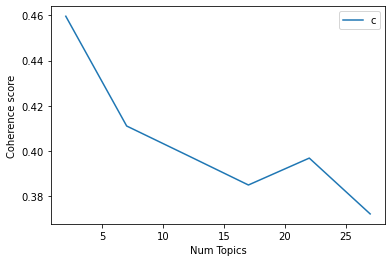

In [91]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [92]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  2

index: 0 | Num Topics = 2  has Coherence Value of 0.4596
index: 1 | Num Topics = 7  has Coherence Value of 0.4111
index: 2 | Num Topics = 12  has Coherence Value of 0.3981
index: 3 | Num Topics = 17  has Coherence Value of 0.3851
index: 4 | Num Topics = 22  has Coherence Value of 0.3969
index: 5 | Num Topics = 27  has Coherence Value of 0.3723


In [132]:
# Select optimal number of topics
optimal_model_us_score4 = model_list_us_score4[0]

In [133]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score4 = pyLDAvis.gensim_models.prepare(optimal_model_us_score4, corpus_us_score4, id2word_us_score4)

In [134]:
print("pyLDAVis for us topics for score=4:")
vis_us_score4

pyLDAVis for us topics for score=4:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.070313  0.0       1        1  56.143611
1     -0.070313  0.0       2        1  43.856389, topic_info=        Term        Freq       Total Category  logprob  loglift
64    really   99.000000   99.000000  Default  30.0000  30.0000
149  account   44.000000   44.000000  Default  29.0000  29.0000
77   comment   98.000000   98.000000  Default  28.0000  28.0000
135      tok   51.000000   51.000000  Default  27.0000  27.0000
73    tiktok  153.000000  153.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
163      let   17.482830   28.404290   Topic2  -5.2696   0.3389
27      byte   26.166986  102.132739   Topic2  -4.8663  -0.5375
7    feature   21.072408   56.697509   Topic2  -5.0828  -0.1655
73    tiktok   23.151573  153.498022   Topic2  -4.9887  -1.0674
126    great   17.764781   72.087714   Topic2  -5.2536  -0.5764

[151 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
75        1  0.223093  ability
75        2  0.803135  ability
83        1  0.574797     able
83        2  0.420583     able
149       1  0.022278  account
...     ...       ...      ...
141       1  0.848058     wish
141       2  0.176679     wish
56        1  0.801349     work
56        2  0.218550     work
676       1  0.972387     year

[182 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## LDA Topic Modelling (Rating = 5)

In [96]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_us_score5 = clash_ios_us_review_YearMonth_score5.review.values.tolist()
review_words_us_score5 = list(sent_to_words(review_us_score5))
print(review_words_us_score5[:1])

[['been', 'waiting', 'on', 'this', 'forever', 'now', 'so', 'glad', 'it', 'finally', 'came', 'jalen']]


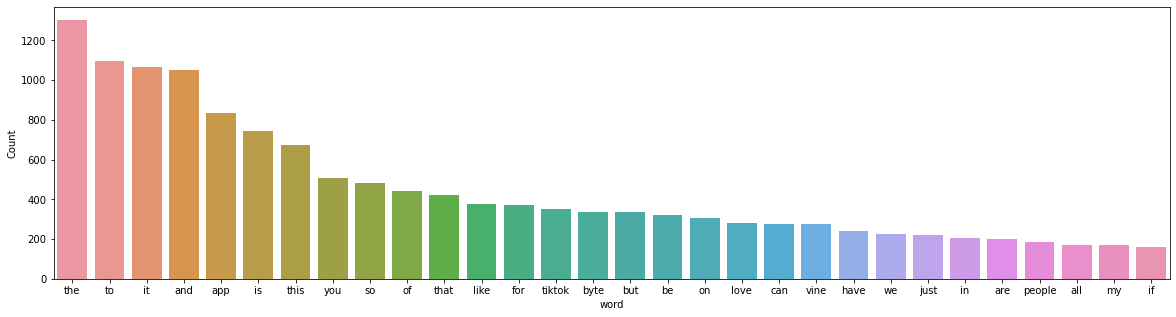

In [97]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score5))

In [98]:
# Clean text
review_us_ready_score5 = process_words(review_words_us_score5)  # processed Text Data! - move to each section

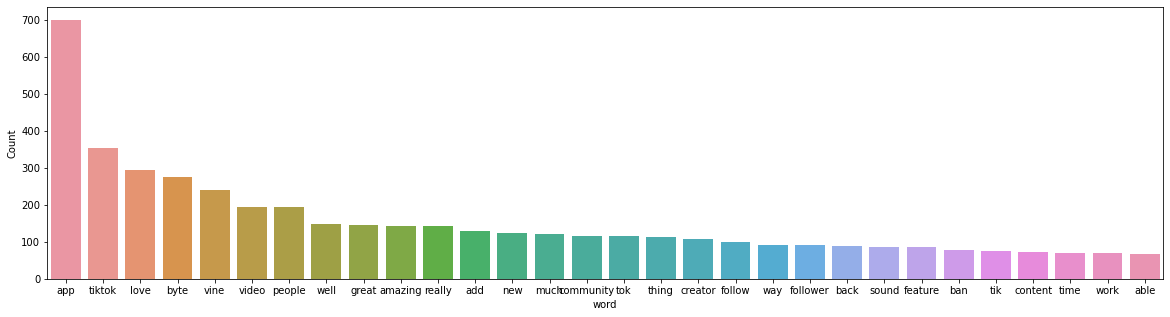

In [99]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score5))


In [100]:
# Create Dictionary
id2word_us_score5 = corpora.Dictionary(review_us_ready_score5)

2021-10-16 01:57:00,633 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 01:57:00,675 [INFO] gensim.corpora.dictionary - built Dictionary(1911 unique tokens: ['finally', 'forever', 'glad', 'wait', 'app']...) from 1118 documents (total 12879 corpus positions)
2021-10-16 01:57:00,676 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1911 unique tokens: ['finally', 'forever', 'glad', 'wait', 'app']...) from 1118 documents (total 12879 corpus positions)", 'datetime': '2021-10-16T01:57:00.676673', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [101]:
# Create Corpus: Term Document Frequency
corpus_us_score5 = [id2word_us_score5.doc2bow(text) for text in review_us_ready_score5]

In [102]:
# Training LDA model
model_list_us_score5, coherence_values_us_score5 = compute_coherence_values(dictionary=id2word_us_score5, corpus=corpus_us_score5, 
                                                              texts=review_us_ready_score5, limit=30, start=2, step=5)


2021-10-16 01:57:01,698 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 01:57:01,700 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 01:57:01,705 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 01:57:01,707 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1118 documents, updating model once every 1000 documents, evaluating perplexity every 1118 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 01:57:01,709 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1118
2021-10-16 01:57:05,034 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:57:05,110 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"app" + 0.024*"vine" + 0.021*"tiktok" + 0.019*"byte" + 0.014*"love" + 0.014*"people" + 0.013*"add" + 0.012*"amazing" + 0.011*"video" + 

2021-10-16 01:57:18,137 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1118/1118
2021-10-16 01:57:18,371 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:57:18,373 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.019*"vine" + 0.018*"video" + 0.017*"tiktok" + 0.017*"tok" + 0.016*"byte" + 0.015*"people" + 0.014*"channel" + 0.013*"add" + 0.013*"way"
2021-10-16 01:57:18,376 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"app" + 0.032*"tiktok" + 0.031*"love" + 0.018*"feature" + 0.017*"video" + 0.012*"much" + 0.012*"byte" + 0.011*"great" + 0.011*"people" + 0.011*"really"
2021-10-16 01:57:18,377 [INFO] gensim.models.ldamodel - topic diff=0.315151, rho=0.404292
2021-10-16 01:57:18,379 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1118
2021-10-16 01:57:20,055 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01

2021-10-16 01:57:28,371 [INFO] gensim.models.ldamodel - topic diff=0.213880, rho=0.299907
2021-10-16 01:57:28,588 [INFO] gensim.models.ldamodel - -5.984 per-word bound, 63.3 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:57:28,590 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1118/1118
2021-10-16 01:57:28,727 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:57:28,730 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.019*"video" + 0.019*"tok" + 0.018*"vine" + 0.018*"byte" + 0.018*"tiktok" + 0.015*"people" + 0.013*"way" + 0.013*"channel" + 0.013*"tik"
2021-10-16 01:57:28,732 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.033*"tiktok" + 0.033*"love" + 0.019*"feature" + 0.015*"video" + 0.012*"much" + 0.012*"great" + 0.011*"byte" + 0.011*"people" + 0.010*"really"
2021-10-16 01:57:28,733 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 01:57:36,689 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.065*"app" + 0.033*"love" + 0.031*"tiktok" + 0.016*"feature" + 0.014*"video" + 0.013*"byte" + 0.013*"great" + 0.012*"much" + 0.011*"people" + 0.011*"new"
2021-10-16 01:57:36,692 [INFO] gensim.models.ldamodel - topic diff=0.170404, rho=0.249083
2021-10-16 01:57:36,879 [INFO] gensim.models.ldamodel - -5.969 per-word bound, 62.7 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:57:36,889 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1118/1118
2021-10-16 01:57:37,020 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:57:37,023 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.020*"tok" + 0.020*"video" + 0.018*"byte" + 0.018*"tiktok" + 0.017*"vine" + 0.015*"people" + 0.014*"tik" + 0.013*"way" + 0.012*"channel"
2021-10-16 01:57:37,025 [INFO] gensim.models.ldamodel - topic #1 (0.500

2021-10-16 01:57:45,571 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"app" + 0.020*"tok" + 0.019*"video" + 0.019*"byte" + 0.018*"tiktok" + 0.018*"vine" + 0.015*"people" + 0.014*"tik" + 0.013*"well" + 0.013*"follow"
2021-10-16 01:57:45,626 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.033*"love" + 0.031*"tiktok" + 0.016*"feature" + 0.014*"video" + 0.013*"byte" + 0.013*"great" + 0.012*"much" + 0.011*"people" + 0.011*"new"
2021-10-16 01:57:45,627 [INFO] gensim.models.ldamodel - topic diff=0.145681, rho=0.217607
2021-10-16 01:57:45,809 [INFO] gensim.models.ldamodel - -5.961 per-word bound, 62.3 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:57:45,812 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1118/1118
2021-10-16 01:57:45,892 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:57:45,895 [INFO] gensim.models.ldamodel - topic #0 (0.500

2021-10-16 01:57:52,021 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1118
2021-10-16 01:57:53,146 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:57:53,149 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"app" + 0.021*"tok" + 0.019*"video" + 0.018*"tiktok" + 0.018*"byte" + 0.017*"vine" + 0.015*"people" + 0.014*"tik" + 0.013*"well" + 0.013*"follow"
2021-10-16 01:57:53,156 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.033*"love" + 0.031*"tiktok" + 0.016*"feature" + 0.013*"video" + 0.013*"byte" + 0.013*"great" + 0.012*"much" + 0.011*"people" + 0.011*"amazing"
2021-10-16 01:57:53,158 [INFO] gensim.models.ldamodel - topic diff=0.128958, rho=0.195673
2021-10-16 01:57:53,387 [INFO] gensim.models.ldamodel - -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:57:53,388 [INFO] gensim.models.ldamodel - PROGRESS: 

2021-10-16 01:57:59,403 [INFO] gensim.models.ldamodel - topic diff=0.117986, rho=0.182216
2021-10-16 01:57:59,404 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1118
2021-10-16 01:58:00,642 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:58:00,643 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"app" + 0.021*"tok" + 0.019*"video" + 0.019*"tiktok" + 0.018*"byte" + 0.017*"vine" + 0.014*"people" + 0.014*"tik" + 0.013*"well" + 0.013*"way"
2021-10-16 01:58:00,645 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.033*"love" + 0.031*"tiktok" + 0.016*"feature" + 0.013*"byte" + 0.013*"video" + 0.013*"great" + 0.012*"much" + 0.012*"amazing" + 0.012*"people"
2021-10-16 01:58:00,645 [INFO] gensim.models.ldamodel - topic diff=0.116768, rho=0.179264
2021-10-16 01:58:00,824 [INFO] gensim.models.ldamodel - -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 118 docum

2021-10-16 01:58:07,085 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.067*"app" + 0.033*"love" + 0.031*"tiktok" + 0.018*"feature" + 0.014*"video" + 0.013*"great" + 0.013*"byte" + 0.012*"much" + 0.012*"amazing" + 0.012*"people"
2021-10-16 01:58:07,088 [INFO] gensim.models.ldamodel - topic diff=0.108410, rho=0.168747
2021-10-16 01:58:07,090 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1118
2021-10-16 01:58:08,643 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:58:08,645 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"app" + 0.022*"tok" + 0.020*"tiktok" + 0.019*"video" + 0.017*"byte" + 0.016*"vine" + 0.015*"tik" + 0.014*"people" + 0.013*"well" + 0.013*"way"
2021-10-16 01:58:08,647 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.033*"love" + 0.030*"tiktok" + 0.017*"feature" + 0.014*"byte" + 0.013*"video" + 0.013*"great" + 0.012*"much" + 0.012*"amazing" + 0.012*"people"


2021-10-16 01:58:15,303 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.023*"tok" + 0.020*"tiktok" + 0.020*"video" + 0.017*"byte" + 0.015*"vine" + 0.015*"tik" + 0.014*"people" + 0.013*"way" + 0.013*"well"
2021-10-16 01:58:15,305 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.033*"love" + 0.030*"tiktok" + 0.018*"feature" + 0.014*"video" + 0.013*"great" + 0.013*"byte" + 0.012*"much" + 0.012*"amazing" + 0.012*"people"
2021-10-16 01:58:15,306 [INFO] gensim.models.ldamodel - topic diff=0.100494, rho=0.157881
2021-10-16 01:58:15,309 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/1118
2021-10-16 01:58:16,400 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:58:16,402 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"app" + 0.022*"tok" + 0.020*"tiktok" + 0.020*"video" + 0.017*"byte" + 0.016*"vine" + 0.015*"tik" + 0.014*"people" + 0.013*"well" + 0.013*"way"
2021-10-16

2021-10-16 01:58:22,152 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1118/1118
2021-10-16 01:58:22,363 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:58:22,371 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.023*"tok" + 0.021*"tiktok" + 0.020*"video" + 0.016*"byte" + 0.015*"tik" + 0.015*"vine" + 0.014*"people" + 0.013*"way" + 0.013*"well"
2021-10-16 01:58:22,385 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.033*"love" + 0.030*"tiktok" + 0.018*"feature" + 0.014*"video" + 0.013*"byte" + 0.013*"great" + 0.012*"much" + 0.012*"amazing" + 0.012*"people"
2021-10-16 01:58:22,387 [INFO] gensim.models.ldamodel - topic diff=0.094102, rho=0.148876
2021-10-16 01:58:22,390 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1000/1118
2021-10-16 01:58:23,536 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01

2021-10-16 01:58:29,036 [INFO] gensim.models.ldamodel - topic diff=0.089218, rho=0.141255
2021-10-16 01:58:29,269 [INFO] gensim.models.ldamodel - -5.947 per-word bound, 61.7 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:58:29,273 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1118/1118
2021-10-16 01:58:29,410 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:58:29,417 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"app" + 0.023*"tok" + 0.021*"tiktok" + 0.020*"video" + 0.016*"byte" + 0.015*"tik" + 0.015*"vine" + 0.014*"people" + 0.013*"way" + 0.013*"well"
2021-10-16 01:58:29,419 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.066*"app" + 0.033*"love" + 0.030*"tiktok" + 0.018*"feature" + 0.014*"video" + 0.013*"byte" + 0.013*"great" + 0.012*"much" + 0.012*"vine" + 0.012*"amazing"
2021-10-16 01:58:29,421 [INFO] gensim.models.ldamodel - topic diff=0.088

2021-10-16 01:58:40,848 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.067*"tok" + 0.055*"tik" + 0.047*"app" + 0.015*"filter" + 0.014*"add" + 0.013*"pet" + 0.012*"cause" + 0.012*"ban" + 0.011*"people" + 0.011*"draft"
2021-10-16 01:58:40,850 [INFO] gensim.models.ldamodel - topic diff=0.521853, rho=0.566320
2021-10-16 01:58:41,021 [INFO] gensim.models.ldamodel - -6.406 per-word bound, 84.8 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:58:41,022 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1118/1118
2021-10-16 01:58:41,151 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:58:41,155 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.059*"app" + 0.040*"love" + 0.019*"tiktok" + 0.019*"much" + 0.016*"feature" + 0.015*"byte" + 0.014*"community" + 0.014*"platform" + 0.013*"work" + 0.013*"time"
2021-10-16 01:58:41,156 [INFO] gensim.models.ldamodel - topic #4 (0.14

2021-10-16 01:58:45,117 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:58:45,139 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.080*"tok" + 0.060*"tik" + 0.043*"app" + 0.019*"filter" + 0.017*"cause" + 0.016*"way" + 0.016*"post" + 0.015*"channel" + 0.014*"pet" + 0.014*"draft"
2021-10-16 01:58:45,142 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"account" + 0.019*"camera" + 0.016*"long" + 0.015*"really" + 0.015*"app" + 0.014*"enjoy" + 0.011*"accept" + 0.010*"famous" + 0.010*"hit" + 0.010*"hate"
2021-10-16 01:58:45,145 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.042*"byte" + 0.034*"tiktok" + 0.032*"app" + 0.021*"vine" + 0.017*"feature" + 0.016*"love" + 0.015*"really" + 0.013*"new" + 0.011*"great" + 0.011*"recommend"
2021-10-16 01:58:45,146 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.088*"app" + 0.040*"love" + 0.035*"amazing" + 0.027*"video" + 0.020*"thing" + 0.017*"people" + 0.015*"watch" + 0.

2021-10-16 01:58:48,478 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.078*"tok" + 0.059*"tik" + 0.045*"app" + 0.029*"channel" + 0.023*"filter" + 0.021*"post" + 0.019*"way" + 0.019*"cause" + 0.019*"pet" + 0.016*"draft"
2021-10-16 01:58:48,483 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.064*"app" + 0.036*"love" + 0.021*"byte" + 0.019*"community" + 0.018*"much" + 0.016*"work" + 0.016*"great" + 0.013*"platform" + 0.013*"vine" + 0.013*"content"
2021-10-16 01:58:48,487 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.081*"tiktok" + 0.038*"app" + 0.030*"video" + 0.023*"able" + 0.022*"vine" + 0.020*"well" + 0.019*"back" + 0.019*"people" + 0.018*"follow" + 0.018*"ban"
2021-10-16 01:58:48,489 [INFO] gensim.models.ldamodel - topic diff=0.196968, rho=0.350974
2021-10-16 01:58:48,493 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #1000/1118
2021-10-16 01:58:49,469 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-

2021-10-16 01:58:52,318 [INFO] gensim.models.ldamodel - topic diff=0.151339, rho=0.299907
2021-10-16 01:58:52,539 [INFO] gensim.models.ldamodel - -5.964 per-word bound, 62.4 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:58:52,546 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1118/1118
2021-10-16 01:58:52,652 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:58:52,655 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"account" + 0.032*"camera" + 0.019*"comment" + 0.018*"record" + 0.017*"accept" + 0.015*"give" + 0.015*"roll" + 0.013*"famous" + 0.012*"trump" + 0.011*"non"
2021-10-16 01:58:52,656 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.066*"app" + 0.035*"love" + 0.022*"byte" + 0.019*"community" + 0.018*"much" + 0.016*"great" + 0.016*"work" + 0.015*"really" + 0.015*"content" + 0.014*"vine"
2021-10-16 01:58:52,658 [INFO] gensim.models.ldamodel - top

2021-10-16 01:58:57,183 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.048*"tiktok" + 0.044*"byte" + 0.033*"feature" + 0.030*"app" + 0.020*"new" + 0.020*"vine" + 0.015*"love" + 0.011*"amazing" + 0.011*"recommend" + 0.011*"really"
2021-10-16 01:58:57,186 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"account" + 0.026*"camera" + 0.018*"comment" + 0.015*"record" + 0.015*"accept" + 0.014*"give" + 0.013*"roll" + 0.012*"famous" + 0.012*"trump" + 0.010*"non"
2021-10-16 01:58:57,188 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.078*"tiktok" + 0.036*"app" + 0.027*"video" + 0.024*"vine" + 0.022*"well" + 0.022*"follow" + 0.020*"able" + 0.020*"people" + 0.019*"back" + 0.019*"follower"
2021-10-16 01:58:57,191 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.066*"app" + 0.035*"love" + 0.024*"byte" + 0.020*"community" + 0.017*"much" + 0.017*"vine" + 0.017*"great" + 0.016*"really" + 0.015*"content" + 0.014*"creator"
2021-10-16 01:58:57,193 [INFO] gensim.models.ldamodel - topic 

2021-10-16 01:59:00,408 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.093*"app" + 0.041*"love" + 0.035*"amazing" + 0.035*"video" + 0.021*"thing" + 0.018*"watch" + 0.018*"people" + 0.013*"really" + 0.013*"creator" + 0.012*"less"
2021-10-16 01:59:00,410 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.078*"tok" + 0.058*"tik" + 0.042*"app" + 0.039*"channel" + 0.024*"post" + 0.023*"filter" + 0.019*"way" + 0.018*"pet" + 0.017*"cause" + 0.016*"draft"
2021-10-16 01:59:00,412 [INFO] gensim.models.ldamodel - topic diff=0.116968, rho=0.249083
2021-10-16 01:59:00,413 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1000/1118
2021-10-16 01:59:01,811 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:59:01,816 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.092*"app" + 0.042*"love" + 0.037*"amazing" + 0.033*"video" + 0.022*"thing" + 0.018*"people" + 0.017*"watch" + 0.013*"really" + 0.013*"creator" + 0.011*"com

2021-10-16 01:59:05,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1118/1118
2021-10-16 01:59:05,895 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:59:05,901 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.093*"app" + 0.042*"love" + 0.035*"amazing" + 0.035*"video" + 0.022*"thing" + 0.019*"watch" + 0.018*"people" + 0.013*"really" + 0.013*"creator" + 0.012*"less"
2021-10-16 01:59:05,905 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.078*"tok" + 0.058*"tik" + 0.042*"app" + 0.040*"channel" + 0.024*"post" + 0.022*"filter" + 0.020*"way" + 0.018*"pet" + 0.017*"cause" + 0.016*"draft"
2021-10-16 01:59:05,906 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.053*"tiktok" + 0.045*"feature" + 0.042*"byte" + 0.030*"app" + 0.021*"new" + 0.018*"vine" + 0.016*"love" + 0.012*"amazing" + 0.011*"recommend" + 0.011*"great"
2021-10-16 01:59:05,908 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.038*"account

2021-10-16 01:59:10,426 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.036*"app" + 0.036*"add" + 0.023*"like" + 0.021*"video" + 0.018*"great" + 0.017*"sound" + 0.016*"look" + 0.016*"old" + 0.014*"feature" + 0.014*"way"
2021-10-16 01:59:10,430 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.080*"tiktok" + 0.035*"app" + 0.028*"video" + 0.023*"vine" + 0.022*"well" + 0.022*"follow" + 0.020*"able" + 0.020*"people" + 0.019*"ban" + 0.019*"follower"
2021-10-16 01:59:10,436 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.066*"app" + 0.034*"love" + 0.024*"byte" + 0.023*"vine" + 0.019*"community" + 0.019*"great" + 0.017*"much" + 0.016*"really" + 0.015*"content" + 0.015*"creator"
2021-10-16 01:59:10,444 [INFO] gensim.models.ldamodel - topic diff=0.096784, rho=0.212631
2021-10-16 01:59:10,657 [INFO] gensim.models.ldamodel - -5.914 per-word bound, 60.3 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:59:10,660 [INFO] gensim.models.ldamodel - 

2021-10-16 01:59:13,915 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"app" + 0.034*"add" + 0.022*"like" + 0.020*"video" + 0.019*"great" + 0.018*"sound" + 0.017*"old" + 0.017*"look" + 0.014*"feature" + 0.014*"people"
2021-10-16 01:59:13,917 [INFO] gensim.models.ldamodel - topic diff=0.091165, rho=0.203624
2021-10-16 01:59:13,918 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/1118
2021-10-16 01:59:15,217 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:59:15,227 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"account" + 0.028*"camera" + 0.019*"comment" + 0.017*"accept" + 0.015*"record" + 0.015*"give" + 0.014*"roll" + 0.013*"famous" + 0.012*"trump" + 0.011*"non"
2021-10-16 01:59:15,230 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.080*"tiktok" + 0.035*"app" + 0.028*"video" + 0.023*"vine" + 0.022*"follow" + 0.022*"well" + 0.020*"able" + 0.020*"people" + 0.019*"ban" + 0.019*"follo

2021-10-16 01:59:19,274 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:59:19,279 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"account" + 0.033*"camera" + 0.021*"comment" + 0.018*"accept" + 0.017*"record" + 0.016*"roll" + 0.016*"give" + 0.013*"famous" + 0.012*"trump" + 0.011*"non"
2021-10-16 01:59:19,280 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.081*"tiktok" + 0.036*"app" + 0.030*"video" + 0.022*"able" + 0.021*"vine" + 0.021*"well" + 0.020*"follow" + 0.020*"people" + 0.019*"back" + 0.018*"ban"
2021-10-16 01:59:19,281 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"app" + 0.033*"add" + 0.022*"like" + 0.020*"video" + 0.019*"great" + 0.018*"sound" + 0.017*"old" + 0.017*"look" + 0.014*"people" + 0.014*"feature"
2021-10-16 01:59:19,283 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.056*"tiktok" + 0.046*"feature" + 0.042*"byte" + 0.030*"app" + 0.021*"new" + 0.017*"love" + 0.014*"vine" + 0.012*

2021-10-16 01:59:23,960 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"tiktok" + 0.044*"byte" + 0.041*"feature" + 0.029*"app" + 0.021*"new" + 0.016*"love" + 0.014*"vine" + 0.012*"add" + 0.012*"amazing" + 0.012*"recommend"
2021-10-16 01:59:23,967 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"account" + 0.028*"camera" + 0.020*"comment" + 0.017*"accept" + 0.015*"record" + 0.015*"give" + 0.014*"roll" + 0.013*"famous" + 0.012*"trump" + 0.011*"non"
2021-10-16 01:59:23,972 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.093*"app" + 0.043*"love" + 0.038*"amazing" + 0.035*"video" + 0.022*"thing" + 0.018*"watch" + 0.018*"people" + 0.013*"really" + 0.012*"creator" + 0.012*"less"
2021-10-16 01:59:23,977 [INFO] gensim.models.ldamodel - topic diff=0.080721, rho=0.182216
2021-10-16 01:59:24,192 [INFO] gensim.models.ldamodel - -5.900 per-word bound, 59.7 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:59:24,194 [INFO] gensim.models

2021-10-16 01:59:27,305 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.056*"tiktok" + 0.046*"feature" + 0.042*"byte" + 0.030*"app" + 0.021*"new" + 0.017*"love" + 0.014*"vine" + 0.013*"add" + 0.012*"amazing" + 0.011*"recommend"
2021-10-16 01:59:27,306 [INFO] gensim.models.ldamodel - topic diff=0.077531, rho=0.176452
2021-10-16 01:59:27,307 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1000/1118
2021-10-16 01:59:28,560 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:59:28,570 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.054*"tiktok" + 0.044*"byte" + 0.041*"feature" + 0.029*"app" + 0.021*"new" + 0.016*"love" + 0.014*"vine" + 0.013*"add" + 0.012*"amazing" + 0.012*"recommend"
2021-10-16 01:59:28,576 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.093*"app" + 0.043*"love" + 0.038*"amazing" + 0.035*"video" + 0.022*"thing" + 0.018*"watch" + 0.018*"people" + 0.013*"really" + 0.012*"creator" + 0.01

2021-10-16 01:59:32,450 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:59:32,454 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.093*"app" + 0.043*"love" + 0.037*"amazing" + 0.036*"video" + 0.022*"thing" + 0.019*"watch" + 0.018*"people" + 0.014*"really" + 0.013*"less" + 0.012*"toxic"
2021-10-16 01:59:32,457 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.067*"app" + 0.033*"love" + 0.027*"vine" + 0.023*"byte" + 0.020*"great" + 0.018*"community" + 0.016*"really" + 0.016*"much" + 0.015*"content" + 0.015*"work"
2021-10-16 01:59:32,461 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.056*"tiktok" + 0.045*"feature" + 0.042*"byte" + 0.030*"app" + 0.021*"new" + 0.017*"love" + 0.014*"vine" + 0.014*"add" + 0.012*"amazing" + 0.011*"recommend"
2021-10-16 01:59:32,465 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"app" + 0.032*"add" + 0.022*"like" + 0.020*"video" + 0.019*"great" + 0.017*"old" + 0.017*"look" + 0.01

2021-10-16 01:59:39,305 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.055*"tiktok" + 0.044*"byte" + 0.041*"feature" + 0.029*"app" + 0.021*"new" + 0.016*"love" + 0.014*"vine" + 0.013*"add" + 0.012*"amazing" + 0.012*"recommend"
2021-10-16 01:59:39,307 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"app" + 0.033*"add" + 0.023*"like" + 0.020*"video" + 0.018*"great" + 0.017*"sound" + 0.016*"look" + 0.016*"old" + 0.014*"people" + 0.014*"way"
2021-10-16 01:59:39,310 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.081*"tiktok" + 0.036*"app" + 0.029*"video" + 0.022*"follow" + 0.022*"well" + 0.021*"able" + 0.020*"vine" + 0.020*"people" + 0.020*"sound" + 0.019*"back"
2021-10-16 01:59:39,311 [INFO] gensim.models.ldamodel - topic diff=0.070911, rho=0.161970
2021-10-16 01:59:39,708 [INFO] gensim.models.ldamodel - -5.890 per-word bound, 59.3 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:59:39,709 [INFO] gensim.models.ldamodel - PROGRE

2021-10-16 01:59:44,303 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.079*"tok" + 0.059*"tik" + 0.042*"app" + 0.042*"channel" + 0.024*"post" + 0.021*"filter" + 0.021*"way" + 0.017*"pet" + 0.017*"cause" + 0.016*"draft"
2021-10-16 01:59:44,304 [INFO] gensim.models.ldamodel - topic diff=0.068592, rho=0.157881
2021-10-16 01:59:44,306 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/1118
2021-10-16 01:59:45,411 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:59:45,416 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.092*"app" + 0.044*"love" + 0.039*"amazing" + 0.034*"video" + 0.022*"thing" + 0.019*"watch" + 0.019*"people" + 0.014*"really" + 0.012*"creator" + 0.012*"less"
2021-10-16 01:59:45,420 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.055*"tiktok" + 0.044*"byte" + 0.041*"feature" + 0.029*"app" + 0.021*"new" + 0.016*"love" + 0.014*"vine" + 0.013*"add" + 0.012*"amazing" + 0.012*"recommend"

2021-10-16 01:59:48,731 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 01:59:48,736 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"app" + 0.031*"add" + 0.022*"like" + 0.020*"video" + 0.019*"great" + 0.017*"old" + 0.017*"look" + 0.016*"sound" + 0.014*"people" + 0.013*"way"
2021-10-16 01:59:48,737 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"account" + 0.032*"camera" + 0.021*"comment" + 0.018*"accept" + 0.017*"record" + 0.016*"give" + 0.016*"roll" + 0.015*"personal" + 0.013*"famous" + 0.012*"trump"
2021-10-16 01:59:48,739 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.092*"app" + 0.043*"love" + 0.038*"amazing" + 0.035*"video" + 0.022*"thing" + 0.019*"watch" + 0.018*"people" + 0.014*"really" + 0.013*"less" + 0.012*"toxic"
2021-10-16 01:59:48,741 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.081*"tiktok" + 0.037*"app" + 0.031*"video" + 0.024*"able" + 0.021*"sound" + 0.021*"well" + 0.020*"follow" 

2021-10-16 01:59:53,469 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.092*"app" + 0.044*"love" + 0.039*"amazing" + 0.034*"video" + 0.023*"thing" + 0.019*"watch" + 0.019*"people" + 0.014*"really" + 0.012*"creator" + 0.012*"less"
2021-10-16 01:59:53,471 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.067*"app" + 0.033*"love" + 0.029*"vine" + 0.023*"byte" + 0.019*"great" + 0.018*"community" + 0.016*"really" + 0.016*"much" + 0.015*"content" + 0.015*"creator"
2021-10-16 01:59:53,474 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"account" + 0.028*"camera" + 0.020*"comment" + 0.017*"accept" + 0.015*"record" + 0.015*"give" + 0.014*"roll" + 0.013*"personal" + 0.013*"famous" + 0.012*"trump"
2021-10-16 01:59:53,493 [INFO] gensim.models.ldamodel - topic diff=0.063918, rho=0.147253
2021-10-16 01:59:53,874 [INFO] gensim.models.ldamodel - -5.885 per-word bound, 59.1 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 01:59:53,878 [INFO] gensi

2021-10-16 01:59:57,111 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.056*"tiktok" + 0.045*"feature" + 0.042*"byte" + 0.030*"app" + 0.020*"new" + 0.016*"love" + 0.014*"add" + 0.014*"vine" + 0.012*"amazing" + 0.012*"recommend"
2021-10-16 01:59:57,112 [INFO] gensim.models.ldamodel - topic diff=0.062164, rho=0.144160
2021-10-16 01:59:57,114 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1000/1118
2021-10-16 01:59:58,280 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 01:59:58,283 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.081*"tok" + 0.060*"tik" + 0.041*"app" + 0.040*"channel" + 0.024*"post" + 0.020*"way" + 0.020*"filter" + 0.017*"cause" + 0.016*"pet" + 0.015*"draft"
2021-10-16 01:59:58,284 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.055*"tiktok" + 0.043*"byte" + 0.041*"feature" + 0.029*"app" + 0.021*"new" + 0.016*"love" + 0.014*"vine" + 0.014*"add" + 0.012*"amazing" + 0.012*"recommend"
2

2021-10-16 02:00:01,795 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:00:01,801 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"app" + 0.031*"add" + 0.022*"like" + 0.020*"video" + 0.019*"great" + 0.017*"old" + 0.017*"look" + 0.016*"sound" + 0.014*"people" + 0.013*"way"
2021-10-16 02:00:01,803 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.092*"app" + 0.043*"love" + 0.038*"amazing" + 0.035*"video" + 0.022*"thing" + 0.019*"watch" + 0.019*"people" + 0.014*"really" + 0.013*"less" + 0.012*"toxic"
2021-10-16 02:00:01,805 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.039*"account" + 0.031*"camera" + 0.021*"comment" + 0.018*"accept" + 0.017*"record" + 0.016*"give" + 0.016*"roll" + 0.015*"personal" + 0.013*"famous" + 0.012*"trump"
2021-10-16 02:00:01,807 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.080*"tok" + 0.059*"tik" + 0.042*"channel" + 0.042*"app" + 0.024*"post" + 0.021*"way" + 0.021*"filter" + 0.

2021-10-16 02:00:14,435 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"camera" + 0.029*"beat" + 0.029*"end" + 0.028*"sum" + 0.028*"mood" + 0.021*"little" + 0.017*"tt" + 0.016*"harsh" + 0.016*"review" + 0.013*"byte"
2021-10-16 02:00:14,437 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.079*"app" + 0.041*"really" + 0.033*"update" + 0.033*"work" + 0.026*"love" + 0.019*"byte" + 0.018*"specific" + 0.017*"vine" + 0.015*"first" + 0.015*"drop"
2021-10-16 02:00:14,445 [INFO] gensim.models.ldamodel - topic diff=0.561952, rho=0.566320
2021-10-16 02:00:14,448 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1000/1118
2021-10-16 02:00:15,765 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:00:15,771 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.087*"app" + 0.037*"love" + 0.032*"people" + 0.020*"much" + 0.019*"video" + 0.016*"follower" + 0.015*"thing" + 0.013*"amazing" + 0.012*"way" + 0.011*"vine"
202

2021-10-16 02:00:19,665 [INFO] gensim.models.ldamodel - -6.145 per-word bound, 70.8 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:00:19,667 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1118/1118
2021-10-16 02:00:19,735 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:00:19,739 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.076*"feature" + 0.042*"tiktok" + 0.035*"love" + 0.026*"app" + 0.022*"video" + 0.019*"add" + 0.017*"second" + 0.014*"start" + 0.014*"byte" + 0.012*"vine"
2021-10-16 02:00:19,741 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.093*"camera" + 0.040*"account" + 0.036*"record" + 0.023*"check" + 0.020*"ruin" + 0.020*"switch" + 0.019*"email" + 0.018*"predecessor" + 0.018*"work" + 0.017*"world"
2021-10-16 02:00:19,743 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.053*"app" + 0.029*"love" + 0.028*"let" + 0.025*"tiktok" + 0.022*"great

2021-10-16 02:00:24,339 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.051*"app" + 0.029*"love" + 0.027*"let" + 0.024*"great" + 0.023*"tiktok" + 0.019*"sound" + 0.018*"comment" + 0.017*"add" + 0.014*"video" + 0.013*"well"
2021-10-16 02:00:24,345 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.076*"vine" + 0.051*"tiktok" + 0.043*"back" + 0.026*"app" + 0.024*"wait" + 0.024*"bring" + 0.022*"star" + 0.020*"give" + 0.018*"byte" + 0.015*"day"
2021-10-16 02:00:24,350 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.066*"feature" + 0.039*"tiktok" + 0.035*"love" + 0.024*"app" + 0.021*"video" + 0.021*"add" + 0.019*"second" + 0.016*"byte" + 0.014*"vine" + 0.014*"start"
2021-10-16 02:00:24,358 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.080*"app" + 0.039*"love" + 0.033*"people" + 0.021*"video" + 0.020*"much" + 0.015*"thing" + 0.014*"follower" + 0.014*"way" + 0.013*"really" + 0.013*"channel"
2021-10-16 02:00:24,360 [INFO] gensim.models.ldamodel - topic diff=0.141593, rho=0.331

2021-10-16 02:00:27,862 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.080*"amazing" + 0.049*"app" + 0.033*"creator" + 0.024*"community" + 0.024*"bad" + 0.023*"actually" + 0.020*"pretty" + 0.019*"perfect" + 0.019*"straight" + 0.019*"thing"
2021-10-16 02:00:27,870 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.072*"video" + 0.049*"add" + 0.048*"app" + 0.032*"still" + 0.031*"sound" + 0.028*"post" + 0.022*"maybe" + 0.019*"fyp" + 0.018*"great" + 0.017*"instead"
2021-10-16 02:00:27,871 [INFO] gensim.models.ldamodel - topic diff=0.115128, rho=0.299907
2021-10-16 02:00:27,874 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1000/1118
2021-10-16 02:00:29,036 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:00:29,041 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.078*"vine" + 0.044*"back" + 0.044*"tiktok" + 0.025*"bring" + 0.025*"star" + 0.024*"wait" + 0.023*"app" + 0.022*"give" + 0.015*"day" + 0.015*"

2021-10-16 02:00:33,810 [INFO] gensim.models.ldamodel - -6.018 per-word bound, 64.8 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:00:33,813 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1118/1118
2021-10-16 02:00:34,026 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:00:34,032 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"little" + 0.025*"end" + 0.025*"beat" + 0.025*"review" + 0.024*"camera" + 0.023*"sum" + 0.023*"mood" + 0.022*"roll" + 0.022*"tt" + 0.022*"harsh"
2021-10-16 02:00:34,035 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.081*"amazing" + 0.048*"app" + 0.033*"creator" + 0.024*"bad" + 0.024*"community" + 0.023*"actually" + 0.020*"pretty" + 0.019*"straight" + 0.019*"thing" + 0.018*"perfect"
2021-10-16 02:00:34,041 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.092*"camera" + 0.042*"account" + 0.036*"record" + 0.021*"switch" + 0.0

2021-10-16 02:00:38,604 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.083*"app" + 0.042*"byte" + 0.038*"really" + 0.032*"love" + 0.031*"work" + 0.028*"update" + 0.022*"new" + 0.021*"feature" + 0.018*"vine" + 0.017*"first"
2021-10-16 02:00:38,607 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.079*"vine" + 0.045*"back" + 0.041*"tiktok" + 0.027*"star" + 0.026*"bring" + 0.025*"give" + 0.023*"wait" + 0.020*"app" + 0.015*"time" + 0.015*"old"
2021-10-16 02:00:38,610 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.080*"app" + 0.039*"love" + 0.033*"people" + 0.021*"video" + 0.019*"much" + 0.016*"thing" + 0.015*"way" + 0.014*"follower" + 0.014*"channel" + 0.013*"really"
2021-10-16 02:00:38,615 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.077*"tiktok" + 0.037*"follow" + 0.032*"able" + 0.029*"new" + 0.026*"app" + 0.022*"time" + 0.022*"alt" + 0.021*"byte" + 0.019*"people" + 0.018*"well"
2021-10-16 02:00:38,618 [INFO] gensim.models.ldamodel - topic diff=0.083962, rho=0.241698


2021-10-16 02:00:42,206 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.073*"vine" + 0.044*"back" + 0.043*"tiktok" + 0.031*"star" + 0.026*"give" + 0.025*"bring" + 0.021*"wait" + 0.021*"app" + 0.017*"old" + 0.015*"time"
2021-10-16 02:00:42,209 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.084*"app" + 0.041*"byte" + 0.038*"really" + 0.032*"work" + 0.032*"love" + 0.029*"update" + 0.025*"feature" + 0.022*"new" + 0.018*"first" + 0.017*"vine"
2021-10-16 02:00:42,211 [INFO] gensim.models.ldamodel - topic diff=0.077418, rho=0.228707
2021-10-16 02:00:42,214 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1000/1118
2021-10-16 02:00:43,458 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:00:43,505 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.075*"camera" + 0.042*"account" + 0.032*"record" + 0.020*"switch" + 0.020*"ruin" + 0.018*"email" + 0.017*"check" + 0.017*"work" + 0.017*"predecessor" + 0.014*"worl

2021-10-16 02:00:46,964 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1118/1118
2021-10-16 02:00:47,055 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:00:47,061 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.080*"app" + 0.039*"love" + 0.033*"people" + 0.021*"video" + 0.019*"much" + 0.016*"channel" + 0.015*"way" + 0.015*"thing" + 0.014*"really" + 0.013*"vine"
2021-10-16 02:00:47,063 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.082*"amazing" + 0.046*"app" + 0.033*"creator" + 0.025*"bad" + 0.023*"community" + 0.021*"actually" + 0.021*"pretty" + 0.019*"straight" + 0.019*"thing" + 0.017*"black"
2021-10-16 02:00:47,066 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.073*"tiktok" + 0.037*"able" + 0.035*"follow" + 0.030*"new" + 0.027*"app" + 0.025*"time" + 0.023*"alt" + 0.019*"people" + 0.018*"byte" + 0.017*"follower"
2021-10-16 02:00:47,068 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.08

2021-10-16 02:00:50,923 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.107*"tiktok" + 0.067*"byte" + 0.042*"app" + 0.042*"ban" + 0.031*"well" + 0.024*"lol" + 0.015*"really" + 0.014*"join" + 0.012*"similar" + 0.011*"download"
2021-10-16 02:00:50,924 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.075*"tiktok" + 0.036*"follow" + 0.033*"able" + 0.030*"new" + 0.025*"app" + 0.022*"time" + 0.022*"alt" + 0.020*"byte" + 0.019*"people" + 0.017*"download"
2021-10-16 02:00:50,926 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.069*"video" + 0.055*"add" + 0.047*"app" + 0.031*"sound" + 0.029*"still" + 0.025*"post" + 0.022*"maybe" + 0.018*"thing" + 0.017*"great" + 0.016*"fyp"
2021-10-16 02:00:50,927 [INFO] gensim.models.ldamodel - topic diff=0.065842, rho=0.199530
2021-10-16 02:00:51,044 [INFO] gensim.models.ldamodel - -5.988 per-word bound, 63.5 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:00:51,046 [INFO] gensim.models.ldamodel - PROGRE

2021-10-16 02:00:54,205 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.084*"app" + 0.042*"byte" + 0.038*"really" + 0.032*"love" + 0.032*"work" + 0.028*"update" + 0.025*"feature" + 0.024*"new" + 0.018*"first" + 0.017*"vine"
2021-10-16 02:00:54,207 [INFO] gensim.models.ldamodel - topic diff=0.063079, rho=0.192031
2021-10-16 02:00:54,208 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1000/1118
2021-10-16 02:00:55,804 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:00:55,811 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.084*"app" + 0.044*"byte" + 0.038*"really" + 0.032*"love" + 0.031*"work" + 0.028*"update" + 0.024*"new" + 0.021*"feature" + 0.018*"vine" + 0.016*"first"
2021-10-16 02:00:55,813 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.076*"camera" + 0.047*"account" + 0.032*"record" + 0.020*"switch" + 0.020*"ruin" + 0.019*"work" + 0.018*"email" + 0.017*"check" + 0.017*"predecessor" + 0.015*

2021-10-16 02:01:01,227 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.027*"little" + 0.025*"end" + 0.025*"beat" + 0.024*"camera" + 0.023*"review" + 0.023*"sum" + 0.023*"mood" + 0.022*"roll" + 0.021*"tt" + 0.021*"biden"
2021-10-16 02:01:01,230 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.167*"tok" + 0.120*"tik" + 0.034*"way" + 0.032*"gon" + 0.029*"app" + 0.023*"feel" + 0.022*"cause" + 0.022*"actually" + 0.020*"stuff" + 0.020*"add"
2021-10-16 02:01:01,232 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.086*"feature" + 0.050*"tiktok" + 0.032*"love" + 0.029*"video" + 0.029*"add" + 0.023*"second" + 0.022*"app" + 0.020*"vine" + 0.014*"start" + 0.013*"remind"
2021-10-16 02:01:01,234 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.070*"tiktok" + 0.038*"able" + 0.036*"follow" + 0.030*"new" + 0.025*"app" + 0.024*"time" + 0.023*"alt" + 0.019*"byte" + 0.019*"people" + 0.017*"follower"
2021-10-16 02:01:01,237 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.074*"vine" + 0.04

2021-10-16 02:01:06,314 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.080*"amazing" + 0.044*"app" + 0.033*"creator" + 0.025*"bad" + 0.022*"actually" + 0.021*"community" + 0.020*"pretty" + 0.018*"straight" + 0.018*"thing" + 0.016*"perfect"
2021-10-16 02:01:06,316 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.080*"feature" + 0.047*"tiktok" + 0.032*"love" + 0.029*"video" + 0.029*"add" + 0.025*"second" + 0.022*"app" + 0.020*"vine" + 0.013*"start" + 0.013*"remind"
2021-10-16 02:01:06,318 [INFO] gensim.models.ldamodel - topic diff=0.055834, rho=0.173767
2021-10-16 02:01:06,473 [INFO] gensim.models.ldamodel - -5.979 per-word bound, 63.1 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:01:06,474 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1118/1118
2021-10-16 02:01:06,529 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:01:06,532 [INFO] gensim.models.ldamo

2021-10-16 02:01:09,713 [INFO] gensim.models.ldamodel - topic diff=0.054175, rho=0.168747
2021-10-16 02:01:09,715 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1118
2021-10-16 02:01:10,724 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:01:10,728 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.167*"tok" + 0.118*"tik" + 0.033*"way" + 0.032*"gon" + 0.028*"app" + 0.022*"actually" + 0.022*"feel" + 0.021*"cause" + 0.020*"add" + 0.019*"stuff"
2021-10-16 02:01:10,732 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.078*"vine" + 0.046*"back" + 0.038*"tiktok" + 0.028*"star" + 0.026*"bring" + 0.025*"give" + 0.023*"wait" + 0.019*"app" + 0.018*"time" + 0.016*"old"
2021-10-16 02:01:10,734 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.081*"app" + 0.040*"love" + 0.032*"people" + 0.021*"video" + 0.017*"much" + 0.016*"thing" + 0.015*"way" + 0.014*"channel" + 0.014*"follower" + 0.014*"vine"
2021-10-16 0

2021-10-16 02:01:14,167 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.115*"tiktok" + 0.065*"byte" + 0.049*"app" + 0.049*"ban" + 0.031*"well" + 0.026*"lol" + 0.015*"really" + 0.015*"join" + 0.013*"similar" + 0.012*"download"
2021-10-16 02:01:14,169 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.086*"camera" + 0.050*"account" + 0.035*"record" + 0.027*"lose" + 0.023*"work" + 0.020*"switch" + 0.020*"ruin" + 0.019*"email" + 0.019*"check" + 0.018*"predecessor"
2021-10-16 02:01:14,171 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.071*"video" + 0.057*"add" + 0.050*"app" + 0.032*"sound" + 0.031*"still" + 0.026*"post" + 0.023*"maybe" + 0.019*"thing" + 0.018*"fyp" + 0.018*"great"
2021-10-16 02:01:14,172 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.081*"amazing" + 0.046*"app" + 0.034*"creator" + 0.025*"bad" + 0.023*"community" + 0.022*"actually" + 0.021*"pretty" + 0.019*"straight" + 0.018*"thing" + 0.017*"black"
2021-10-16 02:01:14,174 [INFO] gensim.models.ldamodel - topic 

2021-10-16 02:01:18,219 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.067*"tiktok" + 0.038*"follow" + 0.034*"able" + 0.030*"new" + 0.023*"alt" + 0.023*"time" + 0.022*"app" + 0.021*"byte" + 0.019*"people" + 0.017*"download"
2021-10-16 02:01:18,221 [INFO] gensim.models.ldamodel - topic diff=0.049481, rho=0.155950
2021-10-16 02:01:18,513 [INFO] gensim.models.ldamodel - -5.973 per-word bound, 62.8 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:01:18,515 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1118/1118
2021-10-16 02:01:18,709 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:01:18,751 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.086*"camera" + 0.050*"account" + 0.035*"record" + 0.027*"lose" + 0.023*"work" + 0.020*"switch" + 0.020*"ruin" + 0.019*"email" + 0.019*"check" + 0.018*"predecessor"
2021-10-16 02:01:18,757 [INFO] gensim.models.ldamodel - t

2021-10-16 02:01:23,319 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:01:23,323 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.081*"app" + 0.040*"love" + 0.032*"people" + 0.021*"video" + 0.017*"much" + 0.016*"thing" + 0.015*"way" + 0.014*"channel" + 0.014*"follower" + 0.014*"vine"
2021-10-16 02:01:23,326 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.066*"tiktok" + 0.038*"follow" + 0.035*"able" + 0.030*"new" + 0.023*"alt" + 0.023*"time" + 0.021*"app" + 0.021*"byte" + 0.019*"people" + 0.017*"download"
2021-10-16 02:01:23,328 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.070*"video" + 0.058*"add" + 0.048*"app" + 0.031*"sound" + 0.029*"still" + 0.025*"post" + 0.022*"maybe" + 0.020*"thing" + 0.018*"great" + 0.016*"fyp"
2021-10-16 02:01:23,330 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.080*"amazing" + 0.044*"app" + 0.033*"creator" + 0.025*"bad" + 0.022*"actually" + 0.022*"community" + 0.020*"pretty"

2021-10-16 02:01:26,338 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.167*"tok" + 0.120*"tik" + 0.035*"way" + 0.032*"gon" + 0.029*"app" + 0.022*"feel" + 0.022*"cause" + 0.021*"actually" + 0.020*"add" + 0.020*"stuff"
2021-10-16 02:01:26,339 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.081*"amazing" + 0.046*"app" + 0.033*"creator" + 0.025*"bad" + 0.022*"actually" + 0.022*"community" + 0.021*"pretty" + 0.019*"straight" + 0.017*"thing" + 0.017*"black"
2021-10-16 02:01:26,341 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.081*"app" + 0.039*"love" + 0.032*"people" + 0.021*"video" + 0.016*"much" + 0.016*"channel" + 0.016*"way" + 0.015*"thing" + 0.014*"great" + 0.013*"vine"
2021-10-16 02:01:26,343 [INFO] gensim.models.ldamodel - topic diff=0.046354, rho=0.147253
2021-10-16 02:01:26,344 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/1118
2021-10-16 02:01:27,598 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 docum

2021-10-16 02:01:30,443 [INFO] gensim.models.ldamodel - topic diff=0.044887, rho=0.142685
2021-10-16 02:01:30,613 [INFO] gensim.models.ldamodel - -5.968 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:01:30,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1118/1118
2021-10-16 02:01:30,711 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:01:30,722 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.025*"end" + 0.025*"beat" + 0.024*"little" + 0.023*"camera" + 0.023*"review" + 0.023*"sum" + 0.023*"mood" + 0.022*"roll" + 0.021*"tt" + 0.021*"promotion"
2021-10-16 02:01:30,724 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.074*"vine" + 0.045*"back" + 0.040*"tiktok" + 0.030*"star" + 0.026*"give" + 0.025*"bring" + 0.022*"wait" + 0.020*"app" + 0.018*"time" + 0.017*"old"
2021-10-16 02:01:30,729 [INFO] gensim.models.ldamodel - topic #8 (0.083): 

2021-10-16 02:01:33,646 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:01:38,868 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:01:38,946 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1057 virtual documents
2021-10-16 02:01:41,944 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.058823529411764705
2021-10-16 02:01:41,946 [INFO] gensim.models.ldamodel - using symmetric eta at 0.058823529411764705
2021-10-16 02:01:41,948 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:01:41,956 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 17 topics, 50 passes over the supplied corpus of 1118 documents, updating model once every 1000 documents, evaluating perplexity every 1118 documents, iterating 50x wit

2021-10-16 02:01:48,569 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.080*"app" + 0.026*"love" + 0.023*"people" + 0.022*"thing" + 0.018*"way" + 0.017*"video" + 0.016*"much" + 0.014*"vine" + 0.012*"tok" + 0.012*"byte"
2021-10-16 02:01:48,571 [INFO] gensim.models.ldamodel - topic diff=0.370875, rho=0.492784
2021-10-16 02:01:48,804 [INFO] gensim.models.ldamodel - -7.819 per-word bound, 225.8 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:01:48,805 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1118/1118
2021-10-16 02:01:48,945 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:01:48,951 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.070*"add" + 0.058*"feature" + 0.054*"byte" + 0.043*"app" + 0.041*"still" + 0.037*"vine" + 0.025*"changer" + 0.021*"sound" + 0.019*"new" + 0.018*"great"
2021-10-16 02:01:48,953 [INFO] gensim.models.ldamodel - topic #3 (0.059): 

2021-10-16 02:01:53,313 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:01:53,318 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.145*"awesome" + 0.040*"icon" + 0.036*"vine" + 0.036*"guy" + 0.031*"famous" + 0.028*"switch" + 0.027*"join" + 0.023*"prefer" + 0.021*"look" + 0.020*"gorgeous"
2021-10-16 02:01:53,319 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.055*"button" + 0.053*"vine" + 0.051*"developer" + 0.042*"new" + 0.034*"black" + 0.034*"pause" + 0.029*"miss" + 0.022*"put" + 0.021*"minute" + 0.019*"word"
2021-10-16 02:01:53,322 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.082*"gon" + 0.052*"star" + 0.044*"dom" + 0.042*"aesthetic" + 0.039*"love" + 0.038*"bc" + 0.028*"fun" + 0.022*"sick" + 0.019*"photo" + 0.018*"baby"
2021-10-16 02:01:53,323 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.072*"like" + 0.051*"amazing" + 0.049*"video" + 0.043*"less" + 0.039*"app" + 0.036*"people" + 0.029*"watch" + 0.

2021-10-16 02:01:56,671 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.122*"account" + 0.038*"hate" + 0.036*"find" + 0.032*"email" + 0.027*"byte" + 0.027*"sum" + 0.027*"environment" + 0.013*"case" + 0.012*"friend" + 0.010*"school"
2021-10-16 02:01:56,676 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.113*"tok" + 0.099*"tik" + 0.059*"pet" + 0.040*"feel" + 0.039*"video" + 0.034*"cause" + 0.027*"leave" + 0.025*"second" + 0.025*"upload" + 0.023*"vid"
2021-10-16 02:01:56,689 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.119*"feature" + 0.070*"add" + 0.056*"byte" + 0.043*"vine" + 0.037*"still" + 0.032*"app" + 0.025*"work" + 0.024*"new" + 0.021*"sound" + 0.021*"post"
2021-10-16 02:01:56,695 [INFO] gensim.models.ldamodel - topic diff=0.117726, rho=0.331169
2021-10-16 02:01:56,698 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1000/1118
2021-10-16 02:01:57,658 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-

2021-10-16 02:02:00,572 [INFO] gensim.models.ldamodel - topic diff=0.089893, rho=0.287266
2021-10-16 02:02:00,751 [INFO] gensim.models.ldamodel - -7.491 per-word bound, 179.9 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:02:00,752 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1118/1118
2021-10-16 02:02:00,840 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:02:00,892 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.074*"app" + 0.029*"thing" + 0.025*"video" + 0.024*"way" + 0.019*"love" + 0.018*"tok" + 0.018*"really" + 0.017*"much" + 0.015*"actually" + 0.014*"choose"
2021-10-16 02:02:00,904 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.121*"account" + 0.039*"find" + 0.037*"hate" + 0.031*"email" + 0.028*"byte" + 0.026*"sum" + 0.026*"environment" + 0.015*"friend" + 0.014*"case" + 0.010*"school"
2021-10-16 02:02:00,910 [INFO] gensim.models.ldamodel - top

2021-10-16 02:02:05,002 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.085*"gon" + 0.066*"love" + 0.054*"star" + 0.050*"dom" + 0.045*"aesthetic" + 0.040*"bc" + 0.031*"fun" + 0.023*"sick" + 0.020*"photo" + 0.019*"baby"
2021-10-16 02:02:05,005 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.145*"awesome" + 0.039*"icon" + 0.035*"vine" + 0.034*"horse" + 0.034*"guy" + 0.031*"join" + 0.031*"famous" + 0.028*"switch" + 0.027*"look" + 0.023*"prefer"
2021-10-16 02:02:05,008 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.059*"video" + 0.050*"able" + 0.047*"sound" + 0.045*"tiktok" + 0.038*"app" + 0.028*"filter" + 0.027*"follower" + 0.025*"add" + 0.025*"save" + 0.019*"follow"
2021-10-16 02:02:05,012 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.112*"feature" + 0.068*"add" + 0.057*"byte" + 0.044*"vine" + 0.033*"still" + 0.032*"new" + 0.028*"work" + 0.028*"app" + 0.028*"team" + 0.021*"hear"
2021-10-16 02:02:05,014 [INFO] gensim.models.ldamodel - topic diff=0.073068, rho=0.257189


2021-10-16 02:02:09,324 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.079*"app" + 0.054*"great" + 0.049*"update" + 0.033*"community" + 0.022*"feature" + 0.021*"future" + 0.020*"couple" + 0.019*"add" + 0.019*"sure" + 0.019*"old"
2021-10-16 02:02:09,326 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.147*"tiktok" + 0.105*"byte" + 0.046*"well" + 0.045*"ban" + 0.031*"new" + 0.031*"lol" + 0.022*"download" + 0.019*"people" + 0.016*"shut" + 0.015*"move"
2021-10-16 02:02:09,329 [INFO] gensim.models.ldamodel - topic diff=0.063255, rho=0.241698
2021-10-16 02:02:09,331 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1000/1118
2021-10-16 02:02:10,433 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:02:10,438 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.106*"account" + 0.052*"lose" + 0.035*"find" + 0.031*"hate" + 0.025*"byte" + 0.025*"email" + 0.019*"friend" + 0.018*"sum" + 0.018*"environment" + 0.016*

2021-10-16 02:02:13,319 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1118/1118
2021-10-16 02:02:13,454 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:02:13,459 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.085*"way" + 0.081*"vine" + 0.057*"tok" + 0.053*"back" + 0.047*"well" + 0.042*"bring" + 0.040*"tik" + 0.038*"app" + 0.030*"amazing" + 0.024*"tell"
2021-10-16 02:02:13,460 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.108*"account" + 0.078*"lose" + 0.036*"find" + 0.033*"hate" + 0.028*"email" + 0.025*"byte" + 0.022*"sum" + 0.022*"environment" + 0.020*"cristinasquad" + 0.015*"friend"
2021-10-16 02:02:13,462 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.123*"app" + 0.055*"love" + 0.042*"tiktok" + 0.030*"people" + 0.023*"amazing" + 0.020*"thing" + 0.018*"much" + 0.018*"really" + 0.017*"creator" + 0.013*"already"
2021-10-16 02:02:13,463 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0

2021-10-16 02:02:17,204 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.081*"like" + 0.053*"video" + 0.052*"amazing" + 0.046*"less" + 0.046*"people" + 0.037*"app" + 0.032*"follower" + 0.031*"watch" + 0.025*"show" + 0.023*"comment"
2021-10-16 02:02:17,210 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.063*"follow" + 0.061*"channel" + 0.045*"app" + 0.035*"people" + 0.023*"byte" + 0.021*"post" + 0.020*"hope" + 0.020*"old" + 0.019*"look" + 0.019*"page"
2021-10-16 02:02:17,213 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.064*"video" + 0.050*"able" + 0.048*"sound" + 0.041*"app" + 0.034*"tiktok" + 0.030*"filter" + 0.028*"follower" + 0.027*"add" + 0.025*"save" + 0.019*"comment"
2021-10-16 02:02:17,214 [INFO] gensim.models.ldamodel - topic diff=0.051113, rho=0.207982
2021-10-16 02:02:17,477 [INFO] gensim.models.ldamodel - -7.373 per-word bound, 165.8 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:02:17,480 [INFO] gensim.models.ldamo

2021-10-16 02:02:20,852 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.087*"way" + 0.082*"vine" + 0.060*"tok" + 0.052*"back" + 0.049*"well" + 0.041*"bring" + 0.041*"tik" + 0.037*"app" + 0.030*"amazing" + 0.023*"tell"
2021-10-16 02:02:20,854 [INFO] gensim.models.ldamodel - topic diff=0.047828, rho=0.199530
2021-10-16 02:02:20,855 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1118
2021-10-16 02:02:22,076 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:02:22,081 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.172*"tiktok" + 0.102*"byte" + 0.046*"ban" + 0.044*"well" + 0.037*"new" + 0.025*"download" + 0.025*"lol" + 0.019*"people" + 0.015*"move" + 0.015*"shut"
2021-10-16 02:02:22,083 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.105*"vine" + 0.079*"new" + 0.043*"button" + 0.036*"developer" + 0.032*"pause" + 0.032*"great" + 0.032*"miss" + 0.030*"black" + 0.028*"gorgeous" + 0.025*"way"
2021

2021-10-16 02:02:24,949 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:02:24,954 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.102*"vine" + 0.080*"new" + 0.040*"button" + 0.036*"great" + 0.035*"developer" + 0.034*"black" + 0.033*"gorgeous" + 0.029*"way" + 0.029*"log" + 0.027*"pause"
2021-10-16 02:02:24,955 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.068*"app" + 0.061*"tiktok" + 0.036*"little" + 0.035*"ban" + 0.034*"camera" + 0.033*"wait" + 0.030*"vine" + 0.029*"live" + 0.028*"great" + 0.025*"alt"
2021-10-16 02:02:24,957 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.079*"app" + 0.055*"great" + 0.049*"update" + 0.033*"community" + 0.022*"feature" + 0.021*"future" + 0.019*"sure" + 0.019*"work" + 0.019*"couple" + 0.019*"maybe"
2021-10-16 02:02:24,958 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.089*"love" + 0.089*"gon" + 0.056*"star" + 0.050*"aesthetic" + 0.046*"bc" + 0.043*"dom" + 0.034*"fun" + 0

2021-10-16 02:02:28,503 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.065*"follow" + 0.063*"channel" + 0.045*"app" + 0.035*"people" + 0.023*"byte" + 0.021*"post" + 0.021*"hope" + 0.021*"old" + 0.019*"page" + 0.018*"specific"
2021-10-16 02:02:28,505 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.106*"account" + 0.063*"lose" + 0.032*"hate" + 0.032*"find" + 0.025*"email" + 0.024*"byte" + 0.018*"sum" + 0.018*"environment" + 0.017*"friend" + 0.016*"cristinasquad"
2021-10-16 02:02:28,508 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.114*"tok" + 0.099*"tik" + 0.050*"pet" + 0.041*"feel" + 0.040*"video" + 0.032*"cause" + 0.028*"leave" + 0.025*"second" + 0.024*"upload" + 0.021*"vid"
2021-10-16 02:02:28,512 [INFO] gensim.models.ldamodel - topic diff=0.042574, rho=0.179264
2021-10-16 02:02:28,704 [INFO] gensim.models.ldamodel - -7.339 per-word bound, 161.9 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:02:28,705 [INFO] gensim.models.l

2021-10-16 02:02:32,159 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.048*"second" + 0.042*"love" + 0.036*"first" + 0.030*"change" + 0.028*"feature" + 0.026*"let" + 0.024*"tiktok" + 0.023*"vine" + 0.023*"screen" + 0.020*"basically"
2021-10-16 02:02:32,161 [INFO] gensim.models.ldamodel - topic diff=0.040489, rho=0.173767
2021-10-16 02:02:32,163 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/1118
2021-10-16 02:02:33,460 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:02:33,465 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.111*"vine" + 0.079*"new" + 0.042*"button" + 0.036*"great" + 0.035*"developer" + 0.032*"pause" + 0.031*"miss" + 0.030*"black" + 0.028*"gorgeous" + 0.027*"way"
2021-10-16 02:02:33,466 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.076*"app" + 0.058*"great" + 0.051*"update" + 0.032*"community" + 0.022*"future" + 0.020*"work" + 0.020*"day" + 0.019*"feature" + 0.018*"sur

2021-10-16 02:02:36,196 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1118/1118
2021-10-16 02:02:36,312 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:02:36,317 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.176*"tiktok" + 0.099*"byte" + 0.044*"well" + 0.044*"ban" + 0.037*"new" + 0.028*"lol" + 0.026*"download" + 0.019*"people" + 0.015*"move" + 0.015*"shut"
2021-10-16 02:02:36,319 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.127*"app" + 0.054*"love" + 0.038*"tiktok" + 0.030*"people" + 0.022*"amazing" + 0.021*"much" + 0.020*"thing" + 0.018*"really" + 0.017*"creator" + 0.014*"toxic"
2021-10-16 02:02:36,320 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.108*"account" + 0.078*"lose" + 0.033*"find" + 0.033*"hate" + 0.027*"email" + 0.024*"byte" + 0.022*"sum" + 0.022*"environment" + 0.020*"cristinasquad" + 0.014*"friend"
2021-10-16 02:02:36,322 [INFO] gensim.models.ldamodel - topic #15 (0.059):

2021-10-16 02:02:39,700 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.065*"app" + 0.059*"tiktok" + 0.038*"wait" + 0.037*"little" + 0.034*"ban" + 0.031*"camera" + 0.030*"vine" + 0.027*"live" + 0.026*"great" + 0.025*"alt"
2021-10-16 02:02:39,703 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.071*"follow" + 0.064*"channel" + 0.045*"app" + 0.037*"people" + 0.022*"byte" + 0.022*"post" + 0.020*"hope" + 0.020*"old" + 0.019*"page" + 0.018*"specific"
2021-10-16 02:02:39,706 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.118*"feature" + 0.069*"add" + 0.059*"byte" + 0.048*"vine" + 0.036*"new" + 0.032*"still" + 0.029*"team" + 0.027*"work" + 0.025*"app" + 0.020*"hear"
2021-10-16 02:02:39,709 [INFO] gensim.models.ldamodel - topic diff=0.036913, rho=0.159886
2021-10-16 02:02:40,003 [INFO] gensim.models.ldamodel - -7.331 per-word bound, 161.0 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:02:40,013 [INFO] gensim.models.ldamodel - PROGRESS:

2021-10-16 02:02:42,603 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.066*"app" + 0.061*"tiktok" + 0.037*"little" + 0.035*"ban" + 0.034*"camera" + 0.034*"wait" + 0.030*"vine" + 0.029*"live" + 0.027*"great" + 0.025*"alt"
2021-10-16 02:02:42,605 [INFO] gensim.models.ldamodel - topic diff=0.035625, rho=0.155950
2021-10-16 02:02:42,607 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/1118
2021-10-16 02:02:43,512 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:02:43,537 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.127*"awesome" + 0.098*"look" + 0.046*"vine" + 0.039*"guy" + 0.034*"icon" + 0.032*"join" + 0.032*"horse" + 0.027*"famous" + 0.025*"switch" + 0.021*"prefer"
2021-10-16 02:02:43,547 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.106*"account" + 0.064*"lose" + 0.032*"find" + 0.032*"hate" + 0.025*"email" + 0.023*"byte" + 0.018*"sum" + 0.018*"environment" + 0.016*"cristinasquad" + 0.0

2021-10-16 02:02:46,702 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:02:46,708 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.129*"feature" + 0.069*"add" + 0.059*"byte" + 0.048*"vine" + 0.034*"new" + 0.033*"still" + 0.027*"team" + 0.027*"work" + 0.026*"app" + 0.020*"sound"
2021-10-16 02:02:46,711 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.080*"app" + 0.055*"great" + 0.048*"update" + 0.032*"community" + 0.021*"feature" + 0.020*"future" + 0.020*"day" + 0.020*"work" + 0.019*"maybe" + 0.019*"couple"
2021-10-16 02:02:46,713 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.042*"creator" + 0.041*"really" + 0.038*"user" + 0.038*"well" + 0.036*"community" + 0.026*"place" + 0.026*"love" + 0.022*"content" + 0.020*"perfect" + 0.020*"app"
2021-10-16 02:02:46,717 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.128*"app" + 0.054*"love" + 0.037*"tiktok" + 0.030*"people" + 0.022*"amazing" + 0.022*"much" + 0.020*"

2021-10-16 02:02:51,122 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.072*"app" + 0.031*"thing" + 0.022*"video" + 0.020*"really" + 0.020*"love" + 0.019*"much" + 0.017*"way" + 0.016*"actually" + 0.015*"tok" + 0.015*"give"
2021-10-16 02:02:51,128 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.065*"app" + 0.059*"tiktok" + 0.038*"wait" + 0.037*"little" + 0.034*"ban" + 0.031*"camera" + 0.031*"vine" + 0.028*"live" + 0.026*"great" + 0.025*"alt"
2021-10-16 02:02:51,133 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.096*"love" + 0.083*"gon" + 0.051*"star" + 0.045*"aesthetic" + 0.044*"dom" + 0.040*"bc" + 0.033*"fun" + 0.022*"sick" + 0.021*"beautiful" + 0.020*"photo"
2021-10-16 02:02:51,136 [INFO] gensim.models.ldamodel - topic diff=0.033257, rho=0.145682
2021-10-16 02:02:51,393 [INFO] gensim.models.ldamodel - -7.326 per-word bound, 160.4 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:02:51,400 [INFO] gensim.models.ldamodel - PROGRES

2021-10-16 02:02:54,701 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.042*"creator" + 0.041*"really" + 0.038*"user" + 0.038*"well" + 0.037*"community" + 0.026*"love" + 0.026*"place" + 0.022*"content" + 0.020*"perfect" + 0.020*"app"
2021-10-16 02:02:54,702 [INFO] gensim.models.ldamodel - topic diff=0.032330, rho=0.142685
2021-10-16 02:02:54,704 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/1118
2021-10-16 02:02:55,673 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:02:55,688 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.118*"feature" + 0.069*"add" + 0.059*"byte" + 0.050*"vine" + 0.036*"new" + 0.032*"still" + 0.029*"team" + 0.027*"work" + 0.025*"app" + 0.020*"hear"
2021-10-16 02:02:55,690 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.067*"video" + 0.050*"able" + 0.049*"sound" + 0.042*"app" + 0.032*"filter" + 0.029*"tiktok" + 0.029*"add" + 0.026*"save" + 0.025*"follower" + 0.020*"tim

2021-10-16 02:03:09,492 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.060*"app" + 0.045*"vine" + 0.040*"follow" + 0.023*"love" + 0.022*"really" + 0.017*"much" + 0.016*"byte" + 0.015*"people" + 0.013*"wait" + 0.011*"update"
2021-10-16 02:03:09,495 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.044*"app" + 0.028*"well" + 0.028*"sound" + 0.021*"really" + 0.018*"love" + 0.018*"tiktok" + 0.017*"community" + 0.015*"add" + 0.014*"let" + 0.014*"byte"
2021-10-16 02:03:09,497 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.045*"app" + 0.022*"byte" + 0.020*"tiktok" + 0.014*"back" + 0.013*"creator" + 0.013*"first" + 0.013*"video" + 0.012*"vine" + 0.012*"love" + 0.012*"actually"
2021-10-16 02:03:09,500 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.043*"byte" + 0.038*"tiktok" + 0.021*"vine" + 0.019*"people" + 0.018*"well" + 0.018*"app" + 0.013*"really" + 0.012*"download" + 0.010*"community" + 0.009*"thing"
2021-10-16 02:03:09,502 [INFO] gensim.models.ldamodel - topic diff=17.1

2021-10-16 02:03:13,834 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.067*"account" + 0.058*"byte" + 0.045*"tiktok" + 0.043*"well" + 0.033*"straight" + 0.030*"email" + 0.026*"complicated" + 0.026*"conclusion" + 0.020*"find" + 0.009*"vine"
2021-10-16 02:03:13,836 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.073*"app" + 0.051*"video" + 0.040*"filter" + 0.028*"people" + 0.026*"follower" + 0.025*"way" + 0.025*"follow" + 0.021*"like" + 0.020*"comment" + 0.019*"audio"
2021-10-16 02:03:13,837 [INFO] gensim.models.ldamodel - topic diff=0.378049, rho=0.492784
2021-10-16 02:03:13,839 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1000/1118
2021-10-16 02:03:14,947 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:03:14,954 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.077*"app" + 0.069*"love" + 0.066*"follow" + 0.038*"byte" + 0.038*"team" + 0.034*"people" + 0.025*"much" + 0.023*"vine" + 0.022*"life"

2021-10-16 02:03:18,355 [INFO] gensim.models.ldamodel - -8.064 per-word bound, 267.6 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:03:18,356 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1118/1118
2021-10-16 02:03:18,478 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:03:18,493 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.082*"back" + 0.055*"actually" + 0.043*"vine" + 0.043*"bring" + 0.040*"tok" + 0.036*"way" + 0.034*"simple" + 0.031*"star" + 0.030*"black" + 0.029*"creator"
2021-10-16 02:03:18,495 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.179*"amazing" + 0.097*"lol" + 0.060*"app" + 0.055*"reason" + 0.053*"gorgeous" + 0.031*"tiktok" + 0.030*"today" + 0.029*"access" + 0.027*"officially" + 0.009*"pause"
2021-10-16 02:03:18,502 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.051*"byte" + 0.049*"add" + 0.036*"day" + 0.034*"review" + 0.033*"f

2021-10-16 02:03:22,887 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.055*"byte" + 0.039*"app" + 0.030*"vine" + 0.026*"community" + 0.021*"post" + 0.021*"hope" + 0.021*"potential" + 0.020*"time" + 0.019*"wait" + 0.017*"creative"
2021-10-16 02:03:22,894 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.049*"screen" + 0.049*"choose" + 0.041*"guy" + 0.040*"look" + 0.035*"help" + 0.033*"less" + 0.027*"video" + 0.027*"home" + 0.025*"app" + 0.023*"tap"
2021-10-16 02:03:22,899 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.075*"account" + 0.070*"byte" + 0.038*"well" + 0.031*"tiktok" + 0.028*"find" + 0.023*"straight" + 0.021*"email" + 0.015*"complicated" + 0.015*"conclusion" + 0.012*"recommend"
2021-10-16 02:03:22,927 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.105*"app" + 0.057*"vine" + 0.056*"great" + 0.030*"love" + 0.029*"recommend" + 0.028*"future" + 0.024*"well" + 0.024*"thing" + 0.023*"dms" + 0.022*"second"
2021-10-16 02:03:22,945 [INFO] gensim.models.ldamodel - to

2021-10-16 02:03:26,218 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.083*"camera" + 0.049*"put" + 0.046*"record" + 0.037*"video" + 0.036*"feature" + 0.034*"able" + 0.032*"ask" + 0.029*"add" + 0.027*"roll" + 0.025*"little"
2021-10-16 02:03:26,219 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.092*"tiktok" + 0.056*"byte" + 0.032*"well" + 0.031*"alt" + 0.024*"vine" + 0.023*"reply" + 0.021*"people" + 0.018*"video" + 0.017*"download" + 0.017*"live"
2021-10-16 02:03:26,221 [INFO] gensim.models.ldamodel - topic diff=0.088814, rho=0.287266
2021-10-16 02:03:26,222 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1118
2021-10-16 02:03:27,184 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:03:27,193 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.058*"app" + 0.053*"video" + 0.036*"follower" + 0.032*"people" + 0.032*"follow" + 0.032*"filter" + 0.026*"like" + 0.024*"way" + 0.022*"add" + 0.022*"rea

2021-10-16 02:03:29,887 [INFO] gensim.models.ldamodel - -7.970 per-word bound, 250.7 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:03:29,888 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1118/1118
2021-10-16 02:03:29,966 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:03:29,972 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.059*"video" + 0.057*"app" + 0.039*"filter" + 0.033*"people" + 0.033*"follow" + 0.031*"follower" + 0.026*"like" + 0.026*"way" + 0.022*"really" + 0.022*"add"
2021-10-16 02:03:29,974 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.093*"app" + 0.071*"feature" + 0.038*"tiktok" + 0.026*"add" + 0.023*"love" + 0.020*"amazing" + 0.020*"really" + 0.018*"thing" + 0.018*"creator" + 0.017*"keep"
2021-10-16 02:03:29,977 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.053*"byte" + 0.042*"app" + 0.029*"vine" + 0.027*"community" + 0.025*"p

2021-10-16 02:03:33,477 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.056*"byte" + 0.041*"app" + 0.030*"vine" + 0.029*"community" + 0.021*"wait" + 0.021*"potential" + 0.021*"post" + 0.021*"hope" + 0.020*"time" + 0.016*"creative"
2021-10-16 02:03:33,481 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.101*"app" + 0.097*"love" + 0.065*"byte" + 0.057*"follow" + 0.039*"people" + 0.037*"much" + 0.037*"team" + 0.028*"listen" + 0.022*"update" + 0.021*"quality"
2021-10-16 02:03:33,485 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.062*"love" + 0.048*"second" + 0.047*"content" + 0.035*"tell" + 0.035*"platform" + 0.034*"perfect" + 0.032*"awesome" + 0.029*"create" + 0.029*"gon" + 0.027*"user"
2021-10-16 02:03:33,489 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.077*"awesome" + 0.059*"bc" + 0.049*"minute" + 0.045*"ruin" + 0.042*"vine" + 0.041*"fine" + 0.030*"sum" + 0.030*"ing" + 0.012*"light" + 0.008*"yeeeeeeee"
2021-10-16 02:03:33,492 [INFO] gensim.models.ldamodel - topic d

2021-10-16 02:03:36,250 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.072*"awesome" + 0.071*"bc" + 0.050*"minute" + 0.047*"ruin" + 0.047*"vine" + 0.044*"fine" + 0.036*"sum" + 0.036*"ing" + 0.009*"light" + 0.006*"yeeeeeeee"
2021-10-16 02:03:36,252 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.092*"app" + 0.073*"feature" + 0.038*"tiktok" + 0.027*"add" + 0.022*"love" + 0.021*"amazing" + 0.020*"really" + 0.018*"creator" + 0.017*"thing" + 0.017*"keep"
2021-10-16 02:03:36,253 [INFO] gensim.models.ldamodel - topic diff=0.061560, rho=0.222950
2021-10-16 02:03:36,255 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1118
2021-10-16 02:03:37,271 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:03:37,281 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.095*"tiktok" + 0.060*"byte" + 0.033*"well" + 0.031*"alt" + 0.022*"vine" + 0.022*"people" + 0.020*"live" + 0.019*"reply" + 0.019*"move" + 0.018*"vide

2021-10-16 02:03:39,957 [INFO] gensim.models.ldamodel - -7.945 per-word bound, 246.5 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:03:39,958 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1118/1118
2021-10-16 02:03:40,059 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:03:40,073 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.082*"account" + 0.068*"byte" + 0.037*"find" + 0.035*"well" + 0.035*"tiktok" + 0.028*"straight" + 0.027*"email" + 0.021*"complicated" + 0.021*"conclusion" + 0.011*"vine"
2021-10-16 02:03:40,075 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.081*"app" + 0.052*"love" + 0.031*"community" + 0.029*"people" + 0.027*"amazing" + 0.024*"thing" + 0.017*"much" + 0.017*"creator" + 0.015*"feel" + 0.015*"change"
2021-10-16 02:03:40,076 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.056*"byte" + 0.043*"day" + 0.039*"review" + 0.039*"amazi

2021-10-16 02:03:43,306 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.109*"app" + 0.068*"great" + 0.059*"vine" + 0.033*"love" + 0.028*"recommend" + 0.027*"second" + 0.025*"thing" + 0.024*"future" + 0.024*"well" + 0.022*"sure"
2021-10-16 02:03:43,309 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.096*"tiktok" + 0.060*"byte" + 0.035*"well" + 0.031*"alt" + 0.022*"people" + 0.022*"vine" + 0.021*"live" + 0.020*"move" + 0.019*"reply" + 0.019*"video"
2021-10-16 02:03:43,311 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.091*"app" + 0.069*"feature" + 0.037*"tiktok" + 0.027*"add" + 0.022*"love" + 0.021*"amazing" + 0.020*"really" + 0.019*"creator" + 0.017*"keep" + 0.017*"thing"
2021-10-16 02:03:43,315 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.056*"choose" + 0.054*"screen" + 0.045*"guy" + 0.044*"look" + 0.038*"less" + 0.037*"help" + 0.030*"home" + 0.025*"tap" + 0.020*"trump" + 0.020*"concept"
2021-10-16 02:03:43,318 [INFO] gensim.models.ldamodel - topic diff=0.052960, 

2021-10-16 02:03:45,986 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.207*"tiktok" + 0.072*"ban" + 0.056*"vine" + 0.045*"old" + 0.043*"app" + 0.039*"new" + 0.033*"download" + 0.024*"exactly" + 0.019*"ask" + 0.019*"cause"
2021-10-16 02:03:45,988 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.058*"byte" + 0.044*"day" + 0.040*"amazing" + 0.040*"review" + 0.034*"add" + 0.033*"app" + 0.030*"write" + 0.029*"still" + 0.028*"game" + 0.026*"definitely"
2021-10-16 02:03:45,990 [INFO] gensim.models.ldamodel - topic diff=0.050100, rho=0.188585
2021-10-16 02:03:45,991 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1118
2021-10-16 02:03:47,054 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:03:47,069 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.065*"love" + 0.050*"content" + 0.046*"second" + 0.035*"tell" + 0.035*"platform" + 0.035*"perfect" + 0.035*"awesome" + 0.031*"create" + 0.029*"gon" + 0.02

2021-10-16 02:03:50,813 [INFO] gensim.models.ldamodel - -7.933 per-word bound, 244.5 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:03:50,814 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1118/1118
2021-10-16 02:03:50,955 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:03:50,966 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.210*"tiktok" + 0.072*"ban" + 0.056*"vine" + 0.044*"old" + 0.043*"app" + 0.038*"new" + 0.033*"download" + 0.024*"exactly" + 0.019*"ask" + 0.019*"cause"
2021-10-16 02:03:50,967 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.067*"love" + 0.049*"content" + 0.048*"second" + 0.040*"perfect" + 0.038*"platform" + 0.037*"tell" + 0.036*"awesome" + 0.032*"create" + 0.032*"gon" + 0.027*"user"
2021-10-16 02:03:50,969 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.054*"byte" + 0.044*"app" + 0.029*"community" + 0.027*"vine" + 0.023*"pos

2021-10-16 02:03:54,681 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.105*"app" + 0.100*"love" + 0.072*"byte" + 0.056*"follow" + 0.039*"people" + 0.036*"much" + 0.036*"team" + 0.025*"listen" + 0.023*"update" + 0.022*"quality"
2021-10-16 02:03:54,693 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.110*"app" + 0.068*"great" + 0.058*"vine" + 0.033*"love" + 0.028*"recommend" + 0.027*"second" + 0.025*"thing" + 0.024*"future" + 0.024*"well" + 0.022*"time"
2021-10-16 02:03:54,701 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.091*"app" + 0.070*"feature" + 0.038*"tiktok" + 0.027*"add" + 0.021*"amazing" + 0.021*"love" + 0.020*"really" + 0.019*"star" + 0.017*"keep" + 0.017*"creator"
2021-10-16 02:03:54,704 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.097*"tiktok" + 0.059*"byte" + 0.036*"well" + 0.031*"alt" + 0.023*"people" + 0.022*"live" + 0.021*"vine" + 0.020*"move" + 0.019*"reply" + 0.019*"video"
2021-10-16 02:03:54,706 [INFO] gensim.models.ldamodel - topic diff=0.04468

2021-10-16 02:03:57,494 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.070*"bc" + 0.069*"awesome" + 0.051*"minute" + 0.048*"ruin" + 0.046*"vine" + 0.044*"fine" + 0.035*"sum" + 0.035*"ing" + 0.010*"light" + 0.006*"yeeeeeeee"
2021-10-16 02:03:57,495 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.079*"camera" + 0.048*"put" + 0.045*"record" + 0.039*"feature" + 0.038*"video" + 0.034*"able" + 0.030*"ask" + 0.027*"new" + 0.026*"add" + 0.026*"roll"
2021-10-16 02:03:57,496 [INFO] gensim.models.ldamodel - topic diff=0.043161, rho=0.166394
2021-10-16 02:03:57,499 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/1118
2021-10-16 02:03:58,380 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:03:58,389 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.139*"channel" + 0.073*"pet" + 0.042*"interface" + 0.038*"happy" + 0.038*"people" + 0.035*"byte" + 0.032*"post" + 0.028*"fun" + 0.027*"smile" + 0.024*"diffe

2021-10-16 02:04:00,981 [INFO] gensim.models.ldamodel - -7.926 per-word bound, 243.2 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:04:00,982 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1118/1118
2021-10-16 02:04:01,121 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:04:01,128 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.078*"camera" + 0.047*"put" + 0.045*"record" + 0.039*"feature" + 0.038*"video" + 0.034*"able" + 0.030*"ask" + 0.027*"new" + 0.026*"add" + 0.026*"roll"
2021-10-16 02:04:01,129 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.097*"tiktok" + 0.056*"byte" + 0.036*"well" + 0.032*"alt" + 0.024*"live" + 0.023*"people" + 0.022*"reply" + 0.020*"vine" + 0.020*"move" + 0.020*"video"
2021-10-16 02:04:01,134 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.068*"love" + 0.050*"content" + 0.048*"second" + 0.040*"perfect" + 0.038*"platform" +

2021-10-16 02:04:04,458 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.140*"channel" + 0.073*"pet" + 0.042*"interface" + 0.038*"people" + 0.037*"happy" + 0.035*"byte" + 0.032*"post" + 0.028*"fun" + 0.027*"smile" + 0.024*"different"
2021-10-16 02:04:04,460 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.072*"awesome" + 0.062*"bc" + 0.050*"minute" + 0.046*"ruin" + 0.042*"vine" + 0.042*"fine" + 0.031*"sum" + 0.031*"ing" + 0.012*"light" + 0.008*"yeeeeeeee"
2021-10-16 02:04:04,462 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.066*"love" + 0.051*"content" + 0.047*"second" + 0.036*"perfect" + 0.036*"tell" + 0.035*"platform" + 0.035*"awesome" + 0.031*"create" + 0.030*"gon" + 0.028*"user"
2021-10-16 02:04:04,464 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.091*"app" + 0.071*"feature" + 0.039*"tiktok" + 0.027*"add" + 0.021*"amazing" + 0.021*"love" + 0.020*"really" + 0.019*"star" + 0.017*"keep" + 0.017*"creator"
2021-10-16 02:04:04,465 [INFO] gensim.models.ldamodel - top

2021-10-16 02:04:07,636 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.061*"byte" + 0.045*"day" + 0.040*"review" + 0.038*"amazing" + 0.033*"add" + 0.032*"still" + 0.032*"app" + 0.030*"write" + 0.028*"game" + 0.026*"definitely"
2021-10-16 02:04:07,637 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.070*"bc" + 0.069*"awesome" + 0.050*"minute" + 0.048*"ruin" + 0.046*"vine" + 0.044*"fine" + 0.035*"sum" + 0.035*"ing" + 0.010*"light" + 0.007*"yeeeeeeee"
2021-10-16 02:04:07,639 [INFO] gensim.models.ldamodel - topic diff=0.038562, rho=0.150554
2021-10-16 02:04:07,642 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1118
2021-10-16 02:04:08,875 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:04:08,882 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.072*"camera" + 0.049*"put" + 0.045*"record" + 0.039*"video" + 0.037*"feature" + 0.032*"able" + 0.029*"ask" + 0.027*"add" + 0.026*"new" + 0.025*"roll"


2021-10-16 02:04:12,183 [INFO] gensim.models.ldamodel - -7.922 per-word bound, 242.4 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:04:12,186 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1118/1118
2021-10-16 02:04:12,244 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:04:12,253 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.068*"love" + 0.050*"content" + 0.048*"second" + 0.040*"perfect" + 0.037*"platform" + 0.037*"tell" + 0.036*"awesome" + 0.032*"gon" + 0.032*"create" + 0.027*"user"
2021-10-16 02:04:12,255 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.056*"byte" + 0.044*"app" + 0.029*"community" + 0.026*"vine" + 0.023*"hope" + 0.023*"post" + 0.022*"time" + 0.022*"potential" + 0.020*"wait" + 0.017*"great"
2021-10-16 02:04:12,257 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.091*"app" + 0.075*"feature" + 0.040*"tiktok" + 0.028*"add" + 0.021

2021-10-16 02:04:15,506 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.058*"byte" + 0.044*"app" + 0.029*"community" + 0.026*"vine" + 0.023*"hope" + 0.021*"time" + 0.021*"wait" + 0.021*"post" + 0.020*"potential" + 0.018*"great"
2021-10-16 02:04:15,515 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.047*"switch" + 0.043*"username" + 0.036*"much" + 0.035*"man" + 0.035*"toxic" + 0.034*"miss" + 0.023*"friend" + 0.015*"rip" + 0.015*"return" + 0.015*"pretty"
2021-10-16 02:04:15,519 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.070*"time" + 0.068*"verify" + 0.053*"start" + 0.043*"app" + 0.034*"platform" + 0.034*"user" + 0.033*"long" + 0.025*"post" + 0.025*"kid" + 0.024*"year"
2021-10-16 02:04:15,524 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.098*"tiktok" + 0.058*"byte" + 0.039*"well" + 0.032*"alt" + 0.023*"live" + 0.023*"people" + 0.021*"move" + 0.020*"vine" + 0.020*"reply" + 0.019*"video"
2021-10-16 02:04:15,531 [INFO] gensim.models.ldamodel - topic diff=0.035874, rho

2021-10-16 02:04:30,889 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.047*"tiktok" + 0.042*"vine" + 0.039*"app" + 0.018*"time" + 0.017*"byte" + 0.017*"wait" + 0.016*"well" + 0.016*"follow" + 0.013*"love" + 0.011*"add"
2021-10-16 02:04:30,891 [INFO] gensim.models.ldamodel - topic diff=21.704493, rho=1.000000
2021-10-16 02:04:31,376 [INFO] gensim.models.ldamodel - -10.099 per-word bound, 1096.6 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:04:31,379 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1118/1118
2021-10-16 02:04:31,735 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:04:31,750 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.047*"lol" + 0.030*"app" + 0.028*"feature" + 0.028*"tiktok" + 0.028*"mine" + 0.024*"look" + 0.022*"first" + 0.021*"big" + 0.020*"potential" + 0.018*"second"
2021-10-16 02:04:31,754 [INFO] gensim.models.ldamodel - topic #0 (0

2021-10-16 02:04:36,725 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:04:36,735 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.017*"pov" + 0.017*"government" + 0.009*"love" + 0.009*"toky" + 0.009*"tiky" + 0.009*"censor" + 0.009*"doe" + 0.009*"chinese" + 0.009*"shutting" + 0.009*"aaaaa"
2021-10-16 02:04:36,738 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.288*"tiktok" + 0.121*"ban" + 0.058*"download" + 0.055*"app" + 0.050*"alt" + 0.049*"well" + 0.032*"else" + 0.019*"great" + 0.018*"shut" + 0.016*"community"
2021-10-16 02:04:36,740 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.125*"byte" + 0.049*"post" + 0.035*"awesome" + 0.032*"vine" + 0.029*"hear" + 0.024*"week" + 0.024*"channel" + 0.023*"mean" + 0.022*"aesthetic" + 0.019*"tiktok"
2021-10-16 02:04:36,743 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.052*"app" + 0.044*"amazing" + 0.031*"record" + 0.030*"camera" + 0.026*"potential" + 0.024*"add" 

2021-10-16 02:04:40,112 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.058*"turtle" + 0.058*"tictok" + 0.035*"interface" + 0.029*"friend" + 0.012*"page" + 0.012*"return" + 0.008*"dumb" + 0.008*"myspace" + 0.008*"highly" + 0.007*"admit"
2021-10-16 02:04:40,113 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.153*"feature" + 0.121*"add" + 0.056*"app" + 0.038*"great" + 0.037*"put" + 0.032*"maybe" + 0.029*"song" + 0.025*"video" + 0.022*"favorite" + 0.021*"option"
2021-10-16 02:04:40,116 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.198*"pet" + 0.117*"account" + 0.064*"help" + 0.042*"email" + 0.040*"style" + 0.040*"find" + 0.012*"school" + 0.009*"middle" + 0.007*"year" + 0.005*"house"
2021-10-16 02:04:40,117 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.064*"lol" + 0.042*"big" + 0.040*"basically" + 0.038*"first" + 0.034*"super" + 0.028*"mine" + 0.027*"second" + 0.024*"small" + 0.023*"feature" + 0.020*"much"
2021-10-16 02:04:40,119 [INFO] gensim.models.ldamodel - topic d

2021-10-16 02:04:44,099 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.081*"app" + 0.047*"love" + 0.027*"thing" + 0.024*"people" + 0.023*"amazing" + 0.023*"creator" + 0.021*"great" + 0.019*"work" + 0.018*"comment" + 0.017*"update"
2021-10-16 02:04:44,100 [INFO] gensim.models.ldamodel - topic diff=0.107957, rho=0.314378
2021-10-16 02:04:44,227 [INFO] gensim.models.ldamodel - -8.432 per-word bound, 345.4 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:04:44,230 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1118/1118
2021-10-16 02:04:44,375 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:04:44,396 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.012*"pov" + 0.012*"government" + 0.006*"toky" + 0.006*"tiky" + 0.006*"doe" + 0.006*"shutting" + 0.006*"censor" + 0.006*"chinese" + 0.006*"aaaaa" + 0.006*"phenomenal"
2021-10-16 02:04:44,408 [INFO] gensim.models.l

2021-10-16 02:04:46,959 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1118
2021-10-16 02:04:47,839 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:04:47,845 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.063*"less" + 0.060*"toxic" + 0.055*"people" + 0.054*"mean" + 0.039*"kind" + 0.038*"cause" + 0.033*"layout" + 0.029*"vibe" + 0.023*"partner" + 0.023*"millennial"
2021-10-16 02:04:47,847 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.050*"interface" + 0.043*"friend" + 0.040*"turtle" + 0.040*"tictok" + 0.017*"return" + 0.013*"page" + 0.011*"dumb" + 0.011*"myspace" + 0.011*"highly" + 0.011*"admit"
2021-10-16 02:04:47,851 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.240*"vine" + 0.115*"back" + 0.052*"bring" + 0.042*"gon" + 0.041*"feel" + 0.036*"old" + 0.030*"way" + 0.027*"home" + 0.025*"miss" + 0.023*"glad"
2021-10-16 02:04:47,853 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.142

2021-10-16 02:04:50,601 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.179*"feature" + 0.130*"add" + 0.055*"app" + 0.039*"maybe" + 0.038*"put" + 0.034*"great" + 0.028*"song" + 0.024*"screen" + 0.022*"option" + 0.021*"video"
2021-10-16 02:04:50,603 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.311*"tiktok" + 0.111*"ban" + 0.086*"well" + 0.063*"download" + 0.059*"app" + 0.045*"alt" + 0.031*"else" + 0.026*"shut" + 0.020*"move" + 0.015*"switch"
2021-10-16 02:04:50,604 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.072*"tiktok" + 0.060*"next" + 0.049*"proud" + 0.046*"uhh" + 0.025*"true" + 0.018*"overall" + 0.011*"ugly" + 0.011*"apparently" + 0.011*"co" + 0.008*"loop"
2021-10-16 02:04:50,605 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.188*"new" + 0.078*"spend" + 0.068*"money" + 0.065*"unable" + 0.063*"tiktok" + 0.050*"hate" + 0.019*"baby" + 0.006*"yeeeeeeee" + 0.006*"asf" + 0.006*"major"
2021-10-16 02:04:50,606 [INFO] gensim.models.ldamodel - topic diff=0.071057, rh

2021-10-16 02:04:53,993 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.267*"tok" + 0.192*"tik" + 0.061*"app" + 0.050*"ban" + 0.035*"actually" + 0.029*"cause" + 0.027*"start" + 0.023*"understand" + 0.023*"add" + 0.020*"kid"
2021-10-16 02:04:53,995 [INFO] gensim.models.ldamodel - topic diff=0.063341, rho=0.234933
2021-10-16 02:04:54,196 [INFO] gensim.models.ldamodel - -8.381 per-word bound, 333.4 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:04:54,198 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1118/1118
2021-10-16 02:04:54,338 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:04:54,344 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.188*"new" + 0.078*"spend" + 0.067*"money" + 0.064*"unable" + 0.063*"tiktok" + 0.050*"hate" + 0.019*"baby" + 0.006*"yeeeeeeee" + 0.006*"asf" + 0.006*"major"
2021-10-16 02:04:54,345 [INFO] gensim.models.ldamodel - topic #17

2021-10-16 02:04:56,622 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1118
2021-10-16 02:04:57,580 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:04:57,592 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.066*"less" + 0.063*"toxic" + 0.056*"people" + 0.055*"mean" + 0.041*"cause" + 0.040*"kind" + 0.033*"layout" + 0.029*"vibe" + 0.023*"partner" + 0.023*"millennial"
2021-10-16 02:04:57,593 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.329*"tiktok" + 0.111*"ban" + 0.084*"well" + 0.059*"download" + 0.054*"app" + 0.041*"alt" + 0.029*"shut" + 0.029*"else" + 0.021*"move" + 0.014*"switch"
2021-10-16 02:04:57,595 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.165*"feature" + 0.134*"add" + 0.052*"app" + 0.039*"maybe" + 0.036*"put" + 0.031*"great" + 0.027*"option" + 0.025*"song" + 0.022*"screen" + 0.021*"tiktok"
2021-10-16 02:04:57,596 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.056*"fil

2021-10-16 02:05:00,357 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.088*"app" + 0.051*"people" + 0.035*"video" + 0.033*"way" + 0.030*"love" + 0.023*"really" + 0.020*"follower" + 0.018*"watch" + 0.018*"thing" + 0.017*"well"
2021-10-16 02:05:00,360 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.139*"tiktok" + 0.071*"app" + 0.065*"long" + 0.045*"really" + 0.035*"comment" + 0.035*"reply" + 0.024*"happy" + 0.023*"bc" + 0.023*"smile" + 0.021*"video"
2021-10-16 02:05:00,361 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.089*"gorgeous" + 0.081*"least" + 0.057*"vine" + 0.050*"cringe" + 0.043*"forget" + 0.015*"version" + 0.014*"well" + 0.011*"clean" + 0.007*"ad" + 0.005*"beta"
2021-10-16 02:05:00,362 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.263*"tok" + 0.191*"tik" + 0.067*"app" + 0.052*"ban" + 0.033*"actually" + 0.032*"cause" + 0.029*"start" + 0.025*"add" + 0.024*"understand" + 0.021*"black"
2021-10-16 02:05:00,363 [INFO] gensim.models.ldamodel - topic diff=0.0530

2021-10-16 02:05:03,743 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.054*"interface" + 0.042*"turtle" + 0.042*"tictok" + 0.042*"friend" + 0.016*"return" + 0.012*"page" + 0.011*"dumb" + 0.011*"myspace" + 0.011*"highly" + 0.011*"admit"
2021-10-16 02:05:03,744 [INFO] gensim.models.ldamodel - topic diff=0.049602, rho=0.195673
2021-10-16 02:05:03,953 [INFO] gensim.models.ldamodel - -8.365 per-word bound, 329.6 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:05:03,958 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1118/1118
2021-10-16 02:05:04,058 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:05:04,079 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.060*"filter" + 0.049*"app" + 0.046*"able" + 0.043*"video" + 0.042*"let" + 0.035*"cool" + 0.035*"time" + 0.034*"sound" + 0.030*"effect" + 0.027*"fun"
2021-10-16 02:05:04,081 [INFO] gensim.models.ldamodel - top

2021-10-16 02:05:06,761 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1118
2021-10-16 02:05:08,166 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:05:08,176 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.054*"lol" + 0.045*"super" + 0.043*"basically" + 0.042*"big" + 0.034*"first" + 0.027*"become" + 0.026*"small" + 0.024*"second" + 0.022*"mine" + 0.022*"social"
2021-10-16 02:05:08,177 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.078*"app" + 0.049*"love" + 0.029*"people" + 0.029*"thing" + 0.022*"comment" + 0.021*"great" + 0.021*"work" + 0.018*"amazing" + 0.017*"update" + 0.017*"live"
2021-10-16 02:05:08,179 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.206*"new" + 0.069*"spend" + 0.063*"tiktok" + 0.055*"money" + 0.052*"unable" + 0.048*"hate" + 0.024*"baby" + 0.007*"yeeeeeeee" + 0.007*"asf" + 0.007*"whole"
2021-10-16 02:05:08,181 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.13

2021-10-16 02:05:11,402 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.199*"new" + 0.076*"spend" + 0.064*"money" + 0.062*"tiktok" + 0.062*"unable" + 0.049*"hate" + 0.020*"baby" + 0.006*"yeeeeeeee" + 0.006*"asf" + 0.006*"whole"
2021-10-16 02:05:11,404 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.089*"gorgeous" + 0.080*"least" + 0.055*"vine" + 0.050*"cringe" + 0.043*"forget" + 0.015*"version" + 0.015*"well" + 0.011*"clean" + 0.007*"ad" + 0.005*"beta"
2021-10-16 02:05:11,410 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.091*"second" + 0.067*"first" + 0.061*"minute" + 0.058*"beautiful" + 0.054*"check" + 0.033*"able" + 0.032*"download" + 0.029*"mutual" + 0.029*"bring" + 0.027*"end"
2021-10-16 02:05:11,412 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.334*"tiktok" + 0.107*"ban" + 0.081*"well" + 0.060*"download" + 0.055*"app" + 0.043*"alt" + 0.030*"else" + 0.028*"shut" + 0.021*"move" + 0.015*"switch"
2021-10-16 02:05:11,415 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 02:05:14,440 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.344*"tiktok" + 0.108*"ban" + 0.081*"well" + 0.058*"download" + 0.052*"app" + 0.041*"alt" + 0.029*"shut" + 0.028*"else" + 0.021*"move" + 0.014*"switch"
2021-10-16 02:05:14,444 [INFO] gensim.models.ldamodel - topic diff=0.042182, rho=0.171202
2021-10-16 02:05:14,550 [INFO] gensim.models.ldamodel - -8.358 per-word bound, 328.0 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:05:14,551 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1118/1118
2021-10-16 02:05:14,655 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:05:14,682 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.159*"byte" + 0.066*"post" + 0.041*"channel" + 0.040*"still" + 0.040*"awesome" + 0.029*"aesthetic" + 0.029*"hear" + 0.025*"week" + 0.021*"idea" + 0.020*"feed"
2021-10-16 02:05:14,686 [INFO] gensim.models.ldamodel - topic #

2021-10-16 02:05:16,867 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/1118
2021-10-16 02:05:17,906 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:05:17,914 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.054*"lol" + 0.045*"super" + 0.043*"basically" + 0.042*"big" + 0.034*"first" + 0.027*"become" + 0.026*"small" + 0.024*"medium" + 0.024*"social" + 0.023*"second"
2021-10-16 02:05:17,916 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.349*"tiktok" + 0.107*"ban" + 0.080*"well" + 0.057*"download" + 0.052*"app" + 0.040*"alt" + 0.029*"shut" + 0.028*"else" + 0.021*"move" + 0.014*"switch"
2021-10-16 02:05:17,918 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.168*"feature" + 0.137*"add" + 0.051*"app" + 0.039*"maybe" + 0.037*"put" + 0.032*"great" + 0.027*"option" + 0.026*"song" + 0.023*"tiktok" + 0.023*"screen"
2021-10-16 02:05:17,920 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.054*"inte

2021-10-16 02:05:20,792 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.080*"like" + 0.058*"app" + 0.057*"follow" + 0.041*"byte" + 0.027*"well" + 0.026*"similar" + 0.024*"comment" + 0.020*"team" + 0.020*"work" + 0.019*"feature"
2021-10-16 02:05:20,797 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.076*"byte" + 0.046*"app" + 0.035*"new" + 0.030*"vine" + 0.028*"time" + 0.027*"amazing" + 0.024*"content" + 0.021*"community" + 0.020*"creator" + 0.018*"people"
2021-10-16 02:05:20,801 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.088*"gorgeous" + 0.079*"least" + 0.054*"vine" + 0.050*"cringe" + 0.042*"forget" + 0.015*"version" + 0.015*"well" + 0.012*"clean" + 0.008*"ad" + 0.005*"beta"
2021-10-16 02:05:20,803 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.176*"pet" + 0.126*"account" + 0.071*"help" + 0.040*"email" + 0.038*"style" + 0.037*"find" + 0.014*"school" + 0.012*"middle" + 0.009*"year" + 0.006*"house"
2021-10-16 02:05:20,806 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 02:05:24,170 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.016*"government" + 0.016*"pov" + 0.008*"toky" + 0.008*"shutting" + 0.008*"doe" + 0.008*"tiky" + 0.008*"censor" + 0.008*"chinese" + 0.008*"aaaaa" + 0.008*"phenomenal"
2021-10-16 02:05:24,173 [INFO] gensim.models.ldamodel - topic diff=0.037534, rho=0.154087
2021-10-16 02:05:24,354 [INFO] gensim.models.ldamodel - -8.353 per-word bound, 327.1 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:05:24,356 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1118/1118
2021-10-16 02:05:24,484 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:05:24,490 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.098*"wait" + 0.053*"great" + 0.049*"vine" + 0.044*"tell" + 0.042*"app" + 0.027*"look" + 0.024*"watch" + 0.022*"big" + 0.022*"exactly" + 0.021*"time"
2021-10-16 02:05:24,491 [INFO] gensim.models.ldamodel - t

2021-10-16 02:05:26,918 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1118
2021-10-16 02:05:27,765 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1118 documents
2021-10-16 02:05:27,784 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.097*"second" + 0.062*"first" + 0.062*"beautiful" + 0.057*"minute" + 0.049*"check" + 0.031*"download" + 0.030*"able" + 0.028*"bring" + 0.027*"mutual" + 0.025*"end"
2021-10-16 02:05:27,792 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.100*"wait" + 0.055*"great" + 0.049*"vine" + 0.042*"app" + 0.041*"tell" + 0.025*"look" + 0.024*"time" + 0.021*"big" + 0.020*"watch" + 0.018*"funny"
2021-10-16 02:05:27,796 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.361*"tiktok" + 0.105*"ban" + 0.078*"well" + 0.056*"download" + 0.051*"app" + 0.040*"alt" + 0.028*"shut" + 0.028*"else" + 0.021*"move" + 0.013*"switch"
2021-10-16 02:05:27,801 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.242*"vine" 

2021-10-16 02:05:30,495 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.080*"like" + 0.059*"app" + 0.058*"follow" + 0.041*"byte" + 0.027*"well" + 0.026*"similar" + 0.026*"comment" + 0.020*"team" + 0.019*"feature" + 0.019*"work"
2021-10-16 02:05:30,497 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.262*"tok" + 0.190*"tik" + 0.069*"app" + 0.052*"ban" + 0.033*"actually" + 0.032*"cause" + 0.029*"start" + 0.024*"add" + 0.024*"understand" + 0.021*"black"
2021-10-16 02:05:30,498 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.059*"filter" + 0.051*"able" + 0.048*"app" + 0.044*"video" + 0.041*"let" + 0.041*"time" + 0.035*"sound" + 0.035*"cool" + 0.030*"effect" + 0.028*"save"
2021-10-16 02:05:30,500 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.076*"byte" + 0.046*"app" + 0.036*"new" + 0.030*"vine" + 0.028*"time" + 0.027*"amazing" + 0.025*"content" + 0.021*"community" + 0.021*"creator" + 0.019*"people"
2021-10-16 02:05:30,501 [INFO] gensim.models.ldamodel - topic diff=0.035173

2021-10-16 02:05:33,761 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.111*"tiktok" + 0.070*"long" + 0.069*"app" + 0.048*"really" + 0.037*"comment" + 0.031*"reply" + 0.026*"happy" + 0.023*"video" + 0.021*"developer" + 0.020*"bc"
2021-10-16 02:05:33,763 [INFO] gensim.models.ldamodel - topic diff=0.034061, rho=0.141255
2021-10-16 02:05:33,978 [INFO] gensim.models.ldamodel - -8.349 per-word bound, 326.1 perplexity estimate based on a held-out corpus of 118 documents with 1575 words
2021-10-16 02:05:33,982 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1118/1118
2021-10-16 02:05:34,103 [INFO] gensim.models.ldamodel - merging changes from 118 documents into a model of 1118 documents
2021-10-16 02:05:34,109 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.118*"tiktok" + 0.072*"app" + 0.067*"long" + 0.046*"really" + 0.037*"comment" + 0.034*"reply" + 0.025*"happy" + 0.023*"video" + 0.022*"bc" + 0.022*"smile"
2021-10-16 02:05:34,111 [INFO] gensim.models.ldamodel - top

In [103]:
%store model_list_us_score5
%store coherence_values_us_score5

Stored 'model_list_us_score5' (list)
Stored 'coherence_values_us_score5' (list)


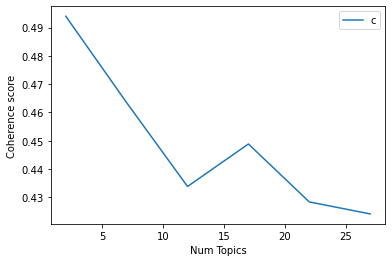

In [104]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [105]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.494
index: 1 | Num Topics = 7  has Coherence Value of 0.4635
index: 2 | Num Topics = 12  has Coherence Value of 0.4339
index: 3 | Num Topics = 17  has Coherence Value of 0.4489
index: 4 | Num Topics = 22  has Coherence Value of 0.4284
index: 5 | Num Topics = 27  has Coherence Value of 0.4242


In [135]:
# Select optimal number of topics
optimal_model_us_score5 = model_list_us_score5[0]

In [136]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score5 = pyLDAvis.gensim_models.prepare(optimal_model_us_score5, corpus_us_score5, id2word_us_score5)

In [137]:
print("pyLDAVis for us topics for score=5:")
vis_us_score5

pyLDAVis for us topics for score=5:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.119951  0.0       1        1  59.721998
0     -0.119951  0.0       2        1  40.278002, topic_info=         Term        Freq       Total Category  logprob  loglift
214       tok  120.000000  120.000000  Default  30.0000  30.0000
61       love  261.000000  261.000000  Default  29.0000  29.0000
340       tik   80.000000   80.000000  Default  28.0000  28.0000
18    feature  139.000000  139.000000  Default  27.0000  27.0000
71     follow   62.000000   62.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
23        old   26.979718   41.711995   Topic2  -5.2589   0.4737
98    amazing   35.698043  127.289623   Topic2  -4.9789  -0.3620
121      time   29.253589   71.855259   Topic2  -5.1780   0.0107
54   download   27.614040   57.392083   Topic2  -5.2357   0.1778
74      thing   28.384011   94.979687   Topic2  -5.2082  -0.2985

[147 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
486       1  0.216281     able
486       2  0.781016     able
299       1  0.964173  account
226       1  0.543360      add
226       2  0.455463      add
...     ...       ...      ...
209       1  0.086498     wish
209       2  0.908231     wish
110       1  0.992126     work
110       2  0.016535     work
327       2  0.993450    write

[168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## LDA Topic Modelling (Rating = 1,2,3)

In [109]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_us_score1N2N3 = clash_ios_us_review_YearMonth_score1N2N3.review.values.tolist()
review_words_us_score1N2N3 = list(sent_to_words(review_us_score1N2N3))
print(review_words_us_score1N2N3[:1])

[['way', 'better', 'then', 'tiktok', 'and', 'love', 'that', 'this', 'is', 'from', 'the', 'creators', 'of', 'vine', 'love', 'they', 'took', 'some', 'of', 'the', 'old', 'features', 'from', 'vine', 'and', 'put', 'it', 'into', 'this', 'app', 'keep', 'up', 'the', 'good', 'work']]


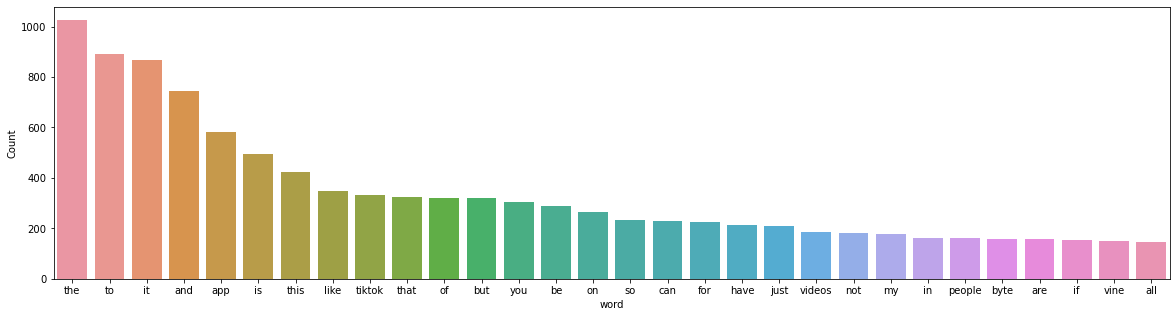

In [110]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score1N2N3))

In [111]:
# Clean text
review_us_ready_score1N2N3 = process_words(review_words_us_score1N2N3)  # processed Text Data! - move to each section

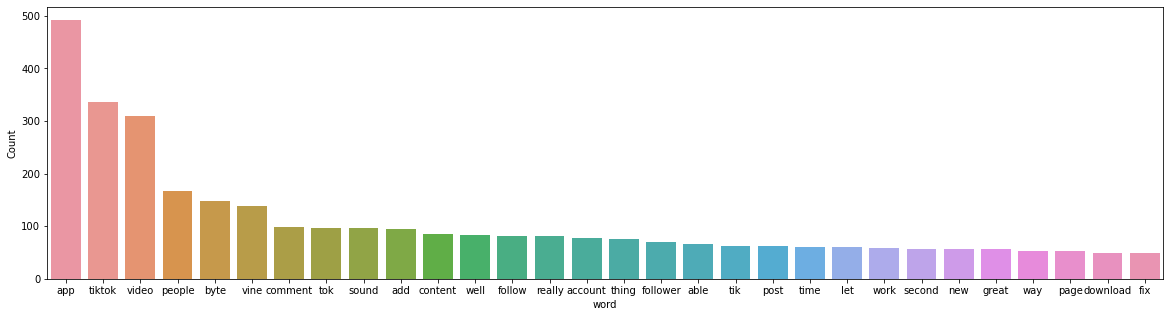

In [112]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score1N2N3))


In [113]:
# Create Dictionary
id2word_us_score1N2N3 = corpora.Dictionary(review_us_ready_score1N2N3)

2021-10-16 02:06:13,318 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:06:13,428 [INFO] gensim.corpora.dictionary - built Dictionary(1620 unique tokens: ['creator', 'feature', 'keep', 'love', 'old']...) from 655 documents (total 9500 corpus positions)
2021-10-16 02:06:13,442 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1620 unique tokens: ['creator', 'feature', 'keep', 'love', 'old']...) from 655 documents (total 9500 corpus positions)", 'datetime': '2021-10-16T02:06:13.441492', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [114]:
# Create Corpus: Term Document Frequency
corpus_us_score1N2N3 = [id2word_us_score1N2N3.doc2bow(text) for text in review_us_ready_score1N2N3]

In [115]:
# Training LDA model
model_list_us_score1N2N3, coherence_values_us_score1N2N3 = compute_coherence_values(dictionary=id2word_us_score1N2N3, corpus=corpus_us_score1N2N3, 
                                                              texts=review_us_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-16 02:06:13,505 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:06:13,507 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:06:13,510 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:06:13,513 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 655 documents, updating model once every 655 documents, evaluating perplexity every 655 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:06:15,904 [INFO] gensim.models.ldamodel - -7.943 per-word bound, 246.2 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:06:15,906 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #655/655
2021-10-16 02:06:17,948 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"app" + 0.023*"video" + 0.022*"tiktok" + 0.016*"vine" + 0.016*"byte" + 0.012*"people" + 0.012*"tok

2021-10-16 02:06:43,395 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.047*"app" + 0.043*"tiktok" + 0.037*"video" + 0.021*"people" + 0.013*"comment" + 0.013*"sound" + 0.012*"add" + 0.012*"byte" + 0.010*"content" + 0.010*"vine"
2021-10-16 02:06:43,397 [INFO] gensim.models.ldamodel - topic diff=0.017152, rho=0.301511
2021-10-16 02:06:44,620 [INFO] gensim.models.ldamodel - -6.428 per-word bound, 86.1 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:06:44,621 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #655/655
2021-10-16 02:06:45,528 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.041*"app" + 0.018*"tok" + 0.016*"vine" + 0.016*"byte" + 0.015*"account" + 0.015*"video" + 0.013*"tiktok" + 0.012*"tik" + 0.009*"new" + 0.009*"page"
2021-10-16 02:06:45,530 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.047*"app" + 0.043*"tiktok" + 0.037*"video" + 0.021*"people" + 0.013*"comment" + 0.013*"sound" + 0.012*"add" + 0.012*"b

2021-10-16 02:07:08,177 [INFO] gensim.models.ldamodel - topic diff=0.008490, rho=0.218218
2021-10-16 02:07:09,558 [INFO] gensim.models.ldamodel - -6.419 per-word bound, 85.5 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:07:09,562 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #655/655
2021-10-16 02:07:10,533 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.021*"tok" + 0.016*"account" + 0.016*"byte" + 0.015*"vine" + 0.014*"tik" + 0.012*"video" + 0.010*"tiktok" + 0.009*"new" + 0.008*"page"
2021-10-16 02:07:10,537 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.047*"app" + 0.044*"tiktok" + 0.038*"video" + 0.021*"people" + 0.014*"sound" + 0.014*"comment" + 0.013*"add" + 0.012*"byte" + 0.011*"vine" + 0.010*"content"
2021-10-16 02:07:10,541 [INFO] gensim.models.ldamodel - topic diff=0.008107, rho=0.213201
2021-10-16 02:07:11,933 [INFO] gensim.models.ldamodel - -6.418 per-word bound, 85.5 perplexity estimate 

2021-10-16 02:07:31,386 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #655/655
2021-10-16 02:07:32,264 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.022*"tok" + 0.017*"account" + 0.016*"byte" + 0.015*"vine" + 0.014*"tik" + 0.010*"video" + 0.009*"tiktok" + 0.009*"new" + 0.008*"delete"
2021-10-16 02:07:32,266 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.047*"app" + 0.044*"tiktok" + 0.039*"video" + 0.021*"people" + 0.014*"sound" + 0.014*"comment" + 0.013*"add" + 0.012*"byte" + 0.011*"vine" + 0.010*"able"
2021-10-16 02:07:32,272 [INFO] gensim.models.ldamodel - topic diff=0.006009, rho=0.176777
2021-10-16 02:07:33,361 [INFO] gensim.models.ldamodel - -6.414 per-word bound, 85.2 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:07:33,364 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #655/655
2021-10-16 02:07:34,183 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.040*"app" + 0.022*"tok"

2021-10-16 02:07:51,679 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.047*"app" + 0.044*"tiktok" + 0.039*"video" + 0.021*"people" + 0.014*"comment" + 0.014*"sound" + 0.013*"add" + 0.012*"byte" + 0.011*"vine" + 0.010*"really"
2021-10-16 02:07:51,681 [INFO] gensim.models.ldamodel - topic diff=0.004694, rho=0.154303
2021-10-16 02:07:52,756 [INFO] gensim.models.ldamodel - -6.410 per-word bound, 85.1 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:07:52,764 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #655/655
2021-10-16 02:07:53,520 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.041*"app" + 0.023*"tok" + 0.018*"account" + 0.016*"byte" + 0.015*"tik" + 0.015*"vine" + 0.009*"video" + 0.009*"delete" + 0.009*"new" + 0.008*"tiktok"
2021-10-16 02:07:53,522 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.047*"app" + 0.044*"tiktok" + 0.039*"video" + 0.021*"people" + 0.014*"comment" + 0.014*"sound" + 0.013*"add" + 0.012*"

2021-10-16 02:08:14,270 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 622 virtual documents
2021-10-16 02:08:14,543 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 02:08:14,545 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 02:08:14,548 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:08:14,552 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 655 documents, updating model once every 655 documents, evaluating perplexity every 655 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:08:16,278 [INFO] gensim.models.ldamodel - -9.182 per-word bound, 580.8 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:08:16,278 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #655/655
2021-10-16 02:08

2021-10-16 02:08:25,947 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #655/655
2021-10-16 02:08:26,673 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.039*"app" + 0.025*"follow" + 0.021*"video" + 0.019*"comment" + 0.018*"tiktok" + 0.016*"fix" + 0.015*"people" + 0.014*"let" + 0.012*"like" + 0.011*"post"
2021-10-16 02:08:26,773 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.053*"app" + 0.034*"video" + 0.024*"tiktok" + 0.022*"vine" + 0.015*"well" + 0.013*"add" + 0.012*"comment" + 0.012*"people" + 0.011*"really" + 0.011*"sound"
2021-10-16 02:08:26,778 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.068*"tiktok" + 0.061*"app" + 0.029*"video" + 0.021*"people" + 0.014*"content" + 0.013*"byte" + 0.013*"vine" + 0.011*"ban" + 0.009*"well" + 0.008*"sound"
2021-10-16 02:08:26,779 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.030*"app" + 0.021*"account" + 0.018*"video" + 0.018*"byte" + 0.016*"log" + 0.013*"new" + 0.012*"sign" + 0.011*"screen" + 0.011*"profile" + 0

2021-10-16 02:08:36,610 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"app" + 0.026*"follow" + 0.023*"video" + 0.019*"comment" + 0.017*"tiktok" + 0.016*"fix" + 0.016*"people" + 0.014*"let" + 0.013*"like" + 0.012*"view"
2021-10-16 02:08:36,614 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.079*"tok" + 0.059*"tik" + 0.025*"people" + 0.019*"app" + 0.016*"follow" + 0.013*"thing" + 0.013*"vine" + 0.012*"follower" + 0.012*"byte" + 0.010*"video"
2021-10-16 02:08:36,617 [INFO] gensim.models.ldamodel - topic diff=0.023002, rho=0.288675
2021-10-16 02:08:37,661 [INFO] gensim.models.ldamodel - -6.662 per-word bound, 101.3 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:08:37,663 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #655/655
2021-10-16 02:08:38,331 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.082*"tok" + 0.060*"tik" + 0.025*"people" + 0.019*"app" + 0.016*"follow" + 0.013*"thing" + 0.013*"vine" + 0.012*"fol

2021-10-16 02:08:47,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #655/655
2021-10-16 02:08:48,076 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.091*"tok" + 0.064*"tik" + 0.025*"people" + 0.018*"app" + 0.016*"follow" + 0.014*"thing" + 0.013*"vine" + 0.013*"follower" + 0.011*"byte" + 0.009*"video"
2021-10-16 02:08:48,078 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.040*"app" + 0.029*"video" + 0.015*"byte" + 0.014*"work" + 0.013*"keep" + 0.012*"problem" + 0.010*"way" + 0.010*"add" + 0.009*"long" + 0.009*"error"
2021-10-16 02:08:48,082 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"app" + 0.028*"follow" + 0.023*"video" + 0.020*"comment" + 0.018*"tiktok" + 0.017*"people" + 0.015*"fix" + 0.015*"let" + 0.013*"like" + 0.012*"post"
2021-10-16 02:08:48,089 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.075*"tiktok" + 0.061*"app" + 0.027*"video" + 0.021*"people" + 0.015*"content" + 0.014*"vine" + 0.014*"byte" + 0.012*"ban" + 0.009*"well" + 0.009*"

2021-10-16 02:08:56,178 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"video" + 0.028*"app" + 0.024*"tiktok" + 0.023*"add" + 0.018*"sound" + 0.018*"people" + 0.018*"comment" + 0.017*"byte" + 0.015*"feel" + 0.015*"able"
2021-10-16 02:08:56,181 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.076*"tiktok" + 0.061*"app" + 0.027*"video" + 0.021*"people" + 0.015*"content" + 0.014*"vine" + 0.014*"byte" + 0.012*"ban" + 0.009*"really" + 0.009*"well"
2021-10-16 02:08:56,183 [INFO] gensim.models.ldamodel - topic diff=0.007364, rho=0.208514
2021-10-16 02:08:57,183 [INFO] gensim.models.ldamodel - -6.641 per-word bound, 99.8 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:08:57,186 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #655/655
2021-10-16 02:08:58,035 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.040*"app" + 0.028*"video" + 0.015*"work" + 0.014*"byte" + 0.014*"keep" + 0.013*"problem" + 0.010*"way" + 0.009*"lon

2021-10-16 02:09:06,415 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.053*"app" + 0.038*"video" + 0.024*"tiktok" + 0.020*"vine" + 0.016*"sound" + 0.015*"well" + 0.014*"add" + 0.013*"comment" + 0.012*"people" + 0.012*"really"
2021-10-16 02:09:06,417 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"video" + 0.028*"app" + 0.024*"tiktok" + 0.023*"add" + 0.018*"sound" + 0.018*"comment" + 0.018*"people" + 0.017*"byte" + 0.015*"feel" + 0.015*"able"
2021-10-16 02:09:06,421 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.039*"account" + 0.030*"app" + 0.023*"byte" + 0.021*"log" + 0.016*"sign" + 0.015*"new" + 0.013*"apple" + 0.011*"video" + 0.011*"update" + 0.011*"option"
2021-10-16 02:09:06,428 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.033*"app" + 0.030*"follow" + 0.025*"video" + 0.021*"comment" + 0.017*"people" + 0.017*"let" + 0.015*"tiktok" + 0.014*"post" + 0.014*"fix" + 0.013*"view"
2021-10-16 02:09:06,433 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.077*"ti

2021-10-16 02:09:14,692 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"app" + 0.031*"follow" + 0.025*"video" + 0.022*"comment" + 0.018*"let" + 0.017*"people" + 0.014*"post" + 0.013*"view" + 0.013*"fix" + 0.013*"account"
2021-10-16 02:09:14,694 [INFO] gensim.models.ldamodel - topic diff=0.003833, rho=0.171499
2021-10-16 02:09:15,673 [INFO] gensim.models.ldamodel - -6.634 per-word bound, 99.3 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:09:15,674 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #655/655
2021-10-16 02:09:16,380 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.078*"tiktok" + 0.062*"app" + 0.026*"video" + 0.021*"people" + 0.015*"content" + 0.015*"vine" + 0.014*"byte" + 0.012*"ban" + 0.009*"really" + 0.008*"well"
2021-10-16 02:09:16,382 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.100*"tok" + 0.066*"tik" + 0.024*"people" + 0.017*"app" + 0.015*"follow" + 0.014*"thing" + 0.014*"follower" + 0.014

2021-10-16 02:09:25,969 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"follow" + 0.031*"app" + 0.025*"video" + 0.022*"comment" + 0.020*"let" + 0.017*"people" + 0.014*"post" + 0.014*"view" + 0.013*"spam" + 0.013*"fix"
2021-10-16 02:09:26,039 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.054*"app" + 0.038*"video" + 0.024*"tiktok" + 0.019*"vine" + 0.017*"sound" + 0.015*"well" + 0.013*"add" + 0.013*"people" + 0.013*"comment" + 0.012*"really"
2021-10-16 02:09:26,042 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.041*"account" + 0.030*"app" + 0.023*"byte" + 0.022*"log" + 0.016*"sign" + 0.015*"new" + 0.014*"apple" + 0.011*"video" + 0.010*"phone" + 0.010*"update"
2021-10-16 02:09:26,045 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.079*"tiktok" + 0.062*"app" + 0.026*"video" + 0.021*"people" + 0.015*"content" + 0.015*"vine" + 0.014*"byte" + 0.012*"ban" + 0.009*"really" + 0.008*"well"
2021-10-16 02:09:26,063 [INFO] gensim.models.ldamodel - topic diff=0.002854, rho=0.15

2021-10-16 02:09:33,682 [INFO] gensim.models.ldamodel - topic diff=0.002372, rho=0.149071
2021-10-16 02:09:34,570 [INFO] gensim.models.ldamodel - -6.631 per-word bound, 99.1 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:09:34,571 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #655/655
2021-10-16 02:09:35,320 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"video" + 0.028*"app" + 0.024*"add" + 0.024*"tiktok" + 0.019*"comment" + 0.018*"sound" + 0.018*"byte" + 0.017*"people" + 0.015*"feel" + 0.015*"able"
2021-10-16 02:09:35,322 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.041*"app" + 0.027*"video" + 0.015*"work" + 0.014*"keep" + 0.013*"problem" + 0.013*"byte" + 0.010*"way" + 0.009*"error" + 0.009*"time" + 0.008*"long"
2021-10-16 02:09:35,323 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.102*"tok" + 0.067*"tik" + 0.024*"people" + 0.016*"app" + 0.015*"follow" + 0.014*"follower" + 0.014*"thing" + 0.014*"vine

2021-10-16 02:09:44,094 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"follow" + 0.030*"app" + 0.026*"video" + 0.023*"comment" + 0.021*"let" + 0.017*"people" + 0.015*"post" + 0.014*"spam" + 0.014*"view" + 0.013*"account"
2021-10-16 02:09:44,098 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"video" + 0.028*"app" + 0.024*"add" + 0.024*"tiktok" + 0.019*"comment" + 0.018*"sound" + 0.018*"byte" + 0.017*"people" + 0.015*"able" + 0.015*"feel"
2021-10-16 02:09:44,119 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.103*"tok" + 0.068*"tik" + 0.024*"people" + 0.015*"app" + 0.015*"follow" + 0.014*"follower" + 0.014*"thing" + 0.013*"vine" + 0.011*"byte" + 0.009*"content"
2021-10-16 02:09:44,125 [INFO] gensim.models.ldamodel - topic diff=0.001908, rho=0.140028
2021-10-16 02:09:44,130 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1620, num_topics=7, decay=0.5, chunksize=1000) in 89.58s', 'datetime': '2021-10-16T02:09:44.130216', 'gensim': '

2021-10-16 02:10:00,788 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #655/655
2021-10-16 02:10:01,550 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"video" + 0.027*"app" + 0.019*"tiktok" + 0.015*"add" + 0.011*"able" + 0.010*"byte" + 0.010*"people" + 0.010*"content" + 0.010*"vine" + 0.010*"second"
2021-10-16 02:10:01,552 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"video" + 0.031*"vine" + 0.015*"app" + 0.015*"work" + 0.014*"tiktok" + 0.013*"byte" + 0.013*"new" + 0.013*"wish" + 0.011*"old" + 0.010*"late"
2021-10-16 02:10:01,553 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.061*"tok" + 0.050*"tik" + 0.030*"byte" + 0.018*"people" + 0.017*"app" + 0.016*"video" + 0.013*"follow" + 0.012*"second" + 0.011*"delete" + 0.011*"kinda"
2021-10-16 02:10:01,557 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.057*"app" + 0.028*"tiktok" + 0.027*"video" + 0.023*"vine" + 0.021*"well" + 0.015*"really" + 0.010*"time" + 0.010*"great" + 0.010*"account" + 0.010*

2021-10-16 02:10:10,698 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"app" + 0.026*"video" + 0.019*"fix" + 0.016*"follow" + 0.015*"screen" + 0.014*"comment" + 0.012*"spam" + 0.012*"byte" + 0.012*"delete" + 0.012*"tiktok"
2021-10-16 02:10:10,700 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"video" + 0.024*"app" + 0.022*"tiktok" + 0.020*"second" + 0.018*"byte" + 0.016*"comment" + 0.016*"follow" + 0.013*"feel" + 0.010*"vine" + 0.008*"big"
2021-10-16 02:10:10,702 [INFO] gensim.models.ldamodel - topic diff=0.040238, rho=0.301511
2021-10-16 02:10:11,764 [INFO] gensim.models.ldamodel - -6.763 per-word bound, 108.6 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:10:11,765 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #655/655
2021-10-16 02:10:12,614 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"app" + 0.023*"byte" + 0.019*"account" + 0.017*"tiktok" + 0.017*"follow" + 0.016*"problem" + 0.015*"error" 

2021-10-16 02:10:20,143 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #655/655
2021-10-16 02:10:20,819 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.049*"video" + 0.037*"app" + 0.027*"load" + 0.017*"vine" + 0.014*"login" + 0.011*"people" + 0.010*"like" + 0.009*"great" + 0.009*"time" + 0.009*"literally"
2021-10-16 02:10:20,820 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.038*"account" + 0.027*"log" + 0.026*"video" + 0.024*"app" + 0.017*"apple" + 0.016*"option" + 0.014*"phone" + 0.014*"sign" + 0.014*"let" + 0.013*"create"
2021-10-16 02:10:20,822 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.028*"app" + 0.018*"feature" + 0.016*"page" + 0.015*"mix" + 0.014*"add" + 0.013*"video" + 0.012*"kid" + 0.011*"comment" + 0.011*"vine" + 0.011*"thing"
2021-10-16 02:10:20,825 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.125*"tok" + 0.087*"tik" + 0.028*"byte" + 0.016*"app" + 0.016*"people" + 0.013*"video" + 0.012*"kinda" + 0.011*"content" + 0.011*"second" + 0.

2021-10-16 02:10:29,087 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.057*"app" + 0.031*"tiktok" + 0.028*"vine" + 0.027*"video" + 0.021*"well" + 0.016*"really" + 0.012*"time" + 0.011*"work" + 0.011*"great" + 0.009*"byte"
2021-10-16 02:10:29,090 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.099*"tiktok" + 0.071*"app" + 0.021*"content" + 0.019*"video" + 0.019*"people" + 0.018*"byte" + 0.016*"ban" + 0.013*"well" + 0.011*"vine" + 0.009*"really"
2021-10-16 02:10:29,091 [INFO] gensim.models.ldamodel - topic diff=0.007841, rho=0.213201
2021-10-16 02:10:30,072 [INFO] gensim.models.ldamodel - -6.739 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:10:30,073 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #655/655
2021-10-16 02:10:30,785 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.142*"tok" + 0.096*"tik" + 0.026*"byte" + 0.016*"people" + 0.015*"app" + 0.012*"video" + 0.012*"kinda" + 0.012*"conte

2021-10-16 02:10:39,669 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #655/655
2021-10-16 02:10:40,331 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.052*"video" + 0.037*"app" + 0.031*"load" + 0.018*"vine" + 0.014*"login" + 0.010*"people" + 0.010*"like" + 0.010*"great" + 0.010*"time" + 0.010*"literally"
2021-10-16 02:10:40,332 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.029*"app" + 0.019*"feature" + 0.016*"page" + 0.015*"mix" + 0.014*"add" + 0.013*"video" + 0.012*"kid" + 0.011*"vine" + 0.011*"thing" + 0.011*"way"
2021-10-16 02:10:40,340 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.058*"app" + 0.032*"tiktok" + 0.029*"vine" + 0.026*"video" + 0.021*"well" + 0.016*"really" + 0.012*"time" + 0.011*"work" + 0.011*"great" + 0.009*"byte"
2021-10-16 02:10:40,344 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"app" + 0.039*"video" + 0.033*"people" + 0.030*"sound" + 0.027*"add" + 0.025*"comment" + 0.021*"follower" + 0.020*"able" + 0.020*"tiktok" + 0.0

2021-10-16 02:10:49,236 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"video" + 0.025*"app" + 0.017*"tiktok" + 0.016*"add" + 0.014*"dumb" + 0.014*"stupid" + 0.011*"able" + 0.011*"vine" + 0.011*"content" + 0.011*"bad"
2021-10-16 02:10:49,240 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.058*"app" + 0.032*"tiktok" + 0.029*"vine" + 0.025*"video" + 0.022*"well" + 0.016*"really" + 0.012*"time" + 0.012*"work" + 0.011*"great" + 0.009*"camera"
2021-10-16 02:10:49,243 [INFO] gensim.models.ldamodel - topic diff=0.003878, rho=0.174078
2021-10-16 02:10:50,388 [INFO] gensim.models.ldamodel - -6.729 per-word bound, 106.1 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:10:50,434 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #655/655
2021-10-16 02:10:51,115 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.029*"app" + 0.019*"feature" + 0.016*"page" + 0.016*"mix" + 0.014*"add" + 0.013*"video" + 0.012*"kid" + 0.011*"vine"

2021-10-16 02:11:00,357 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.051*"app" + 0.040*"video" + 0.033*"people" + 0.030*"sound" + 0.027*"comment" + 0.027*"add" + 0.020*"follower" + 0.020*"tiktok" + 0.020*"able" + 0.018*"follow"
2021-10-16 02:11:00,359 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.034*"app" + 0.024*"byte" + 0.019*"account" + 0.017*"problem" + 0.016*"tiktok" + 0.016*"error" + 0.014*"follow" + 0.014*"email" + 0.014*"time" + 0.013*"sign"
2021-10-16 02:11:00,366 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.034*"video" + 0.023*"app" + 0.022*"tiktok" + 0.020*"second" + 0.017*"byte" + 0.014*"follow" + 0.012*"feel" + 0.011*"comment" + 0.010*"vine" + 0.008*"big"
2021-10-16 02:11:00,372 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.058*"app" + 0.033*"tiktok" + 0.029*"vine" + 0.025*"video" + 0.022*"well" + 0.016*"really" + 0.012*"time" + 0.012*"work" + 0.011*"great" + 0.009*"camera"
2021-10-16 02:11:00,378 [INFO] gensim.models.ldamodel - topic #3 (0.083):

2021-10-16 02:11:09,165 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"video" + 0.036*"app" + 0.032*"load" + 0.018*"vine" + 0.014*"login" + 0.010*"like" + 0.010*"literally" + 0.010*"time" + 0.010*"great" + 0.010*"day"
2021-10-16 02:11:09,169 [INFO] gensim.models.ldamodel - topic diff=0.002891, rho=0.150756
2021-10-16 02:11:10,195 [INFO] gensim.models.ldamodel - -6.723 per-word bound, 105.7 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:11:10,197 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #655/655
2021-10-16 02:11:10,955 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.053*"video" + 0.036*"app" + 0.032*"load" + 0.018*"vine" + 0.014*"login" + 0.010*"like" + 0.010*"literally" + 0.010*"time" + 0.010*"great" + 0.010*"day"
2021-10-16 02:11:10,959 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.058*"app" + 0.033*"tiktok" + 0.030*"vine" + 0.025*"video" + 0.022*"well" + 0.016*"really" + 0.012*"time" + 0.012*"wor

2021-10-16 02:11:20,339 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.059*"account" + 0.030*"log" + 0.026*"video" + 0.021*"app" + 0.020*"sign" + 0.020*"apple" + 0.017*"new" + 0.017*"phone" + 0.015*"option" + 0.015*"let"
2021-10-16 02:11:20,342 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"video" + 0.026*"app" + 0.017*"tiktok" + 0.016*"add" + 0.014*"dumb" + 0.014*"stupid" + 0.012*"vine" + 0.012*"content" + 0.011*"bad" + 0.011*"cringe"
2021-10-16 02:11:20,350 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.050*"app" + 0.040*"video" + 0.032*"people" + 0.030*"sound" + 0.028*"comment" + 0.027*"add" + 0.021*"tiktok" + 0.020*"follower" + 0.020*"able" + 0.019*"follow"
2021-10-16 02:11:20,352 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.059*"app" + 0.033*"tiktok" + 0.030*"vine" + 0.025*"video" + 0.022*"well" + 0.016*"really" + 0.012*"time" + 0.012*"work" + 0.011*"great" + 0.009*"camera"
2021-10-16 02:11:20,353 [INFO] gensim.models.ldamodel - topic diff=0.002451, rho

2021-10-16 02:11:36,089 [INFO] gensim.models.ldamodel - topic diff=0.224404, rho=0.500000
2021-10-16 02:11:37,220 [INFO] gensim.models.ldamodel - -7.016 per-word bound, 129.4 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:11:37,221 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #655/655
2021-10-16 02:11:37,978 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.069*"tok" + 0.059*"tik" + 0.032*"byte" + 0.018*"sound" + 0.017*"vine" + 0.016*"app" + 0.015*"people" + 0.014*"feature" + 0.012*"video" + 0.011*"tiktok"
2021-10-16 02:11:37,979 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.072*"app" + 0.049*"video" + 0.021*"tiktok" + 0.021*"people" + 0.017*"byte" + 0.013*"vine" + 0.012*"really" + 0.011*"thing" + 0.010*"able" + 0.010*"comment"
2021-10-16 02:11:37,981 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.039*"app" + 0.024*"sign" + 0.021*"byte" + 0.021*"video" + 0.018*"sound" + 0.018*"account" + 0.017*"add" + 0.014*"

2021-10-16 02:11:45,855 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.038*"app" + 0.025*"delete" + 0.025*"fix" + 0.019*"email" + 0.019*"tiktok" + 0.015*"give" + 0.013*"really" + 0.012*"tok" + 0.012*"honestly" + 0.012*"download"
2021-10-16 02:11:45,856 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.052*"app" + 0.037*"people" + 0.025*"video" + 0.022*"tok" + 0.020*"add" + 0.017*"sound" + 0.016*"able" + 0.016*"tiktok" + 0.016*"let" + 0.014*"follower"
2021-10-16 02:11:45,858 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.030*"account" + 0.026*"vine" + 0.021*"tiktok" + 0.019*"bad" + 0.015*"work" + 0.014*"old" + 0.013*"spam" + 0.013*"exist" + 0.011*"video" + 0.011*"byte"
2021-10-16 02:11:45,859 [INFO] gensim.models.ldamodel - topic diff=0.053672, rho=0.316228
2021-10-16 02:11:47,098 [INFO] gensim.models.ldamodel - -6.912 per-word bound, 120.4 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:11:47,099 [INFO] gensim.models.ldamodel - 

2021-10-16 02:11:54,346 [INFO] gensim.models.ldamodel - topic diff=0.022954, rho=0.258199
2021-10-16 02:11:55,233 [INFO] gensim.models.ldamodel - -6.884 per-word bound, 118.1 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:11:55,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #655/655
2021-10-16 02:11:55,880 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.069*"account" + 0.045*"log" + 0.033*"sign" + 0.028*"apple" + 0.026*"new" + 0.025*"option" + 0.024*"video" + 0.022*"hate" + 0.020*"tiktok" + 0.018*"back"
2021-10-16 02:11:55,887 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.028*"app" + 0.015*"funny" + 0.014*"comment" + 0.013*"add" + 0.013*"vine" + 0.011*"account" + 0.011*"mix" + 0.011*"feature" + 0.011*"ever" + 0.009*"show"
2021-10-16 02:11:55,919 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"follow" + 0.029*"video" + 0.027*"bot" + 0.025*"app" + 0.019*"vine" + 0.018*"account" + 0.017*"spam" + 0.016*

2021-10-16 02:12:03,491 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.074*"app" + 0.049*"video" + 0.020*"tiktok" + 0.020*"people" + 0.019*"byte" + 0.012*"vine" + 0.012*"really" + 0.012*"thing" + 0.010*"comment" + 0.010*"like"
2021-10-16 02:12:03,492 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.076*"account" + 0.047*"log" + 0.038*"sign" + 0.029*"apple" + 0.026*"option" + 0.025*"new" + 0.023*"video" + 0.022*"hate" + 0.019*"phone" + 0.018*"tiktok"
2021-10-16 02:12:03,494 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.050*"let" + 0.036*"audio" + 0.020*"people" + 0.020*"put" + 0.019*"sound" + 0.019*"app" + 0.017*"video" + 0.017*"show" + 0.016*"follower" + 0.014*"phone"
2021-10-16 02:12:03,495 [INFO] gensim.models.ldamodel - topic diff=0.012237, rho=0.218218
2021-10-16 02:12:04,397 [INFO] gensim.models.ldamodel - -6.868 per-word bound, 116.8 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:12:04,398 [INFO] gensim.models.ldamode

2021-10-16 02:12:11,476 [INFO] gensim.models.ldamodel - topic diff=0.009036, rho=0.196116
2021-10-16 02:12:12,272 [INFO] gensim.models.ldamodel - -6.860 per-word bound, 116.1 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:12:12,342 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #655/655
2021-10-16 02:12:12,864 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.039*"app" + 0.027*"fix" + 0.026*"delete" + 0.025*"email" + 0.017*"tiktok" + 0.015*"give" + 0.013*"really" + 0.013*"honestly" + 0.012*"download" + 0.010*"second"
2021-10-16 02:12:12,926 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.027*"video" + 0.022*"save" + 0.022*"profile" + 0.020*"page" + 0.019*"sound" + 0.016*"kid" + 0.014*"comment" + 0.013*"people" + 0.013*"add" + 0.010*"issue"
2021-10-16 02:12:12,931 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.030*"app" + 0.014*"funny" + 0.014*"vine" + 0.012*"mix" + 0.012*"ever" + 0.011*"comment" + 0.011*"featur

2021-10-16 02:12:20,926 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.042*"app" + 0.025*"tiktok" + 0.025*"really" + 0.019*"vine" + 0.018*"well" + 0.016*"video" + 0.016*"sound" + 0.016*"camera" + 0.015*"add" + 0.014*"great"
2021-10-16 02:12:20,932 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.103*"tiktok" + 0.056*"app" + 0.026*"content" + 0.021*"byte" + 0.019*"video" + 0.019*"vine" + 0.019*"well" + 0.018*"ban" + 0.011*"people" + 0.010*"download"
2021-10-16 02:12:20,945 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.126*"tok" + 0.086*"tik" + 0.033*"byte" + 0.019*"hard" + 0.018*"feature" + 0.016*"vine" + 0.016*"app" + 0.014*"people" + 0.013*"sound" + 0.012*"video"
2021-10-16 02:12:20,960 [INFO] gensim.models.ldamodel - topic diff=0.005967, rho=0.176777
2021-10-16 02:12:21,910 [INFO] gensim.models.ldamodel - -6.853 per-word bound, 115.6 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:12:21,911 [INFO] gensim.models.ldamodel - PR

2021-10-16 02:12:29,245 [INFO] gensim.models.ldamodel - topic diff=0.004429, rho=0.164399
2021-10-16 02:12:30,152 [INFO] gensim.models.ldamodel - -6.850 per-word bound, 115.3 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:12:30,158 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #655/655
2021-10-16 02:12:30,995 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.042*"app" + 0.025*"really" + 0.025*"tiktok" + 0.019*"vine" + 0.019*"well" + 0.018*"sound" + 0.017*"video" + 0.016*"camera" + 0.015*"add" + 0.014*"great"
2021-10-16 02:12:30,998 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.029*"vine" + 0.024*"bad" + 0.021*"tiktok" + 0.020*"account" + 0.019*"old" + 0.017*"work" + 0.014*"spam" + 0.012*"exist" + 0.010*"video" + 0.010*"content"
2021-10-16 02:12:31,016 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.033*"sound" + 0.024*"byte" + 0.024*"app" + 0.019*"feel" + 0.017*"tiktok" + 0.016*"content" + 0.016*"add" + 0.011*"

2021-10-16 02:12:40,610 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.040*"app" + 0.021*"sound" + 0.021*"video" + 0.021*"byte" + 0.018*"add" + 0.013*"comment" + 0.013*"time" + 0.012*"cool" + 0.012*"understand" + 0.011*"tiktok"
2021-10-16 02:12:40,643 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.058*"tiktok" + 0.052*"app" + 0.041*"video" + 0.023*"time" + 0.018*"people" + 0.017*"vine" + 0.016*"literally" + 0.012*"funny" + 0.012*"post" + 0.011*"copy"
2021-10-16 02:12:40,681 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.133*"tok" + 0.091*"tik" + 0.033*"byte" + 0.019*"hard" + 0.018*"feature" + 0.017*"vine" + 0.016*"app" + 0.014*"people" + 0.012*"sound" + 0.012*"video"
2021-10-16 02:12:40,694 [INFO] gensim.models.ldamodel - topic diff=0.003778, rho=0.152499
2021-10-16 02:12:42,055 [INFO] gensim.models.ldamodel - -6.846 per-word bound, 115.0 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:12:42,058 [INFO] gensim.models.ldamodel

2021-10-16 02:12:51,237 [INFO] gensim.models.ldamodel - topic diff=0.002824, rho=0.144338
2021-10-16 02:12:52,811 [INFO] gensim.models.ldamodel - -6.844 per-word bound, 114.8 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:12:52,813 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #655/655
2021-10-16 02:12:53,892 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.025*"video" + 0.024*"page" + 0.023*"save" + 0.022*"profile" + 0.020*"comment" + 0.019*"sound" + 0.016*"kid" + 0.013*"people" + 0.011*"add" + 0.010*"issue"
2021-10-16 02:12:53,893 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.075*"app" + 0.049*"video" + 0.020*"tiktok" + 0.020*"people" + 0.018*"byte" + 0.013*"vine" + 0.012*"really" + 0.011*"thing" + 0.011*"comment" + 0.010*"able"
2021-10-16 02:12:53,895 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.055*"let" + 0.037*"audio" + 0.020*"show" + 0.020*"put" + 0.019*"app" + 0.018*"sound" + 0.018*"people" + 0.0

2021-10-16 02:13:12,995 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.034*"tiktok" + 0.033*"video" + 0.028*"app" + 0.019*"follow" + 0.018*"add" + 0.014*"watch" + 0.014*"byte" + 0.014*"people" + 0.014*"guess" + 0.010*"vine"
2021-10-16 02:13:12,998 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.088*"tiktok" + 0.056*"app" + 0.023*"content" + 0.018*"ban" + 0.015*"video" + 0.014*"byte" + 0.010*"people" + 0.010*"vine" + 0.010*"feel" + 0.009*"well"
2021-10-16 02:13:13,000 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.056*"tok" + 0.041*"app" + 0.030*"tik" + 0.022*"work" + 0.017*"video" + 0.017*"barely" + 0.014*"tiktok" + 0.013*"design" + 0.012*"email" + 0.012*"download"
2021-10-16 02:13:13,002 [INFO] gensim.models.ldamodel - topic diff=0.249352, rho=0.577350
2021-10-16 02:13:14,031 [INFO] gensim.models.ldamodel - -7.177 per-word bound, 144.7 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:13:14,034 [INFO] gensim.models.ldamodel - 

2021-10-16 02:13:23,385 [INFO] gensim.models.ldamodel - -7.016 per-word bound, 129.4 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:13:23,387 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #655/655
2021-10-16 02:13:24,489 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.034*"tiktok" + 0.030*"video" + 0.023*"app" + 0.019*"follow" + 0.019*"add" + 0.019*"guess" + 0.018*"watch" + 0.015*"people" + 0.015*"byte" + 0.010*"vine"
2021-10-16 02:13:24,522 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.043*"app" + 0.033*"tiktok" + 0.026*"follow" + 0.024*"fix" + 0.020*"delete" + 0.018*"give" + 0.014*"time" + 0.014*"account" + 0.012*"honestly" + 0.012*"way"
2021-10-16 02:13:24,526 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.020*"page" + 0.019*"follow" + 0.018*"video" + 0.015*"comment" + 0.015*"profile" + 0.015*"sound" + 0.012*"let" + 0.012*"kid" + 0.012*"share" + 0.011*"tiktok"
2021-10-16 02:13:24,529 [INFO] gensim.models

2021-10-16 02:13:34,151 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.044*"app" + 0.034*"tiktok" + 0.025*"follow" + 0.024*"fix" + 0.020*"delete" + 0.019*"give" + 0.014*"time" + 0.014*"account" + 0.012*"honestly" + 0.012*"way"
2021-10-16 02:13:34,154 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.029*"app" + 0.024*"apple" + 0.023*"option" + 0.022*"gmail" + 0.022*"like" + 0.021*"view" + 0.021*"account" + 0.020*"people" + 0.019*"sign" + 0.016*"email"
2021-10-16 02:13:34,155 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.046*"app" + 0.043*"tiktok" + 0.031*"well" + 0.026*"vine" + 0.019*"really" + 0.017*"back" + 0.017*"byte" + 0.016*"time" + 0.014*"video" + 0.014*"camera"
2021-10-16 02:13:34,157 [INFO] gensim.models.ldamodel - topic diff=0.026317, rho=0.267261
2021-10-16 02:13:35,327 [INFO] gensim.models.ldamodel - -6.976 per-word bound, 125.9 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:13:35,328 [INFO] gensim.models.ldamodel

2021-10-16 02:13:43,406 [INFO] gensim.models.ldamodel - topic diff=0.014826, rho=0.229416
2021-10-16 02:13:44,285 [INFO] gensim.models.ldamodel - -6.958 per-word bound, 124.4 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:13:44,286 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #655/655
2021-10-16 02:13:44,857 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.036*"download" + 0.027*"shut" + 0.018*"tiktok" + 0.018*"delete" + 0.018*"access" + 0.018*"later" + 0.015*"let" + 0.009*"app" + 0.009*"hard" + 0.009*"camera"
2021-10-16 02:13:44,860 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.048*"video" + 0.038*"tiktok" + 0.032*"app" + 0.023*"vine" + 0.020*"page" + 0.016*"second" + 0.015*"byte" + 0.015*"follow" + 0.014*"hope" + 0.014*"user"
2021-10-16 02:13:44,861 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.047*"app" + 0.044*"tiktok" + 0.031*"well" + 0.027*"vine" + 0.020*"really" + 0.018*"back" + 0.017*"byte" + 0.01

2021-10-16 02:13:53,017 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.078*"load" + 0.027*"video" + 0.027*"search" + 0.024*"byte" + 0.018*"hashtag" + 0.015*"download" + 0.014*"people" + 0.013*"bad" + 0.013*"timeline" + 0.013*"instal"
2021-10-16 02:13:53,019 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.106*"tiktok" + 0.062*"app" + 0.026*"content" + 0.025*"ban" + 0.015*"byte" + 0.012*"people" + 0.011*"video" + 0.010*"feel" + 0.010*"well" + 0.009*"vine"
2021-10-16 02:13:53,020 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.219*"tok" + 0.147*"tik" + 0.037*"app" + 0.017*"work" + 0.014*"cause" + 0.013*"look" + 0.012*"hard" + 0.012*"download" + 0.011*"barely" + 0.011*"video"
2021-10-16 02:13:53,021 [INFO] gensim.models.ldamodel - topic diff=0.008785, rho=0.200000
2021-10-16 02:13:54,100 [INFO] gensim.models.ldamodel - -6.943 per-word bound, 123.1 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:13:54,104 [INFO] gensim.models.ldamod

2021-10-16 02:14:02,320 [INFO] gensim.models.ldamodel - topic diff=0.006235, rho=0.182574
2021-10-16 02:14:03,637 [INFO] gensim.models.ldamodel - -6.935 per-word bound, 122.4 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:14:03,638 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #655/655
2021-10-16 02:14:04,383 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.039*"byte" + 0.029*"vine" + 0.025*"people" + 0.022*"account" + 0.022*"video" + 0.022*"app" + 0.020*"definitely" + 0.020*"back" + 0.020*"feature" + 0.015*"follow"
2021-10-16 02:14:04,385 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.036*"video" + 0.025*"app" + 0.023*"great" + 0.022*"new" + 0.016*"tiktok" + 0.016*"time" + 0.015*"sound" + 0.015*"week" + 0.012*"hate" + 0.011*"section"
2021-10-16 02:14:04,387 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.108*"tiktok" + 0.062*"app" + 0.027*"content" + 0.025*"ban" + 0.015*"byte" + 0.012*"people" + 0.011*"video" 

2021-10-16 02:14:12,971 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.049*"app" + 0.038*"tiktok" + 0.035*"copy" + 0.027*"vine" + 0.013*"well" + 0.013*"comment" + 0.012*"add" + 0.012*"name" + 0.011*"video" + 0.011*"feature"
2021-10-16 02:14:12,980 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.050*"comment" + 0.046*"work" + 0.036*"spam" + 0.032*"bad" + 0.028*"follow" + 0.025*"upload" + 0.022*"video" + 0.018*"keep" + 0.018*"app" + 0.017*"full"
2021-10-16 02:14:12,986 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.048*"video" + 0.038*"tiktok" + 0.032*"app" + 0.023*"vine" + 0.020*"page" + 0.016*"byte" + 0.016*"hope" + 0.015*"second" + 0.014*"follow" + 0.014*"user"
2021-10-16 02:14:12,996 [INFO] gensim.models.ldamodel - topic diff=0.004737, rho=0.166667
2021-10-16 02:14:13,905 [INFO] gensim.models.ldamodel - -6.929 per-word bound, 121.9 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:14:13,907 [INFO] gensim.models.ldamodel - PR

2021-10-16 02:14:21,381 [INFO] gensim.models.ldamodel - topic diff=0.003624, rho=0.156174
2021-10-16 02:14:22,341 [INFO] gensim.models.ldamodel - -6.925 per-word bound, 121.6 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:14:22,383 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #655/655
2021-10-16 02:14:23,013 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.054*"app" + 0.040*"sound" + 0.038*"video" + 0.035*"add" + 0.031*"people" + 0.030*"comment" + 0.028*"able" + 0.022*"follower" + 0.022*"tiktok" + 0.016*"thing"
2021-10-16 02:14:23,015 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.048*"video" + 0.039*"tiktok" + 0.032*"app" + 0.023*"vine" + 0.020*"page" + 0.016*"hope" + 0.016*"byte" + 0.015*"second" + 0.014*"user" + 0.014*"follow"
2021-10-16 02:14:23,022 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.041*"video" + 0.020*"app" + 0.019*"little" + 0.019*"whole" + 0.019*"vine" + 0.017*"second" + 0.016*"tiktok" +

2021-10-16 02:14:32,417 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.039*"byte" + 0.031*"vine" + 0.026*"people" + 0.023*"account" + 0.022*"video" + 0.022*"app" + 0.021*"back" + 0.021*"definitely" + 0.020*"feature" + 0.017*"follow"
2021-10-16 02:14:32,421 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.054*"app" + 0.048*"video" + 0.036*"tiktok" + 0.017*"vine" + 0.017*"people" + 0.014*"work" + 0.013*"first" + 0.013*"sound" + 0.012*"byte" + 0.012*"roll"
2021-10-16 02:14:32,423 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.051*"comment" + 0.047*"work" + 0.035*"spam" + 0.032*"bad" + 0.030*"follow" + 0.025*"upload" + 0.023*"video" + 0.019*"app" + 0.018*"keep" + 0.018*"post"
2021-10-16 02:14:32,425 [INFO] gensim.models.ldamodel - topic diff=0.002647, rho=0.145865
2021-10-16 02:14:33,280 [INFO] gensim.models.ldamodel - -6.923 per-word bound, 121.3 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:14:33,281 [INFO] gensim.models.ldamo

2021-10-16 02:14:49,396 [INFO] gensim.models.ldamodel - -17.094 per-word bound, 139855.8 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:14:49,397 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #655/655
2021-10-16 02:14:50,863 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.034*"tiktok" + 0.031*"video" + 0.025*"app" + 0.016*"second" + 0.016*"sound" + 0.014*"time" + 0.013*"great" + 0.012*"content" + 0.011*"post" + 0.011*"way"
2021-10-16 02:14:50,866 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.046*"app" + 0.034*"tiktok" + 0.023*"vine" + 0.019*"video" + 0.015*"well" + 0.015*"people" + 0.015*"byte" + 0.012*"follow" + 0.012*"really" + 0.012*"follower"
2021-10-16 02:14:50,868 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.037*"tiktok" + 0.028*"app" + 0.019*"account" + 0.019*"video" + 0.018*"sound" + 0.018*"audio" + 0.013*"bot" + 0.013*"notification" + 0.013*"literally" + 0.013*"tell"
2021-10-16 02:14:50,871 [INFO]

2021-10-16 02:14:59,354 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.043*"tiktok" + 0.037*"video" + 0.024*"vine" + 0.022*"let" + 0.019*"never" + 0.018*"app" + 0.015*"bad" + 0.014*"sell" + 0.014*"whole" + 0.011*"really"
2021-10-16 02:14:59,361 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.038*"app" + 0.032*"time" + 0.022*"follow" + 0.017*"keep" + 0.016*"cool" + 0.015*"work" + 0.013*"add" + 0.013*"problem" + 0.013*"server" + 0.012*"waste"
2021-10-16 02:14:59,366 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.059*"load" + 0.030*"video" + 0.029*"byte" + 0.029*"app" + 0.026*"able" + 0.025*"tok" + 0.021*"sound" + 0.021*"people" + 0.019*"look" + 0.016*"change"
2021-10-16 02:14:59,370 [INFO] gensim.models.ldamodel - topic diff=0.129650, rho=0.377964
2021-10-16 02:15:00,408 [INFO] gensim.models.ldamodel - -7.128 per-word bound, 139.9 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:15:00,409 [INFO] gensim.models.ldamodel - PROGRESS

2021-10-16 02:15:07,749 [INFO] gensim.models.ldamodel - topic diff=0.041088, rho=0.288675
2021-10-16 02:15:08,753 [INFO] gensim.models.ldamodel - -7.082 per-word bound, 135.5 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:15:08,758 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #655/655
2021-10-16 02:15:09,439 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.061*"app" + 0.029*"video" + 0.024*"work" + 0.017*"love" + 0.017*"keep" + 0.017*"vine" + 0.017*"tiktok" + 0.015*"minute" + 0.014*"play" + 0.014*"put"
2021-10-16 02:15:09,441 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.049*"video" + 0.042*"like" + 0.039*"follow" + 0.036*"add" + 0.033*"people" + 0.031*"comment" + 0.027*"second" + 0.023*"app" + 0.021*"view" + 0.020*"follower"
2021-10-16 02:15:09,444 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.042*"tiktok" + 0.039*"app" + 0.027*"video" + 0.015*"vine" + 0.015*"literally" + 0.014*"fix" + 0.014*"require" +

2021-10-16 02:15:17,818 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.045*"app" + 0.028*"tiktok" + 0.019*"follow" + 0.013*"comment" + 0.013*"mean" + 0.013*"adult" + 0.013*"content" + 0.013*"kid" + 0.013*"user" + 0.013*"service"
2021-10-16 02:15:17,820 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.057*"app" + 0.032*"funny" + 0.018*"page" + 0.018*"mix" + 0.018*"creator" + 0.016*"well" + 0.014*"vine" + 0.014*"choose" + 0.014*"join" + 0.013*"first"
2021-10-16 02:15:17,823 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.054*"app" + 0.045*"video" + 0.039*"tiktok" + 0.022*"people" + 0.021*"vine" + 0.015*"byte" + 0.014*"much" + 0.012*"camera" + 0.011*"really" + 0.011*"work"
2021-10-16 02:15:17,826 [INFO] gensim.models.ldamodel - topic diff=0.017116, rho=0.235702
2021-10-16 02:15:18,803 [INFO] gensim.models.ldamodel - -7.059 per-word bound, 133.3 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:15:18,805 [INFO] gensim.models.ldamode

2021-10-16 02:15:25,461 [INFO] gensim.models.ldamodel - topic diff=0.010969, rho=0.208514
2021-10-16 02:15:26,184 [INFO] gensim.models.ldamodel - -7.046 per-word bound, 132.2 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:15:26,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #655/655
2021-10-16 02:15:26,800 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.037*"sound" + 0.033*"tiktok" + 0.028*"app" + 0.025*"comment" + 0.021*"wish" + 0.021*"vine" + 0.016*"video" + 0.014*"byte" + 0.013*"save" + 0.012*"delete"
2021-10-16 02:15:26,803 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.045*"video" + 0.031*"app" + 0.029*"follow" + 0.026*"page" + 0.022*"follower" + 0.022*"vine" + 0.022*"thing" + 0.020*"tiktok" + 0.016*"user" + 0.015*"profile"
2021-10-16 02:15:26,804 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.040*"app" + 0.040*"tiktok" + 0.030*"vine" + 0.022*"video" + 0.019*"well" + 0.017*"people" + 0.014*"follow" 

2021-10-16 02:15:36,118 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.045*"app" + 0.028*"tiktok" + 0.013*"comment" + 0.013*"adult" + 0.013*"mean" + 0.013*"kid" + 0.013*"user" + 0.013*"service" + 0.013*"zebra" + 0.013*"bruh"
2021-10-16 02:15:36,126 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.044*"app" + 0.029*"tiktok" + 0.027*"byte" + 0.025*"video" + 0.019*"account" + 0.019*"vine" + 0.018*"feel" + 0.014*"literally" + 0.014*"time" + 0.014*"add"
2021-10-16 02:15:36,130 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.045*"video" + 0.031*"app" + 0.029*"follow" + 0.028*"page" + 0.023*"follower" + 0.022*"thing" + 0.022*"vine" + 0.019*"tiktok" + 0.016*"user" + 0.014*"profile"
2021-10-16 02:15:36,132 [INFO] gensim.models.ldamodel - topic diff=0.007260, rho=0.185695
2021-10-16 02:15:37,306 [INFO] gensim.models.ldamodel - -7.035 per-word bound, 131.1 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:15:37,307 [INFO] gensim.models.lda

2021-10-16 02:15:43,911 [INFO] gensim.models.ldamodel - topic diff=0.005653, rho=0.171499
2021-10-16 02:15:44,742 [INFO] gensim.models.ldamodel - -7.027 per-word bound, 130.4 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:15:44,745 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #655/655
2021-10-16 02:15:45,311 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.045*"app" + 0.029*"tiktok" + 0.013*"comment" + 0.013*"adult" + 0.013*"kid" + 0.013*"mean" + 0.013*"user" + 0.013*"service" + 0.013*"zebra" + 0.013*"bruh"
2021-10-16 02:15:45,314 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.040*"app" + 0.040*"time" + 0.023*"crash" + 0.020*"cool" + 0.018*"keep" + 0.017*"work" + 0.014*"problem" + 0.014*"server" + 0.014*"waste" + 0.013*"follow"
2021-10-16 02:15:45,316 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.058*"app" + 0.029*"video" + 0.020*"work" + 0.017*"keep" + 0.017*"love" + 0.016*"vine" + 0.016*"tiktok" + 0.016*"

2021-10-16 02:15:53,924 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.056*"app" + 0.045*"video" + 0.040*"tiktok" + 0.021*"vine" + 0.020*"people" + 0.016*"byte" + 0.013*"much" + 0.013*"camera" + 0.011*"really" + 0.011*"roll"
2021-10-16 02:15:53,926 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.091*"load" + 0.039*"video" + 0.036*"app" + 0.035*"byte" + 0.027*"look" + 0.024*"able" + 0.024*"sound" + 0.023*"long" + 0.019*"people" + 0.016*"tok"
2021-10-16 02:15:53,928 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.068*"sound" + 0.050*"tiktok" + 0.038*"audio" + 0.034*"add" + 0.028*"bot" + 0.023*"video" + 0.021*"stuff" + 0.020*"app" + 0.018*"comment" + 0.017*"far"
2021-10-16 02:15:53,930 [INFO] gensim.models.ldamodel - topic diff=0.004556, rho=0.158114
2021-10-16 02:15:54,870 [INFO] gensim.models.ldamodel - -7.020 per-word bound, 129.8 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:15:54,922 [INFO] gensim.models.ldamodel - PROGR

2021-10-16 02:16:02,079 [INFO] gensim.models.ldamodel - topic diff=0.003692, rho=0.149071
2021-10-16 02:16:03,052 [INFO] gensim.models.ldamodel - -7.017 per-word bound, 129.5 perplexity estimate based on a held-out corpus of 655 documents with 9500 words
2021-10-16 02:16:03,054 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #655/655
2021-10-16 02:16:03,692 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.060*"app" + 0.034*"funny" + 0.018*"mix" + 0.018*"page" + 0.018*"creator" + 0.016*"well" + 0.014*"vine" + 0.013*"choose" + 0.013*"join" + 0.013*"first"
2021-10-16 02:16:03,694 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.023*"vine" + 0.016*"content" + 0.016*"video" + 0.016*"app" + 0.015*"late" + 0.015*"page" + 0.015*"yet" + 0.015*"sound" + 0.013*"tiktok" + 0.011*"section"
2021-10-16 02:16:03,698 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.111*"tiktok" + 0.076*"app" + 0.038*"ban" + 0.026*"byte" + 0.023*"content" + 0.022*"well" + 0.016*"download" + 0.01

2021-10-16 02:16:12,147 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.056*"app" + 0.045*"video" + 0.039*"tiktok" + 0.021*"vine" + 0.019*"people" + 0.016*"byte" + 0.013*"much" + 0.013*"camera" + 0.011*"really" + 0.011*"roll"
2021-10-16 02:16:12,150 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.045*"app" + 0.030*"tiktok" + 0.027*"byte" + 0.025*"video" + 0.020*"account" + 0.019*"vine" + 0.019*"feel" + 0.015*"literally" + 0.015*"time" + 0.013*"add"
2021-10-16 02:16:12,158 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.050*"video" + 0.034*"byte" + 0.022*"let" + 0.021*"app" + 0.020*"people" + 0.019*"comment" + 0.018*"time" + 0.017*"tiktok" + 0.015*"screen" + 0.014*"really"
2021-10-16 02:16:12,161 [INFO] gensim.models.ldamodel - topic diff=0.002988, rho=0.140028
2021-10-16 02:16:12,164 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1620, num_topics=27, decay=0.5, chunksize=1000) in 84.38s', 'datetime': '2021-10-16T02:16:12.164143', 'gens

In [116]:
%store model_list_us_score1N2N3
%store coherence_values_us_score1N2N3

Stored 'model_list_us_score1N2N3' (list)
Stored 'coherence_values_us_score1N2N3' (list)


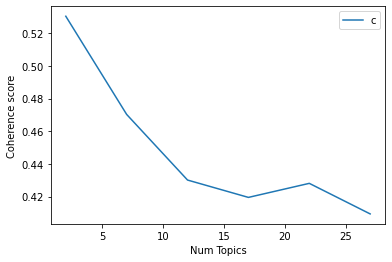

In [117]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [118]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.5304
index: 1 | Num Topics = 7  has Coherence Value of 0.4703
index: 2 | Num Topics = 12  has Coherence Value of 0.4301
index: 3 | Num Topics = 17  has Coherence Value of 0.4195
index: 4 | Num Topics = 22  has Coherence Value of 0.4281
index: 5 | Num Topics = 27  has Coherence Value of 0.4094


In [138]:
# Select optimal number of topics
optimal_model_us_score1N2N3 = model_list_us_score1N2N3[0]

In [139]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_score1N2N3, corpus_us_score1N2N3, id2word_us_score1N2N3)

In [140]:
print("pyLDAVis for us topics for score=1,2,3:")
vis_us_score1N2N3

pyLDAVis for us topics for score=1,2,3:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.088483  0.0       1        1  64.441661
0     -0.088483  0.0       2        1  35.558339, topic_info=        Term        Freq       Total Category  logprob  loglift
67       tok   79.000000   79.000000  Default  30.0000  30.0000
53   account   63.000000   63.000000  Default  29.0000  29.0000
66       tik   51.000000   51.000000  Default  28.0000  28.0000
6     tiktok  294.000000  294.000000  Default  27.0000  27.0000
409    sound   85.000000   85.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
47     video   28.154160  270.928104   Topic2  -4.7874  -1.2302
6     tiktok   26.210474  294.928215   Topic2  -4.8589  -1.3866
9       well   17.408484   72.515099   Topic2  -5.2681  -0.3928
186  content   16.800560   74.335445   Topic2  -5.3036  -0.4532
51    people   17.870779  145.703088   Topic2  -5.2419  -1.0644

[148 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
22        1  0.998919      able
22        2  0.016931      able
53        1  0.031637   account
53        2  0.964933   account
361       1  0.963625  actually
...     ...       ...       ...
9         1  0.758463      well
9         2  0.234434      well
10        1  0.475043      work
10        2  0.514630      work
101       2  0.980813     wrong

[177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

# By-rating of each year

## By-rating of 2020 (Rating=1,2,3)

In [141]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_us_2020_score1N2N3 = clash_ios_us_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_us_2020_score1N2N3 = list(sent_to_words(review_us_2020_score1N2N3))
print(review_words_us_2020_score1N2N3[:1])

[['way', 'better', 'then', 'tiktok', 'and', 'love', 'that', 'this', 'is', 'from', 'the', 'creators', 'of', 'vine', 'love', 'they', 'took', 'some', 'of', 'the', 'old', 'features', 'from', 'vine', 'and', 'put', 'it', 'into', 'this', 'app', 'keep', 'up', 'the', 'good', 'work']]


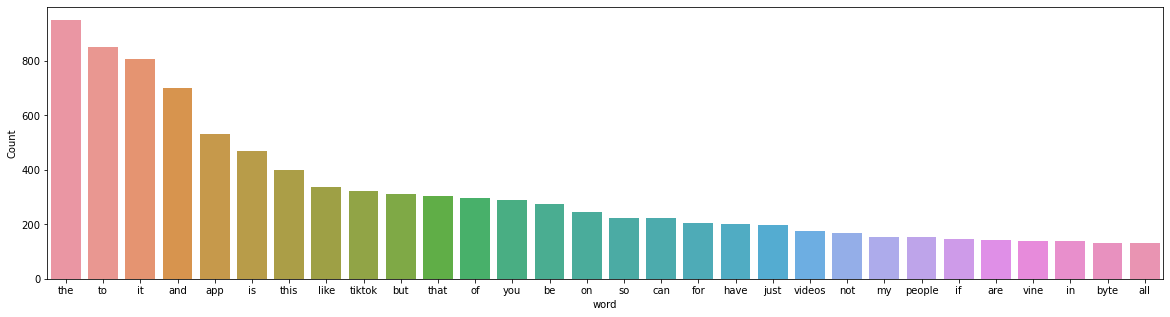

In [142]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2020_score1N2N3))

In [143]:
# Clean text
review_words_us_ready_2020_score1N2N3 = process_words(review_words_us_2020_score1N2N3)  # processed Text Data! - move to each section

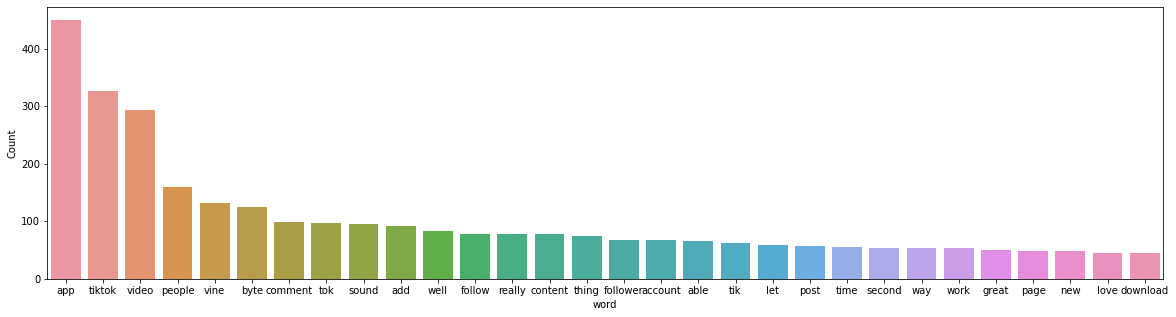

In [144]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2020_score1N2N3))


In [145]:
# Create Dictionary
id2word_us_2020_score1N2N3 = corpora.Dictionary(review_words_us_ready_2020_score1N2N3)

2021-10-16 02:37:00,941 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:37:01,010 [INFO] gensim.corpora.dictionary - built Dictionary(1524 unique tokens: ['creator', 'feature', 'keep', 'love', 'old']...) from 620 documents (total 8836 corpus positions)
2021-10-16 02:37:01,012 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1524 unique tokens: ['creator', 'feature', 'keep', 'love', 'old']...) from 620 documents (total 8836 corpus positions)", 'datetime': '2021-10-16T02:37:01.012334', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [146]:
# Create Corpus: Term Document Frequency
corpus_us_2020_score1N2N3 = [id2word_us_2020_score1N2N3.doc2bow(text) for text in review_words_us_ready_2020_score1N2N3]

In [147]:
# Training LDA model
model_list_us_2020_score1N2N3, coherence_values_us_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2020_score1N2N3, corpus=corpus_us_2020_score1N2N3, 
                                                              texts=review_words_us_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-16 02:37:01,053 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:37:01,055 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:37:01,057 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:37:01,059 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 620 documents, updating model once every 620 documents, evaluating perplexity every 620 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:37:04,372 [INFO] gensim.models.ldamodel - -7.885 per-word bound, 236.5 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:37:04,377 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #620/620
2021-10-16 02:37:07,299 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"app" + 0.031*"tiktok" + 0.024*"video" + 0.015*"byte" + 0.014*"vine" + 0.012*"people" + 0.010*"acc

2021-10-16 02:37:31,501 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"app" + 0.037*"tiktok" + 0.031*"video" + 0.021*"people" + 0.014*"tok" + 0.014*"comment" + 0.014*"sound" + 0.013*"vine" + 0.012*"add" + 0.011*"well"
2021-10-16 02:37:31,503 [INFO] gensim.models.ldamodel - topic diff=0.017007, rho=0.301511
2021-10-16 02:37:32,630 [INFO] gensim.models.ldamodel - -6.377 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:37:32,631 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #620/620
2021-10-16 02:37:33,451 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.045*"app" + 0.024*"video" + 0.022*"tiktok" + 0.016*"byte" + 0.016*"account" + 0.013*"vine" + 0.013*"time" + 0.009*"way" + 0.008*"work" + 0.007*"people"
2021-10-16 02:37:33,454 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"app" + 0.038*"tiktok" + 0.031*"video" + 0.021*"people" + 0.014*"tok" + 0.014*"comment" + 0.014*"sound" + 0.013*"v

2021-10-16 02:37:53,854 [INFO] gensim.models.ldamodel - topic diff=0.007705, rho=0.218218
2021-10-16 02:37:55,155 [INFO] gensim.models.ldamodel - -6.369 per-word bound, 82.6 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:37:55,161 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #620/620
2021-10-16 02:37:56,122 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"app" + 0.024*"video" + 0.018*"tiktok" + 0.017*"account" + 0.016*"byte" + 0.013*"time" + 0.012*"vine" + 0.009*"work" + 0.009*"way" + 0.007*"back"
2021-10-16 02:37:56,125 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"app" + 0.040*"tiktok" + 0.031*"video" + 0.022*"people" + 0.015*"tok" + 0.014*"comment" + 0.014*"sound" + 0.013*"vine" + 0.012*"add" + 0.011*"well"
2021-10-16 02:37:56,129 [INFO] gensim.models.ldamodel - topic diff=0.007276, rho=0.213201
2021-10-16 02:37:57,046 [INFO] gensim.models.ldamodel - -6.368 per-word bound, 82.6 perplexity estimate ba

2021-10-16 02:38:14,192 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #620/620
2021-10-16 02:38:14,844 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"app" + 0.025*"video" + 0.017*"account" + 0.016*"tiktok" + 0.016*"byte" + 0.014*"time" + 0.011*"vine" + 0.009*"work" + 0.009*"way" + 0.007*"back"
2021-10-16 02:38:14,846 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"app" + 0.041*"tiktok" + 0.031*"video" + 0.022*"people" + 0.015*"tok" + 0.014*"comment" + 0.014*"sound" + 0.014*"vine" + 0.012*"add" + 0.012*"well"
2021-10-16 02:38:14,847 [INFO] gensim.models.ldamodel - topic diff=0.004583, rho=0.176777
2021-10-16 02:38:15,845 [INFO] gensim.models.ldamodel - -6.365 per-word bound, 82.4 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:38:15,848 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #620/620
2021-10-16 02:38:16,515 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"app" + 0.025*"video

2021-10-16 02:38:30,642 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"app" + 0.041*"tiktok" + 0.031*"video" + 0.022*"people" + 0.015*"tok" + 0.014*"comment" + 0.014*"sound" + 0.014*"vine" + 0.012*"add" + 0.012*"follow"
2021-10-16 02:38:30,646 [INFO] gensim.models.ldamodel - topic diff=0.003598, rho=0.154303
2021-10-16 02:38:31,476 [INFO] gensim.models.ldamodel - -6.363 per-word bound, 82.3 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:38:31,480 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #620/620
2021-10-16 02:38:32,150 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.042*"app" + 0.025*"video" + 0.018*"account" + 0.015*"byte" + 0.015*"tiktok" + 0.014*"time" + 0.011*"vine" + 0.010*"work" + 0.009*"way" + 0.008*"back"
2021-10-16 02:38:32,152 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"app" + 0.041*"tiktok" + 0.031*"video" + 0.022*"people" + 0.015*"tok" + 0.014*"comment" + 0.014*"sound" + 0.014*"v

2021-10-16 02:38:47,819 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 593 virtual documents
2021-10-16 02:38:48,127 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 02:38:48,131 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 02:38:48,134 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:38:48,138 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 620 documents, updating model once every 620 documents, evaluating perplexity every 620 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:38:49,551 [INFO] gensim.models.ldamodel - -9.140 per-word bound, 564.3 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:38:49,553 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #620/620
2021-10-16 02:38

2021-10-16 02:38:58,393 [INFO] gensim.models.ldamodel - -6.657 per-word bound, 100.9 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:38:58,394 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #620/620
2021-10-16 02:38:59,073 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"app" + 0.032*"byte" + 0.014*"tiktok" + 0.012*"work" + 0.010*"way" + 0.010*"video" + 0.010*"sign" + 0.009*"vine" + 0.009*"email" + 0.008*"thing"
2021-10-16 02:38:59,081 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"app" + 0.029*"account" + 0.025*"let" + 0.022*"people" + 0.020*"tiktok" + 0.013*"follower" + 0.012*"new" + 0.011*"bad" + 0.011*"record" + 0.011*"love"
2021-10-16 02:38:59,096 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.037*"app" + 0.032*"sound" + 0.029*"tiktok" + 0.027*"video" + 0.027*"comment" + 0.027*"add" + 0.012*"able" + 0.011*"byte" + 0.011*"save" + 0.010*"audio"
2021-10-16 02:38:59,110 [INFO] gensim.models.ldamodel - 

2021-10-16 02:39:08,219 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"tiktok" + 0.049*"video" + 0.044*"app" + 0.026*"people" + 0.015*"byte" + 0.012*"really" + 0.011*"time" + 0.010*"download" + 0.010*"vine" + 0.009*"ban"
2021-10-16 02:39:08,221 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.074*"tok" + 0.051*"tik" + 0.044*"app" + 0.017*"people" + 0.016*"add" + 0.016*"vine" + 0.014*"video" + 0.011*"thing" + 0.010*"well" + 0.009*"profile"
2021-10-16 02:39:08,223 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"app" + 0.022*"video" + 0.018*"follower" + 0.016*"tiktok" + 0.012*"people" + 0.012*"vine" + 0.011*"follow" + 0.010*"byte" + 0.010*"sound" + 0.009*"love"
2021-10-16 02:39:08,228 [INFO] gensim.models.ldamodel - topic diff=0.024822, rho=0.288675
2021-10-16 02:39:09,338 [INFO] gensim.models.ldamodel - -6.624 per-word bound, 98.6 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:39:09,340 [INFO] gensim.models.ldamodel - P

2021-10-16 02:39:19,887 [INFO] gensim.models.ldamodel - topic diff=0.012475, rho=0.242536
2021-10-16 02:39:20,819 [INFO] gensim.models.ldamodel - -6.614 per-word bound, 98.0 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:39:20,820 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #620/620
2021-10-16 02:39:21,536 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"tiktok" + 0.049*"video" + 0.044*"app" + 0.026*"people" + 0.015*"byte" + 0.012*"really" + 0.011*"time" + 0.010*"download" + 0.010*"vine" + 0.010*"ban"
2021-10-16 02:39:21,539 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"app" + 0.035*"account" + 0.030*"let" + 0.021*"people" + 0.019*"tiktok" + 0.014*"new" + 0.013*"record" + 0.012*"bad" + 0.011*"love" + 0.010*"video"
2021-10-16 02:39:21,542 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"app" + 0.022*"video" + 0.020*"follower" + 0.017*"tiktok" + 0.013*"vine" + 0.012*"people" + 0.011*"follow" + 0.

2021-10-16 02:39:29,399 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.035*"app" + 0.034*"byte" + 0.013*"work" + 0.013*"sign" + 0.012*"tiktok" + 0.011*"email" + 0.010*"way" + 0.010*"video" + 0.009*"account" + 0.009*"problem"
2021-10-16 02:39:29,400 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"app" + 0.045*"tiktok" + 0.031*"video" + 0.023*"vine" + 0.021*"follow" + 0.017*"well" + 0.013*"people" + 0.013*"post" + 0.012*"second" + 0.012*"page"
2021-10-16 02:39:29,403 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.039*"sound" + 0.037*"app" + 0.033*"add" + 0.032*"video" + 0.032*"comment" + 0.027*"tiktok" + 0.018*"able" + 0.017*"audio" + 0.011*"byte" + 0.011*"people"
2021-10-16 02:39:29,405 [INFO] gensim.models.ldamodel - topic diff=0.007141, rho=0.208514
2021-10-16 02:39:30,343 [INFO] gensim.models.ldamodel - -6.609 per-word bound, 97.6 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:39:30,345 [INFO] gensim.models.ldamodel - 

2021-10-16 02:39:38,591 [INFO] gensim.models.ldamodel - -6.605 per-word bound, 97.4 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:39:38,592 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #620/620
2021-10-16 02:39:39,285 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"account" + 0.036*"app" + 0.033*"let" + 0.021*"people" + 0.019*"tiktok" + 0.014*"new" + 0.014*"record" + 0.013*"bad" + 0.010*"love" + 0.010*"video"
2021-10-16 02:39:39,288 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"sound" + 0.038*"app" + 0.033*"add" + 0.033*"video" + 0.032*"comment" + 0.027*"tiktok" + 0.019*"able" + 0.018*"audio" + 0.011*"byte" + 0.011*"follower"
2021-10-16 02:39:39,289 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"tiktok" + 0.049*"video" + 0.045*"app" + 0.025*"people" + 0.015*"byte" + 0.012*"time" + 0.012*"really" + 0.010*"download" + 0.010*"vine" + 0.010*"ban"
2021-10-16 02:39:39,295 [INFO] gensim.models.ldam

2021-10-16 02:39:47,137 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.035*"app" + 0.034*"byte" + 0.013*"work" + 0.013*"sign" + 0.011*"tiktok" + 0.011*"email" + 0.010*"way" + 0.010*"video" + 0.010*"delete" + 0.010*"account"
2021-10-16 02:39:47,138 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"app" + 0.046*"tiktok" + 0.031*"video" + 0.025*"vine" + 0.022*"follow" + 0.016*"well" + 0.014*"people" + 0.013*"post" + 0.012*"page" + 0.012*"second"
2021-10-16 02:39:47,139 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.085*"tok" + 0.057*"tik" + 0.042*"app" + 0.017*"people" + 0.015*"vine" + 0.012*"video" + 0.011*"well" + 0.010*"add" + 0.010*"profile" + 0.010*"thing"
2021-10-16 02:39:47,141 [INFO] gensim.models.ldamodel - topic diff=0.004332, rho=0.171499
2021-10-16 02:39:48,008 [INFO] gensim.models.ldamodel - -6.601 per-word bound, 97.1 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:39:48,016 [INFO] gensim.models.ldamodel - PROGRE

2021-10-16 02:39:56,911 [INFO] gensim.models.ldamodel - -6.599 per-word bound, 96.9 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:39:56,913 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #620/620
2021-10-16 02:39:57,666 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.034*"byte" + 0.034*"app" + 0.014*"sign" + 0.013*"work" + 0.011*"email" + 0.011*"tiktok" + 0.010*"way" + 0.010*"delete" + 0.010*"account" + 0.010*"video"
2021-10-16 02:39:57,669 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.039*"sound" + 0.038*"app" + 0.035*"add" + 0.034*"video" + 0.033*"comment" + 0.027*"tiktok" + 0.021*"able" + 0.020*"audio" + 0.012*"follower" + 0.012*"people"
2021-10-16 02:39:57,671 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.087*"tok" + 0.057*"tik" + 0.042*"app" + 0.017*"people" + 0.015*"vine" + 0.011*"video" + 0.011*"well" + 0.010*"profile" + 0.010*"thing" + 0.010*"add"
2021-10-16 02:39:57,674 [INFO] gensim.models.ldamode

2021-10-16 02:40:05,927 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.032*"app" + 0.021*"follower" + 0.020*"video" + 0.018*"tiktok" + 0.013*"vine" + 0.012*"people" + 0.012*"follow" + 0.010*"byte" + 0.010*"show" + 0.009*"change"
2021-10-16 02:40:05,930 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"account" + 0.035*"app" + 0.034*"let" + 0.021*"people" + 0.018*"tiktok" + 0.014*"new" + 0.014*"record" + 0.011*"bad" + 0.010*"love" + 0.010*"video"
2021-10-16 02:40:05,932 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"tiktok" + 0.049*"video" + 0.045*"app" + 0.025*"people" + 0.015*"byte" + 0.013*"time" + 0.012*"really" + 0.011*"download" + 0.010*"ban" + 0.009*"long"
2021-10-16 02:40:05,933 [INFO] gensim.models.ldamodel - topic diff=0.003295, rho=0.149071
2021-10-16 02:40:06,845 [INFO] gensim.models.ldamodel - -6.596 per-word bound, 96.7 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:40:06,849 [INFO] gensim.models.ldamodel

2021-10-16 02:40:14,897 [INFO] gensim.models.ldamodel - topic diff=0.002967, rho=0.141421
2021-10-16 02:40:15,902 [INFO] gensim.models.ldamodel - -6.594 per-word bound, 96.6 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:40:15,906 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #620/620
2021-10-16 02:40:16,765 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.039*"sound" + 0.038*"app" + 0.036*"add" + 0.034*"video" + 0.033*"comment" + 0.027*"tiktok" + 0.021*"able" + 0.020*"audio" + 0.013*"people" + 0.012*"follower"
2021-10-16 02:40:16,773 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.089*"tok" + 0.058*"tik" + 0.042*"app" + 0.016*"people" + 0.014*"vine" + 0.011*"well" + 0.011*"profile" + 0.010*"video" + 0.009*"thing" + 0.009*"much"
2021-10-16 02:40:16,783 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.059*"app" + 0.046*"tiktok" + 0.031*"video" + 0.026*"vine" + 0.022*"follow" + 0.016*"well" + 0.014*"people" + 0.013

2021-10-16 02:40:29,759 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.060*"app" + 0.055*"tiktok" + 0.038*"video" + 0.017*"follow" + 0.016*"vine" + 0.015*"post" + 0.014*"well" + 0.013*"comment" + 0.012*"content" + 0.010*"thing"
2021-10-16 02:40:29,760 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.060*"app" + 0.015*"sound" + 0.015*"love" + 0.014*"follower" + 0.014*"video" + 0.012*"bad" + 0.012*"really" + 0.012*"well" + 0.011*"new" + 0.010*"comment"
2021-10-16 02:40:29,762 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.067*"tok" + 0.045*"tik" + 0.042*"app" + 0.026*"account" + 0.020*"video" + 0.019*"add" + 0.014*"new" + 0.011*"apple" + 0.011*"look" + 0.011*"people"
2021-10-16 02:40:29,764 [INFO] gensim.models.ldamodel - topic diff=0.166047, rho=0.447214
2021-10-16 02:40:30,640 [INFO] gensim.models.ldamodel - -6.823 per-word bound, 113.2 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:40:30,641 [INFO] gensim.models.ldamodel - PR

2021-10-16 02:40:37,070 [INFO] gensim.models.ldamodel - topic diff=0.043789, rho=0.316228
2021-10-16 02:40:37,907 [INFO] gensim.models.ldamodel - -6.770 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:40:37,971 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #620/620
2021-10-16 02:40:38,454 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.051*"app" + 0.027*"people" + 0.024*"video" + 0.024*"tiktok" + 0.022*"great" + 0.019*"able" + 0.019*"comment" + 0.018*"well" + 0.018*"really" + 0.014*"second"
2021-10-16 02:40:38,456 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.090*"tok" + 0.063*"tik" + 0.036*"app" + 0.027*"account" + 0.019*"video" + 0.018*"add" + 0.015*"new" + 0.013*"apple" + 0.012*"look" + 0.010*"people"
2021-10-16 02:40:38,459 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.043*"let" + 0.034*"app" + 0.025*"people" + 0.023*"tiktok" + 0.020*"camera" + 0.017*"video" + 0.017*"account" + 0.01

2021-10-16 02:40:47,137 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.044*"app" + 0.034*"byte" + 0.026*"video" + 0.023*"people" + 0.023*"tiktok" + 0.018*"add" + 0.018*"content" + 0.014*"tok" + 0.013*"like" + 0.012*"way"
2021-10-16 02:40:47,139 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.054*"sound" + 0.039*"tiktok" + 0.035*"comment" + 0.034*"add" + 0.032*"video" + 0.026*"app" + 0.017*"audio" + 0.013*"able" + 0.012*"save" + 0.011*"byte"
2021-10-16 02:40:47,142 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.062*"app" + 0.059*"tiktok" + 0.035*"video" + 0.018*"follow" + 0.017*"vine" + 0.015*"post" + 0.014*"well" + 0.011*"content" + 0.011*"comment" + 0.010*"spam"
2021-10-16 02:40:47,143 [INFO] gensim.models.ldamodel - topic diff=0.014631, rho=0.250000
2021-10-16 02:40:48,136 [INFO] gensim.models.ldamodel - -6.752 per-word bound, 107.8 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:40:48,137 [INFO] gensim.models.ldamodel - PRO

2021-10-16 02:40:55,167 [INFO] gensim.models.ldamodel - topic diff=0.009005, rho=0.218218
2021-10-16 02:40:56,144 [INFO] gensim.models.ldamodel - -6.744 per-word bound, 107.2 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:40:56,145 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #620/620
2021-10-16 02:40:56,776 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.058*"sound" + 0.038*"tiktok" + 0.036*"comment" + 0.036*"add" + 0.035*"video" + 0.026*"app" + 0.018*"audio" + 0.013*"able" + 0.012*"save" + 0.011*"byte"
2021-10-16 02:40:56,778 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.053*"app" + 0.029*"people" + 0.025*"video" + 0.023*"tiktok" + 0.022*"great" + 0.021*"really" + 0.019*"able" + 0.019*"well" + 0.018*"comment" + 0.014*"second"
2021-10-16 02:40:56,780 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"app" + 0.025*"byte" + 0.021*"tiktok" + 0.016*"time" + 0.015*"thing" + 0.012*"sign" + 0.012*"sound" + 0.01

2021-10-16 02:41:04,644 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.068*"video" + 0.049*"tiktok" + 0.038*"app" + 0.023*"people" + 0.014*"download" + 0.012*"time" + 0.012*"really" + 0.011*"upload" + 0.011*"ban" + 0.011*"load"
2021-10-16 02:41:04,645 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.057*"app" + 0.018*"love" + 0.016*"bad" + 0.013*"follower" + 0.012*"well" + 0.012*"new" + 0.011*"vine" + 0.011*"video" + 0.009*"sound" + 0.009*"really"
2021-10-16 02:41:04,648 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.045*"let" + 0.033*"app" + 0.025*"people" + 0.022*"tiktok" + 0.021*"camera" + 0.020*"account" + 0.016*"record" + 0.015*"follower" + 0.014*"video" + 0.013*"phone"
2021-10-16 02:41:04,649 [INFO] gensim.models.ldamodel - topic diff=0.005677, rho=0.192450
2021-10-16 02:41:05,526 [INFO] gensim.models.ldamodel - -6.738 per-word bound, 106.8 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:41:05,527 [INFO] gensim.models.lda

2021-10-16 02:41:13,253 [INFO] gensim.models.ldamodel - topic diff=0.004352, rho=0.176777
2021-10-16 02:41:14,126 [INFO] gensim.models.ldamodel - -6.734 per-word bound, 106.5 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:41:14,128 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #620/620
2021-10-16 02:41:14,710 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.045*"let" + 0.032*"app" + 0.025*"people" + 0.022*"tiktok" + 0.021*"camera" + 0.021*"account" + 0.016*"record" + 0.015*"follower" + 0.014*"video" + 0.013*"phone"
2021-10-16 02:41:14,714 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"tiktok" + 0.026*"app" + 0.019*"lame" + 0.018*"user" + 0.016*"byte" + 0.015*"video" + 0.011*"sound" + 0.011*"problem" + 0.011*"well" + 0.011*"log"
2021-10-16 02:41:14,717 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.052*"app" + 0.029*"people" + 0.024*"video" + 0.023*"tiktok" + 0.022*"great" + 0.022*"really" + 0.019*"well" 

2021-10-16 02:41:21,889 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.045*"app" + 0.035*"byte" + 0.027*"video" + 0.024*"people" + 0.024*"tiktok" + 0.019*"add" + 0.018*"content" + 0.013*"like" + 0.012*"way" + 0.010*"log"
2021-10-16 02:41:21,891 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.063*"tiktok" + 0.059*"app" + 0.033*"video" + 0.019*"follow" + 0.017*"vine" + 0.016*"post" + 0.015*"well" + 0.013*"content" + 0.011*"spam" + 0.011*"page"
2021-10-16 02:41:21,893 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.115*"tok" + 0.081*"tik" + 0.032*"app" + 0.025*"account" + 0.018*"add" + 0.017*"video" + 0.015*"new" + 0.012*"apple" + 0.011*"look" + 0.010*"people"
2021-10-16 02:41:21,895 [INFO] gensim.models.ldamodel - topic diff=0.003294, rho=0.162221
2021-10-16 02:41:22,676 [INFO] gensim.models.ldamodel - -6.731 per-word bound, 106.2 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:41:22,682 [INFO] gensim.models.ldamodel - PROGRESS: 

2021-10-16 02:41:28,561 [INFO] gensim.models.ldamodel - topic diff=0.002576, rho=0.152499
2021-10-16 02:41:29,394 [INFO] gensim.models.ldamodel - -6.729 per-word bound, 106.1 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:41:29,395 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #620/620
2021-10-16 02:41:29,897 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.029*"tiktok" + 0.026*"app" + 0.019*"user" + 0.018*"lame" + 0.016*"byte" + 0.015*"video" + 0.012*"search" + 0.011*"sound" + 0.011*"well" + 0.011*"problem"
2021-10-16 02:41:29,899 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.045*"let" + 0.031*"app" + 0.025*"people" + 0.021*"camera" + 0.021*"tiktok" + 0.021*"account" + 0.016*"record" + 0.015*"follower" + 0.013*"phone" + 0.013*"video"
2021-10-16 02:41:29,902 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.059*"app" + 0.046*"vine" + 0.027*"tiktok" + 0.018*"funny" + 0.016*"content" + 0.016*"video" + 0.012*"peop

2021-10-16 02:41:36,596 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.058*"app" + 0.019*"love" + 0.017*"bad" + 0.012*"well" + 0.012*"follower" + 0.012*"new" + 0.011*"vine" + 0.010*"video" + 0.009*"sound" + 0.009*"really"
2021-10-16 02:41:36,599 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.068*"video" + 0.047*"tiktok" + 0.040*"app" + 0.023*"people" + 0.015*"download" + 0.013*"time" + 0.012*"really" + 0.011*"upload" + 0.011*"load" + 0.010*"long"
2021-10-16 02:41:36,602 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.046*"app" + 0.035*"byte" + 0.027*"video" + 0.025*"people" + 0.024*"tiktok" + 0.019*"add" + 0.018*"content" + 0.013*"like" + 0.012*"way" + 0.011*"log"
2021-10-16 02:41:36,605 [INFO] gensim.models.ldamodel - topic diff=0.002025, rho=0.142857
2021-10-16 02:41:37,424 [INFO] gensim.models.ldamodel - -6.727 per-word bound, 105.9 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:41:37,425 [INFO] gensim.models.ldamodel - PR

2021-10-16 02:41:51,897 [INFO] gensim.models.ldamodel - -7.052 per-word bound, 132.7 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:41:51,900 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #620/620
2021-10-16 02:41:52,650 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.039*"app" + 0.024*"people" + 0.021*"follow" + 0.016*"byte" + 0.012*"page" + 0.012*"toxic" + 0.011*"much" + 0.011*"tiktok" + 0.011*"tok" + 0.011*"second"
2021-10-16 02:41:52,653 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.065*"app" + 0.031*"tiktok" + 0.023*"comment" + 0.020*"video" + 0.016*"thing" + 0.015*"work" + 0.014*"vine" + 0.014*"content" + 0.014*"byte" + 0.013*"fix"
2021-10-16 02:41:52,656 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.041*"tiktok" + 0.029*"shut" + 0.021*"app" + 0.013*"really" + 0.012*"dumb" + 0.008*"give" + 0.008*"vine" + 0.007*"video" + 0.007*"sound" + 0.007*"ban"
2021-10-16 02:41:52,657 [INFO] gensim.models.ldamodel 

2021-10-16 02:41:59,827 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.061*"app" + 0.020*"people" + 0.018*"thing" + 0.018*"comment" + 0.018*"tiktok" + 0.016*"follower" + 0.014*"delete" + 0.012*"content" + 0.011*"look" + 0.011*"byte"
2021-10-16 02:41:59,829 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.057*"app" + 0.041*"video" + 0.028*"sound" + 0.018*"love" + 0.016*"comment" + 0.016*"tiktok" + 0.015*"byte" + 0.012*"camera" + 0.010*"new" + 0.009*"way"
2021-10-16 02:41:59,831 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.039*"tiktok" + 0.034*"shut" + 0.023*"dumb" + 0.020*"app" + 0.014*"really" + 0.007*"give" + 0.007*"vine" + 0.007*"well" + 0.007*"sound" + 0.007*"ban"
2021-10-16 02:41:59,832 [INFO] gensim.models.ldamodel - topic diff=0.073666, rho=0.333333
2021-10-16 02:42:00,784 [INFO] gensim.models.ldamodel - -6.876 per-word bound, 117.4 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:42:00,785 [INFO] gensim.models.ldamode

2021-10-16 02:42:07,625 [INFO] gensim.models.ldamodel - -6.848 per-word bound, 115.2 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:42:07,626 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #620/620
2021-10-16 02:42:08,177 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.077*"tiktok" + 0.067*"app" + 0.017*"vine" + 0.016*"well" + 0.015*"really" + 0.014*"much" + 0.011*"video" + 0.011*"little" + 0.011*"user" + 0.011*"byte"
2021-10-16 02:42:08,184 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.023*"video" + 0.021*"app" + 0.020*"follower" + 0.020*"able" + 0.020*"people" + 0.019*"let" + 0.018*"comment" + 0.017*"button" + 0.016*"page" + 0.015*"show"
2021-10-16 02:42:08,190 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.073*"account" + 0.031*"app" + 0.029*"sign" + 0.027*"option" + 0.024*"byte" + 0.024*"sound" + 0.022*"delete" + 0.021*"email" + 0.019*"new" + 0.018*"tiktok"
2021-10-16 02:42:08,193 [INFO] gensim.models.ld

2021-10-16 02:42:15,120 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.084*"video" + 0.041*"tiktok" + 0.034*"app" + 0.031*"people" + 0.014*"post" + 0.013*"vine" + 0.010*"upload" + 0.010*"time" + 0.010*"slow" + 0.010*"follow"
2021-10-16 02:42:15,134 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.060*"app" + 0.021*"people" + 0.019*"comment" + 0.018*"thing" + 0.018*"follower" + 0.017*"tiktok" + 0.014*"delete" + 0.012*"content" + 0.011*"look" + 0.011*"byte"
2021-10-16 02:42:15,147 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.050*"follow" + 0.042*"video" + 0.035*"tiktok" + 0.027*"post" + 0.023*"app" + 0.021*"comment" + 0.021*"people" + 0.018*"vine" + 0.018*"spam" + 0.017*"second"
2021-10-16 02:42:15,148 [INFO] gensim.models.ldamodel - topic diff=0.011574, rho=0.223607
2021-10-16 02:42:15,944 [INFO] gensim.models.ldamodel - -6.833 per-word bound, 114.0 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:42:15,946 [INFO] gensim.model

2021-10-16 02:42:21,682 [INFO] gensim.models.ldamodel - topic diff=0.007490, rho=0.200000
2021-10-16 02:42:22,426 [INFO] gensim.models.ldamodel - -6.826 per-word bound, 113.5 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:42:22,428 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #620/620
2021-10-16 02:42:22,955 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.058*"app" + 0.043*"video" + 0.029*"sound" + 0.019*"love" + 0.016*"tiktok" + 0.015*"comment" + 0.014*"camera" + 0.014*"byte" + 0.010*"way" + 0.009*"long"
2021-10-16 02:42:22,957 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.140*"tok" + 0.097*"tik" + 0.041*"app" + 0.013*"add" + 0.013*"vine" + 0.012*"video" + 0.011*"guy" + 0.009*"people" + 0.009*"follower" + 0.008*"profile"
2021-10-16 02:42:22,958 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.090*"account" + 0.031*"app" + 0.029*"option" + 0.029*"sign" + 0.025*"log" + 0.025*"byte" + 0.023*"apple" + 0.022*"em

2021-10-16 02:42:30,171 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.044*"app" + 0.042*"byte" + 0.029*"tiktok" + 0.028*"people" + 0.026*"video" + 0.021*"add" + 0.019*"content" + 0.016*"way" + 0.011*"much" + 0.011*"like"
2021-10-16 02:42:30,175 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.141*"tok" + 0.098*"tik" + 0.042*"app" + 0.013*"add" + 0.013*"vine" + 0.011*"video" + 0.011*"guy" + 0.009*"people" + 0.009*"follower" + 0.008*"look"
2021-10-16 02:42:30,177 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.032*"tiktok" + 0.029*"shut" + 0.029*"dumb" + 0.015*"app" + 0.014*"really" + 0.008*"well" + 0.007*"give" + 0.007*"vine" + 0.007*"sound" + 0.007*"ban"
2021-10-16 02:42:30,183 [INFO] gensim.models.ldamodel - topic diff=0.005006, rho=0.179605
2021-10-16 02:42:30,953 [INFO] gensim.models.ldamodel - -6.820 per-word bound, 112.9 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:42:30,956 [INFO] gensim.models.ldamodel - PROGRESS: pas

2021-10-16 02:42:36,602 [INFO] gensim.models.ldamodel - topic diff=0.003976, rho=0.166667
2021-10-16 02:42:37,382 [INFO] gensim.models.ldamodel - -6.815 per-word bound, 112.6 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:42:37,394 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #620/620
2021-10-16 02:42:37,914 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.070*"tiktok" + 0.060*"app" + 0.031*"ban" + 0.024*"well" + 0.022*"page" + 0.020*"video" + 0.017*"vine" + 0.017*"funny" + 0.016*"new" + 0.014*"bad"
2021-10-16 02:42:37,917 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.067*"sound" + 0.044*"tiktok" + 0.041*"add" + 0.039*"video" + 0.027*"app" + 0.023*"wish" + 0.023*"comment" + 0.015*"save" + 0.014*"able" + 0.012*"follower"
2021-10-16 02:42:37,919 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.024*"app" + 0.023*"follower" + 0.022*"video" + 0.021*"let" + 0.020*"people" + 0.020*"comment" + 0.019*"able" + 0.017*"s

2021-10-16 02:42:45,161 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.057*"app" + 0.020*"people" + 0.019*"comment" + 0.018*"follower" + 0.018*"thing" + 0.016*"tiktok" + 0.015*"delete" + 0.013*"content" + 0.011*"look" + 0.010*"byte"
2021-10-16 02:42:45,162 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.051*"vine" + 0.050*"app" + 0.025*"tiktok" + 0.015*"back" + 0.014*"funny" + 0.013*"content" + 0.013*"time" + 0.012*"video" + 0.012*"great" + 0.011*"hard"
2021-10-16 02:42:45,163 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.045*"app" + 0.043*"byte" + 0.029*"tiktok" + 0.028*"people" + 0.027*"video" + 0.021*"add" + 0.019*"content" + 0.016*"way" + 0.011*"like" + 0.011*"much"
2021-10-16 02:42:45,164 [INFO] gensim.models.ldamodel - topic diff=0.002861, rho=0.154303
2021-10-16 02:42:45,902 [INFO] gensim.models.ldamodel - -6.812 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:42:45,904 [INFO] gensim.models.ldam

2021-10-16 02:42:52,292 [INFO] gensim.models.ldamodel - -6.810 per-word bound, 112.2 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:42:52,294 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #620/620
2021-10-16 02:42:52,812 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.052*"vine" + 0.050*"app" + 0.025*"tiktok" + 0.016*"back" + 0.014*"funny" + 0.013*"content" + 0.013*"time" + 0.012*"video" + 0.012*"great" + 0.011*"hard"
2021-10-16 02:42:52,815 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.085*"video" + 0.040*"tiktok" + 0.036*"app" + 0.031*"people" + 0.014*"post" + 0.012*"vine" + 0.010*"long" + 0.010*"slow" + 0.010*"upload" + 0.010*"time"
2021-10-16 02:42:52,817 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.068*"sound" + 0.046*"tiktok" + 0.041*"add" + 0.038*"video" + 0.026*"app" + 0.023*"wish" + 0.022*"comment" + 0.015*"save" + 0.014*"able" + 0.012*"follower"
2021-10-16 02:42:52,819 [INFO] gensim.models.ldamo

2021-10-16 02:43:06,823 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.040*"app" + 0.026*"people" + 0.021*"follow" + 0.021*"comment" + 0.016*"tiktok" + 0.014*"sound" + 0.014*"follower" + 0.012*"really" + 0.010*"fix" + 0.010*"love"
2021-10-16 02:43:06,825 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.044*"app" + 0.032*"vine" + 0.017*"tiktok" + 0.016*"byte" + 0.015*"really" + 0.013*"first" + 0.011*"work" + 0.011*"well" + 0.010*"give" + 0.010*"kid"
2021-10-16 02:43:06,826 [INFO] gensim.models.ldamodel - topic diff=16.873552, rho=1.000000
2021-10-16 02:43:07,681 [INFO] gensim.models.ldamodel - -7.314 per-word bound, 159.2 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:43:07,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #620/620
2021-10-16 02:43:08,277 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.027*"video" + 0.024*"app" + 0.023*"byte" + 0.022*"tiktok" + 0.013*"let" + 0.013*"user" + 0.012*"feel" + 0.012*"

2021-10-16 02:43:15,433 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.043*"video" + 0.036*"tiktok" + 0.031*"follow" + 0.029*"app" + 0.020*"post" + 0.017*"vine" + 0.016*"comment" + 0.015*"content" + 0.013*"well" + 0.012*"spam"
2021-10-16 02:43:15,445 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.061*"sound" + 0.041*"tiktok" + 0.039*"video" + 0.036*"app" + 0.034*"add" + 0.022*"save" + 0.020*"comment" + 0.018*"able" + 0.015*"vine" + 0.015*"really"
2021-10-16 02:43:15,448 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.086*"app" + 0.037*"video" + 0.035*"tiktok" + 0.016*"bad" + 0.014*"love" + 0.014*"able" + 0.010*"comment" + 0.010*"sound" + 0.009*"post" + 0.009*"little"
2021-10-16 02:43:15,452 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.064*"app" + 0.020*"video" + 0.018*"byte" + 0.017*"comment" + 0.015*"people" + 0.015*"tok" + 0.014*"account" + 0.013*"new" + 0.013*"sign" + 0.012*"add"
2021-10-16 02:43:15,456 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.045*"

2021-10-16 02:43:22,607 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.045*"app" + 0.034*"video" + 0.025*"byte" + 0.024*"people" + 0.024*"tiktok" + 0.023*"add" + 0.022*"like" + 0.021*"audio" + 0.015*"way" + 0.014*"comment"
2021-10-16 02:43:22,613 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.041*"app" + 0.024*"work" + 0.021*"vine" + 0.017*"really" + 0.017*"kid" + 0.017*"break" + 0.016*"front" + 0.015*"camera" + 0.013*"tiktok" + 0.013*"first"
2021-10-16 02:43:22,614 [INFO] gensim.models.ldamodel - topic diff=0.035100, rho=0.277350
2021-10-16 02:43:23,408 [INFO] gensim.models.ldamodel - -6.928 per-word bound, 121.8 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:43:23,409 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #620/620
2021-10-16 02:43:23,923 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.082*"video" + 0.052*"tiktok" + 0.048*"people" + 0.031*"app" + 0.016*"time" + 0.015*"upload" + 0.014*"post" + 0.013*

2021-10-16 02:43:29,734 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #620/620
2021-10-16 02:43:30,205 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.039*"app" + 0.033*"follower" + 0.029*"people" + 0.025*"tiktok" + 0.023*"add" + 0.017*"vine" + 0.014*"let" + 0.014*"feel" + 0.012*"hashtag" + 0.011*"first"
2021-10-16 02:43:30,215 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.046*"app" + 0.034*"people" + 0.029*"follow" + 0.022*"comment" + 0.021*"follower" + 0.018*"view" + 0.015*"really" + 0.015*"love" + 0.014*"fix" + 0.011*"tiktok"
2021-10-16 02:43:30,222 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.089*"app" + 0.038*"tiktok" + 0.033*"video" + 0.017*"bad" + 0.014*"love" + 0.014*"able" + 0.012*"little" + 0.010*"download" + 0.008*"maybe" + 0.008*"comment"
2021-10-16 02:43:30,229 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.046*"app" + 0.034*"video" + 0.026*"byte" + 0.024*"tiktok" + 0.024*"people" + 0.023*"add" + 0.022*"like" + 0.021*"audio" + 0.015*

2021-10-16 02:43:36,666 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.062*"app" + 0.020*"video" + 0.019*"byte" + 0.018*"account" + 0.017*"sign" + 0.014*"new" + 0.014*"comment" + 0.013*"people" + 0.013*"delete" + 0.013*"apple"
2021-10-16 02:43:36,667 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.044*"app" + 0.036*"vine" + 0.028*"tiktok" + 0.023*"byte" + 0.018*"second" + 0.016*"fun" + 0.016*"people" + 0.015*"video" + 0.015*"way" + 0.014*"wish"
2021-10-16 02:43:36,668 [INFO] gensim.models.ldamodel - topic diff=0.009972, rho=0.204124
2021-10-16 02:43:37,379 [INFO] gensim.models.ldamodel - -6.893 per-word bound, 118.9 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:43:37,381 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #620/620
2021-10-16 02:43:37,860 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.044*"app" + 0.036*"vine" + 0.028*"tiktok" + 0.023*"byte" + 0.018*"second" + 0.016*"fun" + 0.016*"people" + 0.015

2021-10-16 02:43:43,813 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #620/620
2021-10-16 02:43:44,435 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.157*"tok" + 0.110*"tik" + 0.027*"app" + 0.019*"add" + 0.019*"people" + 0.016*"follower" + 0.016*"profile" + 0.015*"amount" + 0.015*"look" + 0.013*"account"
2021-10-16 02:43:44,436 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.093*"tiktok" + 0.064*"app" + 0.034*"ban" + 0.026*"new" + 0.025*"well" + 0.022*"vine" + 0.022*"page" + 0.020*"content" + 0.019*"funny" + 0.012*"video"
2021-10-16 02:43:44,438 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.076*"tiktok" + 0.045*"vine" + 0.042*"confuse" + 0.039*"app" + 0.027*"much" + 0.023*"camera" + 0.019*"roll" + 0.018*"work" + 0.013*"video" + 0.012*"old"
2021-10-16 02:43:44,440 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.063*"app" + 0.020*"video" + 0.019*"byte" + 0.019*"account" + 0.017*"sign" + 0.015*"new" + 0.013*"delete" + 0.013*"people" + 0.013*"apple" +

2021-10-16 02:43:51,074 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.046*"app" + 0.034*"people" + 0.030*"follow" + 0.024*"comment" + 0.023*"follower" + 0.021*"view" + 0.015*"really" + 0.015*"love" + 0.014*"fix" + 0.011*"tiktok"
2021-10-16 02:43:51,076 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.048*"app" + 0.035*"video" + 0.027*"byte" + 0.024*"add" + 0.024*"tiktok" + 0.023*"like" + 0.022*"people" + 0.022*"audio" + 0.015*"thing" + 0.014*"way"
2021-10-16 02:43:51,078 [INFO] gensim.models.ldamodel - topic diff=0.004526, rho=0.169031
2021-10-16 02:43:51,802 [INFO] gensim.models.ldamodel - -6.882 per-word bound, 117.9 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:43:51,804 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #620/620
2021-10-16 02:43:52,332 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.093*"tiktok" + 0.064*"app" + 0.034*"ban" + 0.026*"new" + 0.026*"well" + 0.023*"vine" + 0.022*"page" + 0.021*"co

2021-10-16 02:43:57,911 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #620/620
2021-10-16 02:43:58,421 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.062*"app" + 0.020*"byte" + 0.020*"account" + 0.019*"video" + 0.018*"sign" + 0.015*"new" + 0.014*"delete" + 0.014*"apple" + 0.013*"people" + 0.013*"love"
2021-10-16 02:43:58,422 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.081*"sound" + 0.047*"video" + 0.044*"comment" + 0.040*"add" + 0.039*"app" + 0.033*"able" + 0.032*"tiktok" + 0.021*"filter" + 0.020*"audio" + 0.019*"save"
2021-10-16 02:43:58,424 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.043*"app" + 0.036*"vine" + 0.027*"tiktok" + 0.023*"byte" + 0.018*"second" + 0.016*"fun" + 0.016*"people" + 0.015*"wish" + 0.015*"way" + 0.014*"hard"
2021-10-16 02:43:58,427 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.038*"app" + 0.028*"people" + 0.027*"great" + 0.023*"byte" + 0.020*"tiktok" + 0.019*"video" + 0.017*"option" + 0.016*"well" + 0.014*"long" + 0

2021-10-16 02:44:04,784 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.040*"byte" + 0.027*"app" + 0.023*"user" + 0.020*"tiktok" + 0.020*"video" + 0.014*"vine" + 0.013*"new" + 0.013*"guy" + 0.012*"thing" + 0.012*"follower"
2021-10-16 02:44:04,786 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.038*"app" + 0.028*"people" + 0.027*"great" + 0.023*"byte" + 0.020*"tiktok" + 0.018*"video" + 0.017*"option" + 0.016*"well" + 0.014*"long" + 0.013*"second"
2021-10-16 02:44:04,787 [INFO] gensim.models.ldamodel - topic diff=0.002423, rho=0.147442
2021-10-16 02:44:05,542 [INFO] gensim.models.ldamodel - -6.875 per-word bound, 117.4 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:44:05,545 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #620/620
2021-10-16 02:44:06,046 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.082*"sound" + 0.047*"video" + 0.045*"comment" + 0.040*"add" + 0.040*"app" + 0.034*"able" + 0.032*"tiktok" + 0.021*

2021-10-16 02:44:11,116 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:44:15,088 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:44:15,148 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 619 virtual documents
2021-10-16 02:44:18,111 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-16 02:44:18,116 [INFO] gensim.models.ldamodel - using symmetric eta at 0.037037037037037035
2021-10-16 02:44:18,127 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:44:18,155 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 620 documents, updating model once every 620 documents, evaluating perplexity every 620 documents, iterating 50x with a 

2021-10-16 02:44:26,176 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.048*"app" + 0.027*"tiktok" + 0.023*"people" + 0.018*"vine" + 0.016*"great" + 0.015*"byte" + 0.014*"content" + 0.014*"let" + 0.013*"video" + 0.012*"change"
2021-10-16 02:44:26,177 [INFO] gensim.models.ldamodel - topic diff=0.178623, rho=0.408248
2021-10-16 02:44:27,294 [INFO] gensim.models.ldamodel - -7.132 per-word bound, 140.3 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:44:27,295 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #620/620
2021-10-16 02:44:27,922 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.064*"app" + 0.018*"fix" + 0.017*"tiktok" + 0.014*"camera" + 0.014*"creator" + 0.014*"follower" + 0.013*"great" + 0.013*"button" + 0.011*"content" + 0.011*"people"
2021-10-16 02:44:27,924 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.032*"video" + 0.030*"app" + 0.028*"tiktok" + 0.023*"comment" + 0.019*"sound" + 0.017*"add" + 0.015*"fo

2021-10-16 02:44:34,669 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.063*"app" + 0.015*"fix" + 0.015*"tiktok" + 0.014*"camera" + 0.014*"creator" + 0.014*"follower" + 0.014*"great" + 0.013*"button" + 0.010*"show" + 0.010*"keep"
2021-10-16 02:44:34,671 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.048*"time" + 0.039*"crash" + 0.035*"comment" + 0.022*"like" + 0.022*"hear" + 0.019*"fix" + 0.017*"byte" + 0.017*"new" + 0.014*"app" + 0.012*"love"
2021-10-16 02:44:34,673 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.054*"byte" + 0.033*"app" + 0.028*"tiktok" + 0.024*"video" + 0.021*"keep" + 0.021*"content" + 0.018*"internet" + 0.017*"lol" + 0.017*"kid" + 0.016*"people"
2021-10-16 02:44:34,674 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.051*"app" + 0.047*"tiktok" + 0.038*"vine" + 0.034*"video" + 0.018*"back" + 0.015*"big" + 0.013*"well" + 0.013*"thing" + 0.011*"audio" + 0.011*"profile"
2021-10-16 02:44:34,676 [INFO] gensim.models.ldamodel - topic diff=0.047446, rho=

2021-10-16 02:44:42,241 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.049*"time" + 0.040*"crash" + 0.035*"comment" + 0.024*"like" + 0.022*"hear" + 0.020*"fix" + 0.018*"byte" + 0.017*"new" + 0.014*"app" + 0.012*"love"
2021-10-16 02:44:42,242 [INFO] gensim.models.ldamodel - topic diff=0.020115, rho=0.242536
2021-10-16 02:44:43,036 [INFO] gensim.models.ldamodel - -7.030 per-word bound, 130.7 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:44:43,038 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #620/620
2021-10-16 02:44:43,599 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.070*"video" + 0.055*"sound" + 0.042*"add" + 0.037*"comment" + 0.033*"tiktok" + 0.032*"people" + 0.029*"able" + 0.028*"app" + 0.018*"filter" + 0.016*"wish"
2021-10-16 02:44:43,619 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.039*"tiktok" + 0.025*"camera" + 0.023*"byte" + 0.020*"front" + 0.020*"record" + 0.015*"phone" + 0.015*"require" + 0.

2021-10-16 02:44:50,208 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.072*"video" + 0.059*"sound" + 0.041*"add" + 0.039*"comment" + 0.033*"tiktok" + 0.032*"people" + 0.031*"able" + 0.029*"app" + 0.019*"filter" + 0.015*"wish"
2021-10-16 02:44:50,209 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.059*"app" + 0.058*"tiktok" + 0.031*"video" + 0.023*"byte" + 0.016*"way" + 0.013*"delete" + 0.012*"feature" + 0.010*"vine" + 0.010*"add" + 0.008*"minute"
2021-10-16 02:44:50,212 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.049*"app" + 0.031*"tiktok" + 0.023*"people" + 0.020*"vine" + 0.018*"great" + 0.015*"byte" + 0.014*"content" + 0.014*"let" + 0.013*"change" + 0.013*"much"
2021-10-16 02:44:50,214 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.056*"byte" + 0.033*"app" + 0.026*"tiktok" + 0.023*"video" + 0.022*"keep" + 0.022*"content" + 0.021*"internet" + 0.017*"lol" + 0.016*"work" + 0.016*"people"
2021-10-16 02:44:50,215 [INFO] gensim.models.ldamodel - topic diff=0.010023

2021-10-16 02:44:56,406 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.063*"app" + 0.015*"fix" + 0.015*"camera" + 0.015*"creator" + 0.015*"follower" + 0.015*"great" + 0.011*"tiktok" + 0.010*"button" + 0.010*"show" + 0.010*"keep"
2021-10-16 02:44:56,409 [INFO] gensim.models.ldamodel - topic diff=0.006858, rho=0.188982
2021-10-16 02:44:57,164 [INFO] gensim.models.ldamodel - -7.011 per-word bound, 129.0 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:44:57,167 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #620/620
2021-10-16 02:44:57,660 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.067*"tiktok" + 0.051*"app" + 0.041*"back" + 0.033*"video" + 0.033*"hate" + 0.028*"bad" + 0.022*"bring" + 0.018*"vine" + 0.011*"time" + 0.011*"screen"
2021-10-16 02:44:57,661 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.059*"app" + 0.058*"tiktok" + 0.031*"video" + 0.023*"byte" + 0.016*"way" + 0.013*"delete" + 0.012*"feature" + 0

2021-10-16 02:45:04,062 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.088*"app" + 0.023*"video" + 0.020*"phone" + 0.017*"tiktok" + 0.014*"love" + 0.013*"new" + 0.012*"work" + 0.012*"well" + 0.012*"byte" + 0.010*"show"
2021-10-16 02:45:04,064 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.061*"app" + 0.026*"people" + 0.023*"thing" + 0.022*"comment" + 0.019*"tiktok" + 0.017*"follower" + 0.015*"byte" + 0.015*"video" + 0.015*"really" + 0.013*"content"
2021-10-16 02:45:04,066 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.067*"tiktok" + 0.051*"app" + 0.041*"back" + 0.033*"video" + 0.033*"hate" + 0.028*"bad" + 0.022*"bring" + 0.019*"vine" + 0.011*"time" + 0.011*"screen"
2021-10-16 02:45:04,069 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.064*"tiktok" + 0.038*"app" + 0.037*"video" + 0.029*"post" + 0.027*"follow" + 0.019*"vine" + 0.017*"people" + 0.017*"comment" + 0.016*"content" + 0.015*"spam"
2021-10-16 02:45:04,071 [INFO] gensim.models.ldamodel - topic diff=0.00455

2021-10-16 02:45:10,327 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.049*"app" + 0.037*"follow" + 0.024*"tiktok" + 0.020*"follower" + 0.017*"time" + 0.017*"shut" + 0.016*"download" + 0.016*"thing" + 0.016*"sound" + 0.014*"add"
2021-10-16 02:45:10,328 [INFO] gensim.models.ldamodel - topic diff=0.003727, rho=0.160128
2021-10-16 02:45:11,095 [INFO] gensim.models.ldamodel - -6.999 per-word bound, 127.9 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:45:11,097 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #620/620
2021-10-16 02:45:11,588 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.036*"tiktok" + 0.029*"app" + 0.026*"byte" + 0.023*"vine" + 0.023*"user" + 0.016*"stuff" + 0.013*"sound" + 0.012*"page" + 0.012*"improvement" + 0.012*"understand"
2021-10-16 02:45:11,592 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.044*"vine" + 0.043*"app" + 0.028*"tiktok" + 0.024*"video" + 0.019*"second" + 0.016*"byte" + 0.015*"w

2021-10-16 02:45:17,822 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.098*"tiktok" + 0.045*"page" + 0.044*"app" + 0.039*"ban" + 0.030*"vine" + 0.023*"new" + 0.020*"well" + 0.019*"funny" + 0.018*"content" + 0.018*"download"
2021-10-16 02:45:17,825 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.036*"app" + 0.027*"tiktok" + 0.023*"comment" + 0.019*"draft" + 0.018*"add" + 0.018*"video" + 0.016*"audio" + 0.014*"follower" + 0.013*"follow" + 0.013*"still"
2021-10-16 02:45:17,828 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.049*"app" + 0.038*"follow" + 0.024*"tiktok" + 0.020*"follower" + 0.017*"time" + 0.017*"shut" + 0.016*"download" + 0.016*"thing" + 0.016*"sound" + 0.014*"add"
2021-10-16 02:45:17,830 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.063*"app" + 0.031*"great" + 0.026*"second" + 0.022*"people" + 0.022*"video" + 0.021*"song" + 0.017*"fun" + 0.017*"fix" + 0.015*"tiktok" + 0.015*"byte"
2021-10-16 02:45:17,833 [INFO] gensim.models.ldamodel - topic diff=0.0032

2021-10-16 02:45:24,068 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.067*"tiktok" + 0.051*"app" + 0.042*"back" + 0.035*"video" + 0.033*"hate" + 0.028*"bad" + 0.022*"bring" + 0.019*"vine" + 0.011*"suppose" + 0.011*"screen"
2021-10-16 02:45:24,070 [INFO] gensim.models.ldamodel - topic diff=0.002940, rho=0.141421
2021-10-16 02:45:24,808 [INFO] gensim.models.ldamodel - -6.990 per-word bound, 127.1 perplexity estimate based on a held-out corpus of 620 documents with 8836 words
2021-10-16 02:45:24,809 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #620/620
2021-10-16 02:45:25,311 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.049*"app" + 0.038*"follow" + 0.024*"tiktok" + 0.020*"follower" + 0.017*"time" + 0.017*"shut" + 0.016*"download" + 0.016*"thing" + 0.016*"sound" + 0.014*"add"
2021-10-16 02:45:25,312 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.059*"tiktok" + 0.059*"app" + 0.031*"video" + 0.023*"byte" + 0.016*"way" + 0.013*"delete" + 0.012*"feature" +

In [148]:
%store model_list_us_2020_score1N2N3
%store coherence_values_us_2020_score1N2N3

Stored 'model_list_us_2020_score1N2N3' (list)
Stored 'coherence_values_us_2020_score1N2N3' (list)


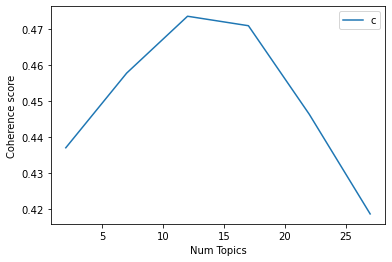

In [149]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [150]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.437
index: 1 | Num Topics = 7  has Coherence Value of 0.4577
index: 2 | Num Topics = 12  has Coherence Value of 0.4735
index: 3 | Num Topics = 17  has Coherence Value of 0.4709
index: 4 | Num Topics = 22  has Coherence Value of 0.4463
index: 5 | Num Topics = 27  has Coherence Value of 0.4187


In [168]:
# Select optimal number of topics
optimal_model_us_2020_score1N2N3 = model_list_us_2020_score1N2N3[2]

In [169]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2020_score1N2N3, corpus_us_2020_score1N2N3, id2word_us_2020_score1N2N3)

In [170]:
print("pyLDAVis for us topics for score=1,2,3 in 2020:")
vis_us_2020_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.048551  0.025543       1        1  14.264257
6     -0.026070  0.096231       2        1  13.616610
11    -0.005345  0.152606       3        1  13.205546
2     -0.092143 -0.135961       4        1  10.883306
8      0.031900 -0.013391       5        1   9.057619
5     -0.036056  0.000015       6        1   7.564617
1     -0.069949 -0.008473       7        1   7.406105
10    -0.069171 -0.027528       8        1   6.949042
4      0.248944 -0.025253       9        1   6.407837
9      0.003354  0.008693      10        1   4.940489
0      0.014547  0.007554      11        1   3.655744
7      0.048541 -0.080036      12        1   2.048829, topic_info=         Term       Freq      Total Category  logprob  loglift
67        tok  81.000000  81.000000  Default  30.0000  30.0000
66        tik  52.000000  52.000000  Default  29.0000  29.0000
409     sound  82.000000  82.000000  Default  28.0000  28.0000
369       let  51.000000  51.000000  Default  27.0000  27.0000
16        add  79.000000  79.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
197    filter   0.754113  23.867338  Topic12  -5.4809   0.4332
417  honestly   0.710924  10.938069  Topic12  -5.5399   1.1545
292      slow   0.710923  15.532154  Topic12  -5.5399   0.8038
55     button   0.710923  14.258417  Topic12  -5.5399   0.8894
1     feature   0.710922  27.969498  Topic12  -5.5399   0.2156

[842 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1362      6  0.798703     abel
106       1  0.143951  ability
106       4  0.575803  ability
106       5  0.143951  ability
106       8  0.143951  ability
...     ...       ...      ...
261       4  0.144465  youtube
261       7  0.433395  youtube
1510      9  0.807701    zebra
1175      6  0.600072     zoom
1469      8  0.599740     zynn

[1669 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 12, 3, 9, 6, 2, 11, 5, 10, 1, 8])

## By-rating of 2021 (Rating=1,2,3)

In [154]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_us_2021_score1N2N3 = clash_ios_us_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_us_2021_score1N2N3 = list(sent_to_words(review_us_2021_score1N2N3))
print(review_words_us_2021_score1N2N3[:1])

[['complete', 'garbage']]


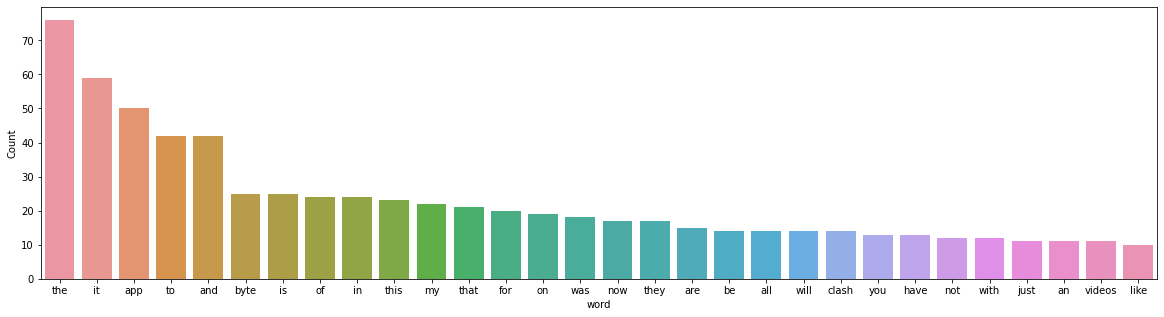

In [155]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2021_score1N2N3))

In [156]:
# Clean text
review_words_us_ready_2021_score1N2N3 = process_words(review_words_us_2021_score1N2N3)  # processed Text Data! - move to each section

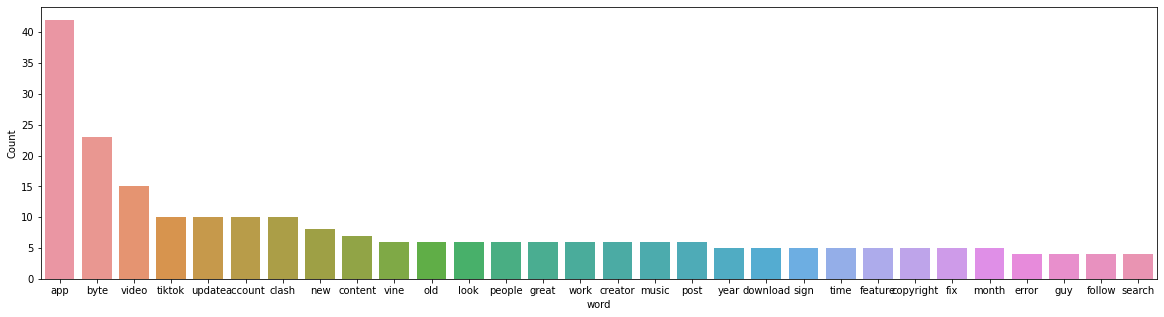

In [157]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2021_score1N2N3))


In [158]:
# Create Dictionary
id2word_us_2021_score1N2N3 = corpora.Dictionary(review_words_us_ready_2021_score1N2N3)

2021-10-16 02:45:47,974 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 02:45:47,979 [INFO] gensim.corpora.dictionary - built Dictionary(334 unique tokens: ['complete', 'garbage', 'byte', 'close', 'day']...) from 35 documents (total 664 corpus positions)
2021-10-16 02:45:47,981 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(334 unique tokens: ['complete', 'garbage', 'byte', 'close', 'day']...) from 35 documents (total 664 corpus positions)", 'datetime': '2021-10-16T02:45:47.981781', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [159]:
# Create Corpus: Term Document Frequency
corpus_us_2021_score1N2N3 = [id2word_us_2021_score1N2N3.doc2bow(text) for text in review_words_us_ready_2021_score1N2N3]

In [160]:
# Training LDA model
model_list_us_2021_score1N2N3, coherence_values_us_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2021_score1N2N3, corpus=corpus_us_2021_score1N2N3, 
                                                              texts=review_words_us_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-16 02:45:48,002 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 02:45:48,005 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 02:45:48,008 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:45:48,010 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 35 documents, updating model once every 35 documents, evaluating perplexity every 35 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 02:45:48,115 [INFO] gensim.models.ldamodel - -6.534 per-word bound, 92.7 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:45:48,116 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #35/35
2021-10-16 02:45:48,242 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"app" + 0.027*"byte" + 0.021*"video" + 0.014*"account" + 0.013*"clash" + 0.012*"tiktok" + 0.010*"new" + 0.

2021-10-16 02:45:49,028 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.026*"byte" + 0.021*"update" + 0.014*"content" + 0.011*"post" + 0.011*"creator" + 0.011*"music" + 0.011*"copyright" + 0.011*"care" + 0.011*"tiktok"
2021-10-16 02:45:49,029 [INFO] gensim.models.ldamodel - topic diff=0.008143, rho=0.301511
2021-10-16 02:45:49,114 [INFO] gensim.models.ldamodel - -5.834 per-word bound, 57.0 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:45:49,116 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #35/35
2021-10-16 02:45:49,154 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.024*"video" + 0.022*"byte" + 0.014*"account" + 0.014*"clash" + 0.013*"new" + 0.011*"tiktok" + 0.009*"look" + 0.009*"feature" + 0.009*"download"
2021-10-16 02:45:49,155 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.027*"byte" + 0.022*"update" + 0.014*"content" + 0.011*"post" + 0.011*"creator" + 0.011*"copyr

2021-10-16 02:45:49,953 [INFO] gensim.models.ldamodel - topic diff=0.000468, rho=0.218218
2021-10-16 02:45:49,987 [INFO] gensim.models.ldamodel - -5.833 per-word bound, 57.0 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:45:49,989 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #35/35
2021-10-16 02:45:50,010 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.024*"video" + 0.022*"byte" + 0.014*"account" + 0.014*"clash" + 0.013*"new" + 0.011*"tiktok" + 0.009*"look" + 0.009*"download" + 0.009*"feature"
2021-10-16 02:45:50,012 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.027*"byte" + 0.022*"update" + 0.014*"content" + 0.011*"post" + 0.011*"copyright" + 0.011*"music" + 0.011*"creator" + 0.011*"care" + 0.011*"tiktok"
2021-10-16 02:45:50,012 [INFO] gensim.models.ldamodel - topic diff=0.000391, rho=0.213201
2021-10-16 02:45:50,055 [INFO] gensim.models.ldamodel - -5.833 per-word bound, 57.0 perplexit

2021-10-16 02:45:50,807 [INFO] gensim.models.ldamodel - -5.833 per-word bound, 57.0 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:45:50,808 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #35/35
2021-10-16 02:45:50,830 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.024*"video" + 0.022*"byte" + 0.015*"account" + 0.014*"clash" + 0.013*"new" + 0.011*"tiktok" + 0.009*"look" + 0.009*"download" + 0.009*"feature"
2021-10-16 02:45:50,838 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.027*"byte" + 0.022*"update" + 0.014*"content" + 0.011*"post" + 0.011*"copyright" + 0.011*"music" + 0.011*"creator" + 0.011*"care" + 0.011*"tiktok"
2021-10-16 02:45:50,839 [INFO] gensim.models.ldamodel - topic diff=0.000171, rho=0.176777
2021-10-16 02:45:50,916 [INFO] gensim.models.ldamodel - -5.833 per-word bound, 57.0 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:45:50,9

2021-10-16 02:45:51,653 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #35/35
2021-10-16 02:45:51,680 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.024*"video" + 0.022*"byte" + 0.015*"account" + 0.014*"clash" + 0.013*"new" + 0.011*"tiktok" + 0.009*"look" + 0.009*"download" + 0.009*"feature"
2021-10-16 02:45:51,681 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.027*"byte" + 0.022*"update" + 0.014*"content" + 0.011*"post" + 0.011*"copyright" + 0.011*"music" + 0.011*"creator" + 0.011*"care" + 0.011*"tiktok"
2021-10-16 02:45:51,682 [INFO] gensim.models.ldamodel - topic diff=0.000159, rho=0.154303
2021-10-16 02:45:51,727 [INFO] gensim.models.ldamodel - -5.833 per-word bound, 57.0 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:45:51,728 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #35/35
2021-10-16 02:45:51,754 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0

2021-10-16 02:45:52,454 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:45:57,123 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:45:57,145 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 31 virtual documents
2021-10-16 02:45:57,436 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 02:45:57,438 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 02:45:57,443 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:45:57,446 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 35 documents, updating model once every 35 documents, evaluating perplexity every 35 documents, iterating 50x with a converg

2021-10-16 02:45:57,996 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.055*"app" + 0.030*"clash" + 0.024*"byte" + 0.024*"content" + 0.018*"name" + 0.018*"search" + 0.018*"play" + 0.013*"actually" + 0.012*"find" + 0.012*"dude"
2021-10-16 02:45:57,997 [INFO] gensim.models.ldamodel - topic diff=0.094576, rho=0.408248
2021-10-16 02:45:58,023 [INFO] gensim.models.ldamodel - -6.016 per-word bound, 64.7 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:45:58,025 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #35/35
2021-10-16 02:45:58,106 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.053*"app" + 0.032*"video" + 0.026*"look" + 0.016*"account" + 0.016*"new" + 0.016*"tiktok" + 0.016*"sign" + 0.012*"byte" + 0.011*"work" + 0.011*"creator"
2021-10-16 02:45:58,111 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.055*"app" + 0.030*"clash" + 0.024*"byte" + 0.024*"content" + 0.018*"name" + 0.018*"search" + 0.018*"play" + 0.013*"actu

2021-10-16 02:45:58,486 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.042*"app" + 0.032*"time" + 0.022*"account" + 0.022*"camera" + 0.022*"log" + 0.012*"update" + 0.012*"error" + 0.012*"new" + 0.012*"download" + 0.012*"work"
2021-10-16 02:45:58,487 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"old" + 0.032*"app" + 0.017*"tiktok" + 0.017*"byte" + 0.017*"account" + 0.017*"year" + 0.017*"video" + 0.017*"load" + 0.009*"people" + 0.009*"follow"
2021-10-16 02:45:58,488 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.054*"app" + 0.030*"clash" + 0.024*"byte" + 0.024*"content" + 0.018*"name" + 0.018*"play" + 0.018*"search" + 0.013*"actually" + 0.013*"find" + 0.013*"dude"
2021-10-16 02:45:58,490 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"app" + 0.032*"video" + 0.026*"look" + 0.016*"account" + 0.016*"new" + 0.016*"tiktok" + 0.016*"sign" + 0.011*"byte" + 0.011*"work" + 0.011*"vine"
2021-10-16 02:45:58,491 [INFO] gensim.models.ldamodel - topic diff=0.007805, rho=0

2021-10-16 02:45:58,938 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"follow" + 0.030*"add" + 0.030*"profile" + 0.030*"server" + 0.029*"error" + 0.029*"update" + 0.016*"guy" + 0.016*"storage" + 0.016*"waste" + 0.016*"thinking"
2021-10-16 02:45:58,943 [INFO] gensim.models.ldamodel - topic diff=0.001442, rho=0.242536
2021-10-16 02:45:58,967 [INFO] gensim.models.ldamodel - -6.005 per-word bound, 64.2 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:45:58,968 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #35/35
2021-10-16 02:45:59,043 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.051*"byte" + 0.034*"video" + 0.029*"app" + 0.023*"feature" + 0.017*"new" + 0.017*"issue" + 0.012*"tiktok" + 0.012*"delete" + 0.012*"back" + 0.012*"great"
2021-10-16 02:45:59,047 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"old" + 0.032*"app" + 0.017*"tiktok" + 0.017*"account" + 0.017*"year" + 0.017*"byte" + 0.017*"load" + 0.01

2021-10-16 02:45:59,408 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"old" + 0.032*"app" + 0.017*"tiktok" + 0.017*"account" + 0.017*"year" + 0.017*"load" + 0.017*"byte" + 0.017*"video" + 0.009*"error" + 0.009*"option"
2021-10-16 02:45:59,410 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.054*"app" + 0.030*"clash" + 0.024*"byte" + 0.024*"content" + 0.019*"play" + 0.019*"search" + 0.019*"name" + 0.013*"tiktok" + 0.013*"feed" + 0.013*"actually"
2021-10-16 02:45:59,411 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"app" + 0.032*"video" + 0.027*"look" + 0.016*"account" + 0.016*"new" + 0.016*"tiktok" + 0.016*"sign" + 0.011*"vine" + 0.011*"byte" + 0.011*"work"
2021-10-16 02:45:59,412 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.042*"app" + 0.032*"time" + 0.022*"account" + 0.022*"camera" + 0.022*"log" + 0.012*"update" + 0.012*"error" + 0.012*"soon" + 0.012*"work" + 0.012*"download"
2021-10-16 02:45:59,413 [INFO] gensim.models.ldamodel - topic diff=0.000267, rho

2021-10-16 02:45:59,933 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.058*"app" + 0.039*"byte" + 0.033*"update" + 0.026*"post" + 0.026*"copyright" + 0.026*"music" + 0.026*"creator" + 0.026*"care" + 0.020*"month" + 0.020*"content"
2021-10-16 02:45:59,936 [INFO] gensim.models.ldamodel - topic diff=0.000079, rho=0.188982
2021-10-16 02:45:59,955 [INFO] gensim.models.ldamodel - -6.005 per-word bound, 64.2 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:45:59,957 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #35/35
2021-10-16 02:45:59,972 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.054*"app" + 0.030*"clash" + 0.024*"byte" + 0.024*"content" + 0.019*"play" + 0.019*"search" + 0.019*"name" + 0.013*"tiktok" + 0.013*"feed" + 0.013*"find"
2021-10-16 02:45:59,973 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"old" + 0.032*"app" + 0.017*"tiktok" + 0.017*"account" + 0.017*"year" + 0.017*"load" + 0.017*"byte" + 0.017*"

2021-10-16 02:46:00,416 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"old" + 0.032*"app" + 0.017*"tiktok" + 0.017*"account" + 0.017*"year" + 0.017*"load" + 0.017*"byte" + 0.017*"video" + 0.009*"error" + 0.009*"option"
2021-10-16 02:46:00,420 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"follow" + 0.030*"add" + 0.030*"profile" + 0.030*"server" + 0.029*"error" + 0.029*"update" + 0.016*"guy" + 0.016*"storage" + 0.016*"waste" + 0.016*"thinking"
2021-10-16 02:46:00,422 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.054*"app" + 0.030*"clash" + 0.024*"byte" + 0.024*"content" + 0.019*"play" + 0.019*"search" + 0.019*"name" + 0.013*"tiktok" + 0.013*"feed" + 0.013*"find"
2021-10-16 02:46:00,424 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.051*"byte" + 0.034*"video" + 0.029*"app" + 0.023*"feature" + 0.017*"new" + 0.017*"issue" + 0.012*"tiktok" + 0.012*"account" + 0.012*"fix" + 0.012*"people"
2021-10-16 02:46:00,425 [INFO] gensim.models.ldamodel - topic diff=0.0000

2021-10-16 02:46:00,759 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"old" + 0.032*"app" + 0.017*"tiktok" + 0.017*"account" + 0.017*"year" + 0.017*"load" + 0.017*"byte" + 0.017*"video" + 0.009*"error" + 0.009*"option"
2021-10-16 02:46:00,761 [INFO] gensim.models.ldamodel - topic diff=0.000008, rho=0.160128
2021-10-16 02:46:00,788 [INFO] gensim.models.ldamodel - -6.005 per-word bound, 64.2 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:00,789 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #35/35
2021-10-16 02:46:00,816 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"follow" + 0.030*"add" + 0.030*"profile" + 0.030*"server" + 0.029*"error" + 0.029*"update" + 0.016*"guy" + 0.016*"waste" + 0.016*"storage" + 0.016*"thinking"
2021-10-16 02:46:00,818 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.051*"byte" + 0.034*"video" + 0.029*"app" + 0.023*"feature" + 0.017*"new" + 0.017*"issue" + 0.012*"tiktok" + 0.0

2021-10-16 02:46:01,158 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.054*"app" + 0.030*"clash" + 0.024*"byte" + 0.024*"content" + 0.019*"play" + 0.019*"search" + 0.019*"name" + 0.013*"tiktok" + 0.013*"feed" + 0.013*"find"
2021-10-16 02:46:01,160 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.058*"app" + 0.039*"byte" + 0.033*"update" + 0.026*"post" + 0.026*"music" + 0.026*"copyright" + 0.026*"creator" + 0.026*"care" + 0.020*"month" + 0.020*"content"
2021-10-16 02:46:01,164 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"app" + 0.032*"video" + 0.027*"look" + 0.016*"account" + 0.016*"new" + 0.016*"sign" + 0.016*"tiktok" + 0.011*"vine" + 0.011*"platform" + 0.011*"really"
2021-10-16 02:46:01,165 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.051*"byte" + 0.034*"video" + 0.029*"app" + 0.023*"feature" + 0.017*"new" + 0.017*"issue" + 0.012*"account" + 0.012*"tiktok" + 0.012*"fix" + 0.012*"people"
2021-10-16 02:46:01,167 [INFO] gensim.models.ldamodel - topic diff=0.000

2021-10-16 02:46:01,555 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.042*"app" + 0.032*"time" + 0.022*"account" + 0.022*"log" + 0.022*"camera" + 0.012*"update" + 0.012*"error" + 0.012*"soon" + 0.012*"work" + 0.012*"release"
2021-10-16 02:46:01,556 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.141421
2021-10-16 02:46:01,581 [INFO] gensim.models.ldamodel - -6.005 per-word bound, 64.2 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:01,583 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #35/35
2021-10-16 02:46:01,603 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"old" + 0.032*"app" + 0.017*"tiktok" + 0.017*"account" + 0.017*"year" + 0.017*"load" + 0.017*"byte" + 0.017*"video" + 0.009*"error" + 0.009*"option"
2021-10-16 02:46:01,604 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.058*"app" + 0.039*"byte" + 0.033*"update" + 0.026*"post" + 0.026*"music" + 0.026*"copyright" + 0.026*"creator" + 0.026

2021-10-16 02:46:07,043 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.071*"app" + 0.022*"time" + 0.022*"sign" + 0.021*"camera" + 0.021*"waste" + 0.021*"storage" + 0.013*"play" + 0.013*"new" + 0.012*"account" + 0.012*"feed"
2021-10-16 02:46:07,048 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.048*"video" + 0.048*"app" + 0.029*"look" + 0.020*"creator" + 0.020*"platform" + 0.019*"ppl" + 0.019*"new" + 0.010*"account" + 0.010*"music" + 0.010*"delete"
2021-10-16 02:46:07,054 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.063*"app" + 0.032*"play" + 0.032*"search" + 0.022*"clash" + 0.022*"content" + 0.022*"find" + 0.022*"luck" + 0.022*"result" + 0.022*"main" + 0.022*"name"
2021-10-16 02:46:07,058 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.003*"app" + 0.003*"keyboard" + 0.003*"bro" + 0.003*"tiktok" + 0.003*"byte" + 0.003*"account" + 0.003*"garbage" + 0.003*"error" + 0.003*"copy" + 0.003*"vine"
2021-10-16 02:46:07,060 [INFO] gensim.models.ldamodel - topic diff=0.176129

2021-10-16 02:46:07,469 [INFO] gensim.models.ldamodel - topic diff=0.023543, rho=0.316228
2021-10-16 02:46:07,492 [INFO] gensim.models.ldamodel - -6.176 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:07,493 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #35/35
2021-10-16 02:46:07,509 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.032*"update" + 0.032*"time" + 0.032*"profile" + 0.032*"error" + 0.032*"server" + 0.032*"keyboard" + 0.003*"app" + 0.003*"copyright" + 0.003*"byte" + 0.003*"creator"
2021-10-16 02:46:07,511 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.069*"app" + 0.024*"time" + 0.024*"sign" + 0.024*"camera" + 0.024*"waste" + 0.024*"storage" + 0.012*"play" + 0.012*"new" + 0.012*"account" + 0.012*"feed"
2021-10-16 02:46:07,512 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.059*"app" + 0.055*"byte" + 0.027*"update" + 0.020*"tiktok" + 0.020*"content" + 0.016*"great" + 0.016*"people

2021-10-16 02:46:07,936 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.064*"app" + 0.032*"play" + 0.032*"search" + 0.022*"clash" + 0.022*"content" + 0.022*"find" + 0.022*"luck" + 0.022*"result" + 0.022*"main" + 0.022*"name"
2021-10-16 02:46:07,937 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.059*"app" + 0.055*"byte" + 0.027*"update" + 0.020*"tiktok" + 0.020*"content" + 0.016*"great" + 0.016*"people" + 0.016*"post" + 0.016*"care" + 0.016*"music"
2021-10-16 02:46:07,939 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"error" + 0.035*"birth" + 0.035*"date" + 0.003*"video" + 0.003*"app" + 0.003*"new" + 0.003*"issue" + 0.003*"download" + 0.003*"leave" + 0.003*"fix"
2021-10-16 02:46:07,940 [INFO] gensim.models.ldamodel - topic diff=0.002834, rho=0.250000
2021-10-16 02:46:07,965 [INFO] gensim.models.ldamodel - -6.175 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:07,966 [INFO] gensim.models.ldamodel - PRO

2021-10-16 02:46:08,226 [INFO] gensim.models.ldamodel - topic diff=0.000654, rho=0.218218
2021-10-16 02:46:08,243 [INFO] gensim.models.ldamodel - -6.175 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:08,245 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #35/35
2021-10-16 02:46:08,256 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.033*"account" + 0.033*"log" + 0.033*"give" + 0.033*"option" + 0.033*"exist" + 0.003*"desolate" + 0.003*"ban" + 0.003*"feed" + 0.003*"hope" + 0.003*"app"
2021-10-16 02:46:08,258 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"video" + 0.027*"byte" + 0.027*"issue" + 0.027*"app" + 0.018*"work" + 0.018*"year" + 0.018*"download" + 0.018*"still" + 0.018*"page" + 0.018*"account"
2021-10-16 02:46:08,261 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regular

2021-10-16 02:46:08,605 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"video" + 0.027*"byte" + 0.027*"issue" + 0.027*"app" + 0.018*"work" + 0.018*"year" + 0.018*"download" + 0.018*"still" + 0.018*"page" + 0.018*"account"
2021-10-16 02:46:08,606 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.069*"app" + 0.024*"time" + 0.024*"sign" + 0.024*"camera" + 0.024*"storage" + 0.024*"waste" + 0.012*"play" + 0.012*"new" + 0.012*"account" + 0.012*"feed"
2021-10-16 02:46:08,608 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.049*"video" + 0.049*"app" + 0.030*"look" + 0.020*"creator" + 0.020*"platform" + 0.020*"new" + 0.020*"ppl" + 0.010*"account" + 0.010*"music" + 0.010*"soon"
2021-10-16 02:46:08,609 [INFO] gensim.models.ldamodel - topic diff=0.000145, rho=0.192450
2021-10-16 02:46:08,638 [INFO] gensim.models.ldamodel - -6.175 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:08,639 [INFO] gensim.models.ldamodel - 

2021-10-16 02:46:08,960 [INFO] gensim.models.ldamodel - topic diff=0.000047, rho=0.176777
2021-10-16 02:46:08,985 [INFO] gensim.models.ldamodel - -6.175 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:08,987 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #35/35
2021-10-16 02:46:09,005 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.049*"video" + 0.049*"app" + 0.030*"look" + 0.020*"creator" + 0.020*"platform" + 0.020*"new" + 0.020*"ppl" + 0.010*"account" + 0.010*"music" + 0.010*"soon"
2021-10-16 02:46:09,006 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.032*"update" + 0.032*"profile" + 0.032*"error" + 0.032*"server" + 0.032*"time" + 0.032*"keyboard" + 0.002*"app" + 0.002*"copyright" + 0.002*"byte" + 0.002*"creator"
2021-10-16 02:46:09,008 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"clash" + 0.036*"vine" + 0.036*"tiktok" + 0.024*"app" + 0.024*"byte" + 0.024*"look" + 0.024*"dude" + 0

2021-10-16 02:46:09,461 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"tiktok" + 0.036*"vine" + 0.036*"clash" + 0.024*"app" + 0.024*"look" + 0.024*"byte" + 0.024*"dude" + 0.024*"whole" + 0.012*"video" + 0.012*"new"
2021-10-16 02:46:09,462 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.049*"video" + 0.049*"app" + 0.030*"look" + 0.020*"creator" + 0.020*"platform" + 0.020*"new" + 0.020*"ppl" + 0.010*"account" + 0.010*"soon" + 0.010*"music"
2021-10-16 02:46:09,463 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"video" + 0.027*"byte" + 0.027*"issue" + 0.027*"app" + 0.018*"year" + 0.018*"work" + 0.018*"account" + 0.018*"download" + 0.018*"still" + 0.018*"page"
2021-10-16 02:46:09,463 [INFO] gensim.models.ldamodel - topic diff=0.000014, rho=0.162221
2021-10-16 02:46:09,490 [INFO] gensim.models.ldamodel - -6.175 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:09,491 [INFO] gensim.models.ldamodel - PROGR

2021-10-16 02:46:09,916 [INFO] gensim.models.ldamodel - topic diff=0.000006, rho=0.152499
2021-10-16 02:46:09,941 [INFO] gensim.models.ldamodel - -6.175 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:09,943 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #35/35
2021-10-16 02:46:09,957 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:09,958 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"tiktok" + 0.036*"vine" + 0.036*"clash" + 0.024*"app" + 0.024*"look" + 0.024*"whole" + 0.024*"dude" + 0.024*"byte" + 0.012*"video" + 0.012*"new"
2021-10-16 02:46:09,960 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"error" + 0.035*"birth" + 0.035*"date" + 0.003*"video" + 0.003*"app" + 0.003*"new" + 0.003*"i

2021-10-16 02:46:10,342 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"app" + 0.037*"account" + 0.037*"sign" + 0.025*"load" + 0.013*"profile" + 0.013*"tiktok" + 0.013*"error" + 0.013*"follow" + 0.013*"fix" + 0.013*"old"
2021-10-16 02:46:10,350 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:10,353 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"error" + 0.035*"birth" + 0.035*"date" + 0.003*"video" + 0.003*"app" + 0.003*"new" + 0.003*"issue" + 0.003*"download" + 0.003*"leave" + 0.003*"fix"
2021-10-16 02:46:10,356 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.142857
2021-10-16 02:46:10,399 [INFO] gensim.models.ldamodel - -6.175 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:10,400 [INFO] gen

2021-10-16 02:46:17,344 [INFO] gensim.models.ldamodel - -6.610 per-word bound, 97.6 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:17,345 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #35/35
2021-10-16 02:46:17,362 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.069*"app" + 0.046*"account" + 0.045*"sign" + 0.024*"people" + 0.023*"soon" + 0.023*"first" + 0.023*"forever" + 0.023*"hope" + 0.023*"front" + 0.023*"flash"
2021-10-16 02:46:17,365 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.063*"app" + 0.041*"clash" + 0.030*"name" + 0.029*"play" + 0.028*"search" + 0.022*"content" + 0.021*"dude" + 0.020*"ruin" + 0.020*"actually" + 0.020*"main"
2021-10-16 02:46:17,366 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"copy" + 0.049*"tiktok" + 0.003*"instead" + 0.003*"vine" + 0.003*"complete" + 0.003*"garbage" + 0.003*"account" + 0.003*"clash" + 0.003*"work" + 0.003*"birth"
2021-10-16 02:46:17,367 [INFO] gensim.model

2021-10-16 02:46:17,853 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.050*"video" + 0.033*"look" + 0.022*"platform" + 0.022*"ppl" + 0.018*"new" + 0.017*"byte" + 0.013*"app" + 0.012*"tiktok" + 0.012*"year" + 0.012*"acquire"
2021-10-16 02:46:17,854 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.076*"app" + 0.031*"update" + 0.031*"account" + 0.031*"time" + 0.031*"intro" + 0.031*"log" + 0.016*"byte" + 0.016*"video" + 0.016*"old" + 0.016*"work"
2021-10-16 02:46:17,855 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.050*"old" + 0.026*"download" + 0.026*"year" + 0.026*"child" + 0.026*"different" + 0.026*"chat" + 0.026*"culture" + 0.026*"sucksssssssssss" + 0.026*"people" + 0.026*"place"
2021-10-16 02:46:17,856 [INFO] gensim.models.ldamodel - topic diff=0.060423, rho=0.333333
2021-10-16 02:46:17,885 [INFO] gensim.models.ldamodel - -6.236 per-word bound, 75.4 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:17,886 [INFO] gensim.model

2021-10-16 02:46:18,254 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.049*"camera" + 0.049*"account" + 0.025*"feed" + 0.025*"play" + 0.025*"earth" + 0.025*"sound" + 0.025*"record" + 0.025*"overlap" + 0.025*"release" + 0.025*"roll"
2021-10-16 02:46:18,255 [INFO] gensim.models.ldamodel - topic diff=0.013974, rho=0.267261
2021-10-16 02:46:18,306 [INFO] gensim.models.ldamodel - -6.216 per-word bound, 74.3 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:18,308 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #35/35
2021-10-16 02:46:18,338 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.080*"byte" + 0.040*"feature" + 0.030*"app" + 0.030*"back" + 0.020*"second" + 0.020*"delete" + 0.020*"tiktok" + 0.020*"content" + 0.020*"loop" + 0.011*"update"
2021-10-16 02:46:18,339 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.003*"app" + 0.003*"search" + 0.003*"play" + 0.003*"always" + 0.003*"unusable" + 0.003*"effectively" + 0.

2021-10-16 02:46:18,702 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #35/35
2021-10-16 02:46:18,745 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.070*"app" + 0.047*"account" + 0.047*"sign" + 0.024*"people" + 0.024*"soon" + 0.024*"gmail" + 0.024*"email" + 0.024*"first" + 0.024*"forever" + 0.024*"apple"
2021-10-16 02:46:18,762 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"copy" + 0.049*"tiktok" + 0.003*"permission" + 0.003*"period" + 0.003*"situation" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly"
2021-10-16 02:46:18,792 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.058*"byte" + 0.030*"clash" + 0.030*"tiktok" + 0.030*"server" + 0.030*"error" + 0.030*"profile" + 0.030*"update" + 0.030*"time" + 0.030*"upgrade" + 0.030*"design"
2021-10-16 02:46:18,794 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.003*"app" + 0.003*"search" + 0.003*"play" + 0.003*"always" + 0.003*"unusable" + 0.003*"effectively" + 0.

2021-10-16 02:46:19,111 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.067*"follow" + 0.067*"add" + 0.035*"great" + 0.035*"app" + 0.035*"follower" + 0.035*"thinking" + 0.035*"update" + 0.035*"profile" + 0.035*"guy" + 0.002*"situation"
2021-10-16 02:46:19,114 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.049*"camera" + 0.049*"account" + 0.025*"ui" + 0.025*"release" + 0.025*"overlap" + 0.025*"play" + 0.025*"sound" + 0.025*"earth" + 0.025*"roll" + 0.025*"import"
2021-10-16 02:46:19,117 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.092*"app" + 0.042*"creator" + 0.039*"byte" + 0.035*"music" + 0.035*"update" + 0.028*"copyright" + 0.028*"post" + 0.028*"care" + 0.021*"month" + 0.021*"work"
2021-10-16 02:46:19,118 [INFO] gensim.models.ldamodel - topic diff=0.000882, rho=0.200000
2021-10-16 02:46:19,144 [INFO] gensim.models.ldamodel - -6.213 per-word bound, 74.2 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:19,155 [INFO] gensim

2021-10-16 02:46:19,468 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"copy" + 0.049*"tiktok" + 0.003*"permission" + 0.003*"period" + 0.003*"situation" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly"
2021-10-16 02:46:19,470 [INFO] gensim.models.ldamodel - topic diff=0.000327, rho=0.182574
2021-10-16 02:46:19,500 [INFO] gensim.models.ldamodel - -6.213 per-word bound, 74.2 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:19,501 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #35/35
2021-10-16 02:46:19,521 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.067*"follow" + 0.067*"add" + 0.035*"great" + 0.035*"app" + 0.035*"follower" + 0.035*"thinking" + 0.035*"update" + 0.035*"profile" + 0.035*"guy" + 0.002*"situation"
2021-10-16 02:46:19,524 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.080*"byte" + 0.040*"feature" + 0.030*"app" + 0.030*"back" + 0.020*"delete" + 0.020*

2021-10-16 02:46:19,888 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #35/35
2021-10-16 02:46:19,926 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.049*"complete" + 0.049*"garbage" + 0.003*"outta" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period"
2021-10-16 02:46:19,927 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.095*"app" + 0.042*"creator" + 0.039*"byte" + 0.035*"music" + 0.035*"update" + 0.028*"copyright" + 0.028*"post" + 0.028*"care" + 0.021*"month" + 0.021*"claim"
2021-10-16 02:46:19,928 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.070*"app" + 0.047*"account" + 0.047*"sign" + 0.024*"people" + 0.024*"gmail" + 0.024*"forever" + 0.024*"first" + 0.024*"email" + 0.024*"connect" + 0.024*"apple"
2021-10-16 02:46:19,930 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.067*"follow" + 0.067*"add" + 0.035*"great" + 0.035*"app" + 0.035*"follower" + 0.035*"thinking" + 0.035

2021-10-16 02:46:20,267 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.063*"app" + 0.042*"clash" + 0.032*"name" + 0.032*"play" + 0.032*"search" + 0.021*"content" + 0.021*"dude" + 0.021*"ruin" + 0.021*"actually" + 0.021*"main"
2021-10-16 02:46:20,268 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.053*"app" + 0.053*"video" + 0.023*"byte" + 0.023*"new" + 0.023*"fix" + 0.023*"issue" + 0.015*"vine" + 0.015*"tiktok" + 0.015*"whole" + 0.015*"look"
2021-10-16 02:46:20,269 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.096*"app" + 0.042*"creator" + 0.038*"byte" + 0.035*"update" + 0.035*"music" + 0.028*"copyright" + 0.028*"post" + 0.028*"care" + 0.021*"month" + 0.021*"claim"
2021-10-16 02:46:20,270 [INFO] gensim.models.ldamodel - topic diff=0.000139, rho=0.156174
2021-10-16 02:46:20,334 [INFO] gensim.models.ldamodel - -6.212 per-word bound, 74.1 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:20,338 [INFO] gensim.models.ldamodel - PR

2021-10-16 02:46:20,650 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.070*"app" + 0.047*"account" + 0.047*"sign" + 0.024*"people" + 0.024*"email" + 0.024*"apple" + 0.024*"connect" + 0.024*"first" + 0.024*"guess" + 0.024*"gmail"
2021-10-16 02:46:20,652 [INFO] gensim.models.ldamodel - topic diff=0.000141, rho=0.147442
2021-10-16 02:46:20,693 [INFO] gensim.models.ldamodel - -6.211 per-word bound, 74.1 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:20,696 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #35/35
2021-10-16 02:46:20,728 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.049*"camera" + 0.049*"account" + 0.025*"ui" + 0.025*"release" + 0.025*"overlap" + 0.025*"play" + 0.025*"sound" + 0.025*"earth" + 0.025*"roll" + 0.025*"import"
2021-10-16 02:46:20,730 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.055*"video" + 0.033*"look" + 0.022*"platform" + 0.022*"ppl" + 0.022*"new" + 0.017*"byte" + 0.011*"tiktok" + 

2021-10-16 02:46:21,071 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:46:25,974 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 02:46:26,018 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 33 virtual documents
2021-10-16 02:46:28,768 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 02:46:28,773 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 02:46:28,781 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 02:46:28,791 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 35 documents, updating model once every 35 documents, evaluating perplexity every 35 documents, iterating 50x with a conv

2021-10-16 02:46:29,145 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.043*"tiktok" + 0.043*"app" + 0.022*"acquire" + 0.022*"beta" + 0.022*"feel" + 0.022*"formerly" + 0.022*"competition" + 0.022*"short" + 0.022*"space" + 0.022*"year"
2021-10-16 02:46:29,146 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.073*"app" + 0.036*"video" + 0.024*"search" + 0.019*"account" + 0.018*"new" + 0.018*"look" + 0.018*"play" + 0.017*"clash" + 0.013*"creator" + 0.013*"byte"
2021-10-16 02:46:29,147 [INFO] gensim.models.ldamodel - topic diff=0.118378, rho=0.408248
2021-10-16 02:46:29,186 [INFO] gensim.models.ldamodel - -6.423 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:29,188 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #35/35
2021-10-16 02:46:29,223 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.067*"clash" + 0.061*"dude" + 0.039*"ruin" + 0.037*"name" + 0.031*"phone" + 0.031*"talentless" + 0.031*"sick"

2021-10-16 02:46:29,502 [INFO] gensim.models.ldamodel - -6.379 per-word bound, 83.2 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:29,503 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #35/35
2021-10-16 02:46:29,521 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:29,525 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.072*"video" + 0.036*"app" + 0.036*"issue" + 0.024*"work" + 0.024*"byte" + 0.024*"download" + 0.024*"page" + 0.024*"still" + 0.024*"new" + 0.024*"account"
2021-10-16 02:46:29,528 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.052*"error" + 0.052*"server" + 0.052*"update" + 0.052*"time" + 0.052*"profile" + 0.002*"royalty" + 0.002*"situation" + 0.002*"spotlight" + 0.002*"permission" + 0.002*"sinking"
2021-

2021-10-16 02:46:29,874 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.052*"error" + 0.052*"server" + 0.052*"time" + 0.052*"update" + 0.052*"profile" + 0.002*"royalty" + 0.002*"situation" + 0.002*"sinking" + 0.002*"spotlight" + 0.002*"permission"
2021-10-16 02:46:29,875 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.067*"feature" + 0.051*"byte" + 0.034*"back" + 0.034*"second" + 0.034*"tiktok" + 0.034*"old" + 0.017*"awful" + 0.017*"point" + 0.017*"vine" + 0.017*"sure"
2021-10-16 02:46:29,877 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.072*"app" + 0.036*"video" + 0.024*"search" + 0.018*"account" + 0.018*"new" + 0.018*"look" + 0.018*"play" + 0.018*"clash" + 0.012*"creator" + 0.012*"byte"
2021-10-16 02:46:29,878 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:29,879 [INFO

2021-10-16 02:46:30,276 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.052*"exist" + 0.052*"account" + 0.052*"log" + 0.052*"option" + 0.052*"give" + 0.002*"ship" + 0.002*"royalty" + 0.002*"regularly" + 0.002*"sinking" + 0.002*"outta"
2021-10-16 02:46:30,277 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.066*"clash" + 0.066*"dude" + 0.034*"ruin" + 0.034*"name" + 0.034*"talentless" + 0.034*"platform" + 0.034*"wake" + 0.034*"tiktok" + 0.034*"sick" + 0.034*"hack"
2021-10-16 02:46:30,278 [INFO] gensim.models.ldamodel - topic diff=0.000870, rho=0.213201
2021-10-16 02:46:30,307 [INFO] gensim.models.ldamodel - -6.377 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:30,308 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #35/35
2021-10-16 02:46:30,328 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.042*"camera" + 0.022*"app" + 0.022*"account" + 0.022*"new" + 0.022*"error" + 0.022*"soon" + 0.022*"sig

2021-10-16 02:46:30,649 [INFO] gensim.models.ldamodel - -6.377 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:30,650 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #35/35
2021-10-16 02:46:30,668 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.003*"update" + 0.003*"imagine" + 0.003*"old" + 0.003*"option" + 0.003*"clash" + 0.003*"byte" + 0.003*"wake" + 0.003*"video" + 0.003*"app" + 0.003*"absolutely"
2021-10-16 02:46:30,673 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:30,675 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotl

2021-10-16 02:46:31,115 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.043*"app" + 0.043*"tiktok" + 0.022*"formerly" + 0.022*"feel" + 0.022*"acquire" + 0.022*"beta" + 0.022*"competition" + 0.022*"consolidate" + 0.022*"decade" + 0.022*"effort"
2021-10-16 02:46:31,116 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:31,119 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.072*"app" + 0.036*"video" + 0.024*"search" + 0.018*"account" + 0.018*"new" + 0.018*"look" + 0.018*"play" + 0.018*"clash" + 0.012*"creator" + 0.012*"byte"
2021-10-16 02:46:31,121 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.070*"app" + 0.024*"time" + 0.024*"byte" + 0.024*"vine" + 0.024*"tiktok" + 0.024*"old" + 0.024*"load" + 0.012*"look" + 0.012*"video" + 0.012*"new"
2021-10-16 02:46:31,122 [INFO] gensim.mo

2021-10-16 02:46:31,503 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:31,510 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.072*"video" + 0.036*"app" + 0.036*"issue" + 0.024*"byte" + 0.024*"download" + 0.024*"work" + 0.024*"new" + 0.024*"page" + 0.024*"still" + 0.024*"account"
2021-10-16 02:46:31,522 [INFO] gensim.models.ldamodel - topic diff=0.000025, rho=0.162221
2021-10-16 02:46:31,553 [INFO] gensim.models.ldamodel - -6.377 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:31,554 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #35/35
2021-10-16 02:46:31,572 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"r

2021-10-16 02:46:31,870 [INFO] gensim.models.ldamodel - topic diff=0.000010, rho=0.152499
2021-10-16 02:46:31,898 [INFO] gensim.models.ldamodel - -6.377 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:31,899 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #35/35
2021-10-16 02:46:31,918 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.052*"profile" + 0.052*"server" + 0.052*"time" + 0.052*"error" + 0.052*"update" + 0.002*"royalty" + 0.002*"situation" + 0.002*"permission" + 0.002*"spotlight" + 0.002*"sinking"
2021-10-16 02:46:31,923 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.042*"camera" + 0.022*"app" + 0.022*"impossible" + 0.022*"new" + 0.022*"account" + 0.022*"soon" + 0.022*"anyways" + 0.022*"automatically" + 0.022*"introduce" + 0.022*"recover"
2021-10-16 02:46:31,925 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.003*"update" + 0.003*"imagine" + 0.003*"old" + 0.003*"option" + 0.003*"cl

2021-10-16 02:46:32,316 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.072*"video" + 0.036*"app" + 0.036*"issue" + 0.024*"byte" + 0.024*"still" + 0.024*"page" + 0.024*"new" + 0.024*"download" + 0.024*"leave" + 0.024*"account"
2021-10-16 02:46:32,318 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:32,319 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.042*"camera" + 0.022*"app" + 0.022*"soon" + 0.022*"new" + 0.022*"impossible" + 0.022*"account" + 0.022*"terrible" + 0.022*"introduce" + 0.022*"update" + 0.022*"recover"
2021-10-16 02:46:32,321 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.052*"profile" + 0.052*"server" + 0.052*"time" + 0.052*"error" + 0.052*"update" + 0.002*"royalty" + 0.002*"situation" + 0.002*"permission" + 0.002*"spotlight" + 0.002*"sinking"
2021-10-16 02:

2021-10-16 02:46:39,812 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.059*"app" + 0.040*"video" + 0.025*"byte" + 0.025*"look" + 0.023*"new" + 0.021*"creator" + 0.018*"music" + 0.016*"vine" + 0.015*"tiktok" + 0.013*"work"
2021-10-16 02:46:39,815 [INFO] gensim.models.ldamodel - topic diff=0.340062, rho=0.577350
2021-10-16 02:46:39,843 [INFO] gensim.models.ldamodel - -6.985 per-word bound, 126.7 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:39,844 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #35/35
2021-10-16 02:46:39,861 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.045*"app" + 0.030*"sign" + 0.030*"account" + 0.030*"tiktok" + 0.015*"point" + 0.015*"hope" + 0.015*"apple" + 0.015*"look" + 0.015*"post" + 0.015*"save"
2021-10-16 02:46:39,862 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.066*"feature" + 0.051*"byte" + 0.033*"back" + 0.033*"update" + 0.033*"second" + 0.033*"error" + 0.024*"app" + 0.018*"new

2021-10-16 02:46:40,167 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #35/35
2021-10-16 02:46:40,221 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:40,224 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.060*"account" + 0.055*"log" + 0.055*"exist" + 0.055*"give" + 0.055*"option" + 0.009*"video" + 0.007*"download" + 0.005*"issue" + 0.005*"page" + 0.005*"math"
2021-10-16 02:46:40,228 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.063*"byte" + 0.063*"become" + 0.063*"tiktok" + 0.063*"instead" + 0.002*"ridiculous" + 0.002*"royalty" + 0.002*"regularly" + 0.002*"sinking" + 0.002*"period" + 0.002*"situation"
2021-10-16 02:46:40,230 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.085*"video" + 0.043*"issue" + 0.034*"app" + 0.030*"still" + 0.029*"leave" + 0.029*"fix"

2021-10-16 02:46:40,536 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:40,537 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.083*"app" + 0.042*"delete" + 0.042*"byte" + 0.021*"flash" + 0.021*"soon" + 0.021*"hope" + 0.021*"world" + 0.021*"front" + 0.021*"poorly" + 0.021*"work"
2021-10-16 02:46:40,538 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.052*"clash" + 0.052*"dude" + 0.052*"follow" + 0.052*"add" + 0.026*"selling" + 0.026*"hack" + 0.026*"name" + 0.026*"phone" + 0.026*"talentless" + 0.026*"profile"
2021-10-16 02:46:40,539 [INFO] gensim.models.ldamodel - topic diff=0.018676, rho=0.267261
2021-10-16 02:46:40,574 [INFO] gensim.models.ldamodel - -6.384 per-word bound, 83.5 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:40,576 

2021-10-16 02:46:40,928 [INFO] gensim.models.ldamodel - topic diff=0.004535, rho=0.229416
2021-10-16 02:46:40,954 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:40,955 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #35/35
2021-10-16 02:46:40,971 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.045*"app" + 0.030*"account" + 0.030*"sign" + 0.030*"tiktok" + 0.015*"wanted" + 0.015*"month" + 0.015*"unfortunate" + 0.015*"trump" + 0.015*"curious" + 0.015*"trend"
2021-10-16 02:46:40,973 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.064*"byte" + 0.043*"content" + 0.043*"loop" + 0.022*"app" + 0.022*"clash" + 0.022*"bad" + 0.022*"long" + 0.022*"team" + 0.022*"clone" + 0.022*"basically"
2021-10-16 02:46:40,973 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0

2021-10-16 02:46:41,313 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.076*"app" + 0.043*"byte" + 0.040*"update" + 0.040*"post" + 0.040*"copyright" + 0.040*"music" + 0.032*"care" + 0.032*"creator" + 0.026*"month" + 0.024*"spotlight"
2021-10-16 02:46:41,314 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.047*"app" + 0.047*"video" + 0.037*"look" + 0.029*"new" + 0.019*"byte" + 0.019*"creator" + 0.019*"vine" + 0.019*"tiktok" + 0.019*"ppl" + 0.019*"platform"
2021-10-16 02:46:41,315 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.083*"app" + 0.042*"delete" + 0.042*"byte" + 0.021*"flash" + 0.021*"soon" + 0.021*"hope" + 0.021*"world" + 0.021*"front" + 0.021*"upgrade" + 0.021*"poorly"
2021-10-16 02:46:41,316 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:41,317 [INFO] gensim.models

2021-10-16 02:46:41,653 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.078*"bro" + 0.003*"update" + 0.003*"app" + 0.003*"byte" + 0.003*"care" + 0.003*"copyright" + 0.003*"creator" + 0.003*"spotlight" + 0.003*"month" + 0.003*"music"
2021-10-16 02:46:41,654 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.086*"video" + 0.044*"issue" + 0.035*"app" + 0.029*"still" + 0.029*"leave" + 0.029*"download" + 0.029*"account" + 0.029*"new" + 0.029*"fix" + 0.029*"page"
2021-10-16 02:46:41,655 [INFO] gensim.models.ldamodel - topic diff=0.000308, rho=0.182574
2021-10-16 02:46:41,687 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:41,688 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #35/35
2021-10-16 02:46:41,706 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.083*"app" + 0.042*"delete" + 0.042*"byte" + 0.021*"flash" + 0.021*"soon" + 0.021*"hope" + 0.021*"world" + 0.0

2021-10-16 02:46:42,008 [INFO] gensim.models.ldamodel - topic diff=0.000108, rho=0.169031
2021-10-16 02:46:42,046 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46:42,047 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #35/35
2021-10-16 02:46:42,066 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.003*"video" + 0.003*"issue" + 0.003*"app" + 0.003*"still" + 0.003*"page" + 0.003*"account" + 0.003*"leave" + 0.003*"byte" + 0.003*"new" + 0.003*"download"
2021-10-16 02:46:42,067 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.103*"app" + 0.069*"time" + 0.035*"sad" + 0.035*"really" + 0.035*"download" + 0.035*"work" + 0.035*"fun" + 0.035*"cool" + 0.035*"couple" + 0.035*"let"
2021-10-16 02:46:42,069 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly

2021-10-16 02:46:42,385 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:42,386 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.072*"feature" + 0.054*"byte" + 0.036*"second" + 0.036*"back" + 0.036*"update" + 0.036*"error" + 0.018*"app" + 0.018*"new" + 0.018*"anymore" + 0.018*"review"
2021-10-16 02:46:42,388 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:42,389 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.060*"app" + 0.040*"load" + 0.021*"edit" + 0.021*"trump" + 0.021*"however" + 0.021*"sign" + 0.021*"ipad" + 0.021*"fake" + 0.021*"mix" + 0.021*"fast"
2021-10-16 02:46:42,391 [IN

2021-10-16 02:46:42,724 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.003*"video" + 0.003*"issue" + 0.003*"app" + 0.003*"still" + 0.003*"page" + 0.003*"account" + 0.003*"leave" + 0.003*"byte" + 0.003*"new" + 0.003*"download"
2021-10-16 02:46:42,725 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.045*"app" + 0.030*"tiktok" + 0.030*"account" + 0.030*"sign" + 0.015*"wanted" + 0.015*"curious" + 0.015*"unfortunate" + 0.015*"debacle" + 0.015*"video" + 0.015*"really"
2021-10-16 02:46:42,730 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:42,731 [INFO] gensim.models.ldamodel - topic diff=0.000014, rho=0.147442
2021-10-16 02:46:42,757 [INFO] gensim.models.ldamodel - -6.382 per-word bound, 83.4 perplexity estimate based on a held-out corpus of 35 documents with 664 words
2021-10-16 02:46

2021-10-16 02:46:43,050 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.003*"outta" + 0.003*"neglect" + 0.003*"sinking" + 0.003*"ship" + 0.003*"royalty" + 0.003*"ridiculous" + 0.003*"regularly" + 0.003*"permission" + 0.003*"period" + 0.003*"spotlight"
2021-10-16 02:46:43,051 [INFO] gensim.models.ldamodel - topic diff=0.000006, rho=0.140028
2021-10-16 02:46:43,055 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=334, num_topics=27, decay=0.5, chunksize=1000) in 3.49s', 'datetime': '2021-10-16T02:46:43.055672', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 02:46:43,067 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 02:46:47,127 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved fro

In [161]:
%store model_list_us_2021_score1N2N3
%store coherence_values_us_2021_score1N2N3

Stored 'model_list_us_2021_score1N2N3' (list)
Stored 'coherence_values_us_2021_score1N2N3' (list)


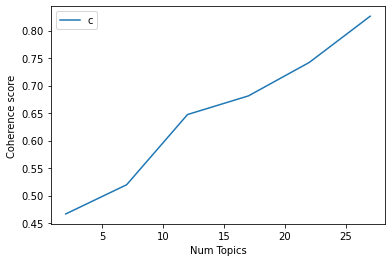

In [162]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [163]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.4665
index: 1 | Num Topics = 7  has Coherence Value of 0.5196
index: 2 | Num Topics = 12  has Coherence Value of 0.6473
index: 3 | Num Topics = 17  has Coherence Value of 0.6812
index: 4 | Num Topics = 22  has Coherence Value of 0.7421
index: 5 | Num Topics = 27  has Coherence Value of 0.8261


In [182]:
# Select optimal number of topics
optimal_model_us_2021_score1N2N3 = model_list_us_2021_score1N2N3[3]

In [183]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2021_score1N2N3, corpus_us_2021_score1N2N3, id2word_us_2021_score1N2N3)

In [184]:
print("pyLDAVis for us topics for score=1,2,3 in 2021:")
vis_us_2021_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.244163  0.051539       1        1  18.975752
2     -0.107586 -0.013383       2        1  16.858178
8     -0.010409  0.188275       3        1  11.949342
5     -0.021423  0.038409       4        1  11.567496
9      0.176857  0.118669       5        1  10.925515
4     -0.007352 -0.082468       6        1   7.246984
10    -0.051216 -0.038153       7        1   6.915024
6     -0.024972 -0.079174       8        1   3.490195
15     0.072010 -0.052108       9        1   3.279924
14     0.059512 -0.112397      10        1   3.113978
0     -0.002844  0.018120      11        1   2.191249
12     0.002769 -0.003327      12        1   1.779605
1      0.038001 -0.003319      13        1   0.461834
13     0.036705 -0.012666      14        1   0.461834
3      0.028037 -0.006006      15        1   0.261031
7      0.028037 -0.006006      16        1   0.261031
11     0.028037 -0.006006      17        1   0.261031, topic_info=        Term       Freq      Total Category  logprob  loglift
21       app  33.000000  33.000000  Default  30.0000  30.0000
2       byte  18.000000  18.000000  Default  29.0000  29.0000
14    tiktok   7.000000   7.000000  Default  28.0000  28.0000
30    update   7.000000   7.000000  Default  27.0000  27.0000
19   account   7.000000   7.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
273     call   0.005189   1.287126  Topic17  -5.8111   0.4347
193     like   0.005189   2.124683  Topic17  -5.8111  -0.0665
284     open   0.005189   1.287126  Topic17  -5.8111   0.4347
57     first   0.005189   1.818084  Topic17  -5.8111   0.0894
80     great   0.005189   4.984525  Topic17  -5.8111  -0.9192

[847 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
200       1  0.734981     abandon
326       7  0.846497  absolutely
19        1  0.139482     account
19        2  0.278964     account
19        6  0.139482     account
...     ...       ...         ...
48        5  0.241748        year
48        7  0.241748        year
48        9  0.241748        year
233       1  0.734981         yet
84        5  0.781537     youtube

[446 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 3, 9, 6, 10, 5, 11, 7, 16, 15, 1, 13, 2, 14, 4, 8, 12])

# Export pyLDAvis as html

In [185]:
# Overall
pyLDAvis.save_html(vis_us,'clash_vis_us.html')

# By-rating 
pyLDAvis.save_html(vis_us_score1,'clash_vis_us_score1.html')
pyLDAvis.save_html(vis_us_score2,'clash_vis_us_score2.html')
pyLDAvis.save_html(vis_us_score3,'clash_vis_us_score3.html')
pyLDAvis.save_html(vis_us_score4,'clash_vis_us_score4.html')
pyLDAvis.save_html(vis_us_score5,'clash_vis_us_score5.html')
pyLDAvis.save_html(vis_us_score1N2N3,'clash_vis_us_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_us_2021_score1N2N3,'clash_vis_us_2021_score1N2N3.html')
pyLDAvis.save_html(vis_us_2020_score1N2N3,'clash_vis_us_2020_score1N2N3.html')

